In [2]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 102
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# 数据读取并可视化

In [3]:
df = pd.read_csv('../../dataset1/time_series_covid19_confirmed_global.csv')
data = df.iloc[:, 4:]
state = df.iloc[:,0]
country = df.iloc[:,1]
last_data = data.iloc[:, -1]

In [4]:
# index = 83 # 64 83 145 217 218 255 92

# index = 84 # Shanghai
index = 64 # Guangdong
print("选择的国家是：{}".format(country[index]))
print("选择的地区是：{}".format(state[index]))

data_select = 1 # 进行数据集的选择

pre_ratio = 0.1

seq_length = 50

model_select = 0
# model_select = 1

num_epochs = 1500

lr_ratio = 1e-3

选择的国家是：China
选择的地区是：Guangdong


# 函数部分

对数据进行平滑处理

生成序列数据

In [5]:
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# 画出要预测国家的每日新增图

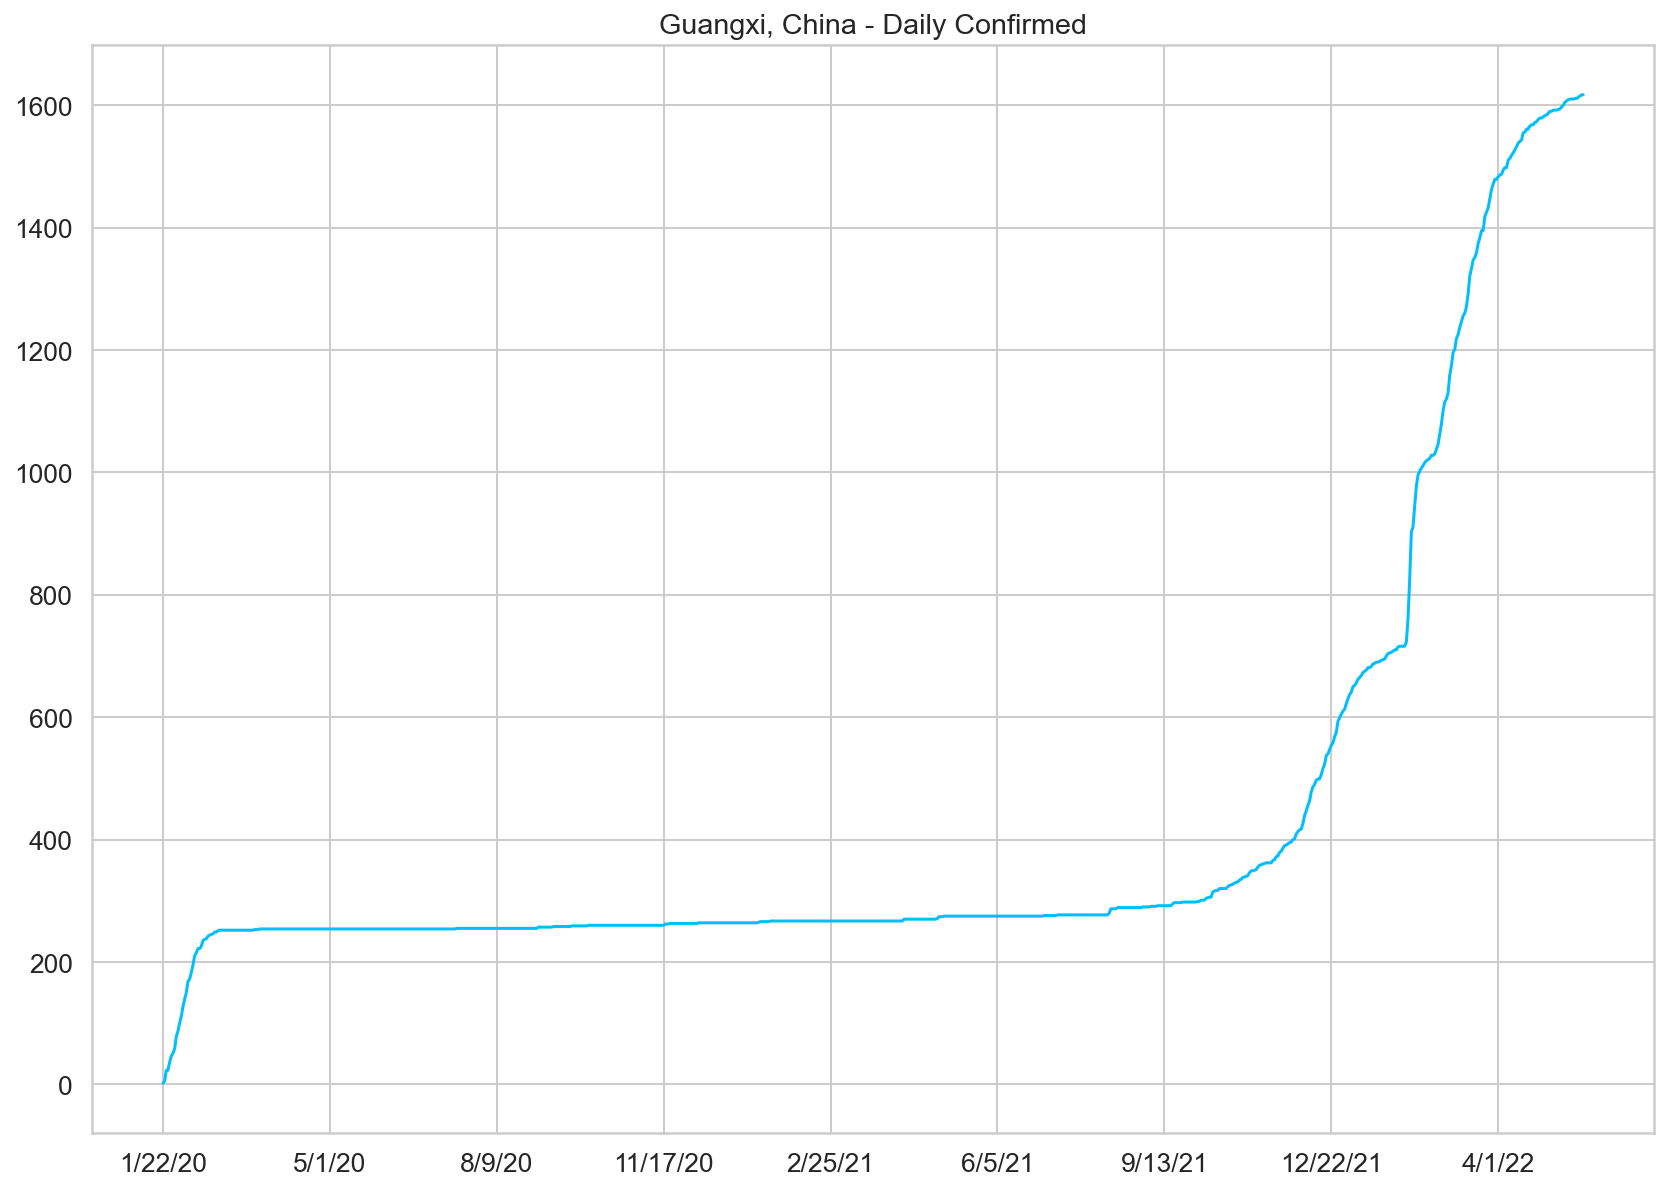

In [40]:
index = 65
fig, ax = plt.subplots(1,1)
# y1 = data.loc[index].diff()
y1 = data.loc[index]

if index == 84:
    y1.loc['4/20/22'] = (y1.loc['4/19/22'] + y1.loc['4/21/22']) // 2

for

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.plot(y1)
confirmed_avg = moving_average(y1, 5)
# plt.plot(confirmed_avg, color='red', linestyle='dashed')
plt.title("{}, {} - Daily Confirmed".format(state.loc[index], country.loc[index]))

plt.show()

# 进行训练集、测试集划分

## 选择预测数据类型
每日新增、累计确诊和直线数据 三选一

In [7]:
if data_select == 0:
    chose_data = data.iloc[index].diff()[1:]
    chose_data = moving_average(chose_data, 5)
    print("选择单日新增")

elif data_select == 1:
    chose_data = data.iloc[index][1:]
    chose_data = moving_average(chose_data, 5)
    print("选择累计新增")

elif data_select == 2:
    chose_data = data.iloc[index][1:]
    chose_data = np.arange(1,1000,1)
    print("选择生成数据")

选择累计新增


## 对序列数据进行生成并归一化

In [37]:
test_data_size = int(data.shape[1] * pre_ratio)

scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(chose_data, axis=1))

chose_data = scaler.transform(np.expand_dims(chose_data, axis=1))


if model_select == 2:
    train_data = chose_data[:-test_data_size]
    test_data = chose_data[-test_data_size:]
    X_train = np.arange(len(train_data))
    y_train = train_data

    X_test = np.arange(len(train_data), len(train_data) + len(test_data))
    y_test = test_data

else:
    train_data = chose_data[:-test_data_size]
    test_data = chose_data[-test_data_size-seq_length:]
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

## 转化成tensor

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 自动使用CPU或者GPU

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# 模型构建
GRUNet和LSTM

In [9]:
class GRUNet(nn.Module):
 
    def __init__(self, input_size = 1):
        super(GRUNet, self).__init__()
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=64,
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout = 0.1,
        )
        self.out = nn.Sequential(
            nn.Linear(128, 1)
        )
        self.avgpool =  nn.AdaptiveAvgPool2d((1,128))
        self.soft = nn.Softmax() 
        self.relu = nn.ReLU()

 
    def forward(self, x):
        r_out, h_n = self.rnn(x, None)  # None 表示 hidden state 会用全0的 state
        # print(r_out.unsqueeze(0).shape) # torch.Size([488, 15, 128]) torch.Size([215, 15, 128])
        # r_out = self.relu(r_out)
        out = self.avgpool(r_out.unsqueeze(0))
        # out = self.relu(out)
        # print(out.shape)
        # print(out.reshape(128,1).shape)
        out = out.squeeze(2).squeeze(0)
        out = self.out(out)
        out = self.relu(out)
        return out
 
 
class LSTMNet(nn.Module):
 
    def __init__(self, input_size = 1):
        super(LSTMNet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=3,
            batch_first=True,
        )
        self.out = nn.Sequential(
            nn.Linear(128, 1)
        )
        self.relu = nn.ReLU()
        self.avgpool =  nn.AdaptiveAvgPool2d((1,128))
        self.soft = nn.Softmax() 
        self.dropout = nn.Dropout(p=0.05)
    def forward(self, x):
        # print(x.view(len(x), 10, -1).shape)
        r_out, (h_n, h_c) = self.rnn(x.view(len(x), seq_length, -1), None)  # None 表示 hidden state 会用全0的 state
        out = self.avgpool(r_out.unsqueeze(0))
        out = out.squeeze(2).squeeze(0)
        out = self.out(out)
        # out = self.dropout(out)
        out = self.relu(out)
        return out

class LinearModel(nn.Module):
 
    def __init__(self, seq_length = seq_length):
        super(LinearModel, self).__init__()
        self.tensor_in = nn.Sequential(
            nn.Linear(seq_length, 128)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 256)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 512)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(512, 256)
        )
        self.out = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.relu = nn.ReLU()
        self.soft = nn.Softmax() 
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.tensor_in(x)
        x = self.soft(x)
        x = self.layer2(x)
        out = self.relu(x)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.layer4(out)
        out = self.relu(out)
        out = self.out(out)
        out = self.relu(out)
        return out
 

# 模型训练参数设置

In [11]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None,
  num_epochs=600
):

  loss_fn = torch.nn.MSELoss(reduction='sum') # 损失函数
  # loss_fn = torch.nn.L1Loss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_ratio, betas=(0.9, 0.99)) # 优化器类型
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=500, gamma = 0.8)
  if model_select != 2:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min= 0.0001)
  # torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False)

  
  

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  lr_list = []

  for t in range(num_epochs):
    y_pred = model(train_data)
    loss = loss_fn(y_pred.float(), train_labels)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(test_data)
        test_loss = loss_fn(y_test_pred.float(), test_labels)
      test_hist[t] = test_loss.item()

      if (t+1) % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif (t+1) % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    if model_select != 2:
      scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
  
  return model.eval(), train_hist, test_hist, lr_list

# 选择模型


In [155]:
if model_select == 0:
    model = LSTMNet()
    model_name = "LSTM"
elif model_select == 1:
    model = GRUNet()
    model_name = "GRUNet"
else:
    model = LinearModel(seq_length=1)
    model_name = "Linear"

# 模型训练
并输出loss变化曲线

Epoch 99 train loss: 0.2497517615556717 test loss: 10.643699645996094
Epoch 199 train loss: 0.11077547073364258 test loss: 6.010397434234619
Epoch 299 train loss: 0.07582667469978333 test loss: 1.859548568725586
Epoch 399 train loss: 0.08562541007995605 test loss: 0.7780895233154297
Epoch 499 train loss: 0.039717476814985275 test loss: 0.6625693440437317
Epoch 599 train loss: 0.03448307514190674 test loss: 0.5746933221817017
Epoch 699 train loss: 0.030302774161100388 test loss: 0.669162929058075
Epoch 799 train loss: 0.023398814722895622 test loss: 0.8012173771858215
Epoch 899 train loss: 0.02536463737487793 test loss: 0.7381427884101868
Epoch 999 train loss: 0.021284043788909912 test loss: 0.6708434224128723
Epoch 1099 train loss: 0.019183531403541565 test loss: 0.6679266691207886
Epoch 1199 train loss: 0.018997332081198692 test loss: 0.6943349242210388
Epoch 1299 train loss: 0.016814453527331352 test loss: 0.7098206281661987
Epoch 1399 train loss: 0.016140758991241455 test loss: 0.79

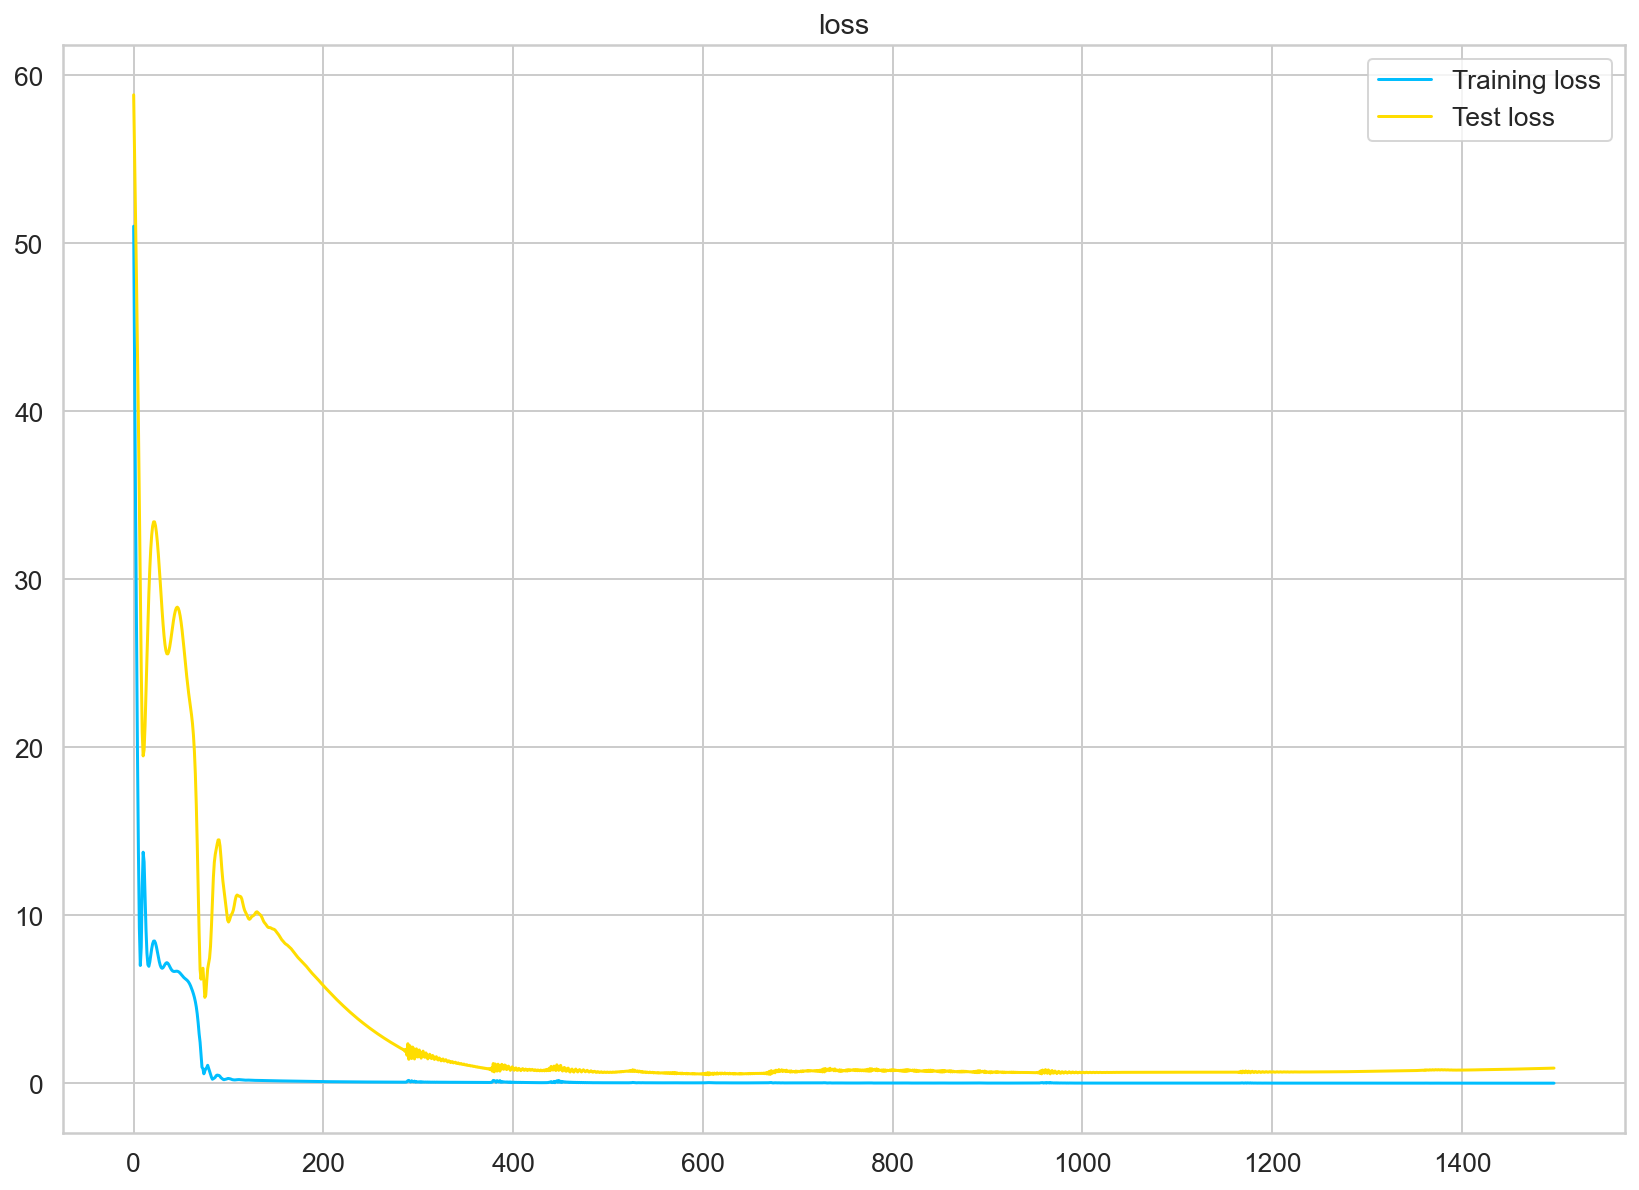

In [156]:
model = model.to(device)
model, train_hist, test_hist, lr_list = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

plt.plot(train_hist[2:], label="Training loss")
plt.plot(test_hist[2:], label="Test loss")
plt.title("loss")
plt.legend()

In [157]:
# '''载入数据'''
# from sklearn import datasets
# import numpy as np

# x = np.expand_dims(np.arange(len(chose_data)),1)
# y = np.expand_dims(chose_data, 1)
# '''引入标准化函数'''
# from sklearn import preprocessing
# x_MinMax = preprocessing.MinMaxScaler()
# y_MinMax = preprocessing.MinMaxScaler()
 
# ''' 将 y 转换成 列 '''


# y = np.array(y).reshape(len(y),1)
# '''标准化'''
# x = x_MinMax.fit_transform(x)
# y = y_MinMax.fit_transform(y)
 
# ''' 按二八原则划分训练集和测试集 '''
# from sklearn.model_selection import train_test_split
# np.random.seed(2019)

# x_train = x[:-int(len(x)*0.2)]
# x_test = x[-int(len(x)*0.2):]
# y_train = y[:-int(len(x)*0.2)]
# y_test = y[-int(len(x)*0.2):]
'''
x_train = X_train.unsqueeze(1).cpu()
x_test = X_test.unsqueeze(1).cpu()
y_train = y_train.cpu()
y_test = y_test.cpu()

# 模型构建
from sklearn.neural_network import MLPRegressor
fit1 = MLPRegressor(
        hidden_layer_sizes=(256, 64, 32), activation='logistic',solver='adam',
        alpha=0.01,max_iter=200)
print ("fitting model right now")
fit1.fit(x_train,y_train)
pred1_train = fit1.predict(x_train)
# 计算训练集 MSE
from sklearn.metrics import mean_squared_error
mse_1 = mean_squared_error(pred1_train,y_train)
print ("Train ERROR = ", mse_1)
# 计算测试集mse
preds = fit1.predict(np.expand_dims(np.arange(len(chose_data)), 1))
pred1 = fit1.predict(x_test)
# mse_2 = mean_squared_error(pred1_test,y_test)
# print ("Test ERROR = ", mse_2)
 
# 结果可视化
import matplotlib.pyplot as plt
xx=range(0,len(y_test))
plt.figure(figsize=(8,6))
plt.plot(xx,y_test,color="red",label="Sample Point",linewidth=3) 
plt.plot(xx,pred1,color="orange",label="Fitting Line",linewidth=2)
plt.legend()
plt.show()
'''

'\nx_train = X_train.unsqueeze(1).cpu()\nx_test = X_test.unsqueeze(1).cpu()\ny_train = y_train.cpu()\ny_test = y_test.cpu()\n\n# 模型构建\nfrom sklearn.neural_network import MLPRegressor\nfit1 = MLPRegressor(\n        hidden_layer_sizes=(256, 64, 32), activation=\'logistic\',solver=\'adam\',\n        alpha=0.01,max_iter=200)\nprint ("fitting model right now")\nfit1.fit(x_train,y_train)\npred1_train = fit1.predict(x_train)\n# 计算训练集 MSE\nfrom sklearn.metrics import mean_squared_error\nmse_1 = mean_squared_error(pred1_train,y_train)\nprint ("Train ERROR = ", mse_1)\n# 计算测试集mse\npreds = fit1.predict(np.expand_dims(np.arange(len(chose_data)), 1))\npred1 = fit1.predict(x_test)\n# mse_2 = mean_squared_error(pred1_test,y_test)\n# print ("Test ERROR = ", mse_2)\n \n# 结果可视化\nimport matplotlib.pyplot as plt\nxx=range(0,len(y_test))\nplt.figure(figsize=(8,6))\nplt.plot(xx,y_test,color="red",label="Sample Point",linewidth=3) \nplt.plot(xx,pred1,color="orange",label="Fitting Line",linewidth=2)\nplt.lege

## 学习率变化曲线

Text(0.5, 1.0, 'lr')

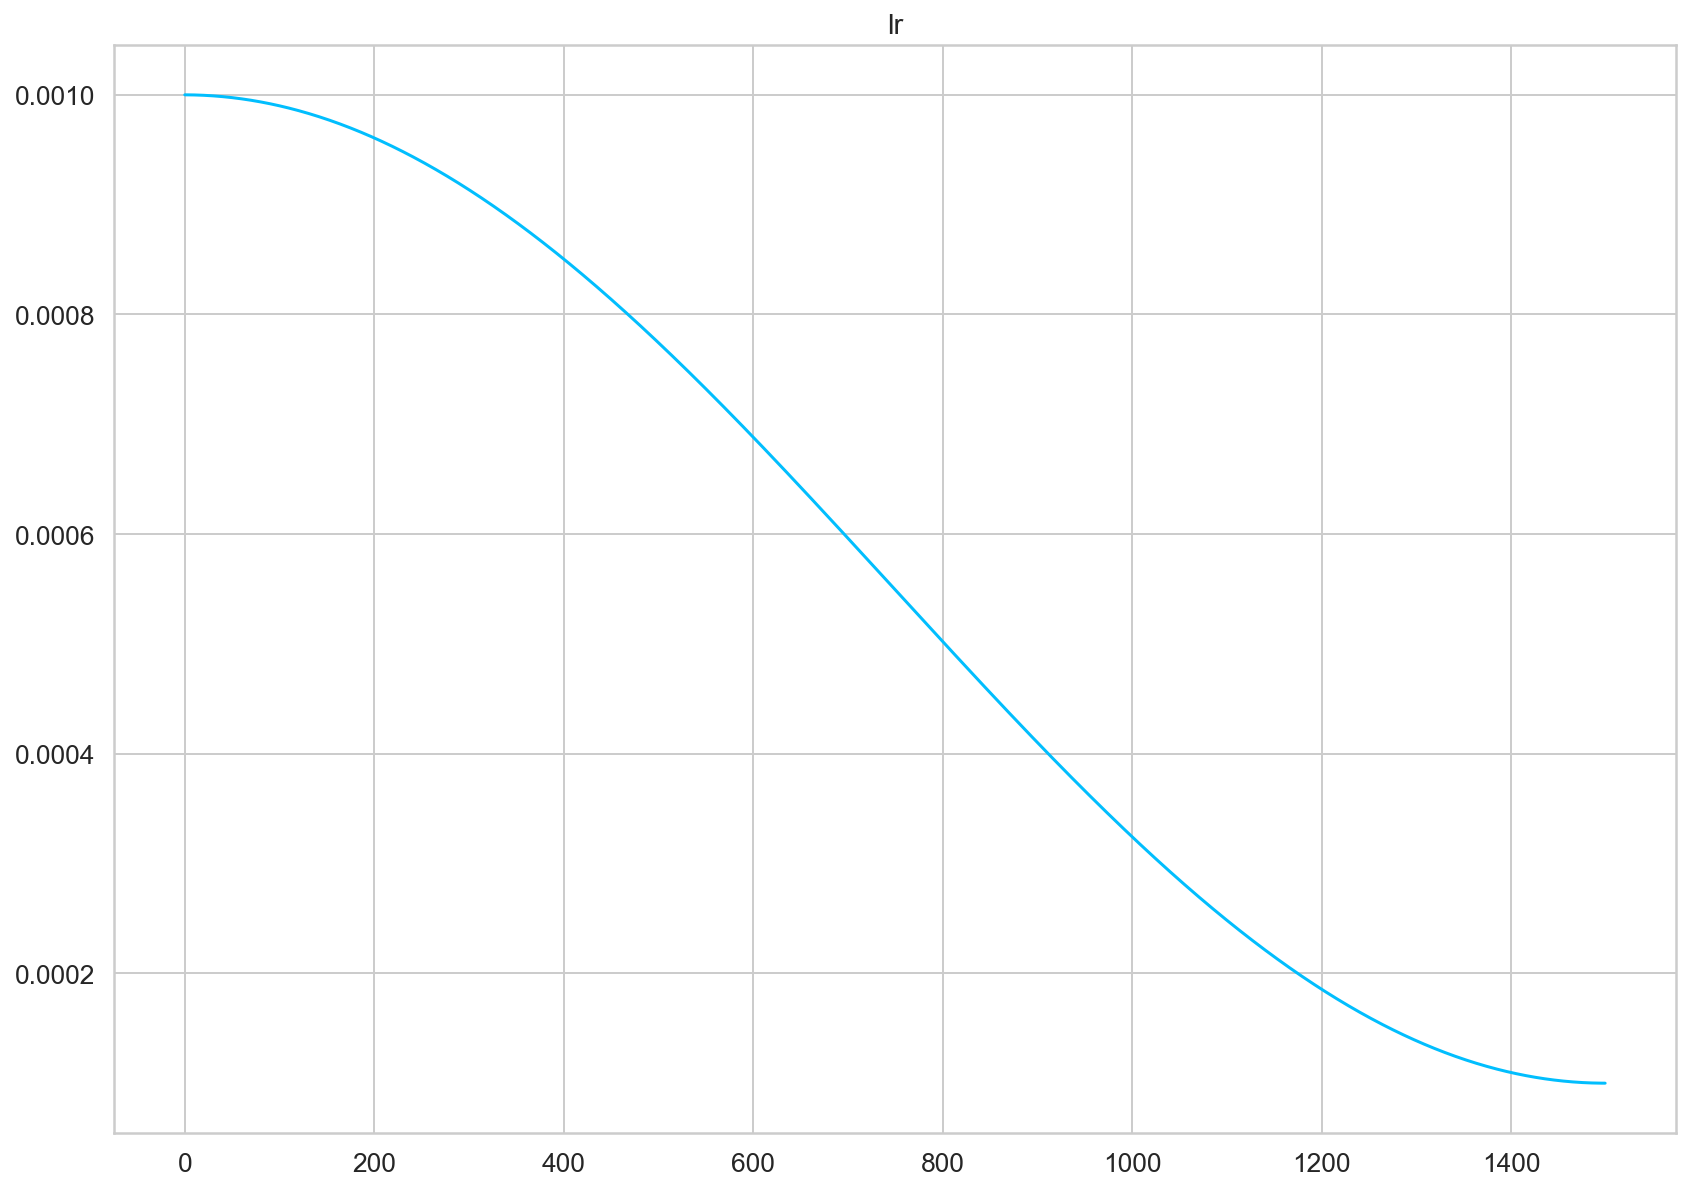

In [158]:
plt.plot(lr_list, label="lr")
plt.title("lr")

# 模型测试
## 模型测试

In [159]:
model = model.to(device)
with torch.no_grad():
  if model_select == 2:
    test_seq = X_test
    test_seq = test_seq.to(device)
    y_test_pred = model(test_seq)
    preds = y_test_pred.squeeze(1).cpu().numpy()
  else:
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
      test_seq = test_seq.to(device)
      y_test_pred = model(test_seq)
      pred = torch.flatten(y_test_pred).item()
      preds.append(pred)
      new_seq = test_seq.cpu().numpy().flatten()
      new_seq = np.append(new_seq, [pred])
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

## 对国家疫情测试数据可视化

0.8946728029790028


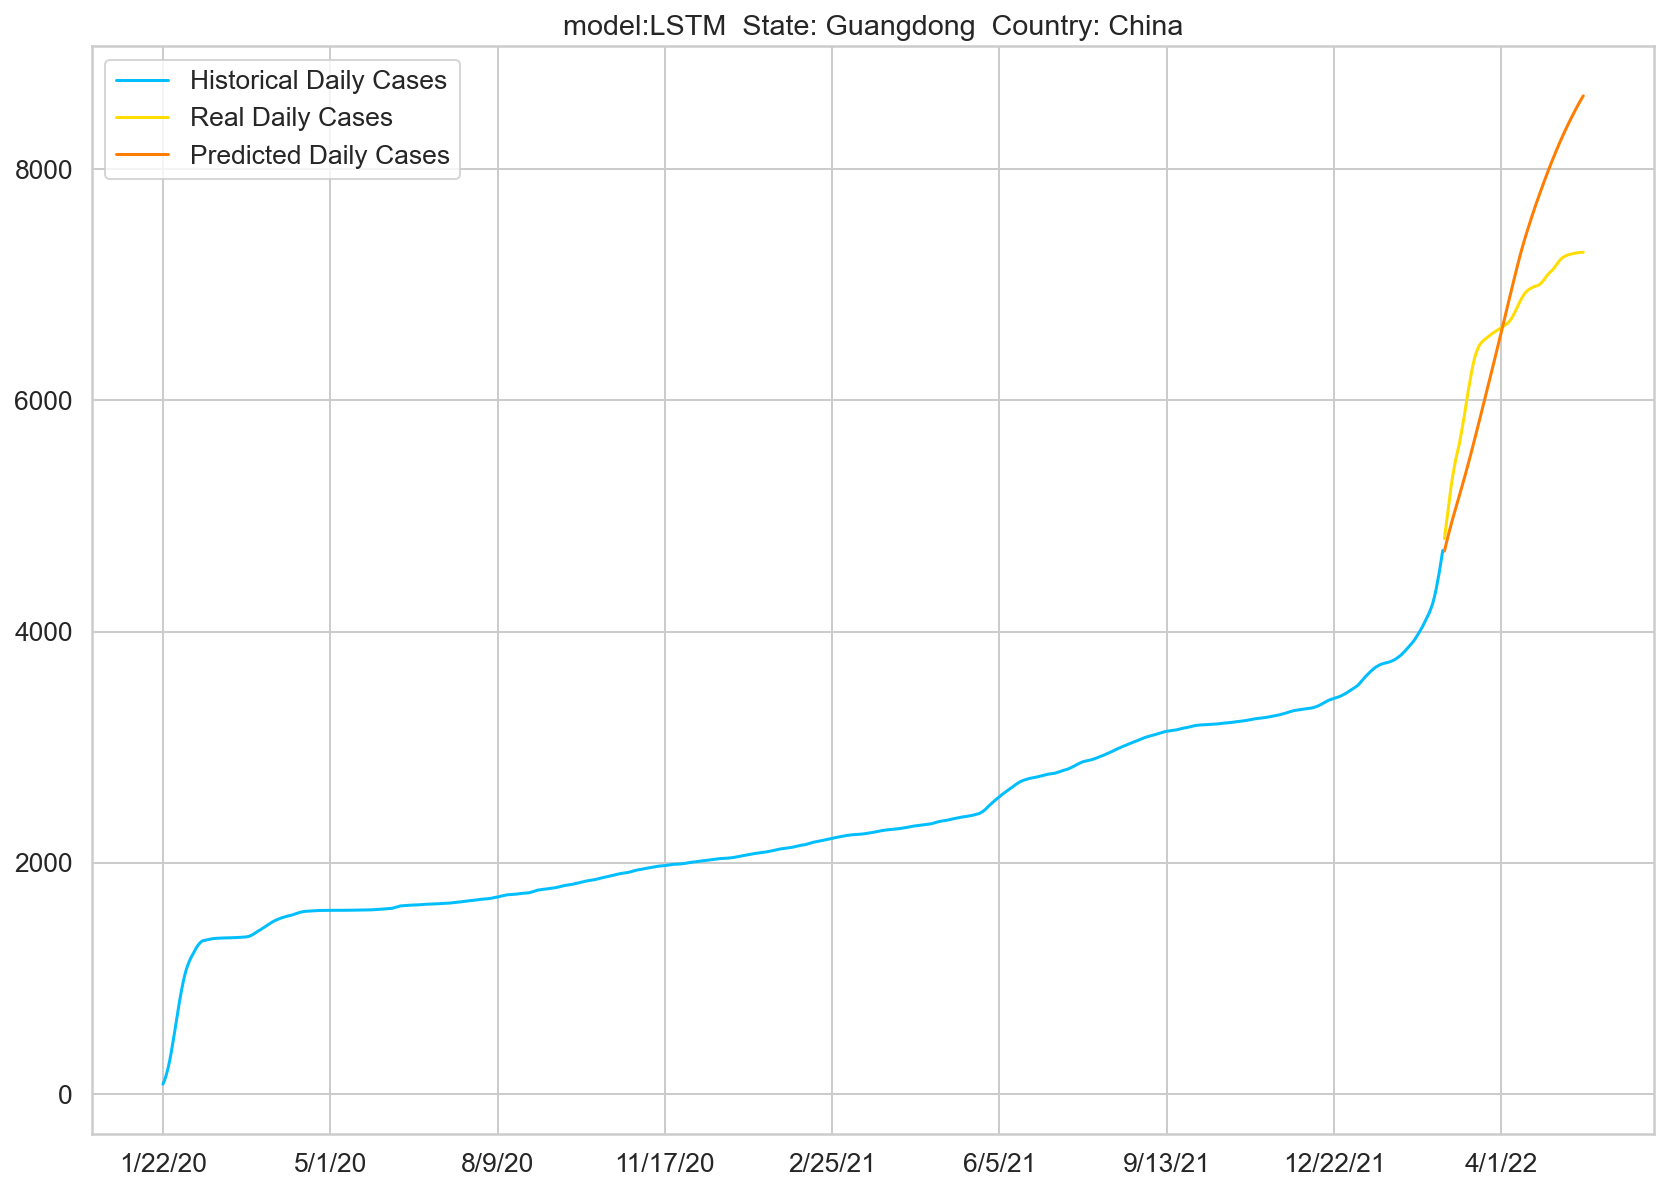

In [160]:
if model_select == 2 and data_select != 2:
  train_data = y_train.cpu()
  true_cases = scaler.inverse_transform(
      np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
  ).flatten()

  predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
  ).flatten()
  predicted_cases = np.int32(predicted_cases)

  fig, ax = plt.subplots(1,1)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

  plt.plot(
    data.iloc[index].index[:len(train_data)], 
    (scaler.inverse_transform(train_data).flatten()), # 648
    label='Historical Daily Cases'
  )
 
  print(data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)].shape)
  plt.plot(
    data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],  # 721
    (true_cases), # 102
    label='Real Daily Cases'
  )

  # plt.plot(
  #   data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)], 
  #   (predicted_cases), 
  #   label='Predicted Daily Cases'
  # )
  plt.plot(
    data.iloc[index].index[:len(chose_data)], 
    (predicted_cases), 
    label='Predicted Daily Cases'
  )
  plt.title("model:{}  Country: {}".format(model_name, country[index]))
  plt.legend()

elif data_select==0 or data_select==1:
  true_cases = scaler.inverse_transform(
      np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
  ).flatten()

  predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
  ).flatten()
  predicted_cases = np.int32(predicted_cases)

  fig, ax = plt.subplots(1,1)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(100))


  plt.plot(
    data.iloc[index].index[:len(train_data)], 
    (scaler.inverse_transform(train_data).flatten()),
    label='Historical Daily Cases'
  )

  plt.plot(
    data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)], 
    (true_cases),
    label='Real Daily Cases'
  )

  plt.plot(
    data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)], 
    (predicted_cases), 
    label='Predicted Daily Cases'
  )
  plt.title("model:{}  State: {}  Country: {}".format(model_name, state[index], country[index]))
  plt.legend()
  print(np.sum(((true_cases - predicted_cases) / true_cases)**2))

## 对直线数据预测可视化

In [161]:
if data_select == 2:
    true_cases = scaler.inverse_transform(
        np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
    ).flatten()

    predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
    ).flatten()
    predicted_cases = np.int32(predicted_cases)

    fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

    plt.plot(np.arange(0,len(train_data)), scaler.inverse_transform(train_data).flatten(), label = "Train")

    plt.plot(np.arange(len(train_data), len(train_data) + len(true_cases)), true_cases, label = "Real")

    plt.plot(np.arange(len(train_data), len(train_data) + len(predicted_cases)), predicted_cases, label = "predicted")

    plt.title("对直线数据进行拟合")

In [162]:
torch.save(model, '../../model/LSTMNet2.pth')

In [32]:
def data_testing(data, index, model):
    pre_ratio = 0.1

    seq_length = 50

    model_select = 0
    # model_select = 1

    num_epochs = 100

    data_select = 1 # 进行数据集的选择

    lr_ratio = 1e-3

    fig, ax = plt.subplots(1, 1)
    y1 = data.loc[index].diff()

    model_name = "LSTMNet-{}".format(state.loc[index])

    # 清洗了上海数据中的wrong case
    if index == 84:
        y1.loc['4/20/22'] = (y1.loc['4/19/22'] + y1.loc['4/21/22']) // 2

    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    plt.plot(y1)
    confirmed_avg = moving_average(y1, 5)
    plt.plot(confirmed_avg, color='red', linestyle='dashed')
    plt.title("{}, {} - Daily Confirmed".format(state.loc[index], country.loc[index]))

    #     plt.show()
    plt.savefig("../daily/{}, {} - Daily Confirmed.png".format(state.loc[index], country.loc[index]))
    plt.close('all')  # 关闭所有 figure windows

    chose_data = data.iloc[index][1:]
    chose_data = moving_average(chose_data, 5)
    print("选择累计新增")

    test_data_size = int(data.shape[1] * pre_ratio)

    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(chose_data, axis=1))

    chose_data = scaler.transform(np.expand_dims(chose_data, axis=1))

    # 数据选择 + 预处理
    if model_select == 2:
        train_data = chose_data[:-test_data_size]
        test_data = chose_data[-test_data_size:]
        X_train = np.arange(len(train_data))
        y_train = train_data

        X_test = np.arange(len(train_data), len(train_data) + len(test_data))
        y_test = test_data

    else:
        train_data = chose_data[:-test_data_size]
        test_data = chose_data[-test_data_size - seq_length:]
        X_train, y_train = create_sequences(train_data, seq_length)
        X_test, y_test = create_sequences(test_data, seq_length)

    # 转换为tenseor
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 自动使用CPU或者GPU

    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)

    X_test = torch.from_numpy(X_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

#     对于每一个地方训练一下
    model = model.to(device)
    # model, train_hist, test_hist, lr_list = train_model(
    #   model,
    #   X_train,
    #   y_train,
    #   X_test,
    #   y_test,
    #   num_epochs=600
    # )

    #     测试结果
    with torch.no_grad():
        if model_select == 2:
            test_seq = X_test
            test_seq = test_seq.to(device)
            y_test_pred = model(test_seq)
            preds = y_test_pred.squeeze(1).cpu().numpy()
        else:
            test_seq = X_test[:1]
            preds = []
            for _ in range(len(X_test)):
                test_seq = test_seq.to(device)
                y_test_pred = model(test_seq)
                pred = torch.flatten(y_test_pred).item()
                preds.append(pred)
                new_seq = test_seq.cpu().numpy().flatten()
                new_seq = np.append(new_seq, [pred])
                new_seq = new_seq[1:]
                test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

    if model_select == 2 and data_select != 2:
        train_data = y_train.cpu()
        true_cases = scaler.inverse_transform(
            np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
        ).flatten()

        predicted_cases = scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
        ).flatten()
        predicted_cases = np.int32(predicted_cases)

        fig, ax = plt.subplots(1, 1)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

        plt.plot(
            data.iloc[index].index[:len(train_data)],
            (scaler.inverse_transform(train_data).flatten()),  # 648
            label='Historical Daily Cases'
        )

        print(data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)].shape)
        plt.plot(
            data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],  # 721
            (true_cases),  # 102
            label='Real Daily Cases'
        )

        # plt.plot(
        #   data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],
        #   (predicted_cases),
        #   label='Predicted Daily Cases'
        # )
        plt.plot(
            data.iloc[index].index[:len(chose_data)],
            (predicted_cases),
            label='Predicted Daily Cases'
        )
        plt.title("model:{}  Country: {}".format(model_name, country[index]))
        plt.legend()

    elif data_select == 0 or data_select == 1:
        true_cases = scaler.inverse_transform(
            np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
        ).flatten()

        predicted_cases = scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
        ).flatten()
        predicted_cases = np.int32(predicted_cases)

        fig, ax = plt.subplots(1, 1)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

        plt.plot(
            data.iloc[index].index[500:len(train_data)],
            (scaler.inverse_transform(train_data).flatten())[500:],
            label='Historical Daily Cases'
        )
        print(len(train_data) - 500)
        print(len(true_cases))

        plt.plot(
            data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],
            (true_cases),
            label='Real Daily Cases'
        )

        plt.plot(
            data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],
            (predicted_cases),
            label='Predicted Daily Cases'
        )
        plt.title("model:{}-State:{}Country:{}".format(model_name, state[index], country[index]))
        plt.savefig("../pre/{}_v2.png".format(state[index]))
        plt.legend()
#         print(np.sum(((true_cases - predicted_cases) / true_cases) ** 2))

        plt.show()
#         plt.savefig("..\\pre\\model:{}  State: {}  Country: {}.png".format(model_name, state[index], country[index])
        plt.close('all')

选择累计新增
Epoch 99 train loss: 0.17047548294067383 test loss: 0.14279833436012268
Epoch 199 train loss: 0.10606449097394943 test loss: 0.15506066381931305
Epoch 299 train loss: 0.06698501110076904 test loss: 0.16098180413246155
Epoch 399 train loss: 0.03165704384446144 test loss: 0.1729429066181183
Epoch 499 train loss: 0.02920735441148281 test loss: 0.16720442473888397
Epoch 599 train loss: 0.028216520324349403 test loss: 0.1636587530374527
266
84


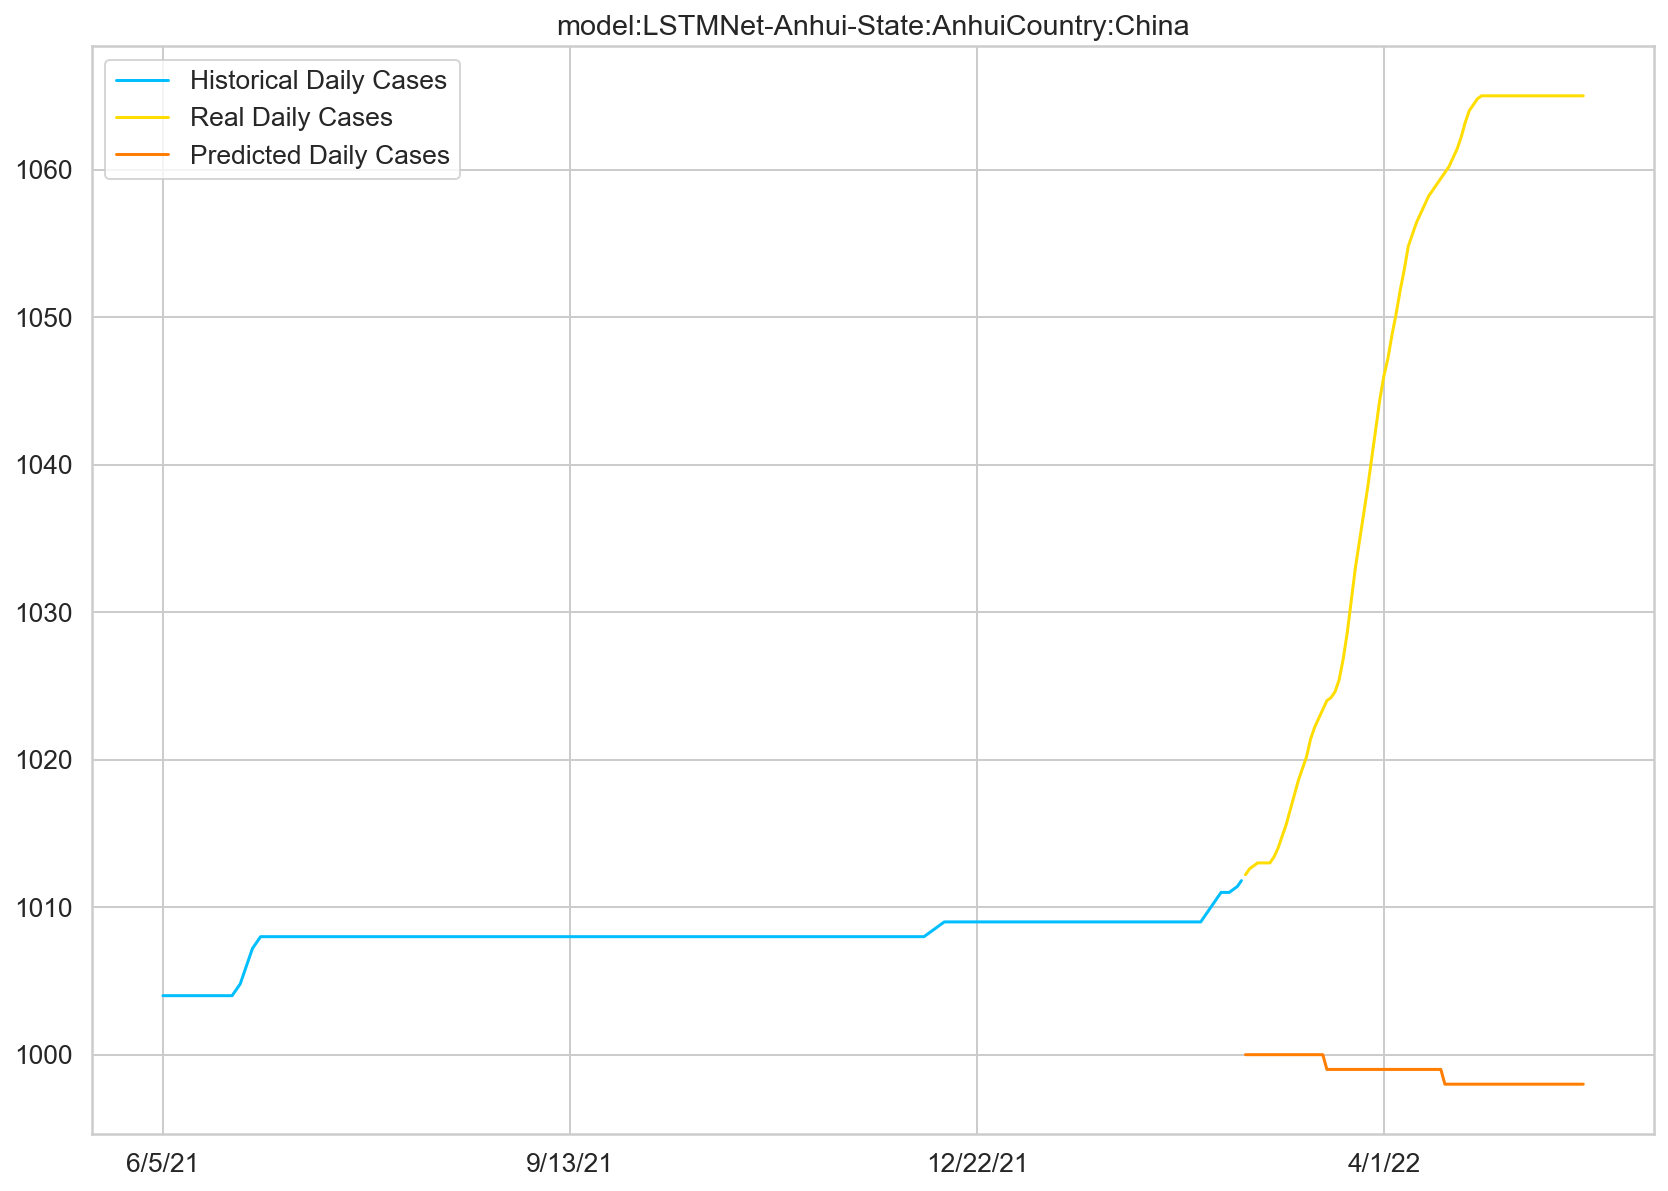

2.9100905219713846
选择累计新增
Epoch 99 train loss: 0.3832651972770691 test loss: 4.761838912963867
Epoch 199 train loss: 0.1920042634010315 test loss: 1.9162753820419312
Epoch 299 train loss: 0.1802225261926651 test loss: 1.2632380723953247
Epoch 399 train loss: 0.16873346269130707 test loss: 0.8789585828781128
Epoch 499 train loss: 0.15925976634025574 test loss: 0.7576023936271667
Epoch 599 train loss: 0.15554319322109222 test loss: 0.8546923398971558
266
84


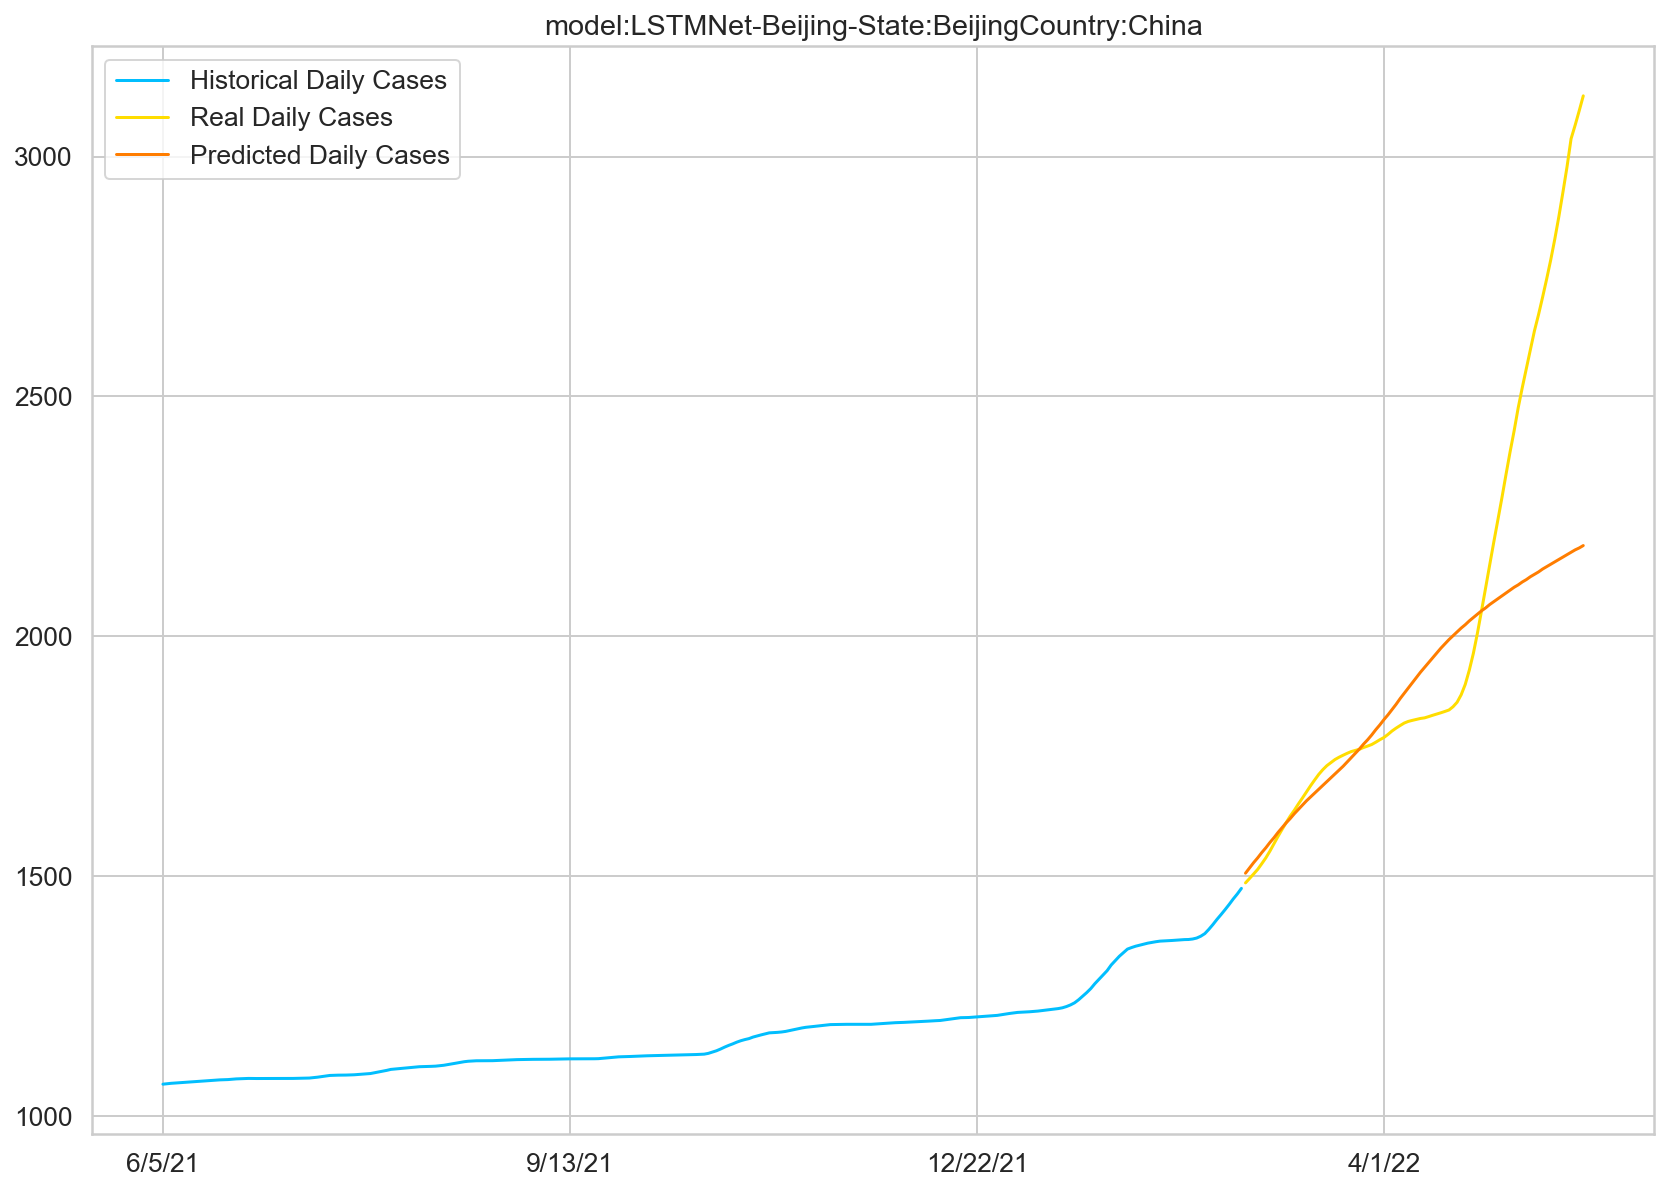

2.8879512389500936
选择累计新增
Epoch 99 train loss: 0.13540975749492645 test loss: 1.262258529663086
Epoch 199 train loss: 0.08724258840084076 test loss: 1.032560110092163
Epoch 299 train loss: 0.03154822066426277 test loss: 0.5611140727996826
Epoch 399 train loss: 0.007192307151854038 test loss: 0.43811482191085815
Epoch 499 train loss: 0.005601444281637669 test loss: 0.47383052110671997
Epoch 599 train loss: 0.005142801441252232 test loss: 0.47835543751716614
266
84


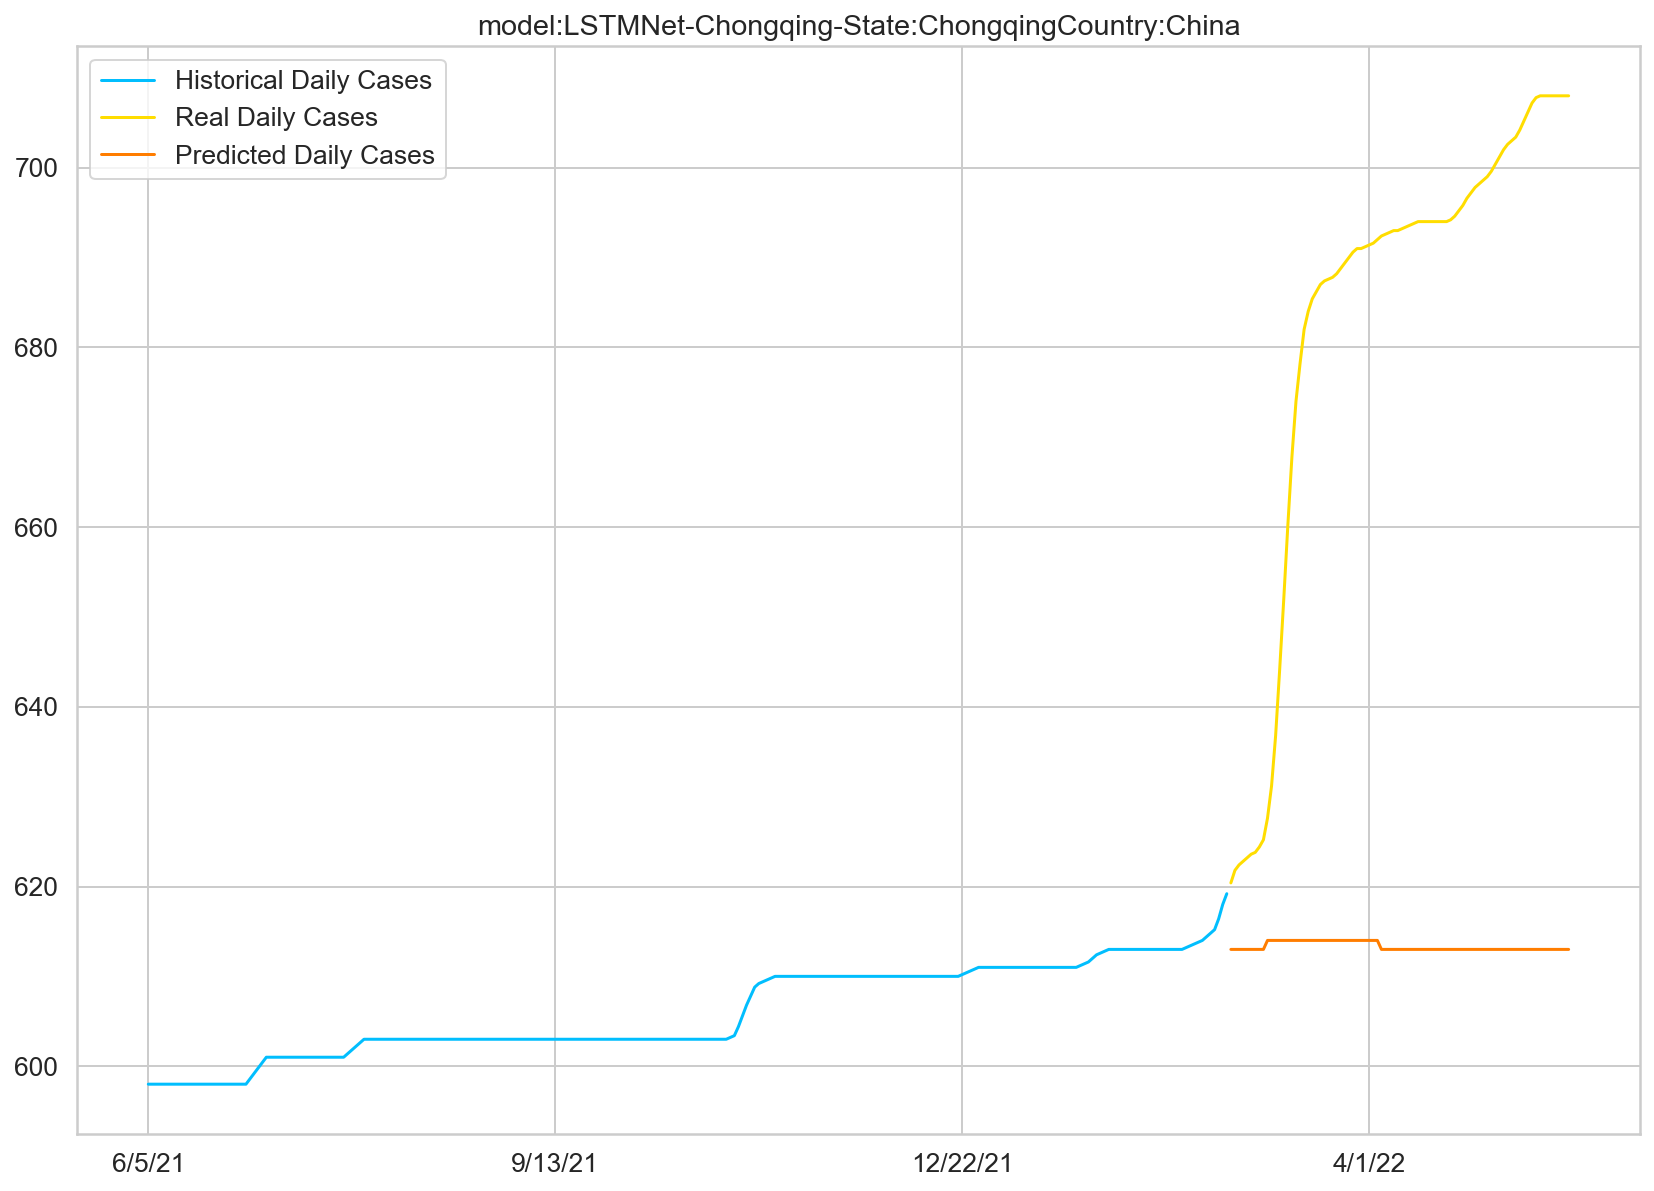

3.016188903649648
选择累计新增
Epoch 99 train loss: 0.2161847949028015 test loss: 4.979515075683594
Epoch 199 train loss: 0.12554603815078735 test loss: 2.6976683139801025
Epoch 299 train loss: 0.10967408865690231 test loss: 2.5364279747009277
Epoch 399 train loss: 0.10038754343986511 test loss: 2.926023244857788
Epoch 499 train loss: 0.09066026657819748 test loss: 3.586052894592285
Epoch 599 train loss: 0.08562374860048294 test loss: 3.9806010723114014
266
84


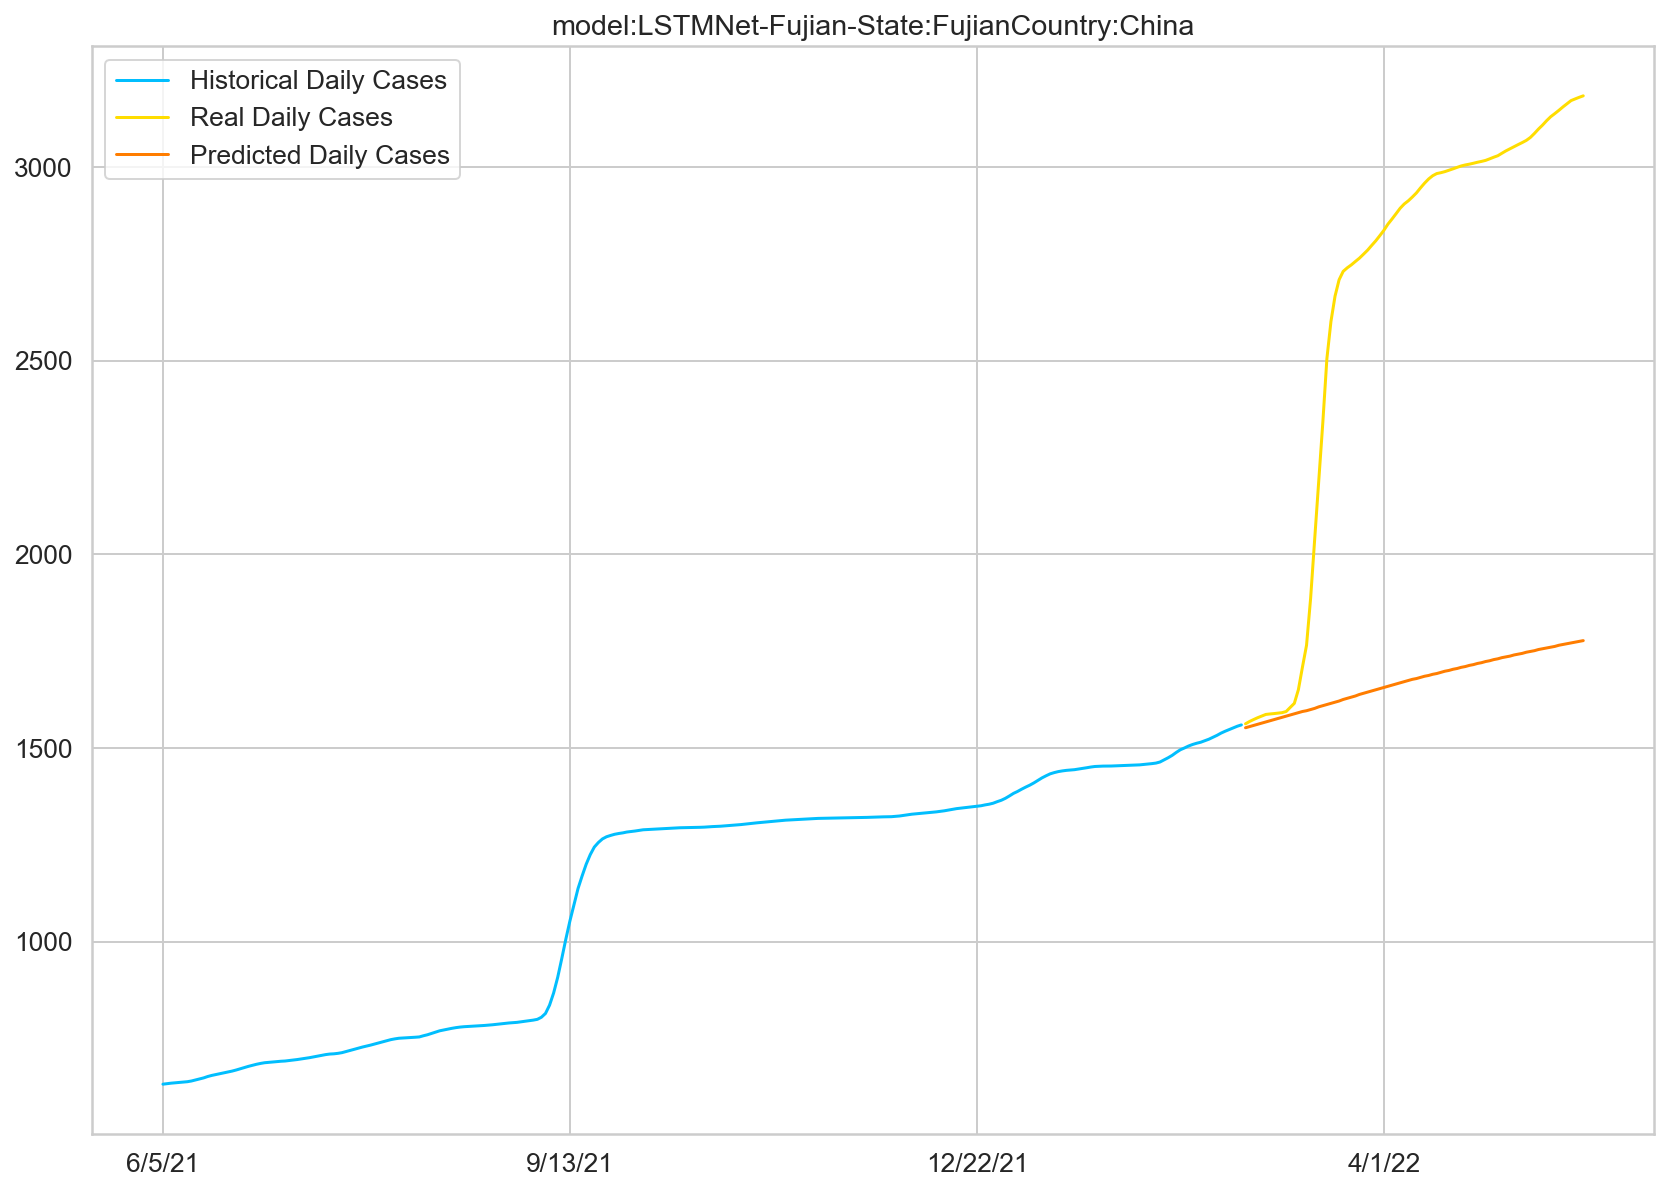

2.9305590113004047
选择累计新增
Epoch 99 train loss: 0.3142242729663849 test loss: 4.856939315795898
Epoch 199 train loss: 0.27631956338882446 test loss: 7.576568603515625
Epoch 299 train loss: 0.1400679051876068 test loss: 6.325610160827637
Epoch 399 train loss: 0.2319437861442566 test loss: 9.413124084472656
Epoch 499 train loss: 0.16956181824207306 test loss: 8.216726303100586
Epoch 599 train loss: 0.129953995347023 test loss: 7.856924057006836
266
84


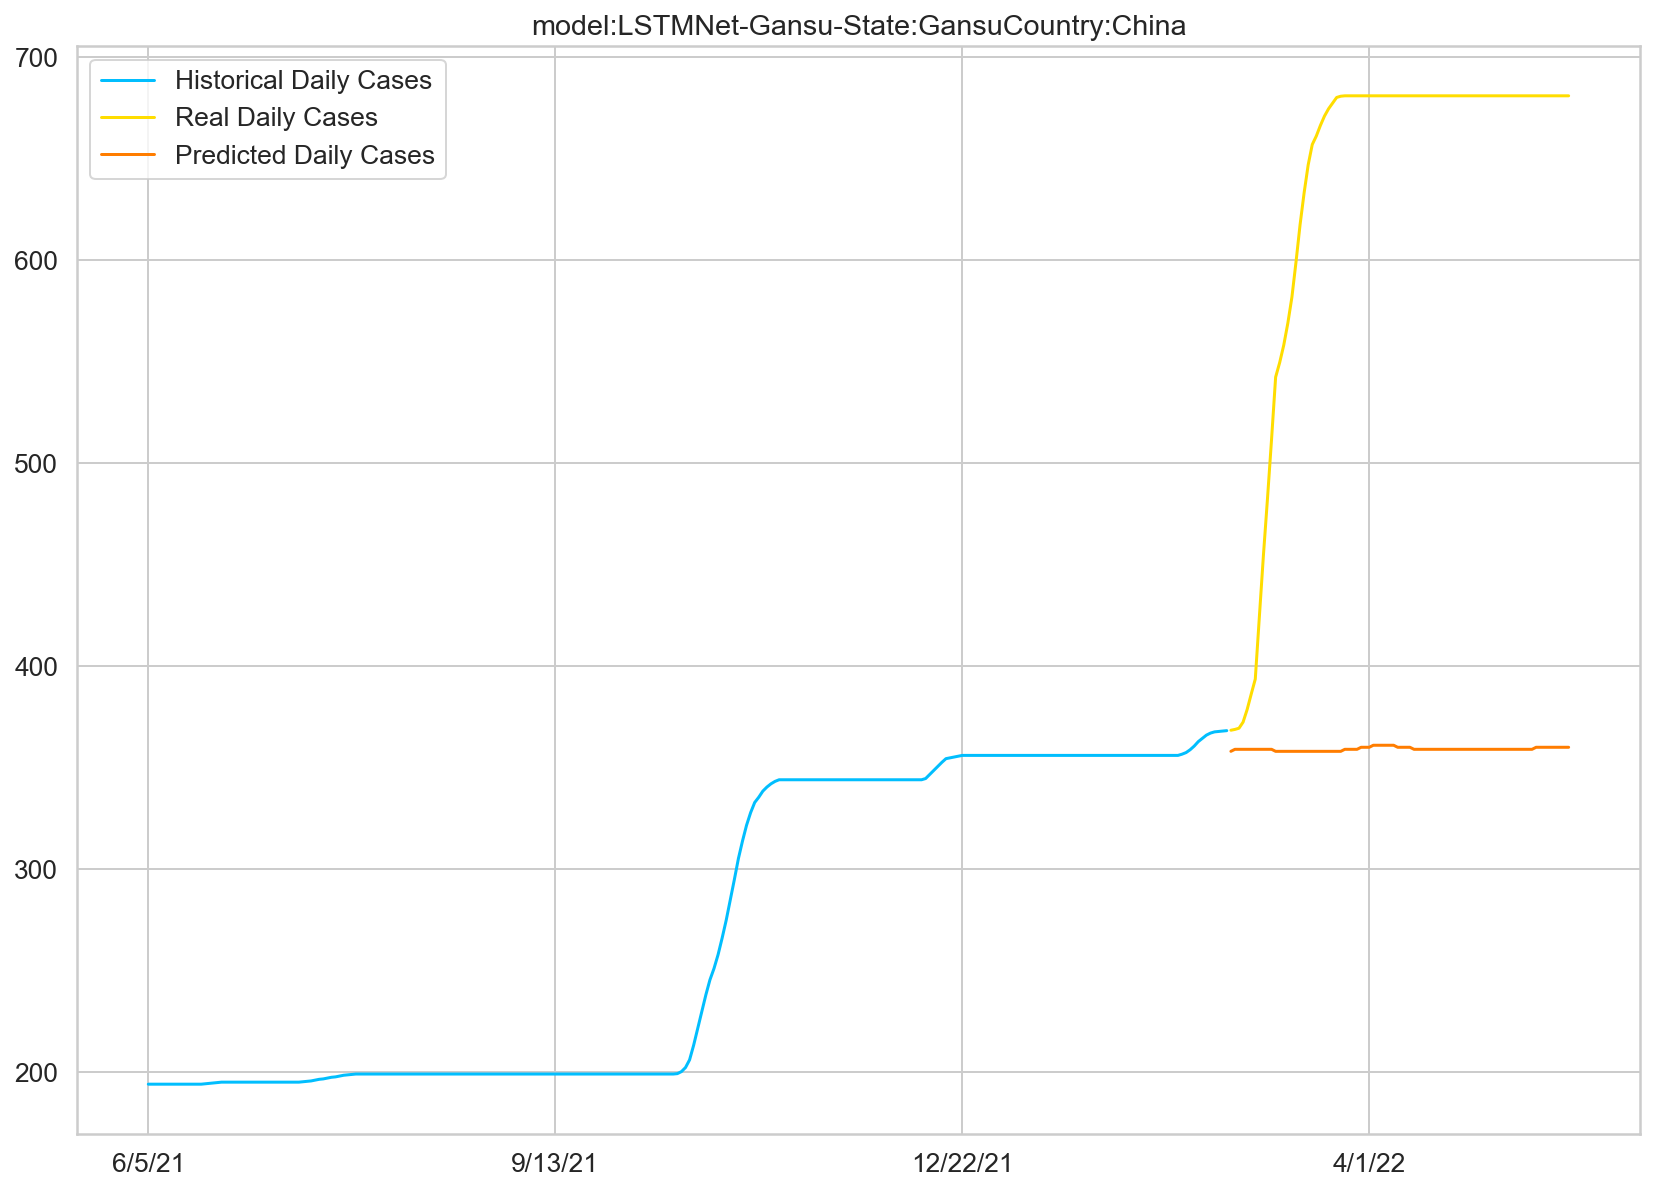

3.0323234756787616
选择累计新增
Epoch 99 train loss: 0.028886515647172928 test loss: 1.5538119077682495
Epoch 199 train loss: 0.014978607185184956 test loss: 0.44306033849716187
Epoch 299 train loss: 0.012303057126700878 test loss: 0.6065607070922852
Epoch 399 train loss: 0.011748315766453743 test loss: 1.113107442855835
Epoch 499 train loss: 0.011509625241160393 test loss: 1.840353012084961
Epoch 599 train loss: 0.011316833086311817 test loss: 3.386131525039673
266
84


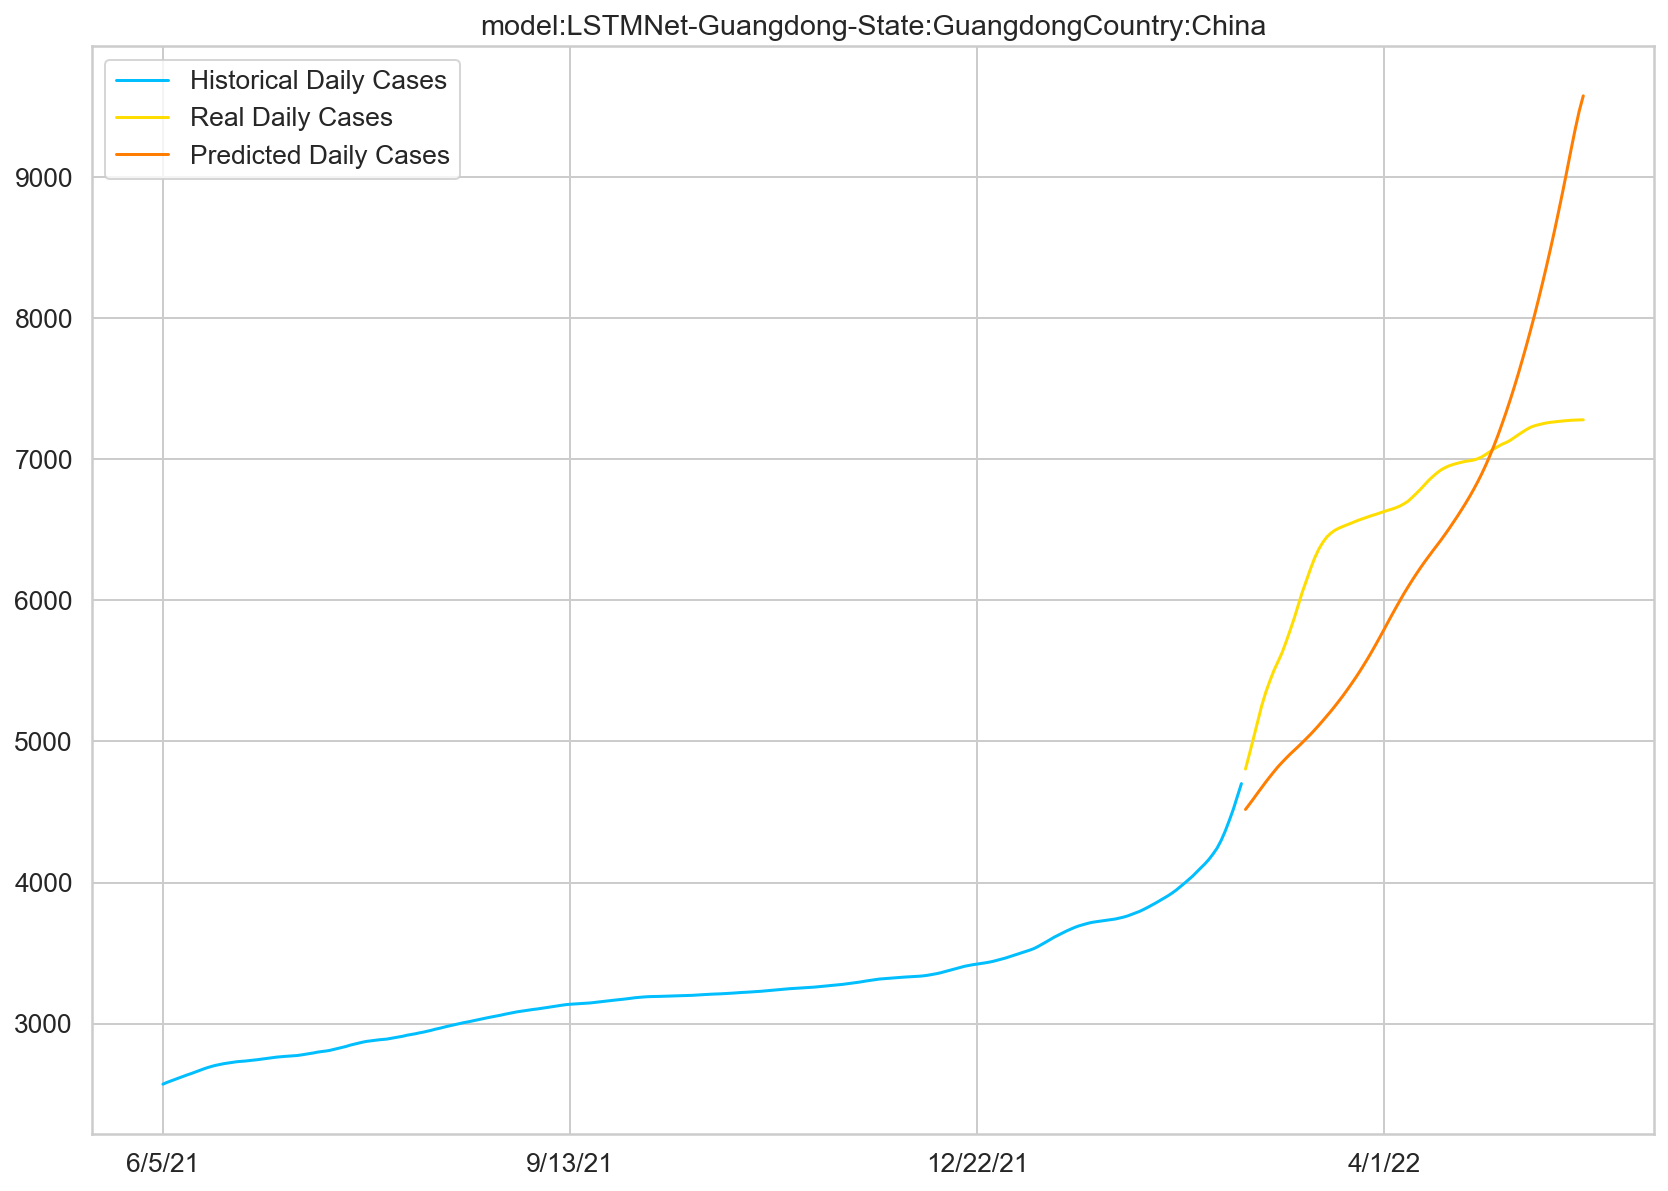

3.0203746438026426
选择累计新增
Epoch 99 train loss: 0.036730799823999405 test loss: 1.7830591201782227
Epoch 199 train loss: 0.02374347858130932 test loss: 4.241804122924805
Epoch 299 train loss: 0.012311521917581558 test loss: 3.826972007751465
Epoch 399 train loss: 0.00716619286686182 test loss: 3.224393844604492
Epoch 499 train loss: 0.005826627369970083 test loss: 2.151549816131592
Epoch 599 train loss: 0.0051061552949249744 test loss: 2.3704562187194824
266
84


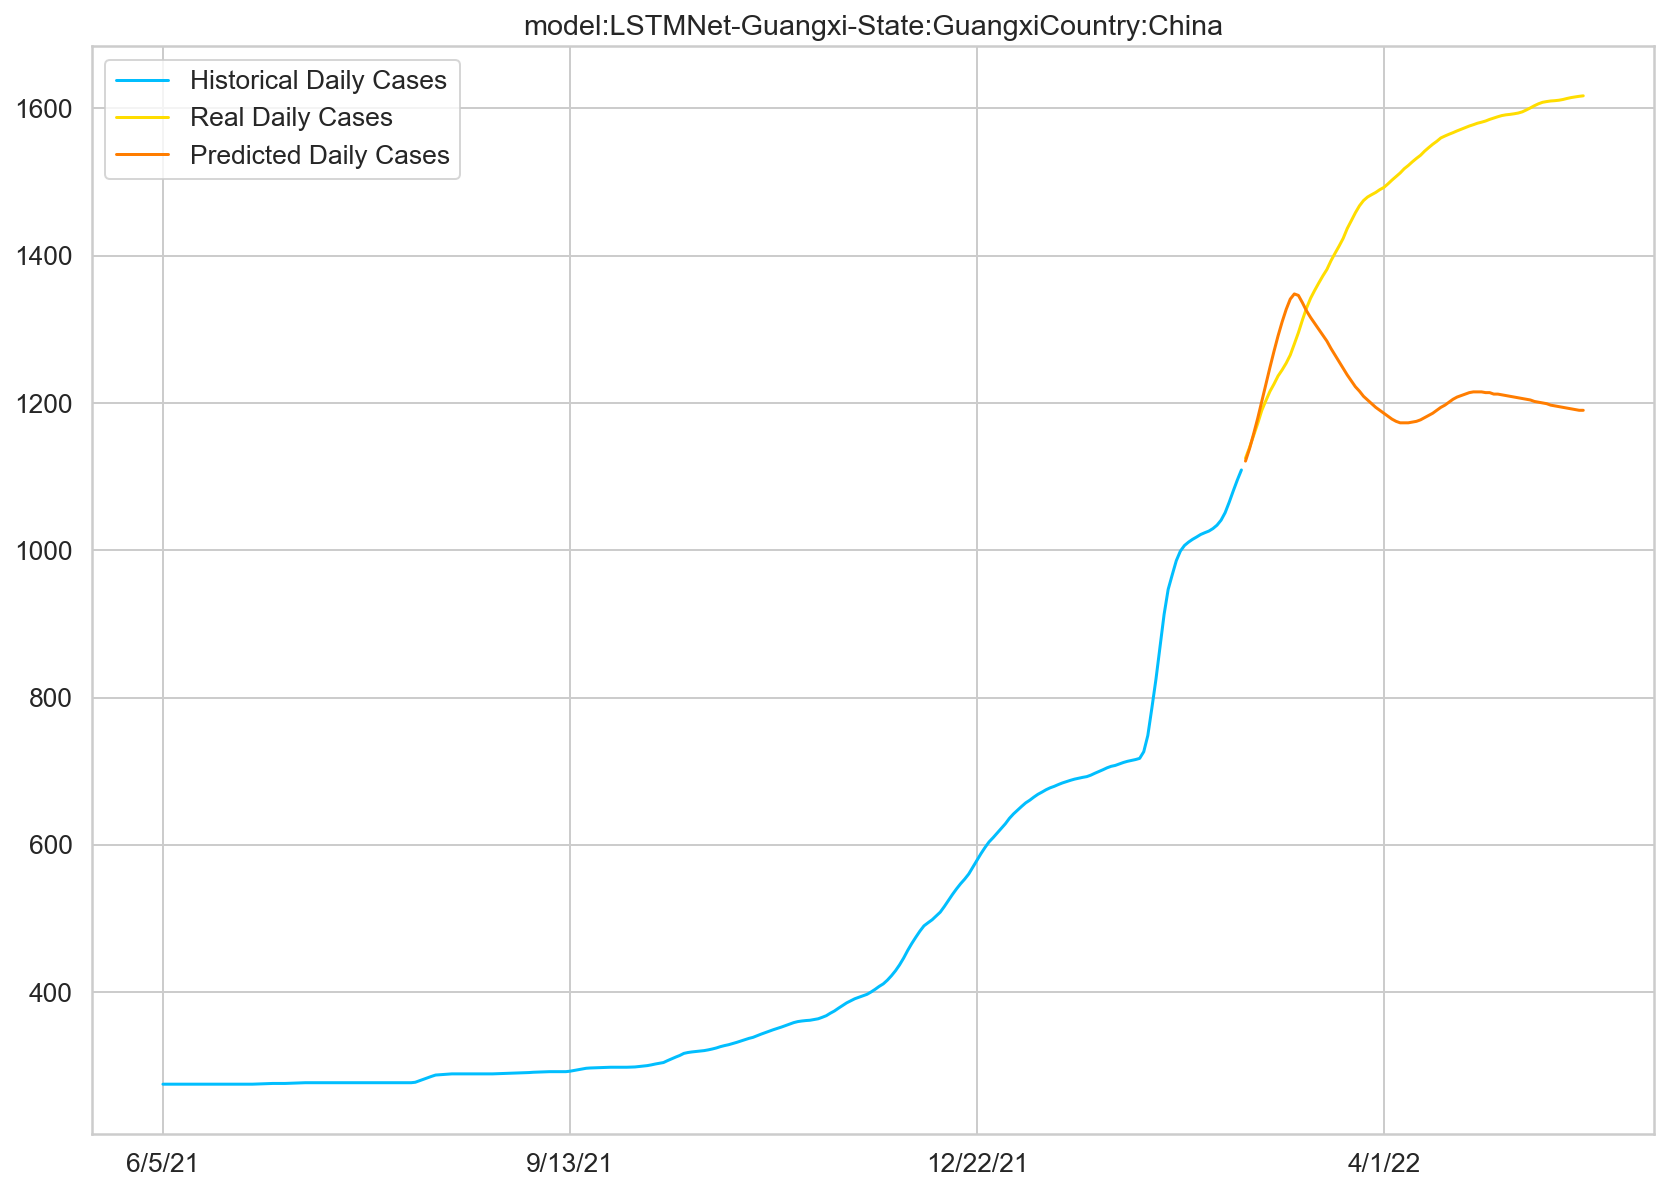

3.021861255168915
选择累计新增
Epoch 99 train loss: 0.322445809841156 test loss: 1.095856785774231
Epoch 199 train loss: 0.1272449642419815 test loss: 0.33026984333992004
Epoch 299 train loss: 0.06230269372463226 test loss: 0.12470968067646027
Epoch 399 train loss: 0.056922171264886856 test loss: 0.14546054601669312
Epoch 499 train loss: 0.05348080024123192 test loss: 0.1591719388961792
Epoch 599 train loss: 0.050564806908369064 test loss: 0.16500963270664215
266
84


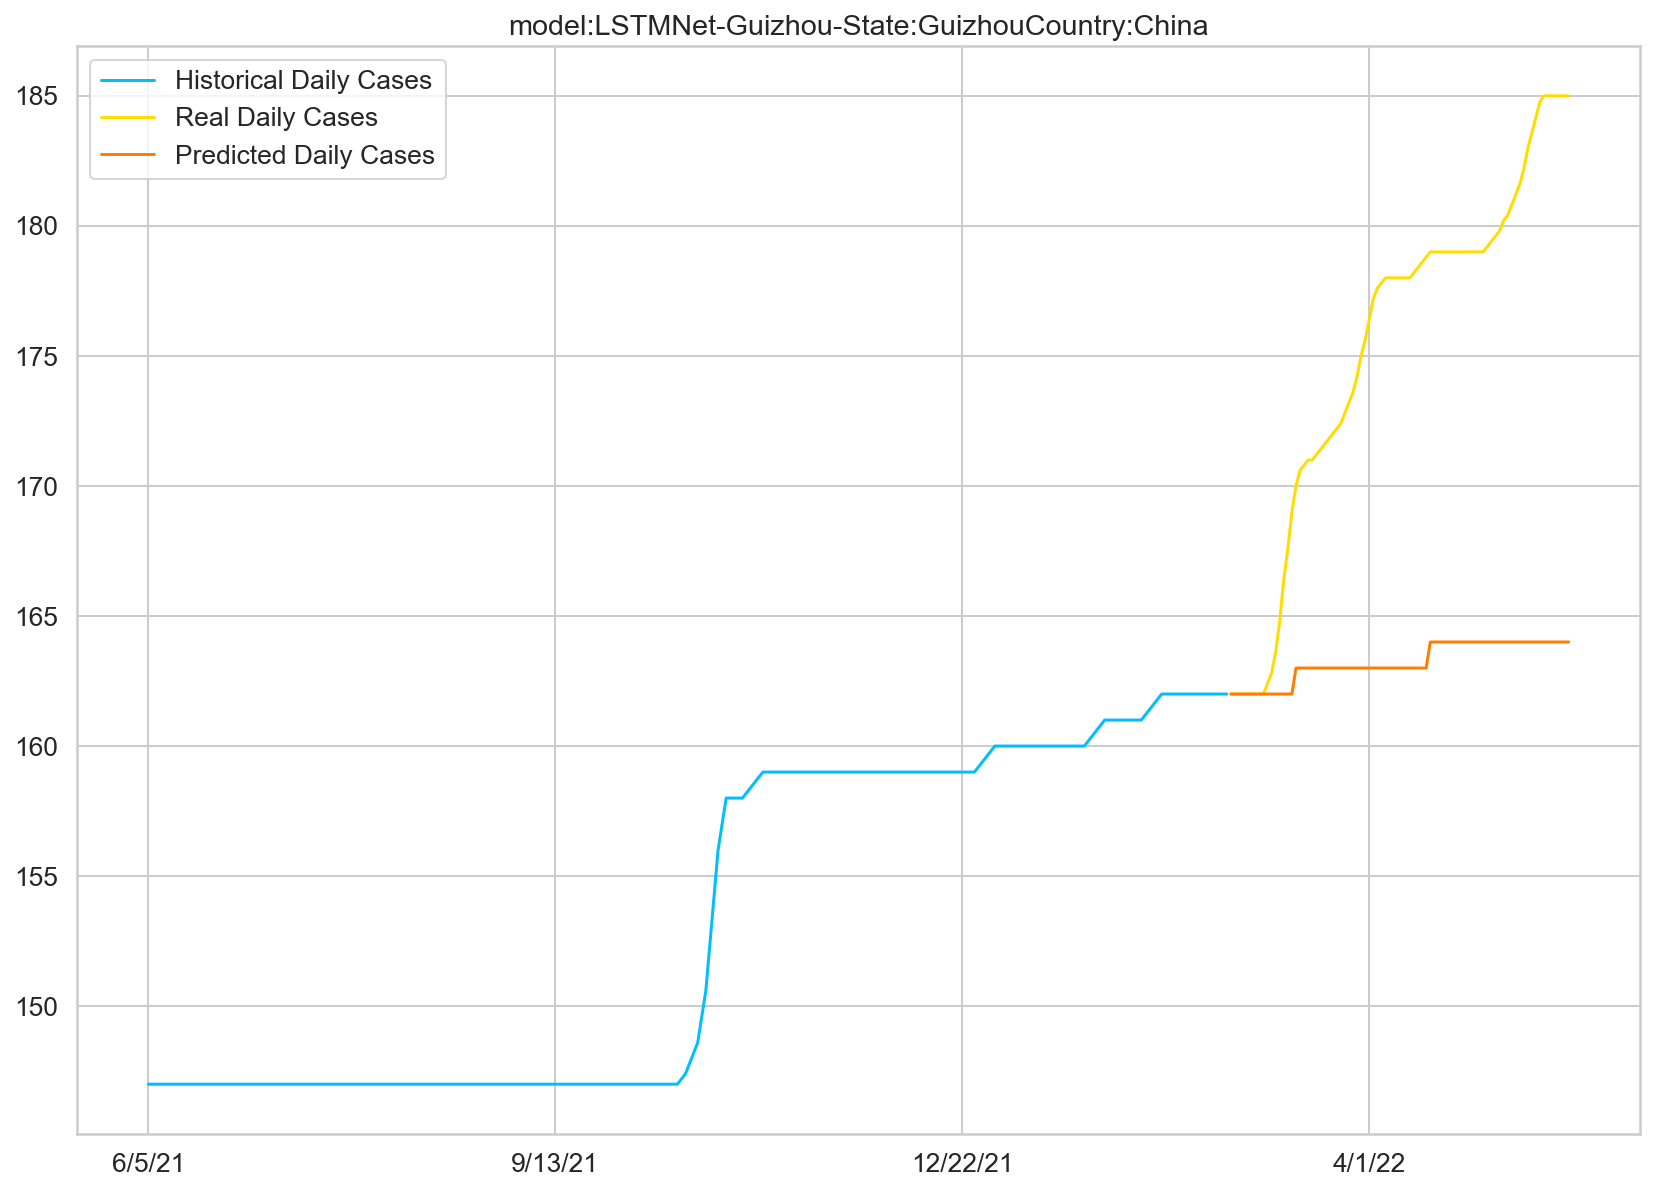

3.03223530848821
选择累计新增
Epoch 99 train loss: 0.1036958396434784 test loss: 3.014417886734009
Epoch 199 train loss: 0.0770663470029831 test loss: 2.412236452102661
Epoch 299 train loss: 0.06911048293113708 test loss: 2.2232203483581543
Epoch 399 train loss: 0.06552334129810333 test loss: 2.2250189781188965
Epoch 499 train loss: 0.0625152736902237 test loss: 2.2854597568511963
Epoch 599 train loss: 0.06008598208427429 test loss: 2.349865674972534
266
84


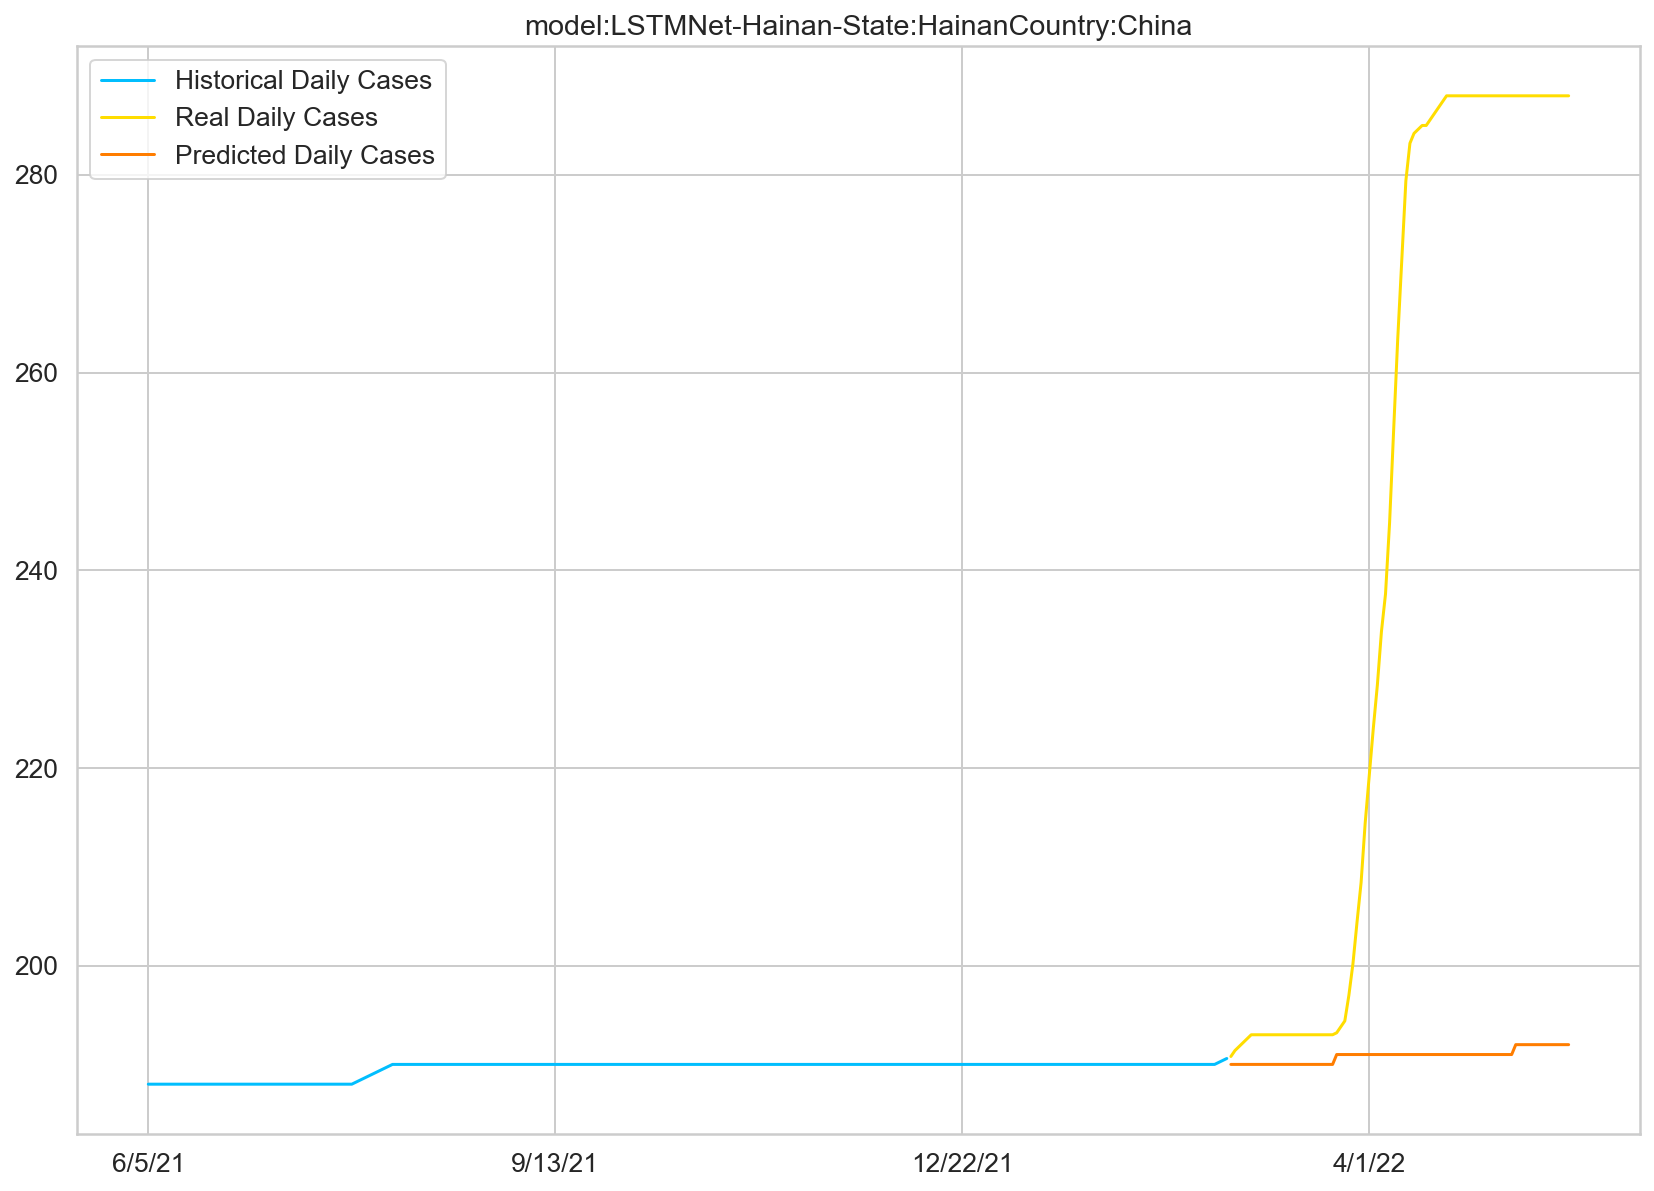

2.8493643760681153
选择累计新增
Epoch 99 train loss: 3.1347880363464355 test loss: 1.68736732006073
Epoch 199 train loss: 0.9433141350746155 test loss: 2.676661729812622
Epoch 299 train loss: 0.43200796842575073 test loss: 6.553679943084717
Epoch 399 train loss: 0.2821360230445862 test loss: 3.730883836746216
Epoch 499 train loss: 0.23077835142612457 test loss: 3.755948543548584
Epoch 599 train loss: 0.21105223894119263 test loss: 3.7059834003448486
266
84


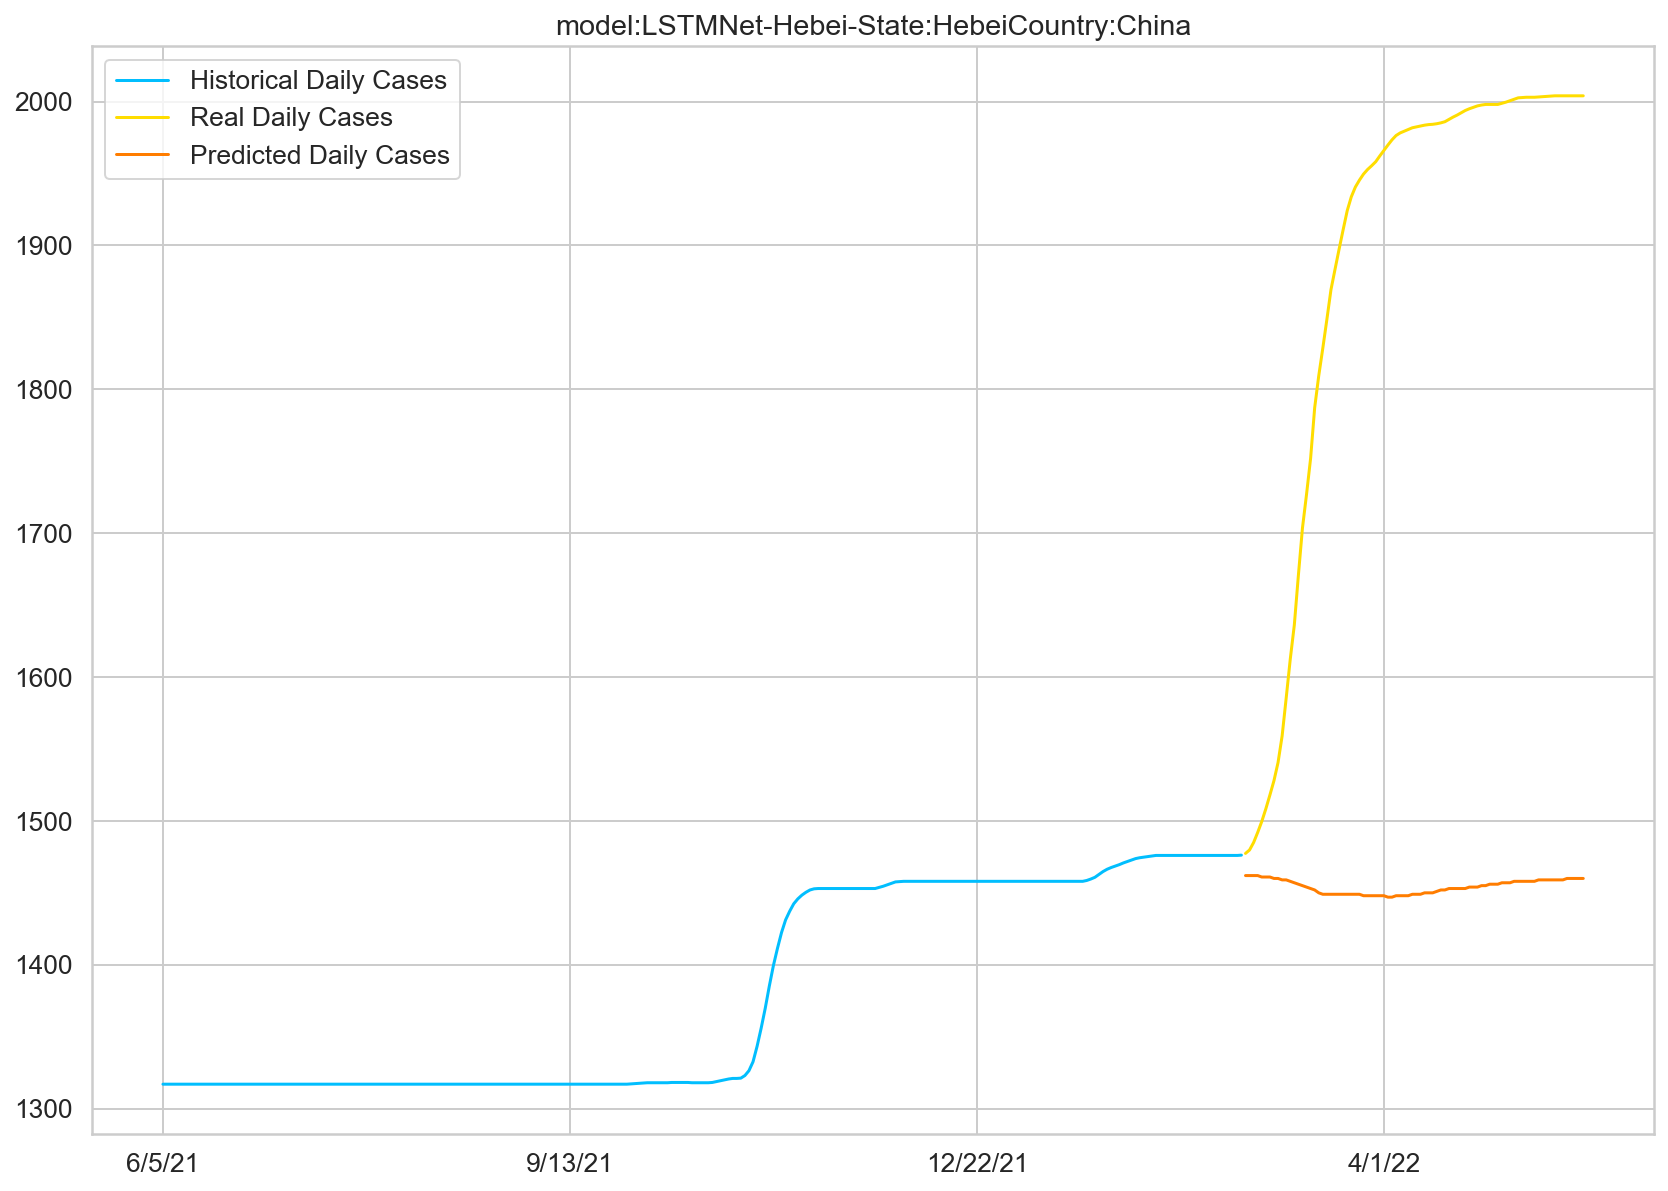

2.843113386631012
选择累计新增
Epoch 99 train loss: 2.1105384826660156 test loss: 6.482511043548584
Epoch 199 train loss: 0.6429284811019897 test loss: 2.362966299057007
Epoch 299 train loss: 0.43211615085601807 test loss: 3.0734121799468994
Epoch 399 train loss: 0.21570733189582825 test loss: 2.5578131675720215
Epoch 499 train loss: 0.15560483932495117 test loss: 2.2963898181915283
Epoch 599 train loss: 0.1331484466791153 test loss: 2.1026437282562256
266
84


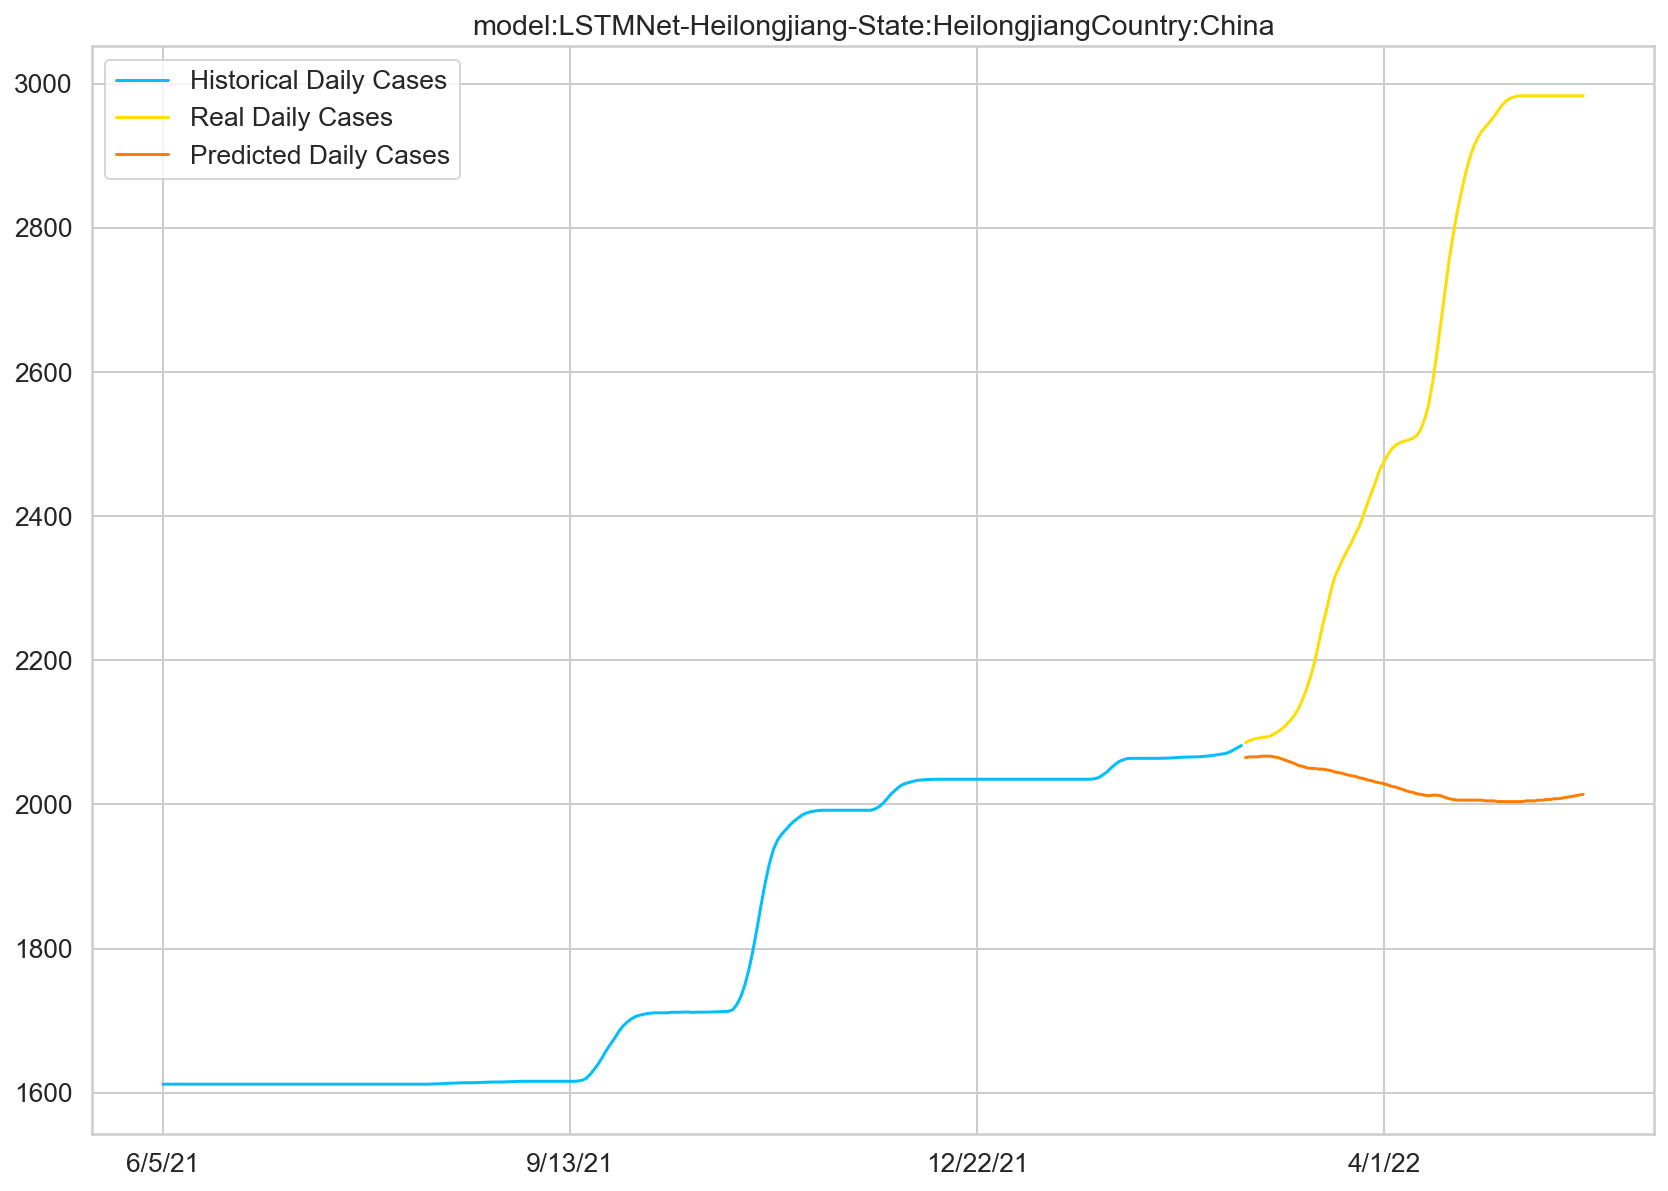

2.844455432891846
选择累计新增
Epoch 99 train loss: 0.7424827218055725 test loss: 0.6490864753723145
Epoch 199 train loss: 0.2910120487213135 test loss: 0.19371983408927917
Epoch 299 train loss: 0.1368532031774521 test loss: 0.5557345747947693
Epoch 399 train loss: 0.08490779250860214 test loss: 0.7328049540519714
Epoch 499 train loss: 0.062331750988960266 test loss: 0.8086637258529663
Epoch 599 train loss: 0.0472308024764061 test loss: 0.7230456471443176
266
84


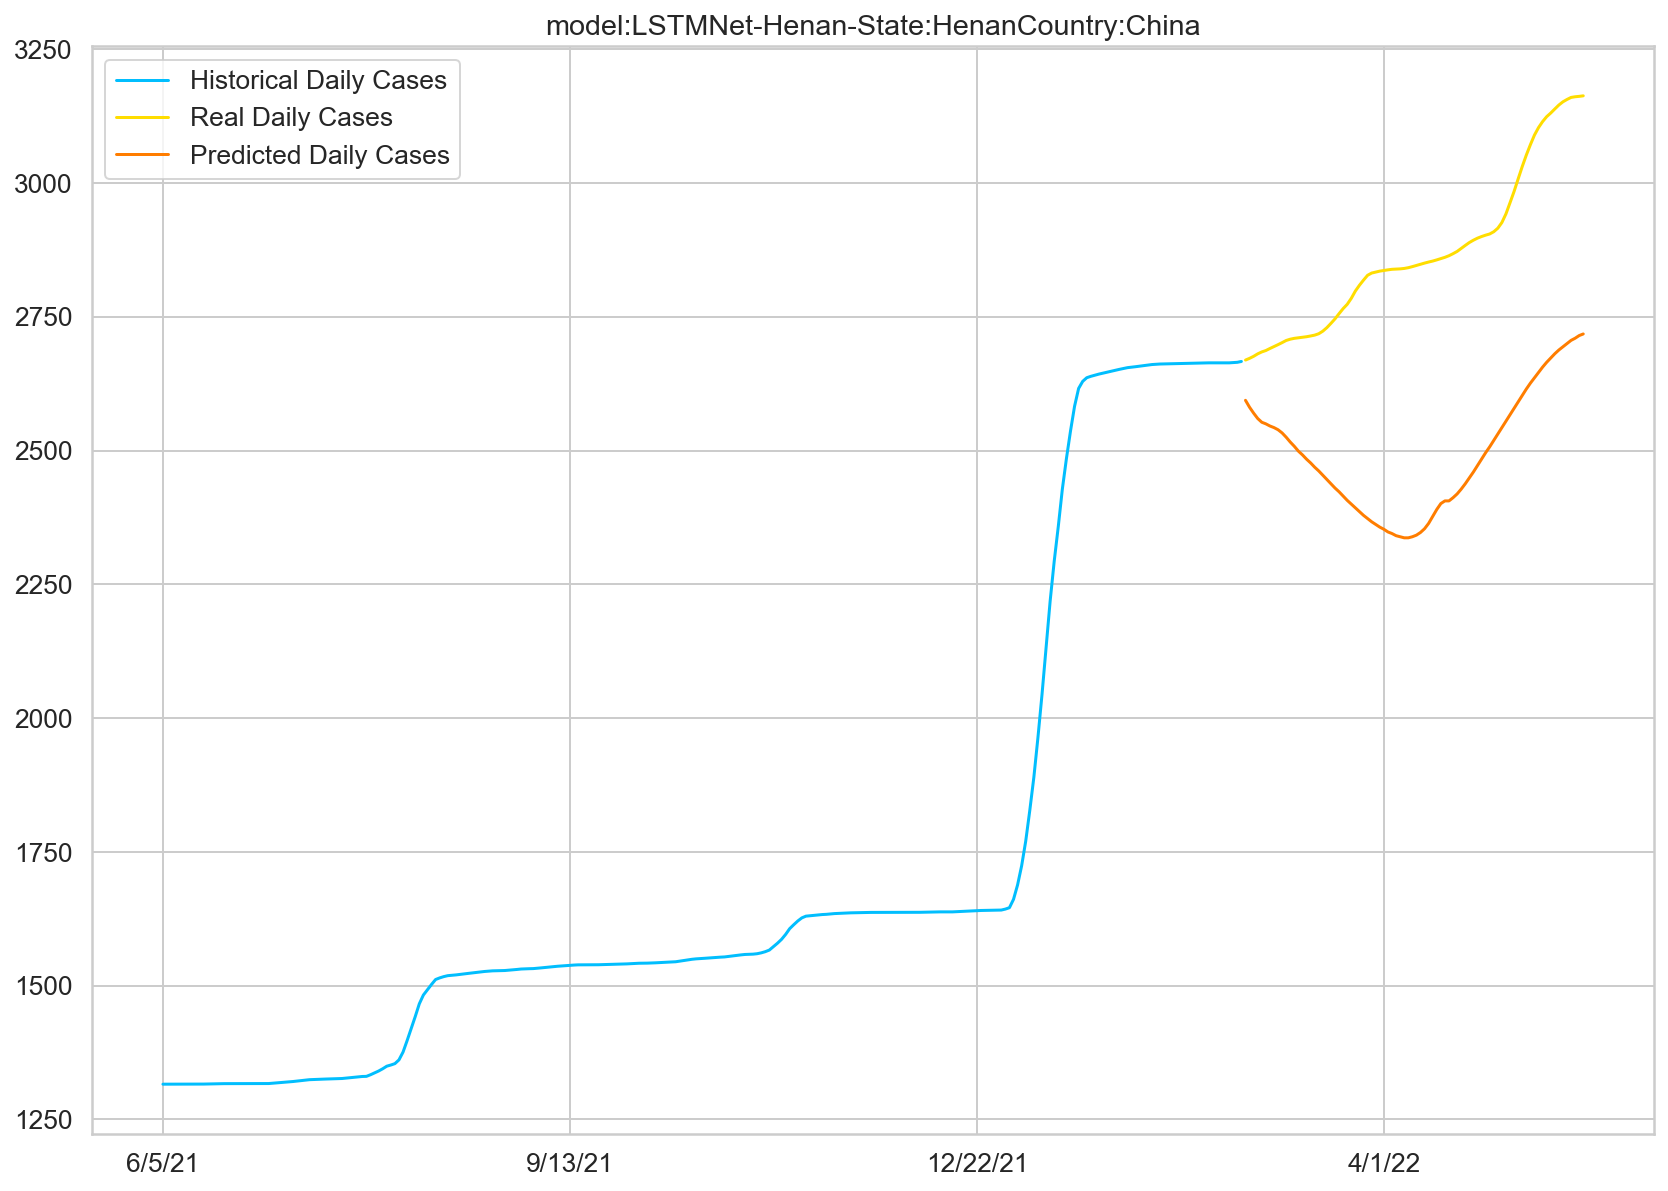

2.8425623496373493
选择累计新增
Epoch 99 train loss: 0.1548595130443573 test loss: 0.1526796966791153
Epoch 199 train loss: 0.0806284248828888 test loss: 0.22290173172950745
Epoch 299 train loss: 0.06760778278112411 test loss: 0.2873164415359497
Epoch 399 train loss: 0.055890265852212906 test loss: 0.3037409484386444
Epoch 499 train loss: 0.046400509774684906 test loss: 0.302709698677063
Epoch 599 train loss: 0.03927582502365112 test loss: 0.3112942576408386
266
84


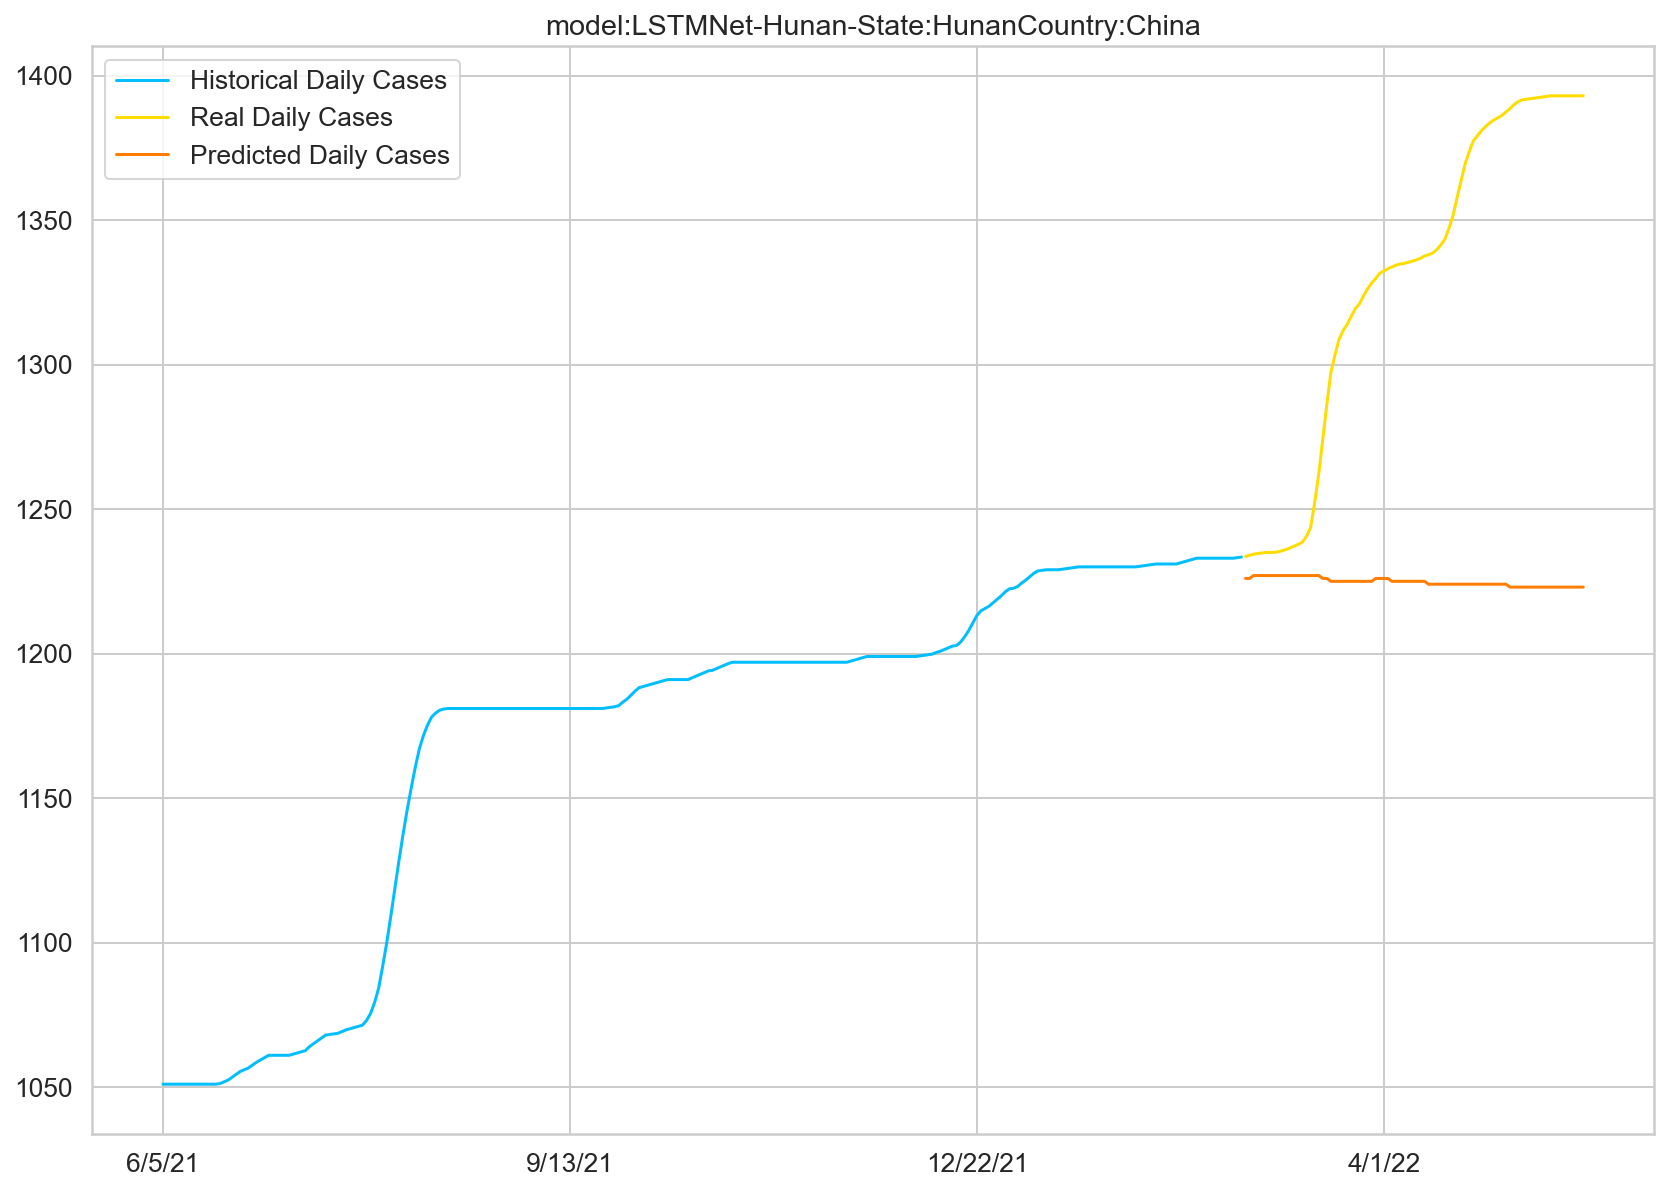

2.828280878067017
选择累计新增
Epoch 99 train loss: 0.4780351519584656 test loss: 1.472165822982788
Epoch 199 train loss: 0.31864413619041443 test loss: 3.4005351066589355
Epoch 299 train loss: 0.2944108247756958 test loss: 4.703394412994385
Epoch 399 train loss: 0.23603834211826324 test loss: 4.227778434753418
Epoch 499 train loss: 0.20742592215538025 test loss: 3.3485608100891113
Epoch 599 train loss: 0.18673290312290192 test loss: 1.8799238204956055
266
84


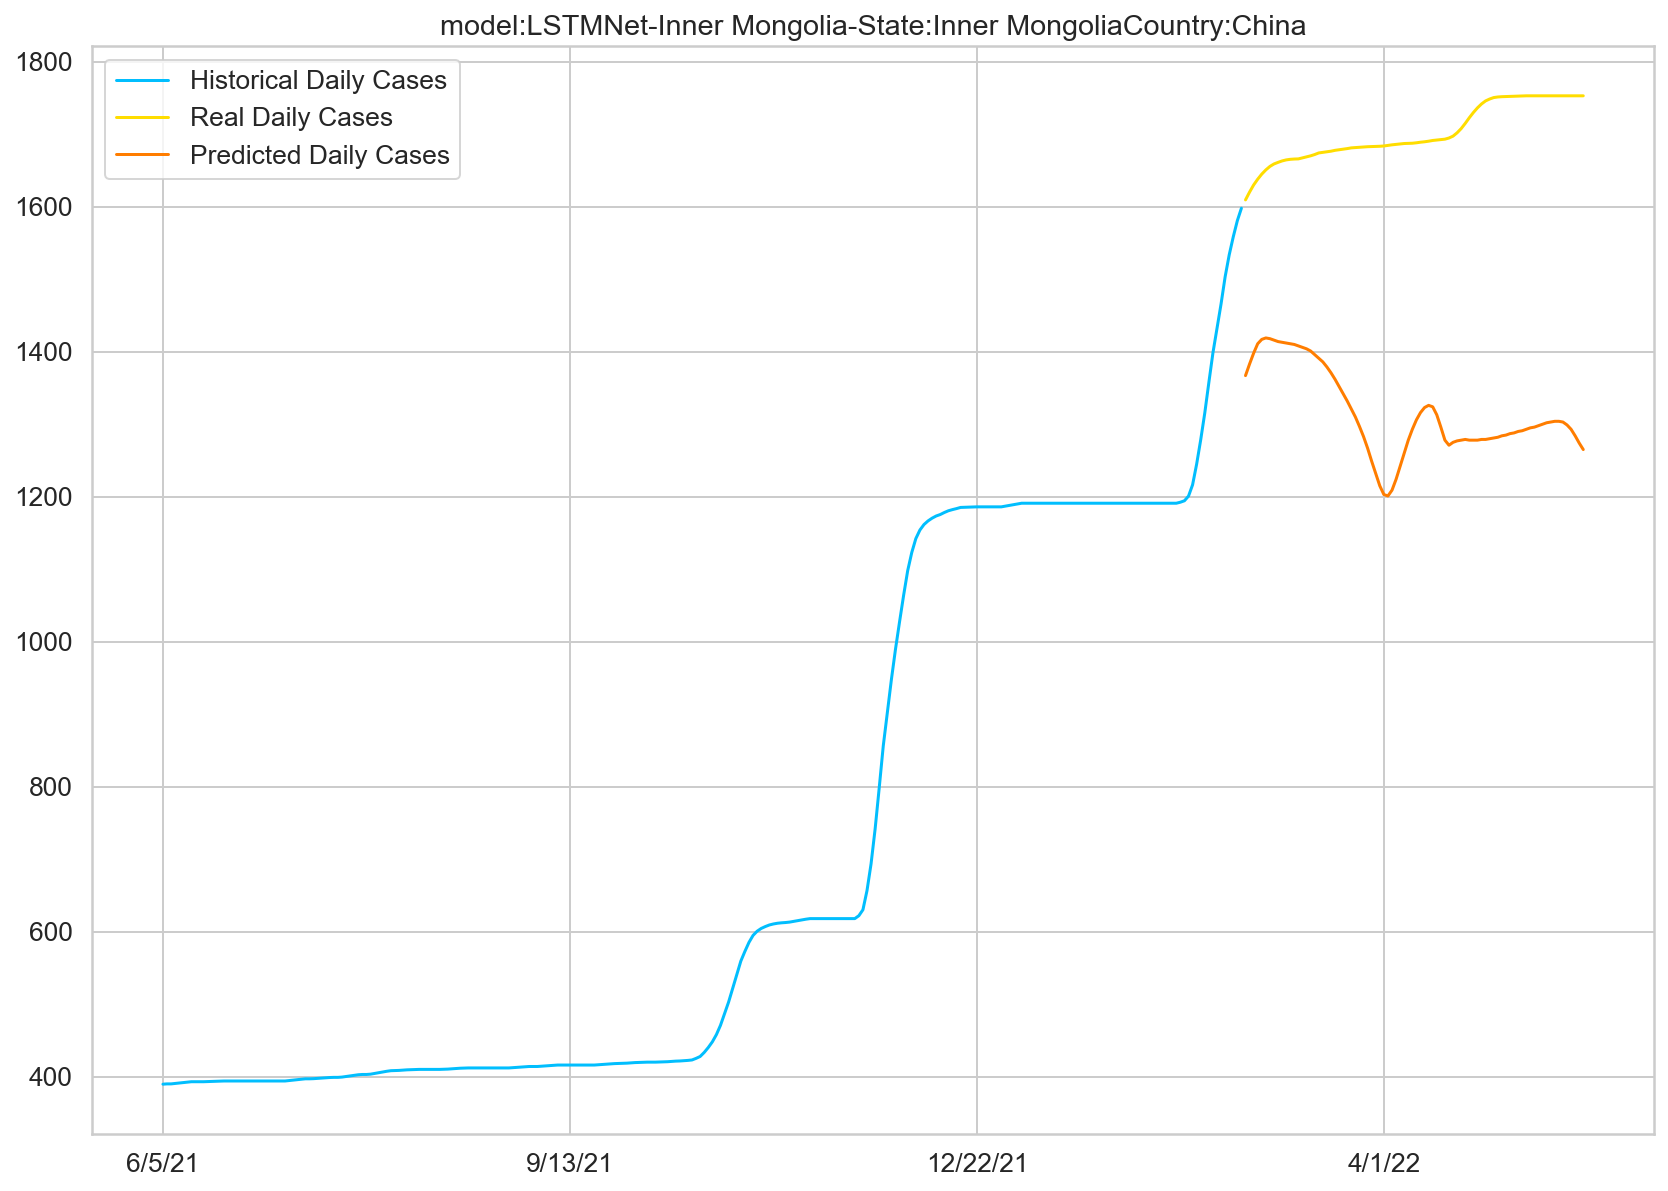

2.8368048469225564
选择累计新增
Epoch 99 train loss: 0.07164117693901062 test loss: 0.7109741568565369
Epoch 199 train loss: 0.049509212374687195 test loss: 0.623104453086853
Epoch 299 train loss: 0.040750328451395035 test loss: 0.49335169792175293
Epoch 399 train loss: 0.0355144627392292 test loss: 0.38963401317596436
Epoch 499 train loss: 0.03232200816273689 test loss: 0.32326510548591614
Epoch 599 train loss: 0.030408071354031563 test loss: 0.27745410799980164
266
84


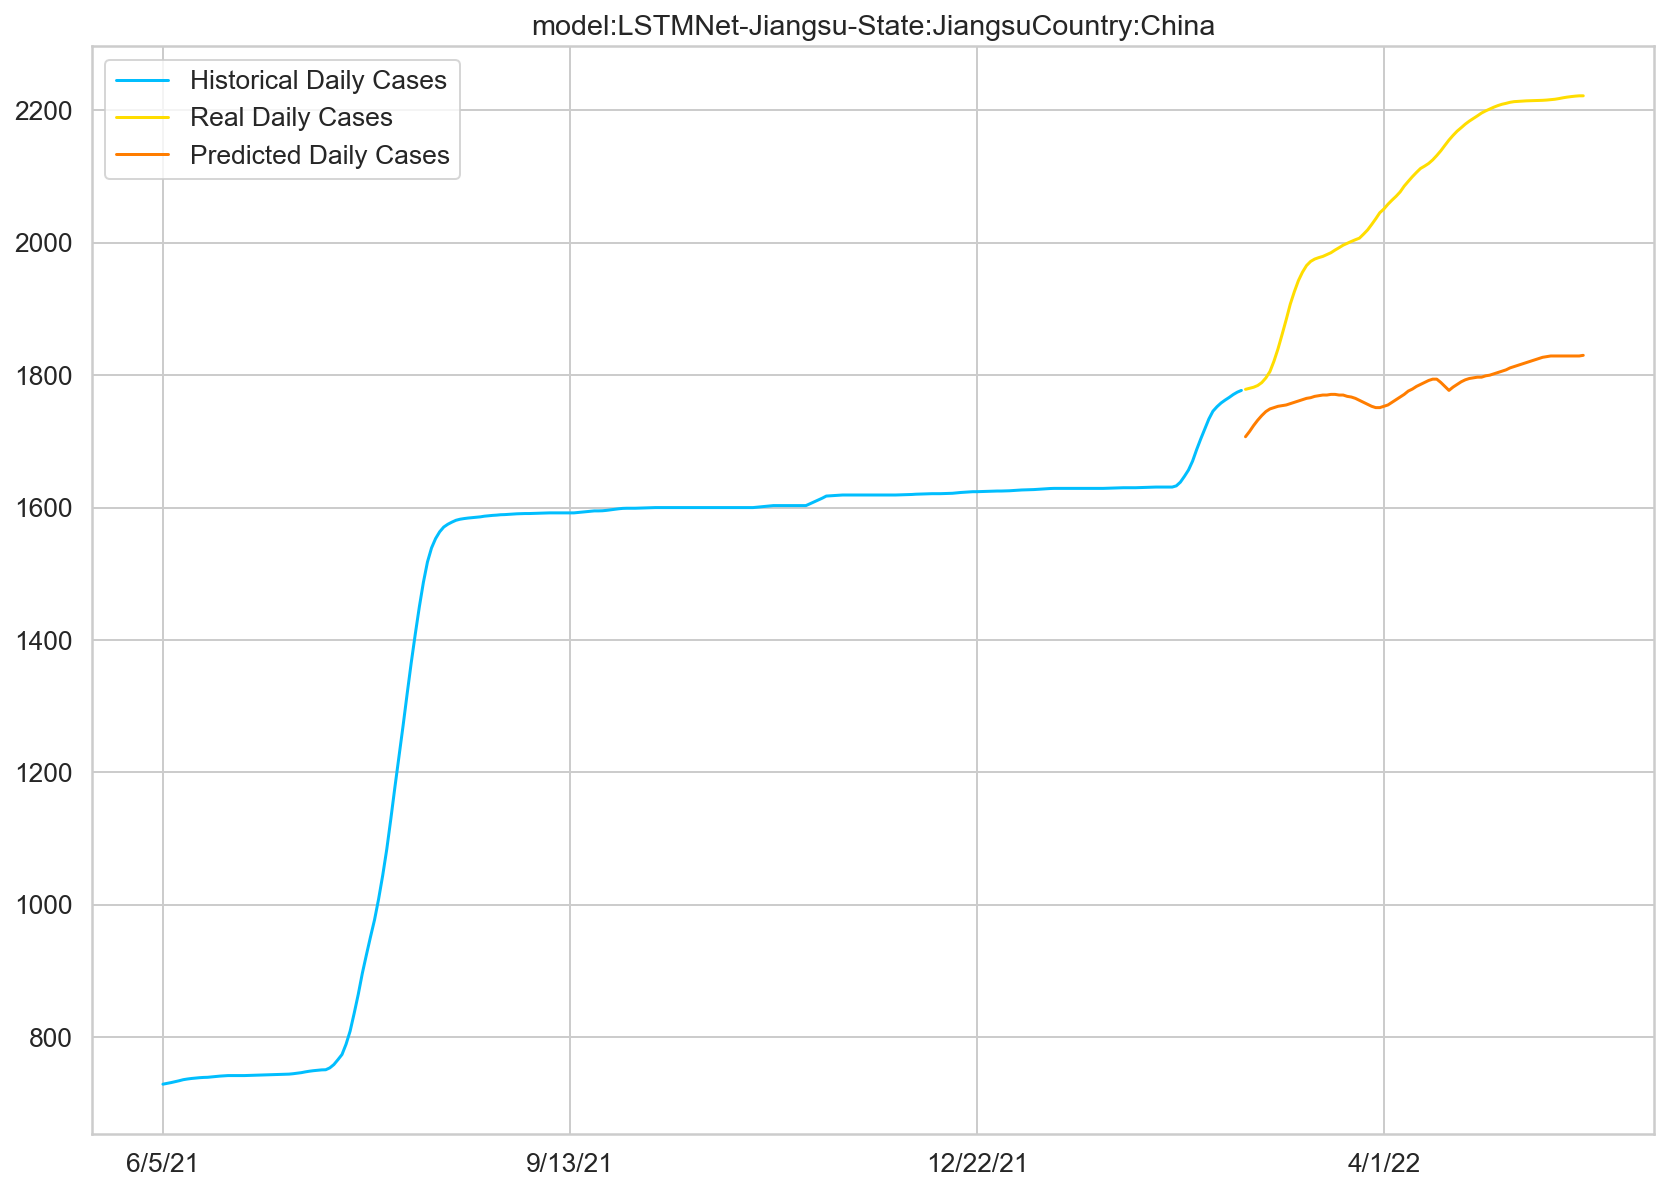

2.8386479020118713
选择累计新增
Epoch 99 train loss: 0.053027793765068054 test loss: 2.5794692039489746
Epoch 199 train loss: 0.03159775212407112 test loss: 2.6675188541412354
Epoch 299 train loss: 0.02384294383227825 test loss: 2.706130266189575
Epoch 399 train loss: 0.022131606936454773 test loss: 2.703843116760254
Epoch 499 train loss: 0.021391626447439194 test loss: 2.6860122680664062
Epoch 599 train loss: 0.02085818536579609 test loss: 2.66668438911438
266
84


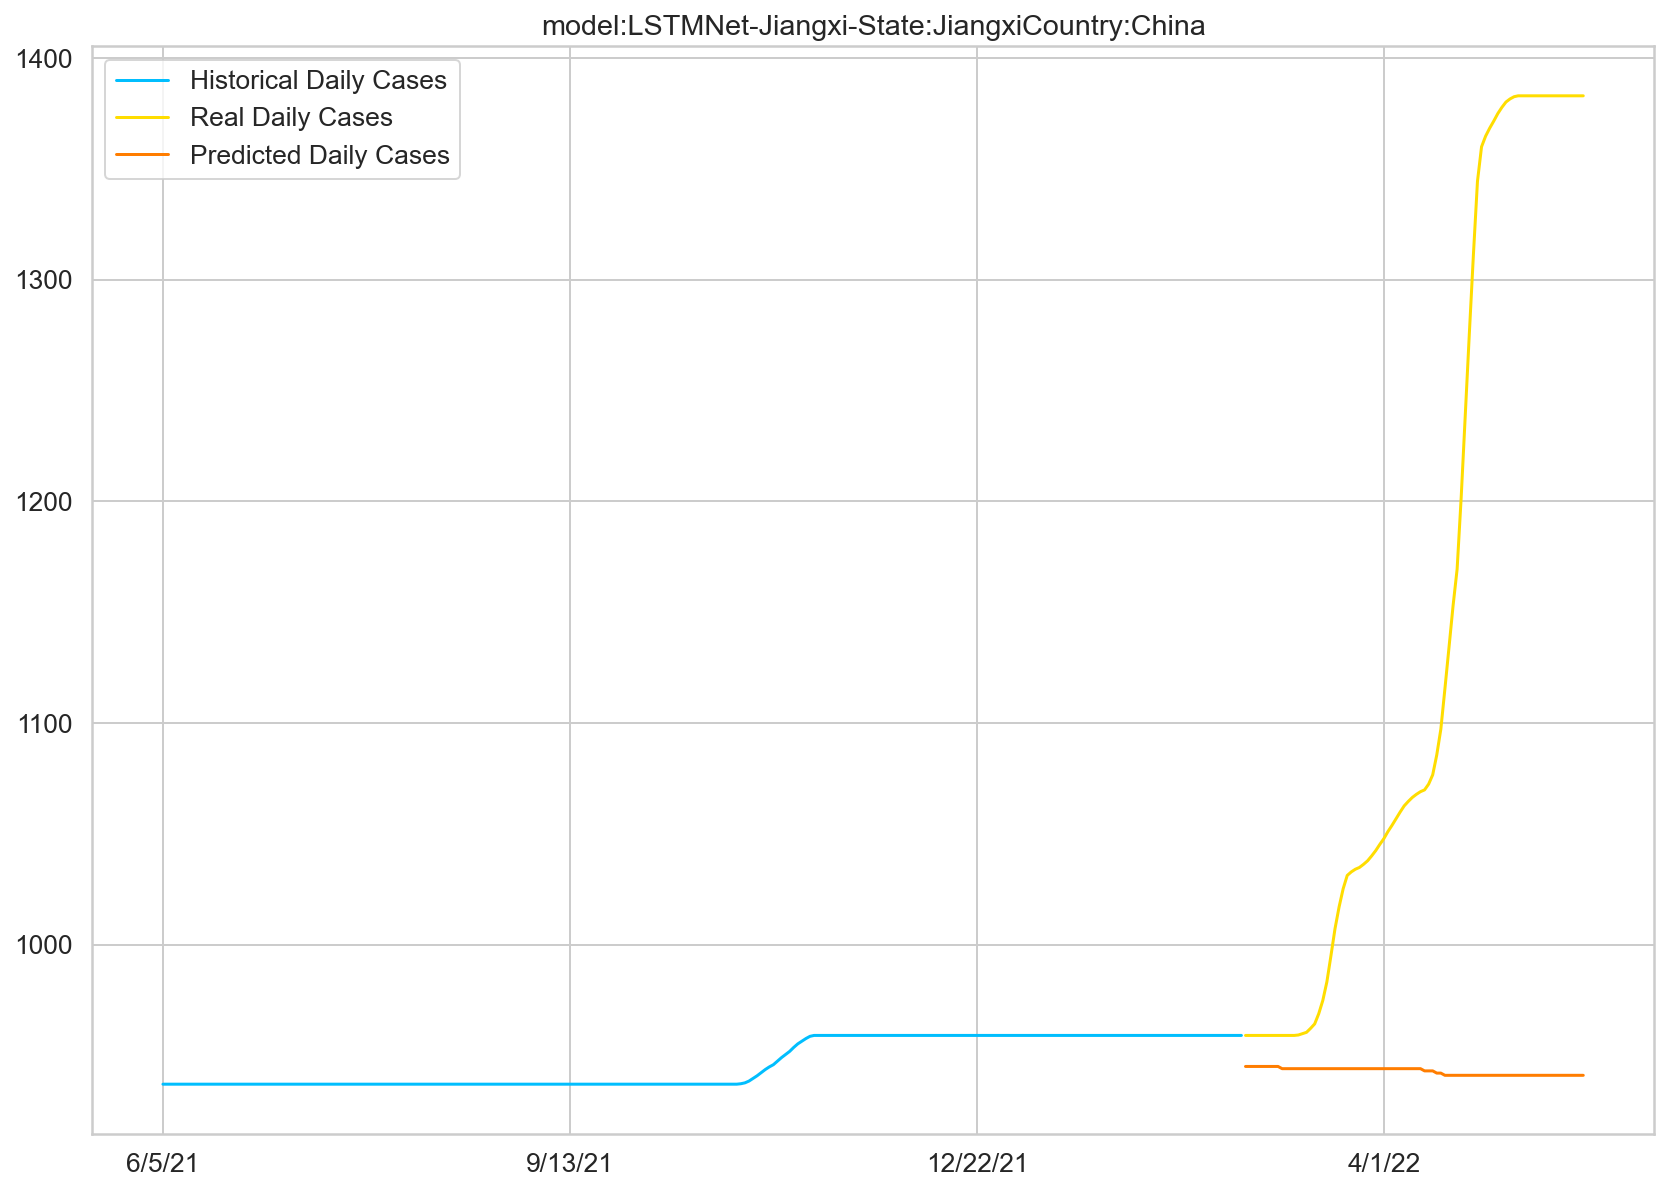

2.828456441561381
选择累计新增
Epoch 99 train loss: 0.0851665735244751 test loss: 26.08403205871582
Epoch 199 train loss: 0.0851665735244751 test loss: 26.0847225189209
Epoch 299 train loss: 0.0851665735244751 test loss: 26.0847225189209
Epoch 399 train loss: 0.0851665735244751 test loss: 26.0847225189209
Epoch 499 train loss: 0.0851665735244751 test loss: 26.0847225189209
Epoch 599 train loss: 0.0851665735244751 test loss: 26.0847225189209
266
84


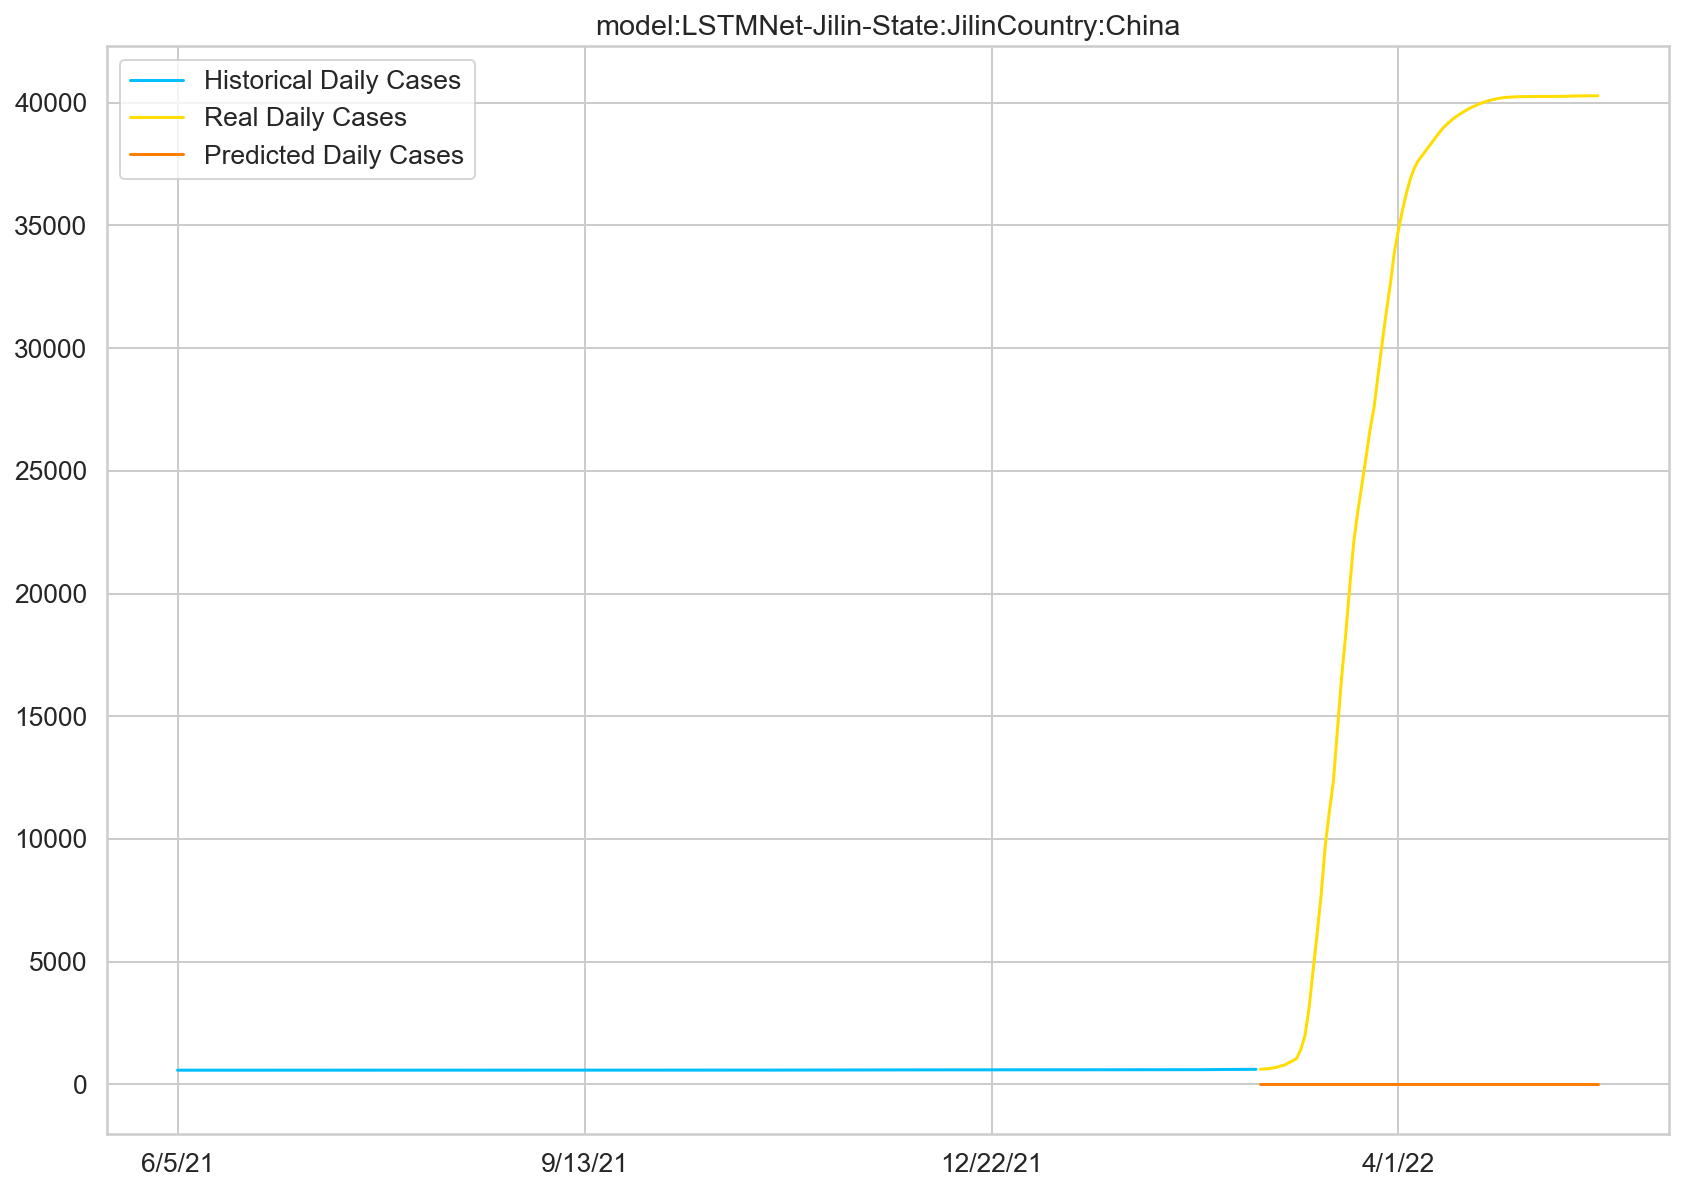

2.8372897028923036
选择累计新增
Epoch 99 train loss: 0.37494751811027527 test loss: 6.576919078826904
Epoch 199 train loss: 0.24420210719108582 test loss: 3.8430306911468506
Epoch 299 train loss: 0.17608314752578735 test loss: 4.366047382354736
Epoch 399 train loss: 0.14079521596431732 test loss: 4.298848628997803
Epoch 499 train loss: 0.11634965986013412 test loss: 3.2994091510772705
Epoch 599 train loss: 0.10162749886512756 test loss: 2.3836870193481445
266
84


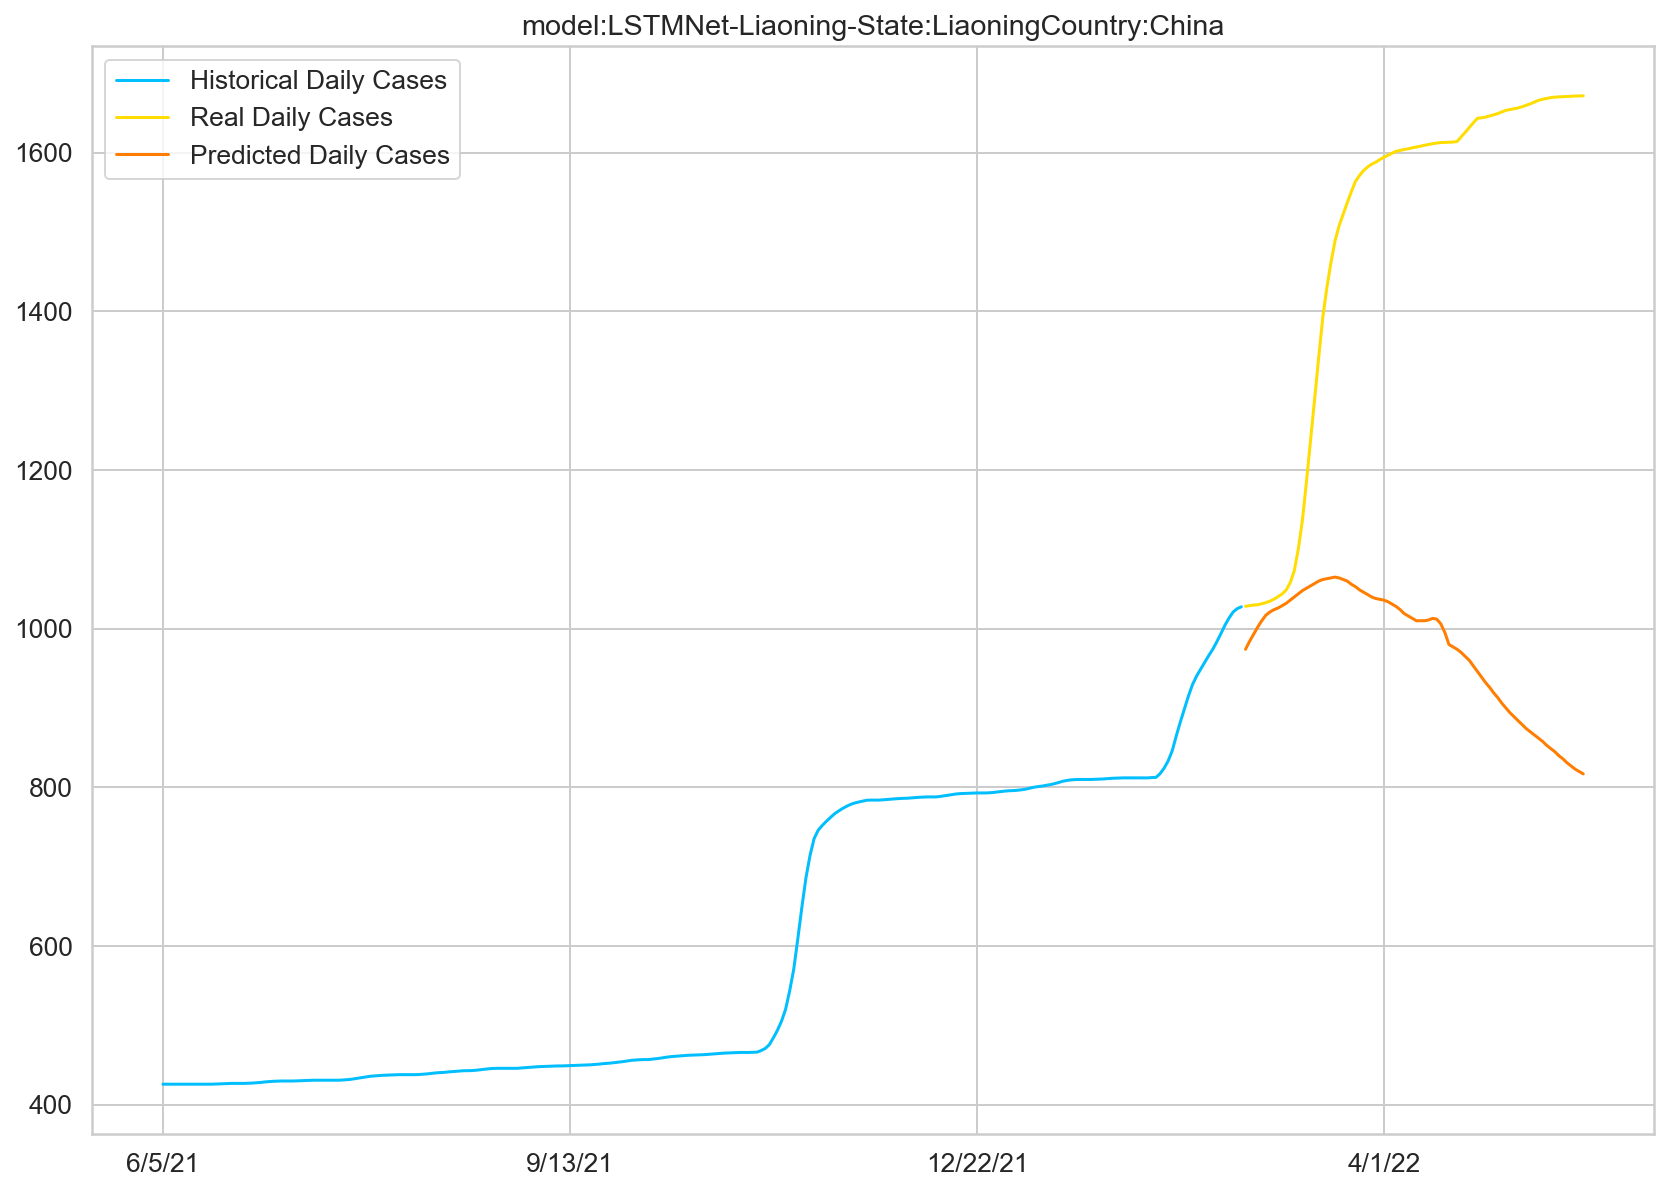

2.8388203382492065
选择累计新增
Epoch 99 train loss: 0.8895029425621033 test loss: 0.06367960572242737
Epoch 199 train loss: 0.4272952377796173 test loss: 0.022519735619425774
Epoch 299 train loss: 0.3277356028556824 test loss: 0.06541123986244202
Epoch 399 train loss: 0.11184502393007278 test loss: 0.03824682533740997
Epoch 499 train loss: 0.06672759354114532 test loss: 0.05761655420064926
Epoch 599 train loss: 0.06299179792404175 test loss: 0.0583791583776474
266
84


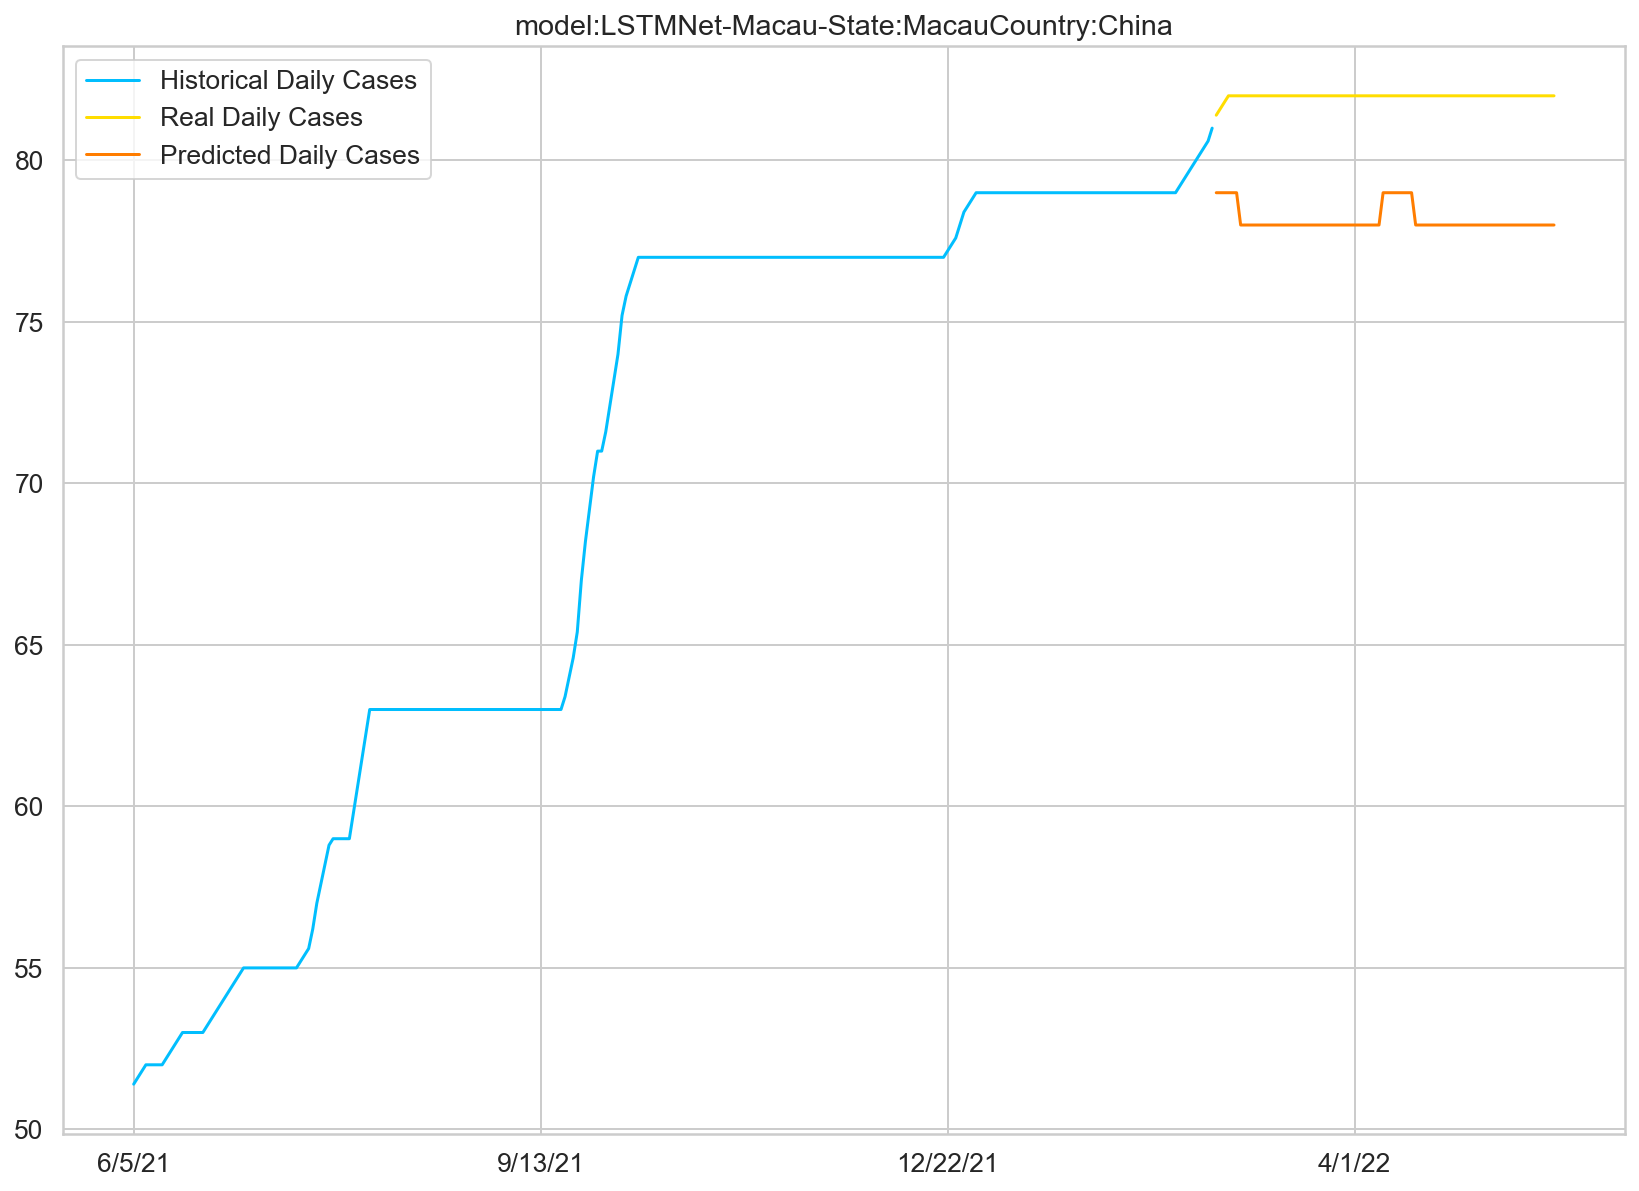

2.834355382124583
选择累计新增
Epoch 99 train loss: 0.38931015133857727 test loss: 0.001190107548609376
Epoch 199 train loss: 0.1633344292640686 test loss: 0.0003769629984162748
Epoch 299 train loss: 0.0826222375035286 test loss: 0.0001526679698145017
Epoch 399 train loss: 0.05743194743990898 test loss: 4.584189082379453e-05
Epoch 499 train loss: 0.048731520771980286 test loss: 0.0001108851283788681
Epoch 599 train loss: 0.042940057814121246 test loss: 2.531388076931762e-07
266
84


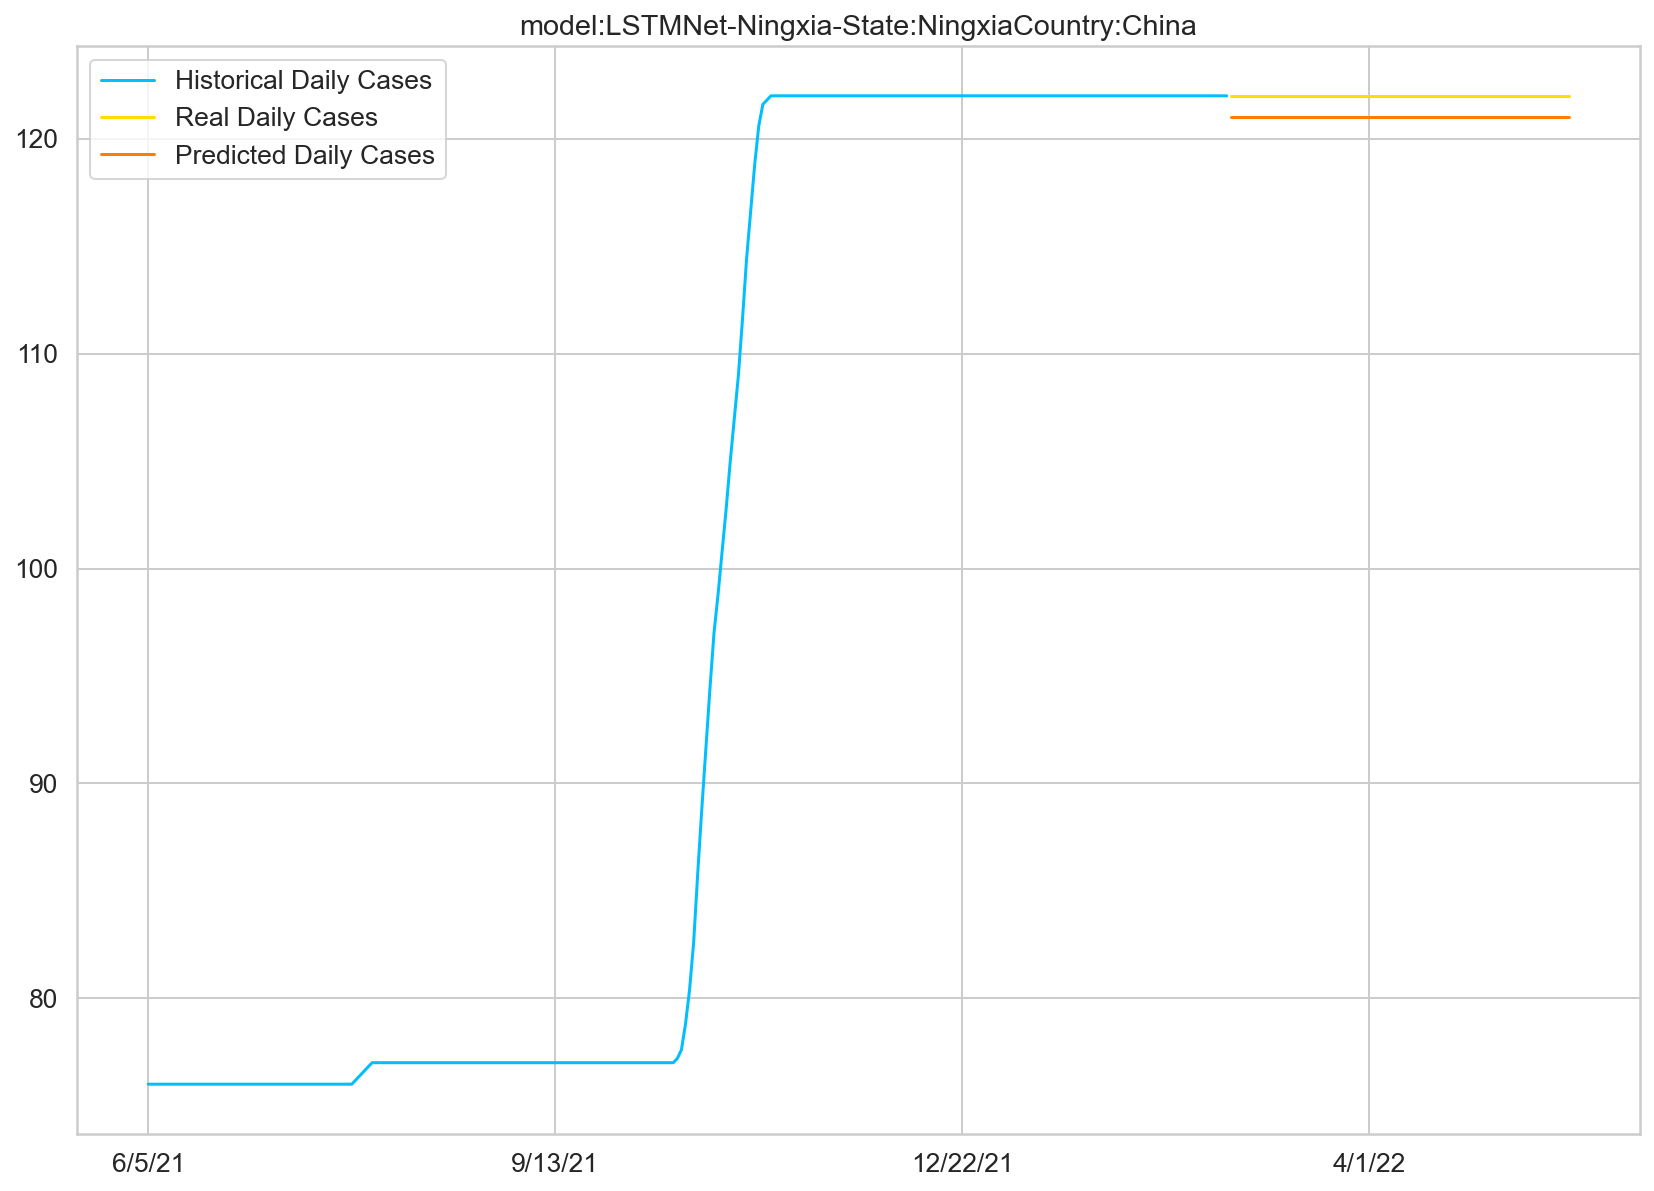

2.8792550643285115
选择累计新增
Epoch 99 train loss: 0.12172533571720123 test loss: 10.881305694580078
Epoch 199 train loss: 0.04885989800095558 test loss: 5.2715559005737305
Epoch 299 train loss: 0.018868573009967804 test loss: 4.622378349304199
Epoch 399 train loss: 0.015157471410930157 test loss: 4.492640495300293
Epoch 499 train loss: 0.012749169953167439 test loss: 4.565494537353516
Epoch 599 train loss: 0.011108390055596828 test loss: 4.711592674255371
266
84


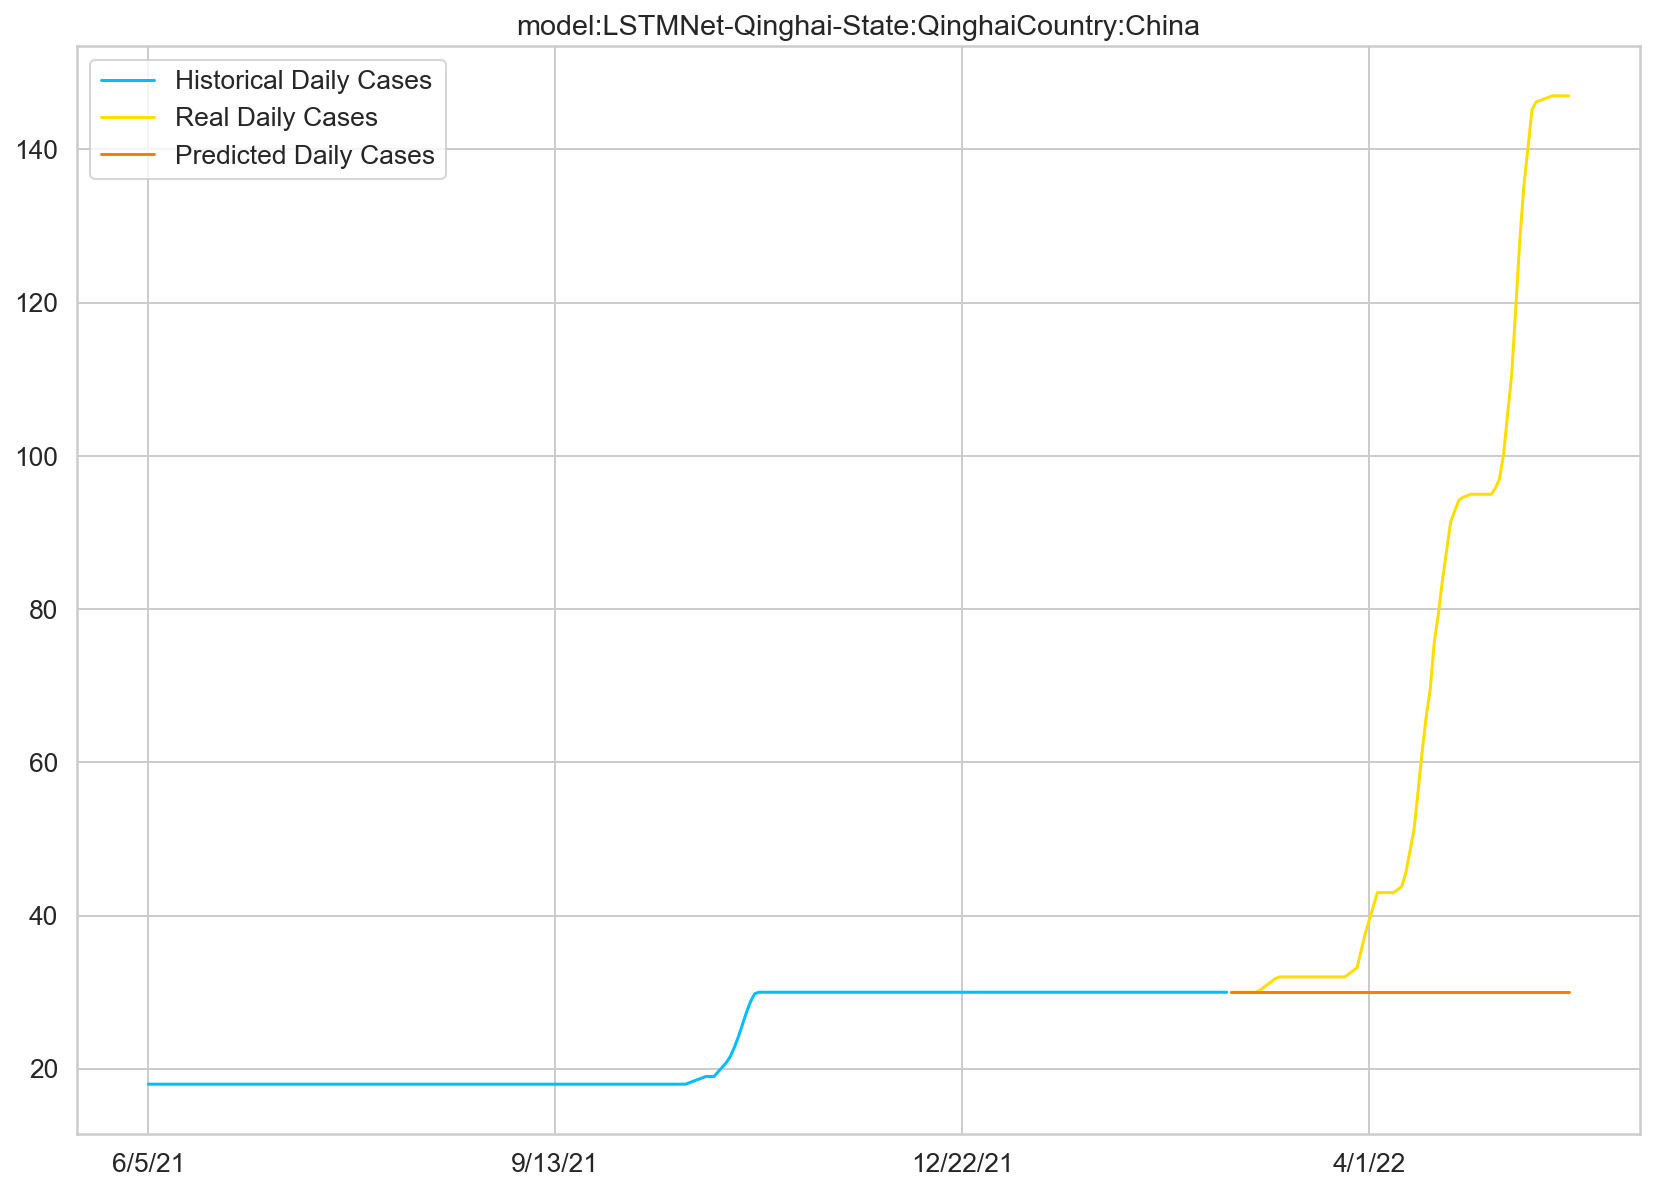

2.945445962746938
选择累计新增
Epoch 99 train loss: 0.14738920331001282 test loss: 0.397470086812973
Epoch 199 train loss: 0.032542884349823 test loss: 0.8393611311912537
Epoch 299 train loss: 0.013180678710341454 test loss: 0.8057146668434143
Epoch 399 train loss: 0.00936040934175253 test loss: 0.854780375957489
Epoch 499 train loss: 0.007980410940945148 test loss: 0.9022635221481323
Epoch 599 train loss: 0.007151772268116474 test loss: 0.9333698749542236
266
84


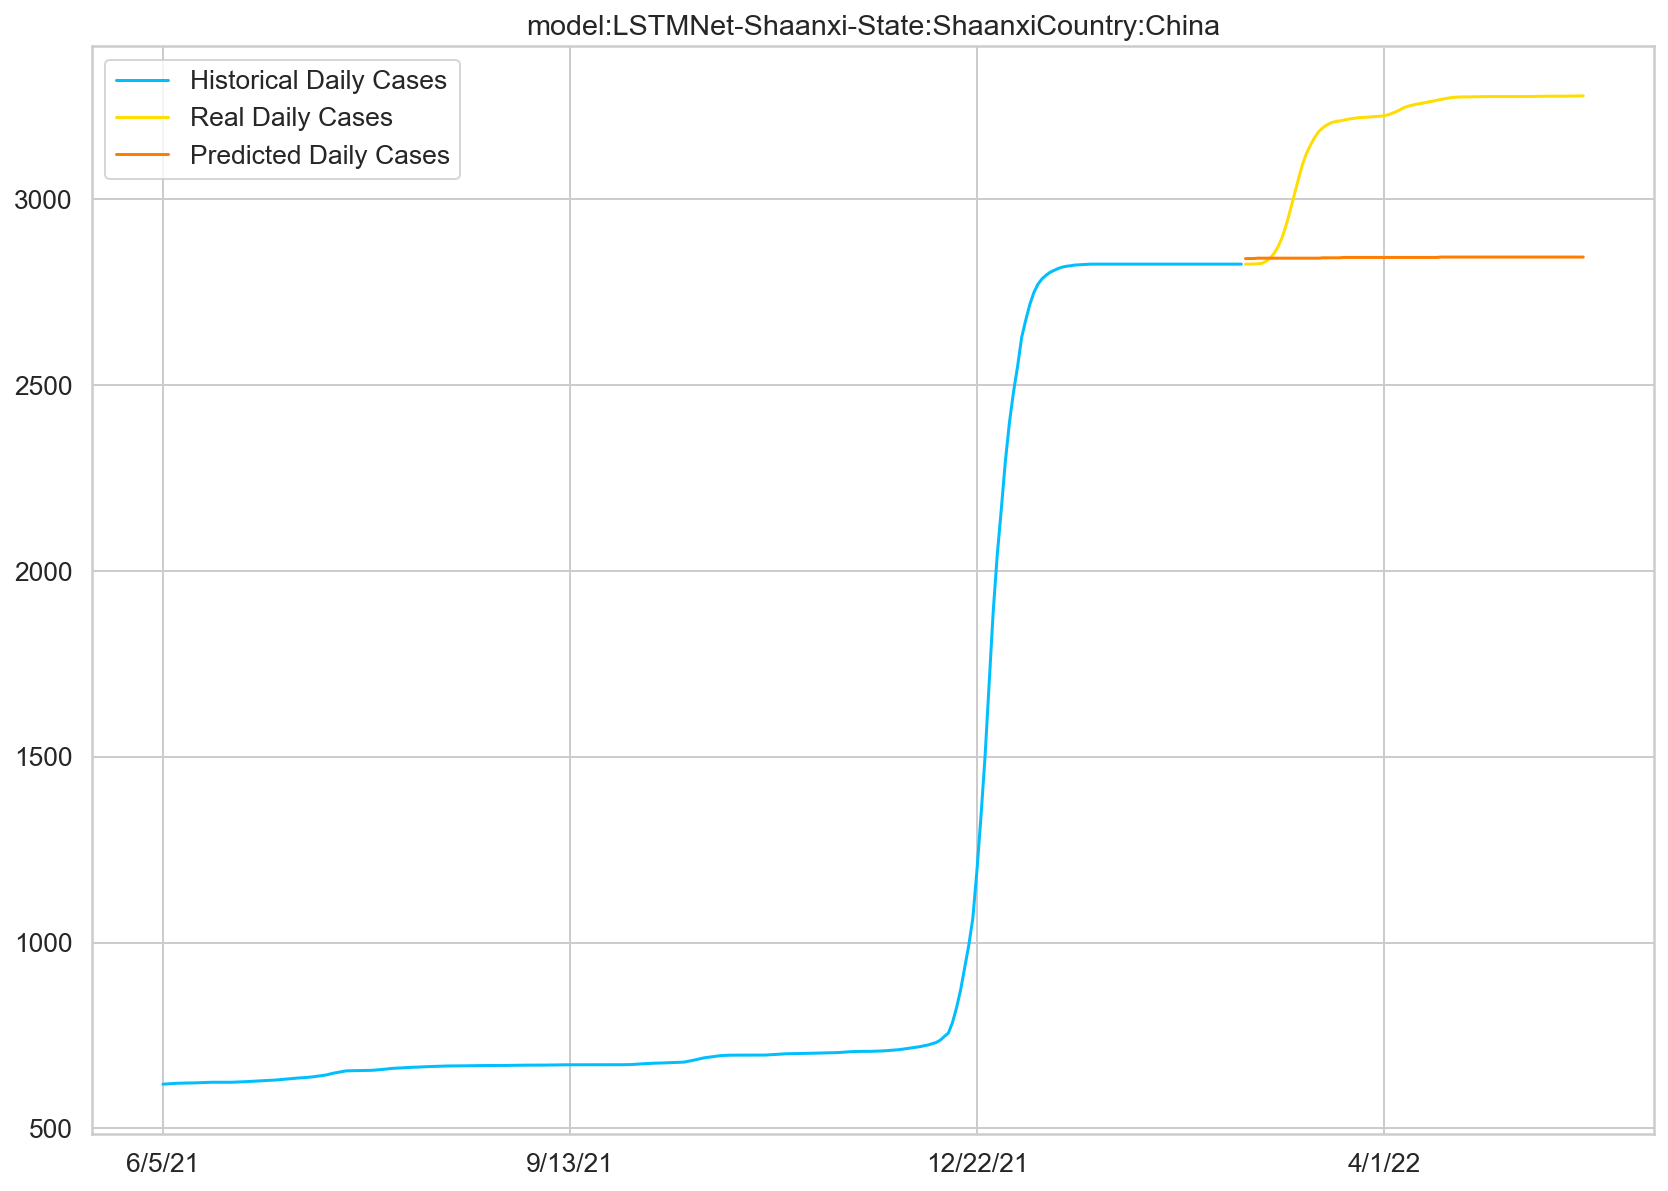

3.1903590162595115
选择累计新增
Epoch 99 train loss: 0.014475875534117222 test loss: 13.512006759643555
Epoch 199 train loss: 0.007491733878850937 test loss: 12.171529769897461
Epoch 299 train loss: 0.0060115475207567215 test loss: 11.620376586914062
Epoch 399 train loss: 0.005374482832849026 test loss: 11.468711853027344
Epoch 499 train loss: 0.005064840894192457 test loss: 11.408909797668457
Epoch 599 train loss: 0.004890867043286562 test loss: 11.378326416015625
266
84


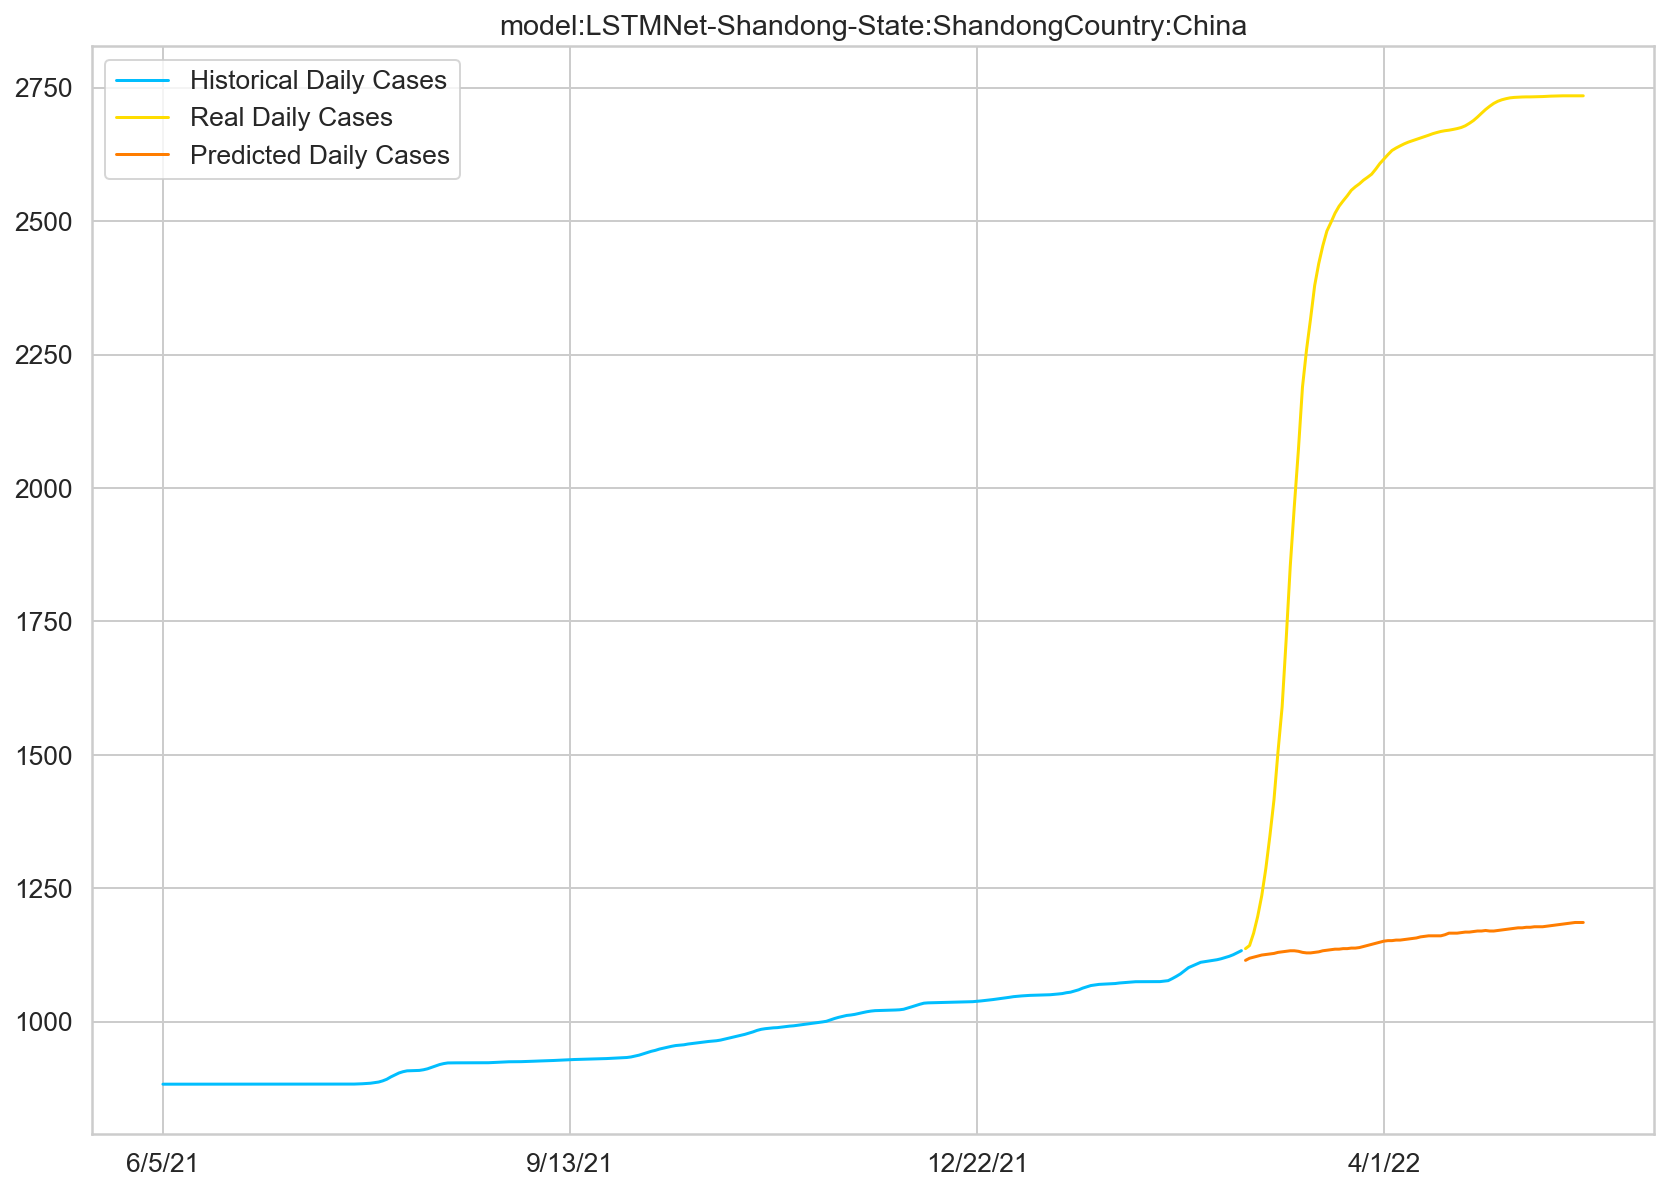

2.8773218790690103
选择累计新增
Epoch 99 train loss: 0.7349308133125305 test loss: 21.268632888793945
Epoch 199 train loss: 0.7349308133125305 test loss: 21.269840240478516
Epoch 299 train loss: 0.7349308133125305 test loss: 21.269840240478516
Epoch 399 train loss: 0.7349308133125305 test loss: 21.269840240478516
Epoch 499 train loss: 0.7349308133125305 test loss: 21.269840240478516
Epoch 599 train loss: 0.7349308133125305 test loss: 21.269840240478516
266
84


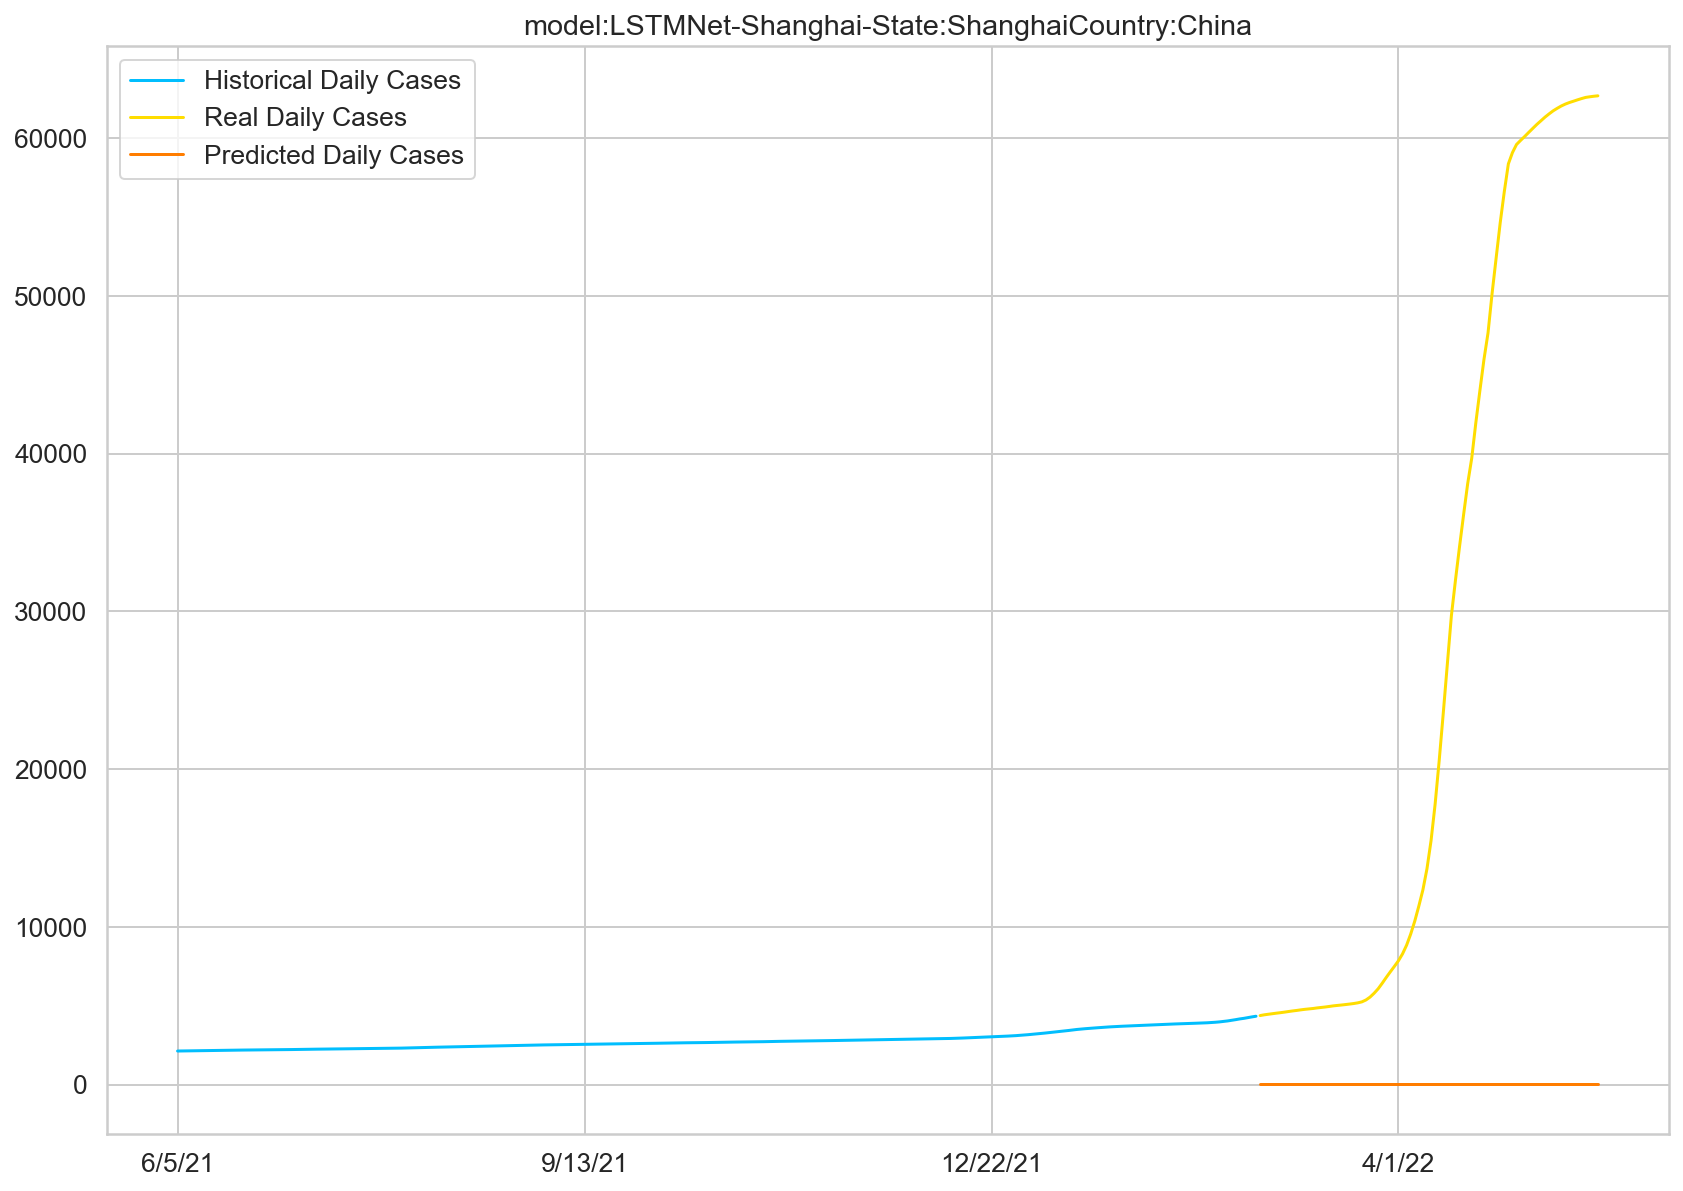

2.889161197344462
选择累计新增
Epoch 99 train loss: 0.3256051242351532 test loss: 3.1327767372131348
Epoch 199 train loss: 0.18470777571201324 test loss: 2.7914419174194336
Epoch 299 train loss: 0.13367876410484314 test loss: 2.8255767822265625
Epoch 399 train loss: 0.08692005276679993 test loss: 2.5295753479003906
Epoch 499 train loss: 0.04506068676710129 test loss: 2.3104476928710938
Epoch 599 train loss: 0.025292597711086273 test loss: 2.3066036701202393
266
84


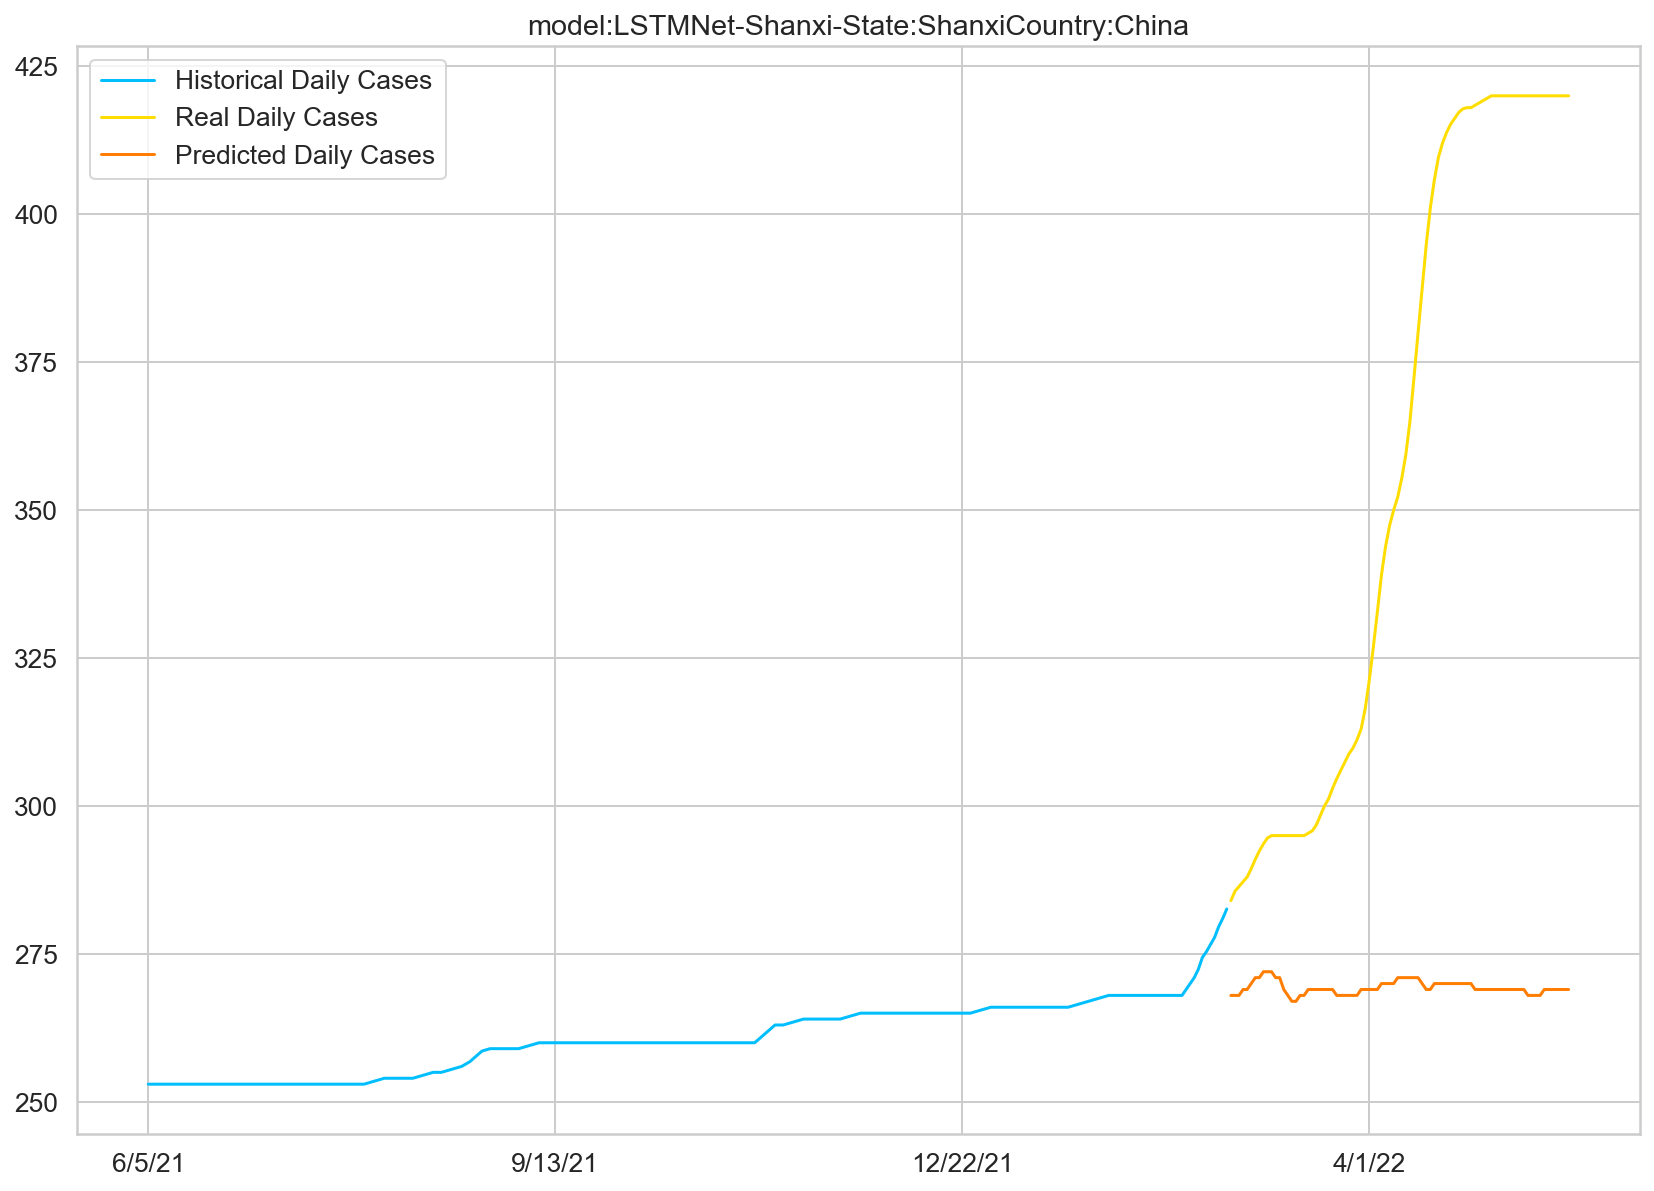

2.96171821753184
选择累计新增
Epoch 99 train loss: 0.02525114081799984 test loss: 1.8831603527069092
Epoch 199 train loss: 0.01716015674173832 test loss: 1.4658896923065186
Epoch 299 train loss: 0.015672879293560982 test loss: 1.3110288381576538
Epoch 399 train loss: 0.014675695449113846 test loss: 1.2639460563659668
Epoch 499 train loss: 0.014024710282683372 test loss: 1.2839224338531494
Epoch 599 train loss: 0.013616090640425682 test loss: 1.3132730722427368
266
84


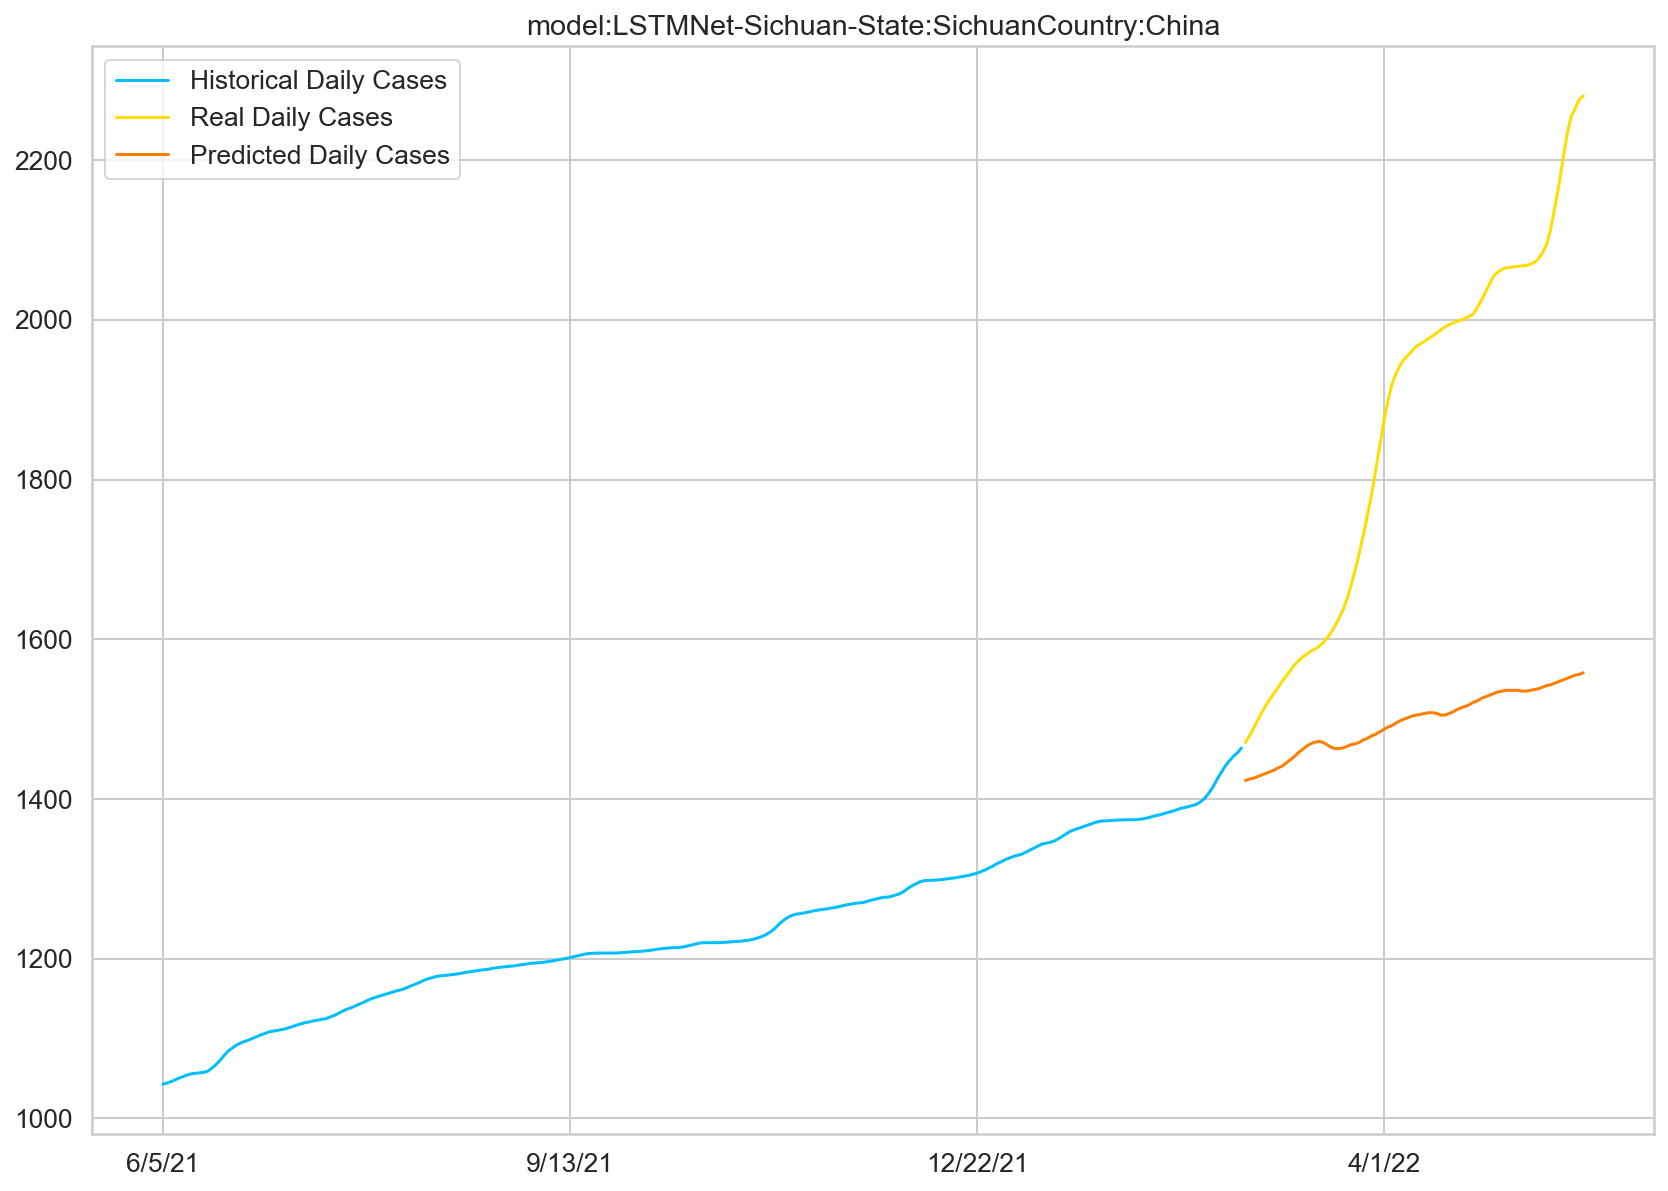

2.9186631004015604
选择累计新增
Epoch 99 train loss: 0.04956703633069992 test loss: 0.6013862490653992
Epoch 199 train loss: 0.012030281126499176 test loss: 1.152052640914917
Epoch 299 train loss: 0.007216484285891056 test loss: 1.3437143564224243
Epoch 399 train loss: 0.0057064383290708065 test loss: 1.3315051794052124
Epoch 499 train loss: 0.005066100507974625 test loss: 1.3097331523895264
Epoch 599 train loss: 0.004707055166363716 test loss: 1.3082443475723267
266
84


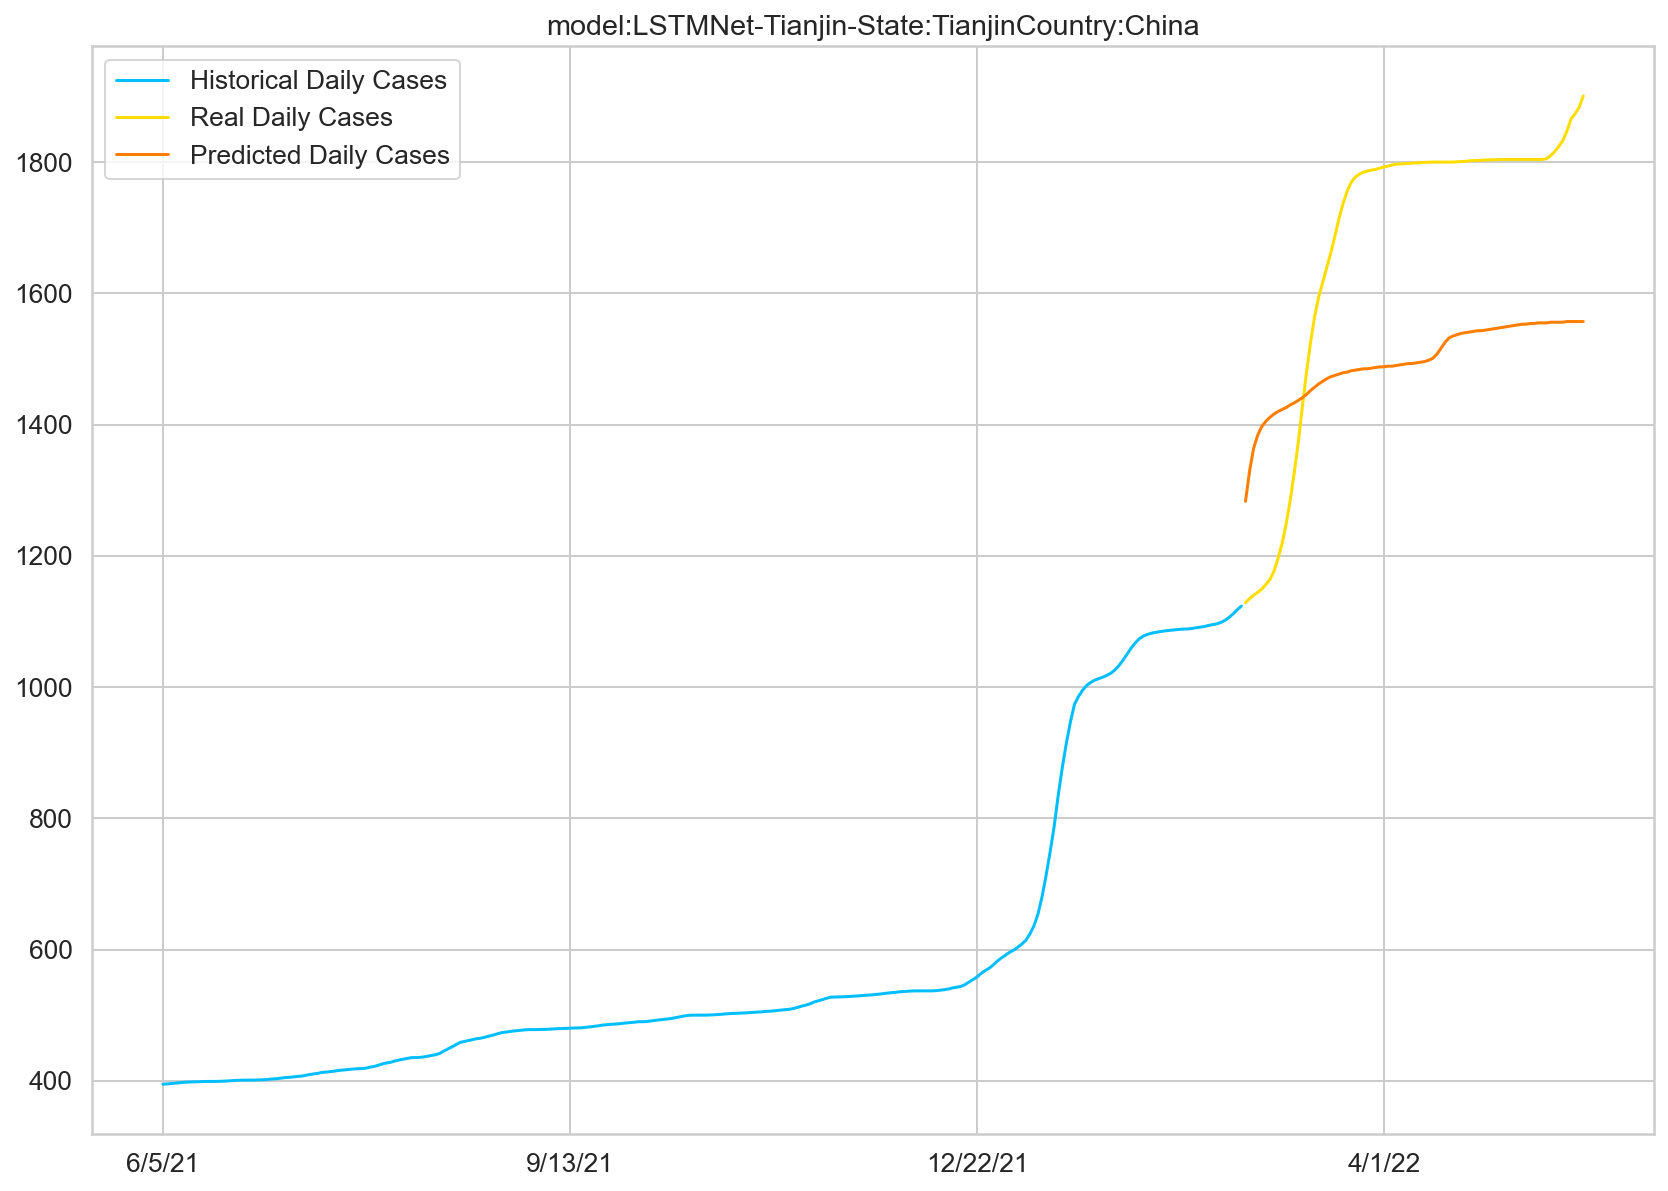

2.8789883891741437
选择累计新增
Epoch 99 train loss: 0.01613035425543785 test loss: 4.866000381298363e-06
Epoch 199 train loss: 0.008542721159756184 test loss: 6.486106030934025e-06
Epoch 299 train loss: 0.003168386872857809 test loss: 2.6715460990089923e-06
Epoch 399 train loss: 0.000961245852522552 test loss: 8.993711162474938e-07
Epoch 499 train loss: 0.0003754321369342506 test loss: 3.45512717103702e-07
Epoch 599 train loss: 0.00021932182426098734 test loss: 1.7056231627066154e-07
266
84


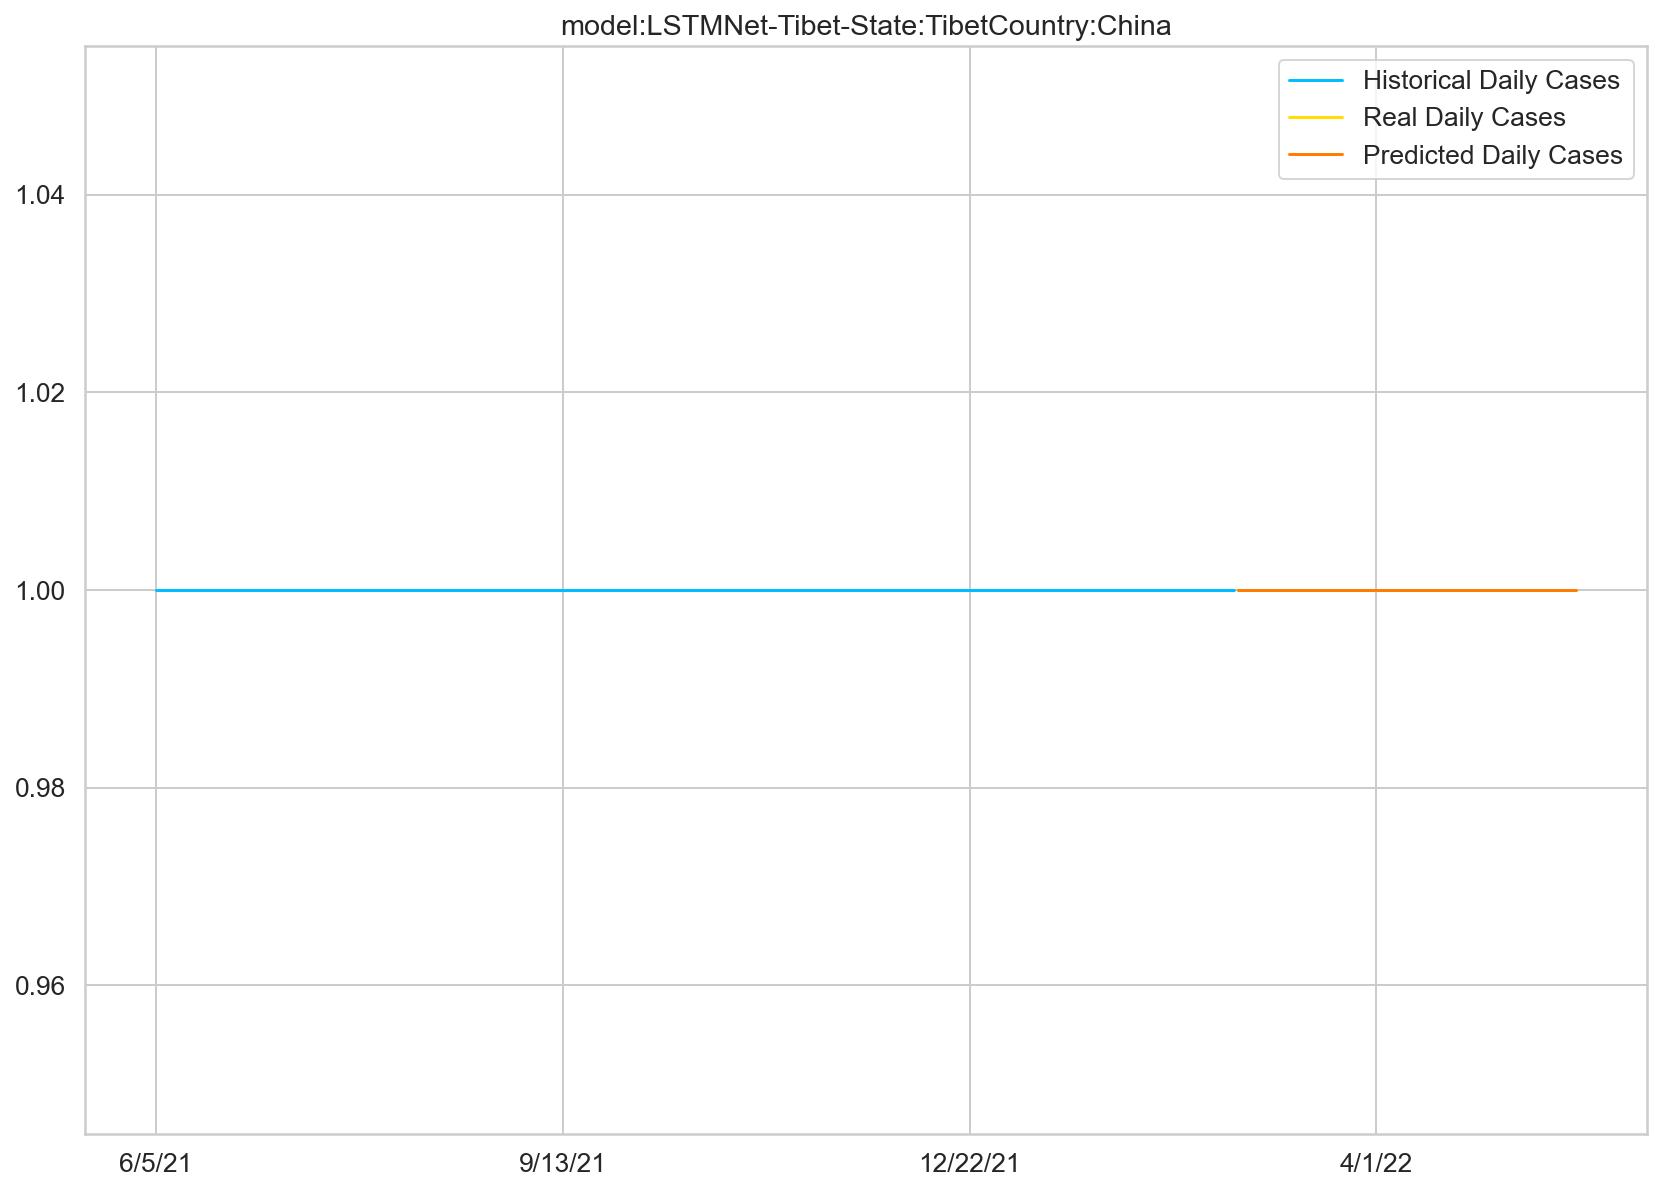

2.892834941546122
选择累计新增
Epoch 99 train loss: 0.3133317828178406 test loss: 0.063013456761837
Epoch 199 train loss: 0.09443283826112747 test loss: 0.013909850269556046
Epoch 299 train loss: 0.07864192128181458 test loss: 0.012548992410302162
Epoch 399 train loss: 0.05892859399318695 test loss: 0.009228738024830818
Epoch 499 train loss: 0.04670938849449158 test loss: 0.0072020189836621284
Epoch 599 train loss: 0.03846343979239464 test loss: 0.005592933390289545
266
84


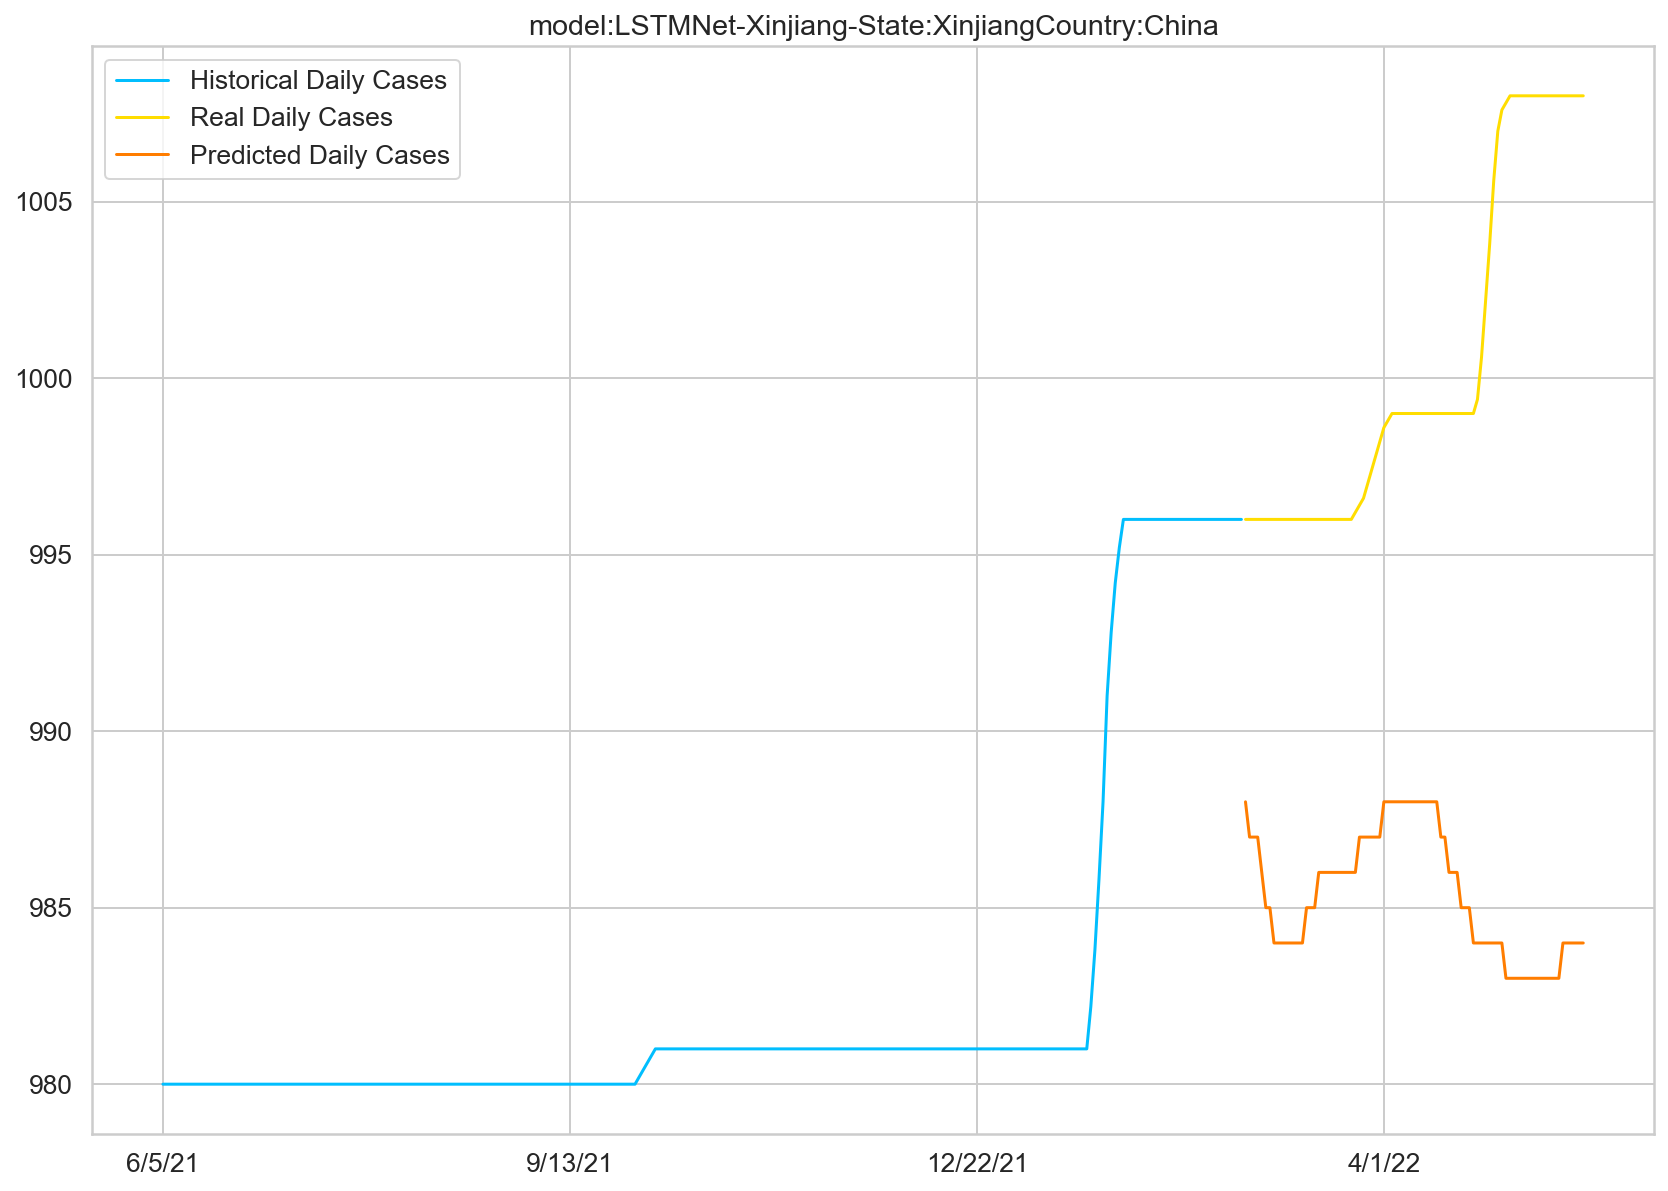

2.960875515143077
选择累计新增
Epoch 99 train loss: 0.16799293458461761 test loss: 0.09260089695453644
Epoch 199 train loss: 0.06832276284694672 test loss: 0.14528213441371918
Epoch 299 train loss: 0.08038591593503952 test loss: 0.19195890426635742
Epoch 399 train loss: 0.05003362521529198 test loss: 0.11371421068906784
Epoch 499 train loss: 0.03211497887969017 test loss: 0.13070866465568542
Epoch 599 train loss: 0.022497229278087616 test loss: 0.13722215592861176
266
84


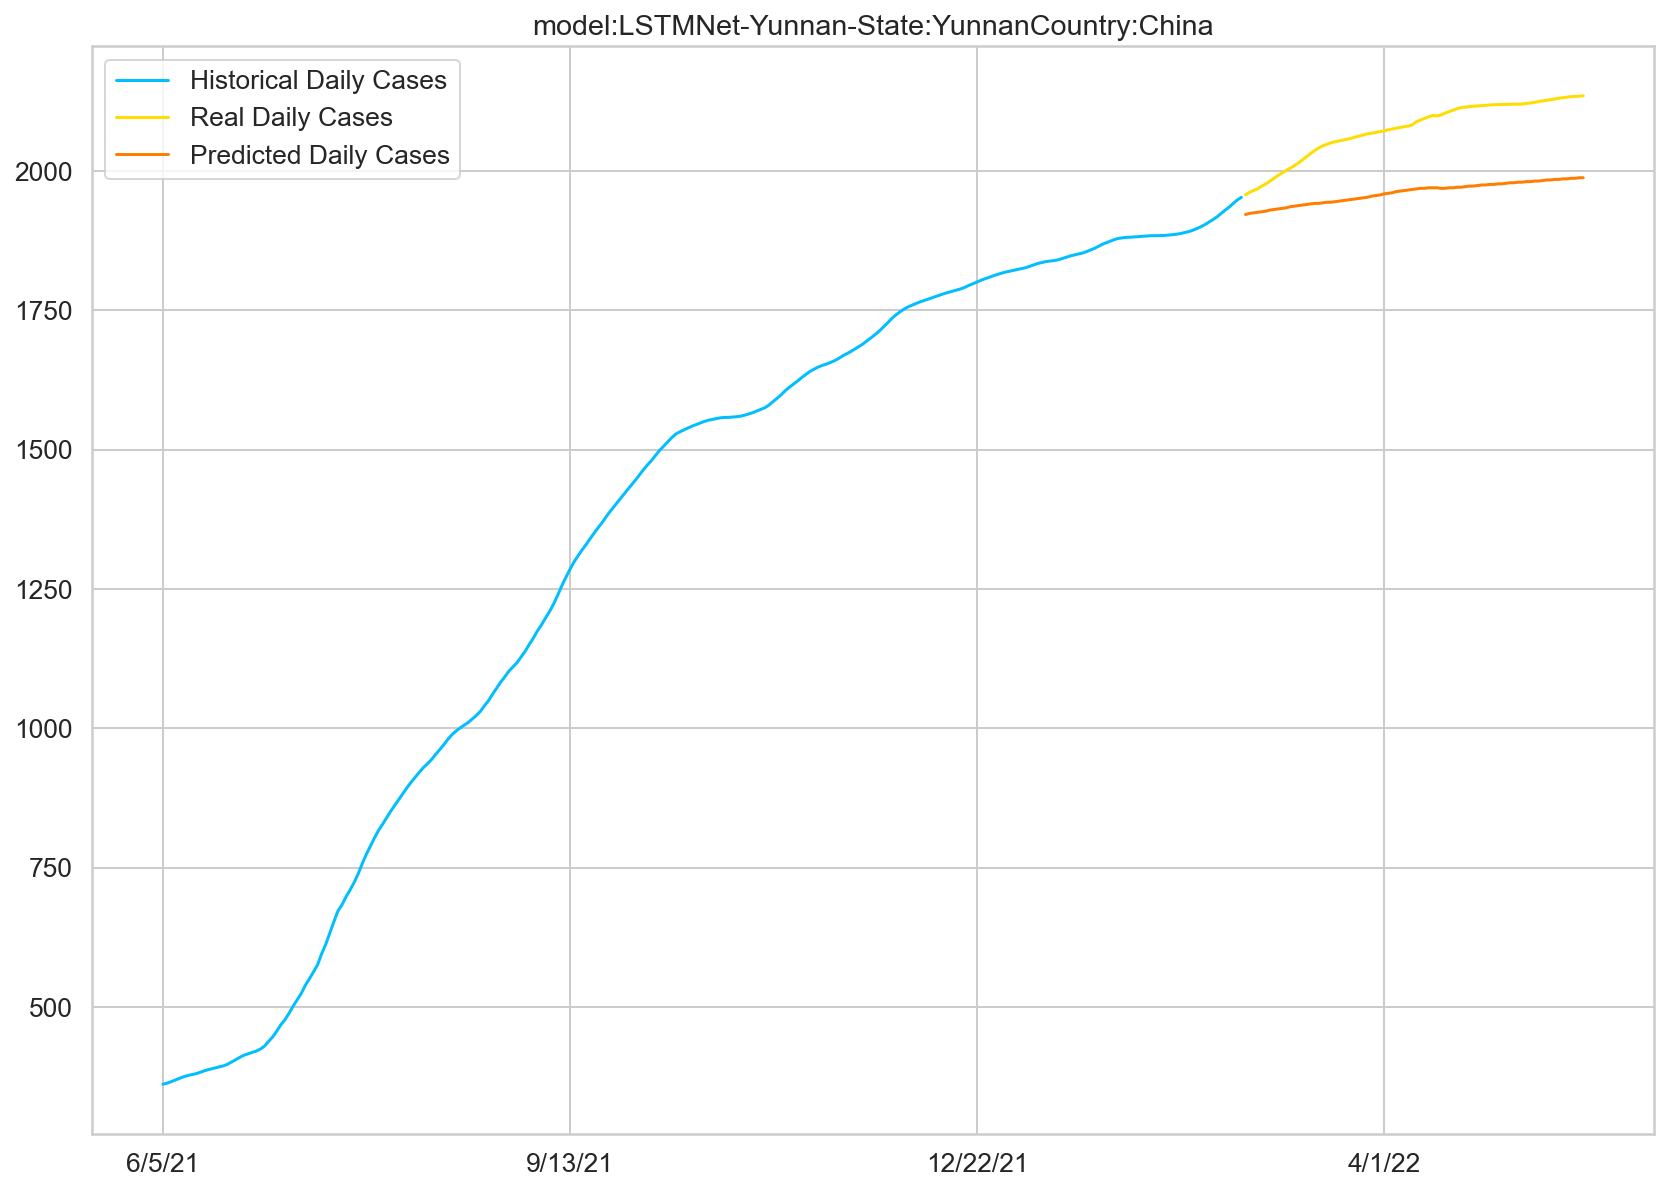

2.960053833325704
选择累计新增
Epoch 99 train loss: 0.22097185254096985 test loss: 1.0985571146011353
Epoch 199 train loss: 0.5614975690841675 test loss: 1.2333201169967651
Epoch 299 train loss: 0.0325654000043869 test loss: 1.9542301893234253
Epoch 399 train loss: 0.011693999171257019 test loss: 2.293667793273926
Epoch 499 train loss: 0.009960372000932693 test loss: 2.3019635677337646
Epoch 599 train loss: 0.009551333263516426 test loss: 2.3041727542877197
266
84


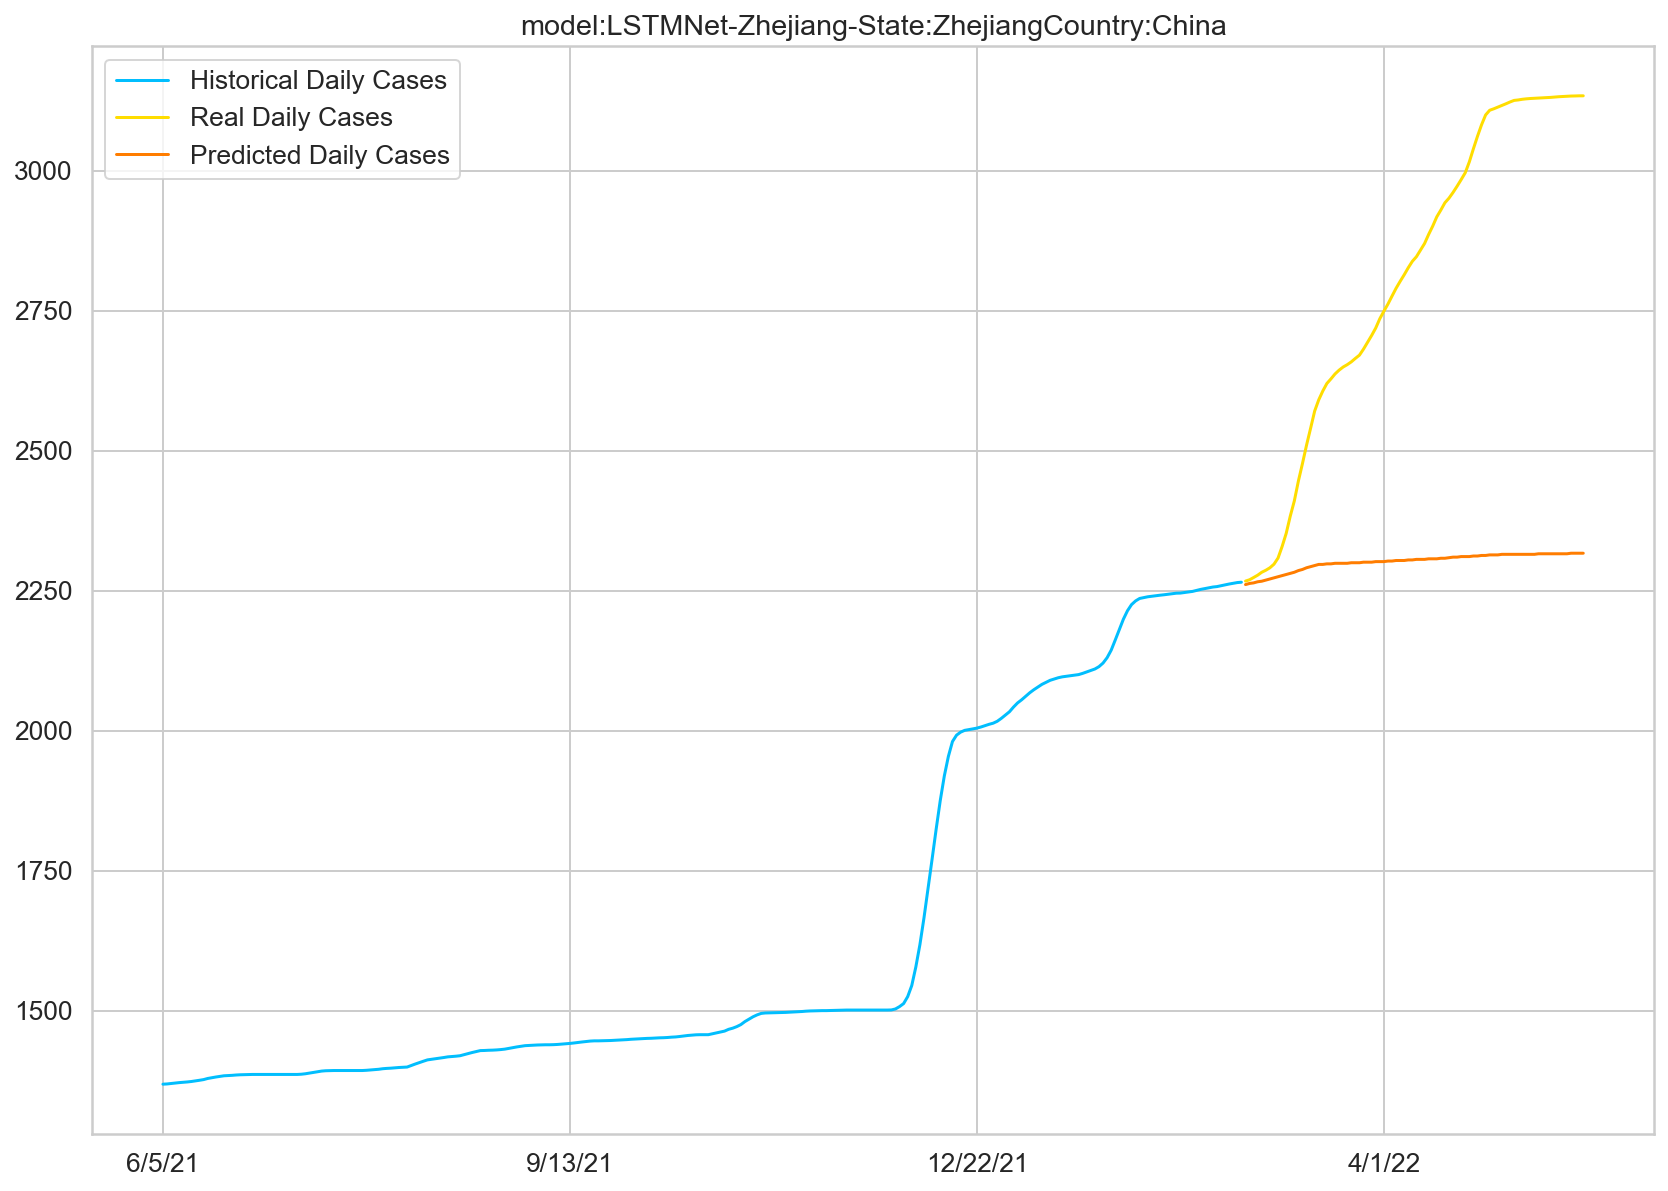

2.9551212588946023


In [31]:
model = torch.load('../../model/LSTMNet2.pth')
import time
indexs = list(range(59, 71)) + list(range(73, 89)) + list(range(90, 93))
model_list = []
start = time.time()
for i, index in enumerate(indexs):

    # area_model = LSTMNet()
    # model_list.append(LSTMNet())
    # data_testing(data, index, model_list[i])

    data_testing(data, index, model)

    print((time.time() - start) / 60)
    start = time.time()

选择累计新增
266
84


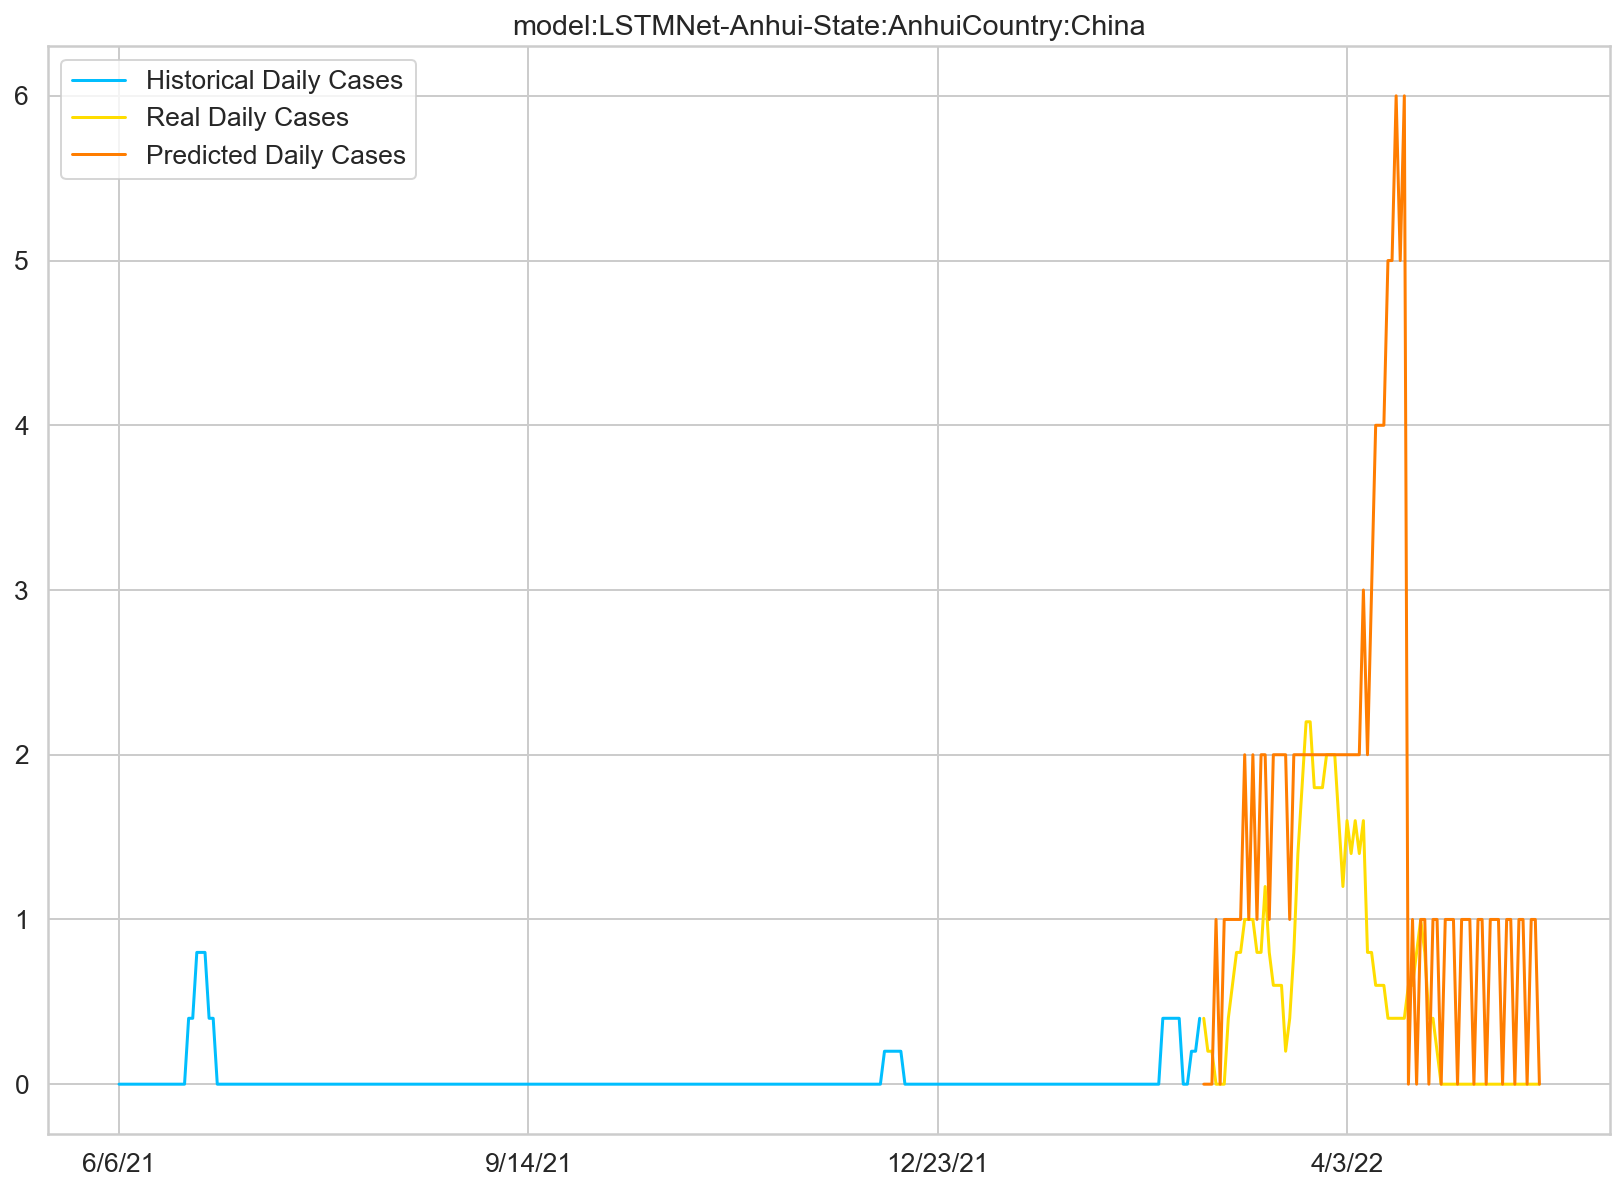

选择累计新增
266
84


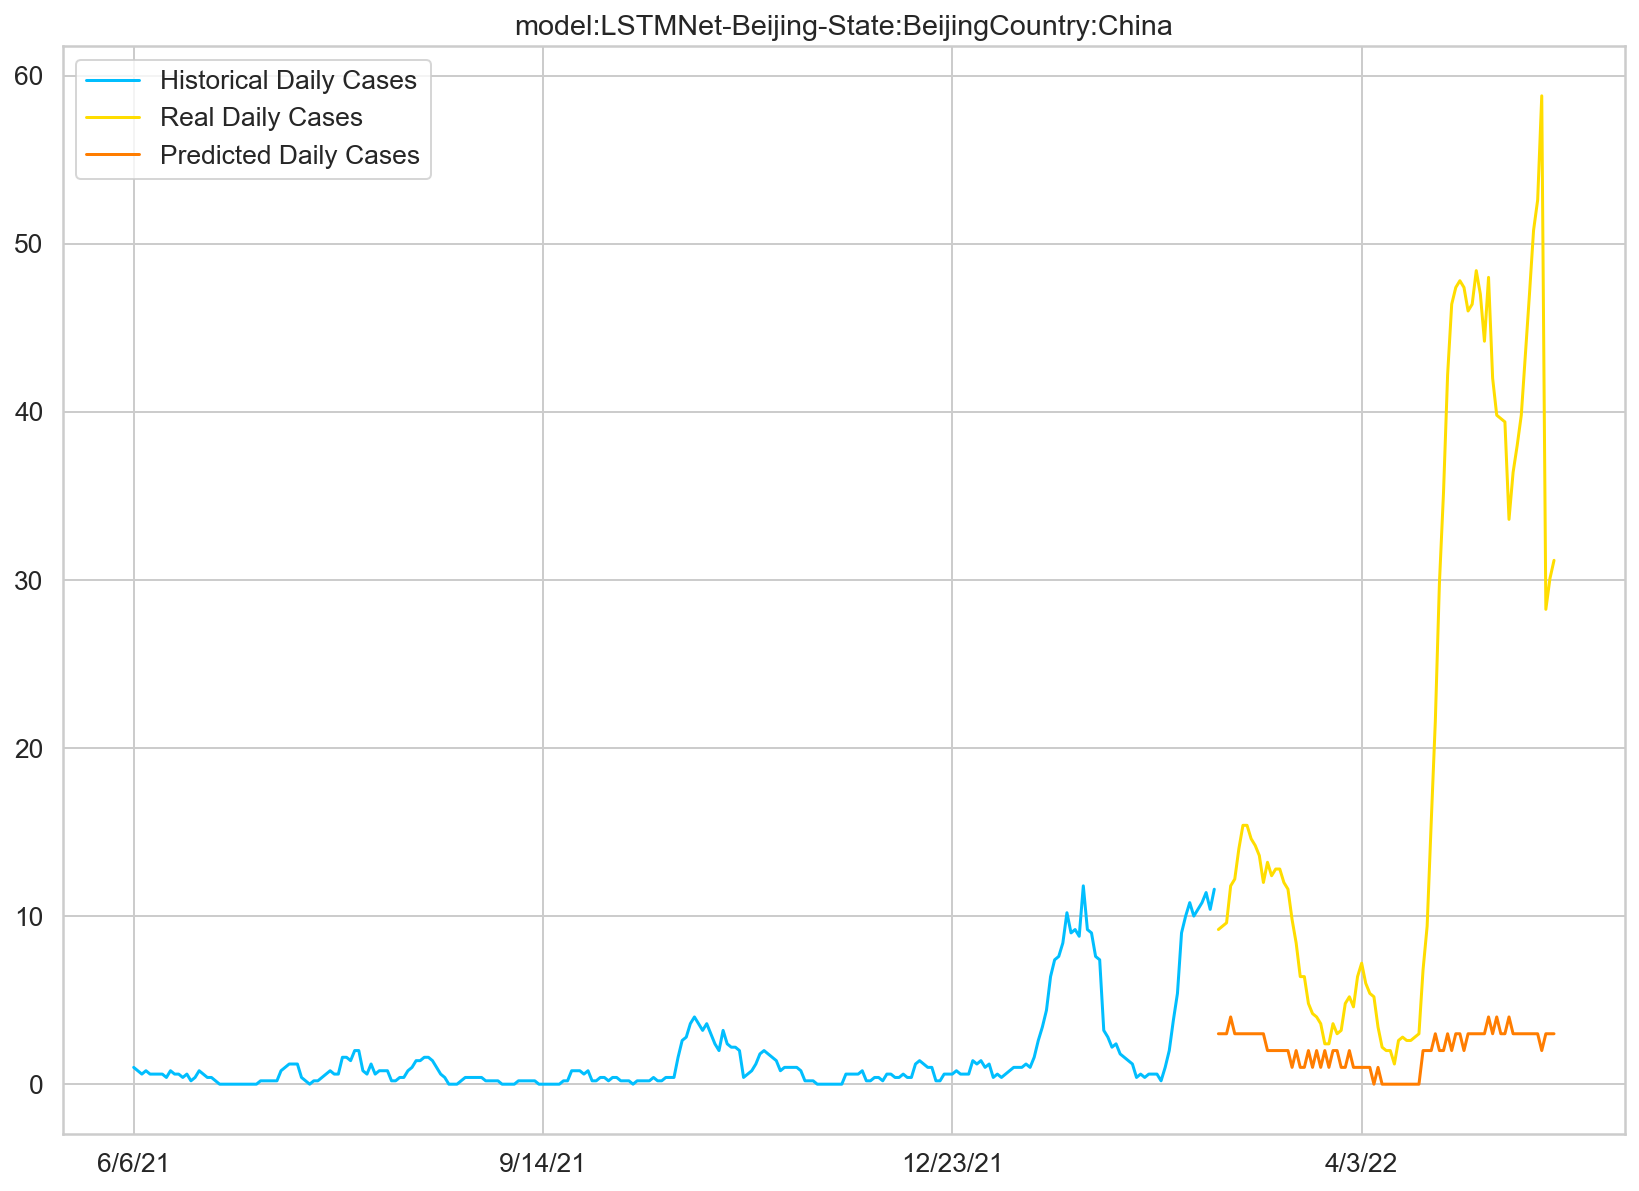

选择累计新增
266
84


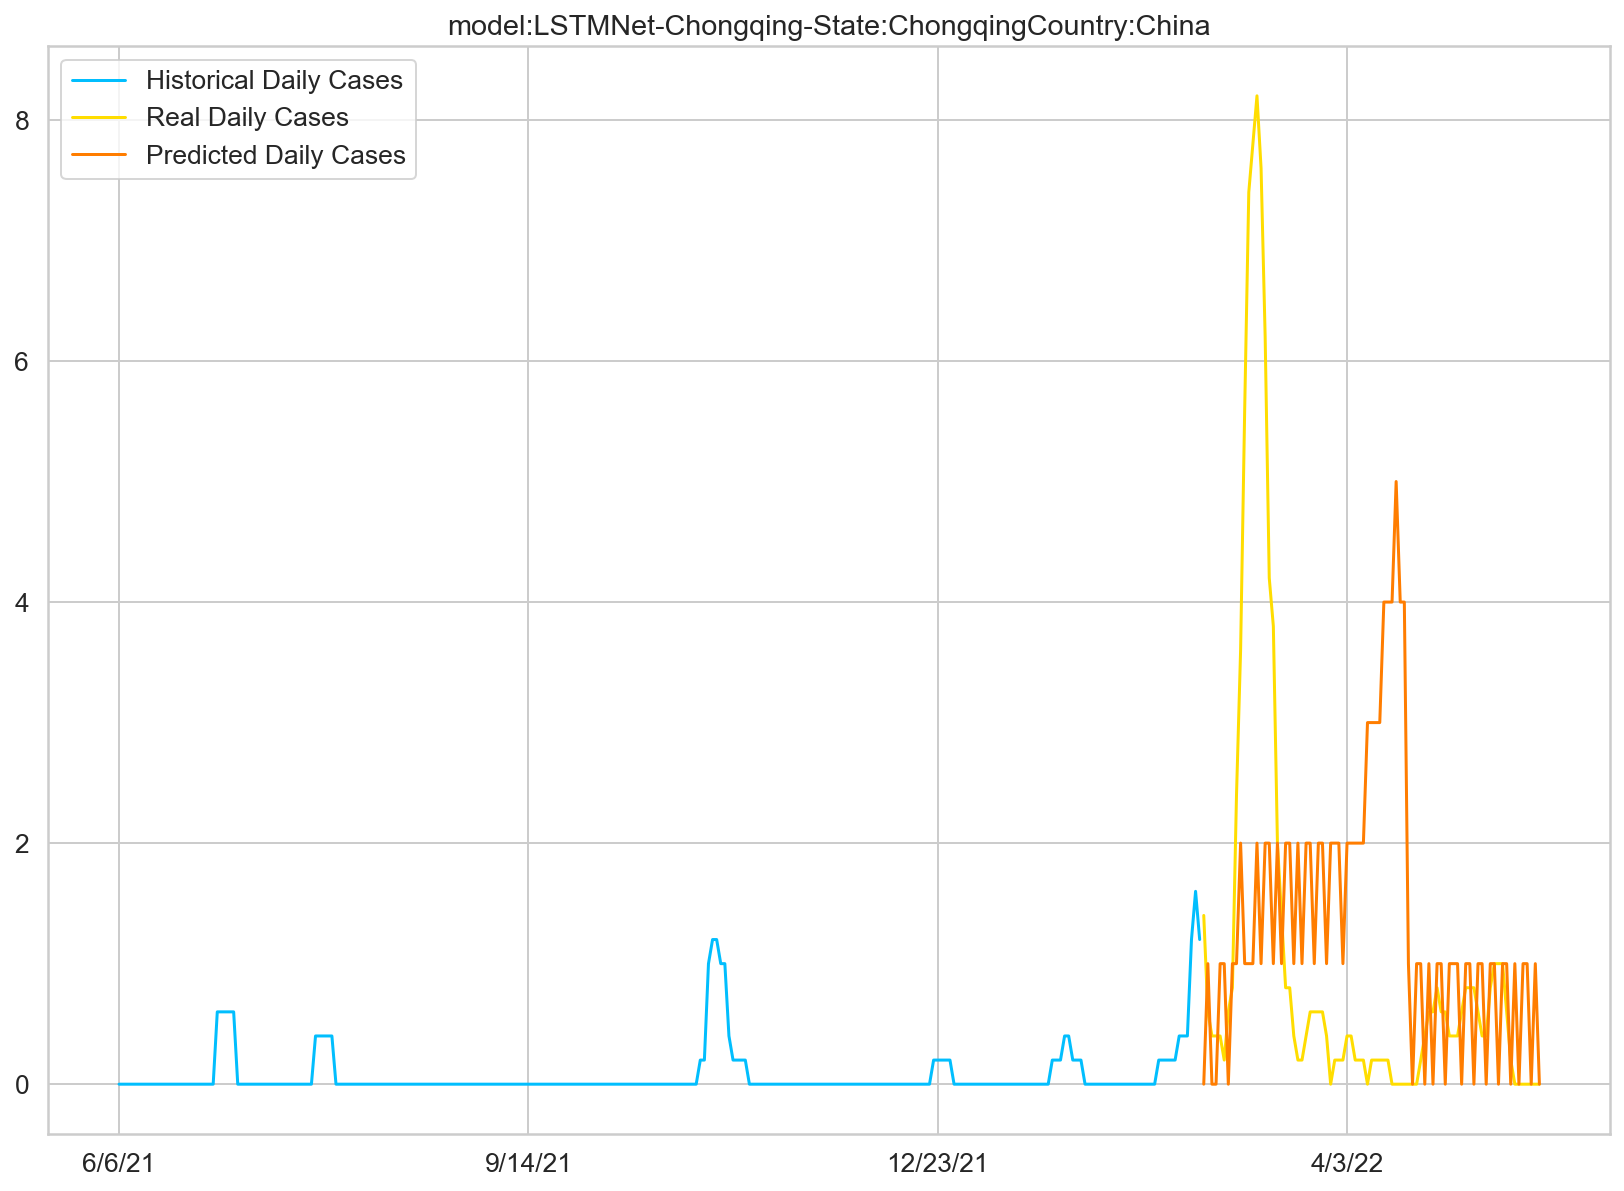

选择累计新增
266
84


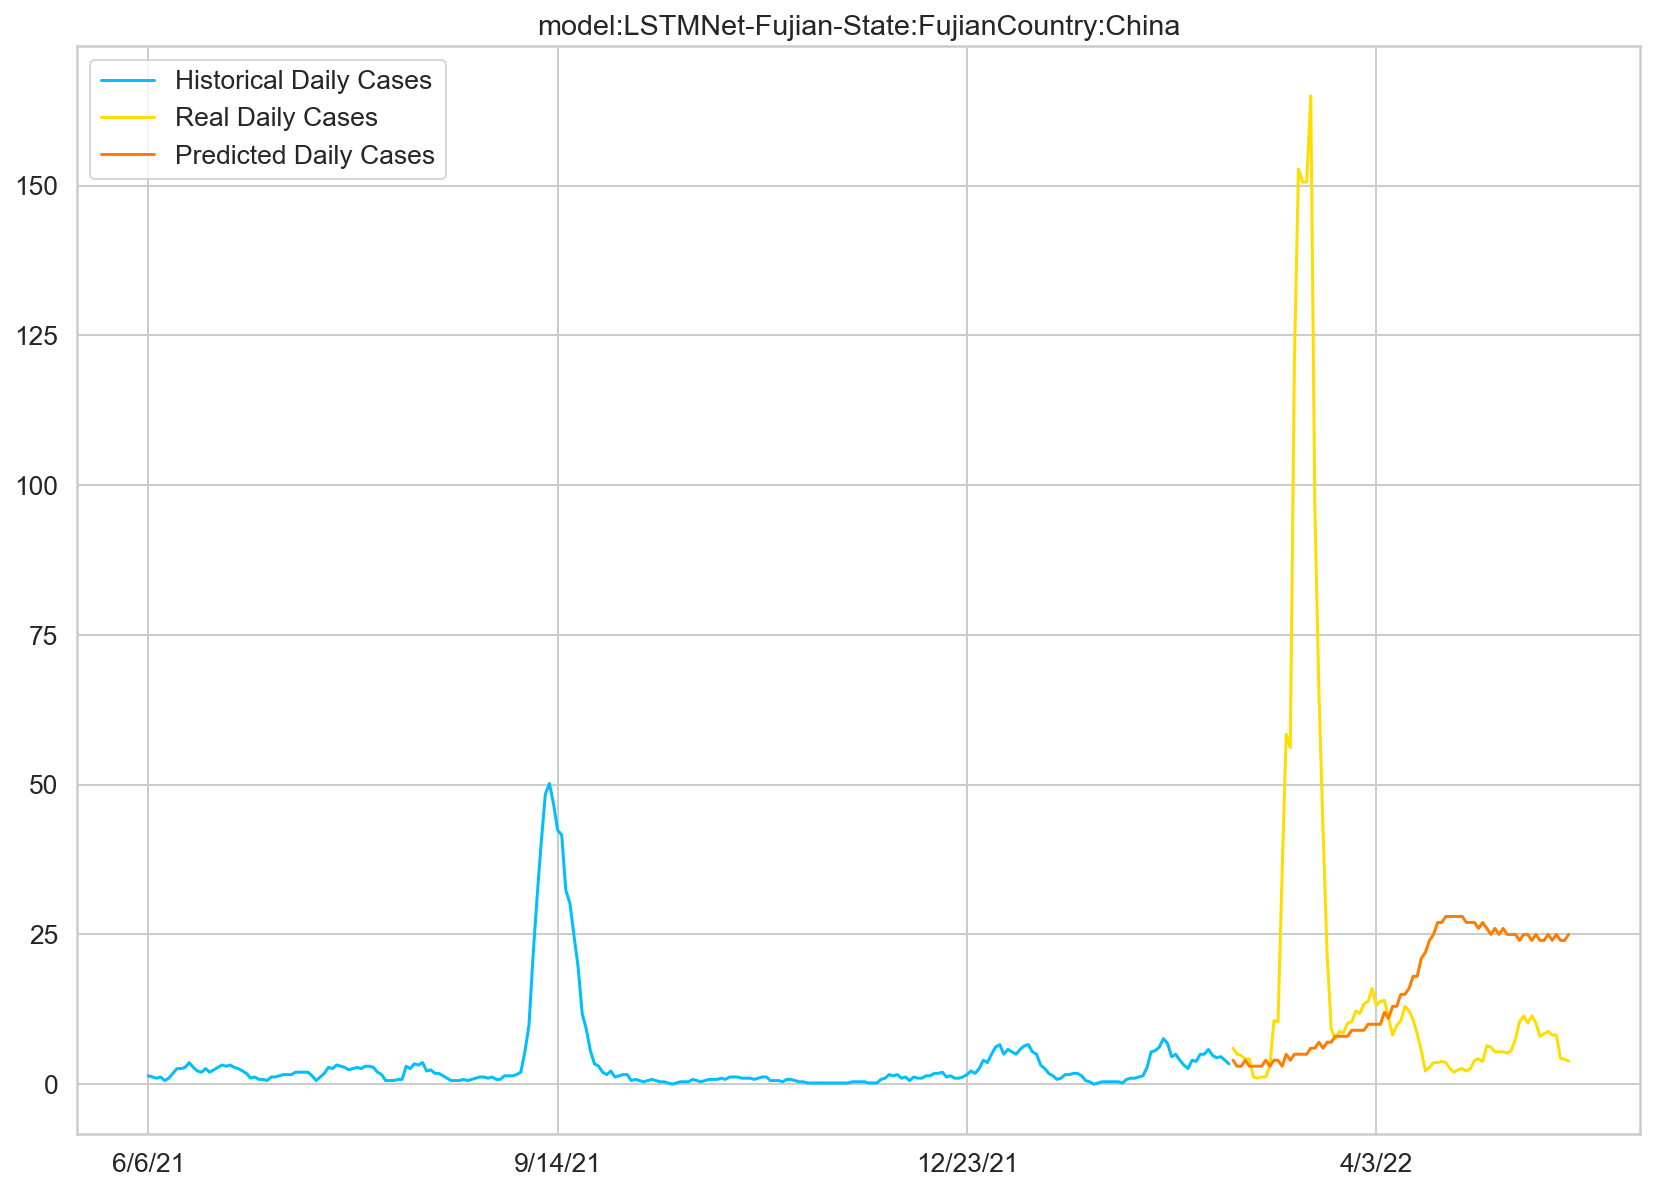

选择累计新增
266
84


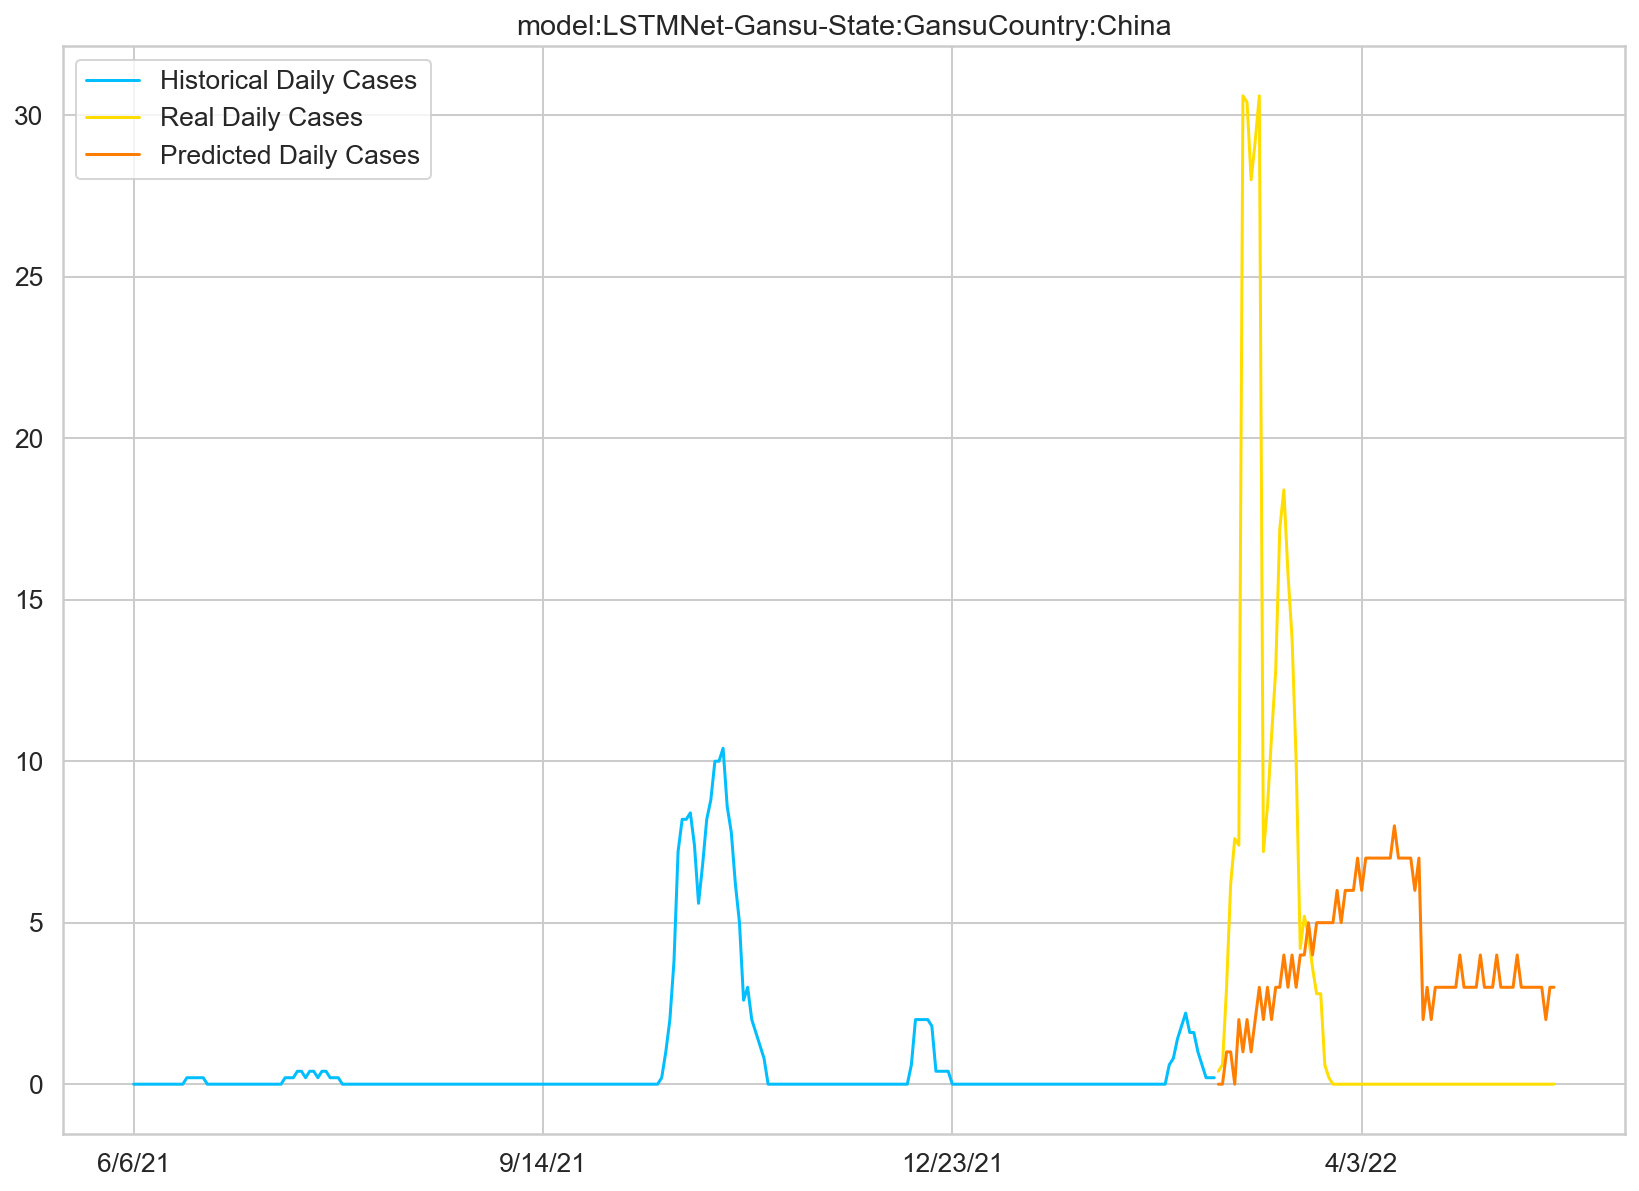

选择累计新增
266
84


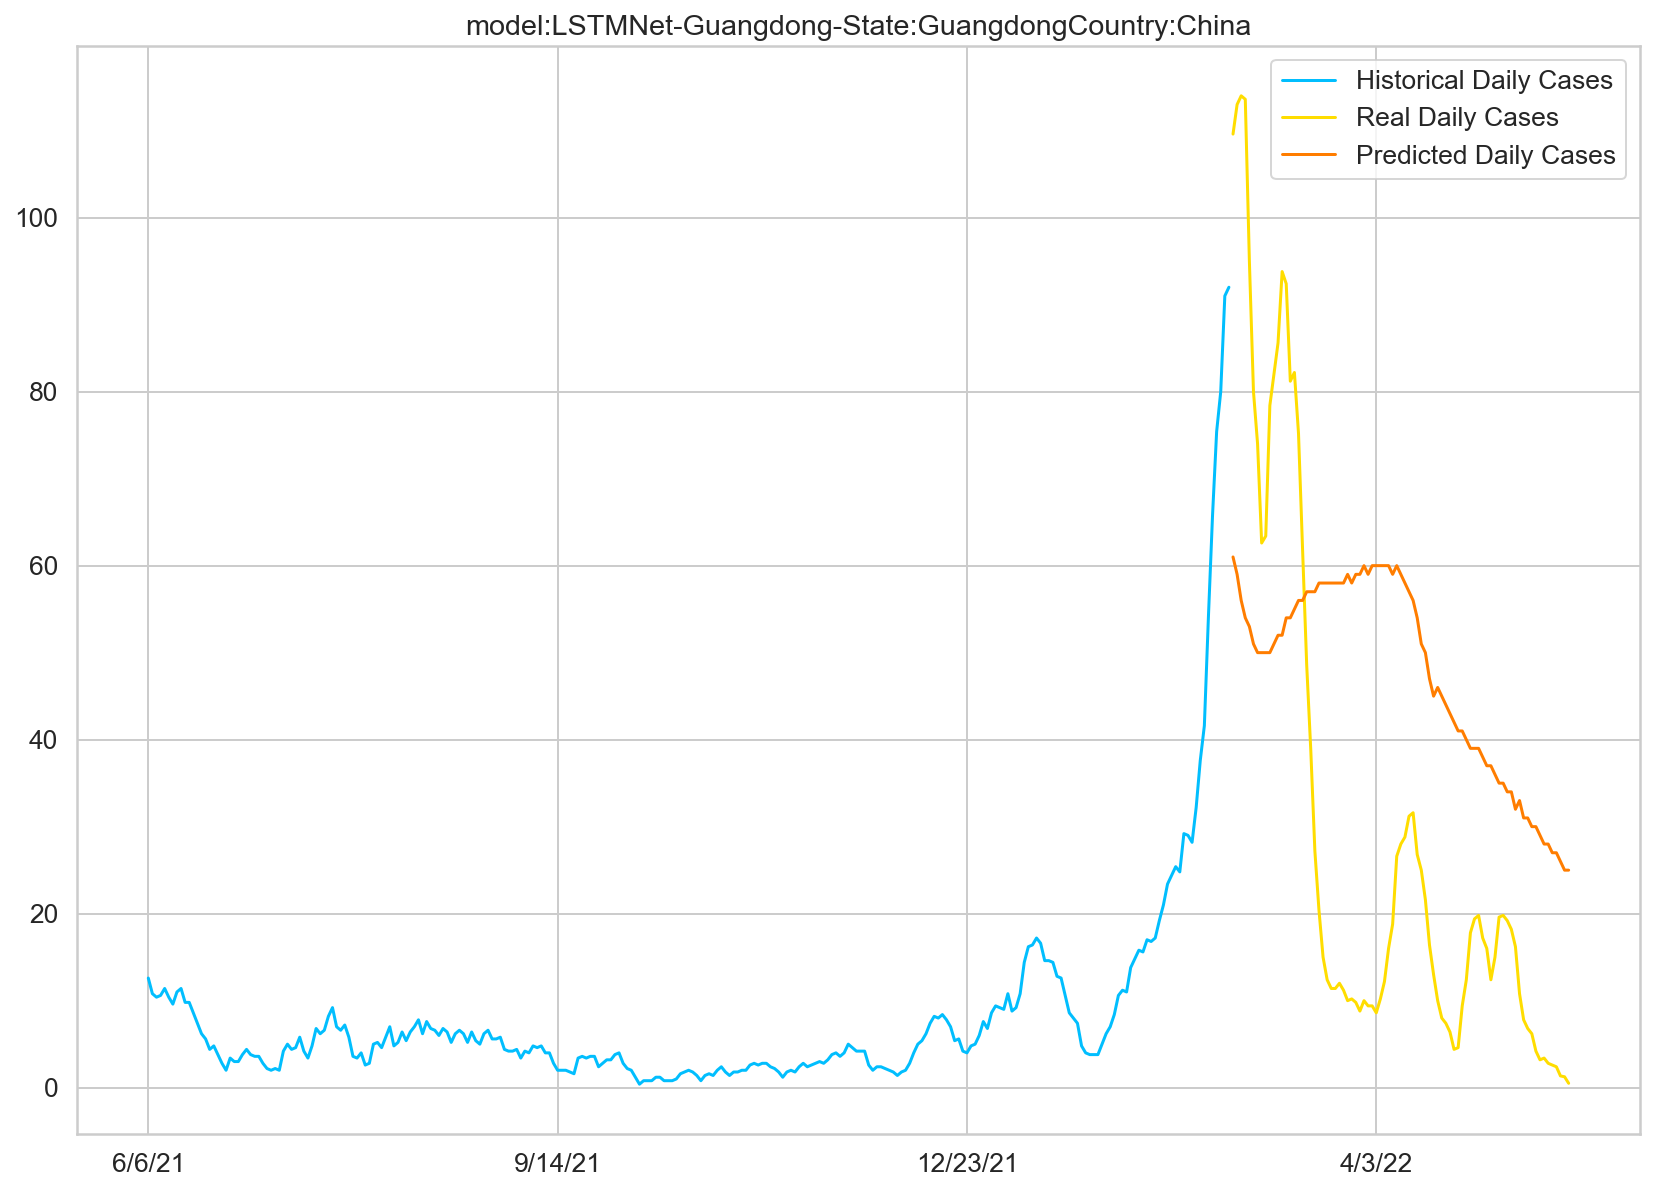

选择累计新增
266
84


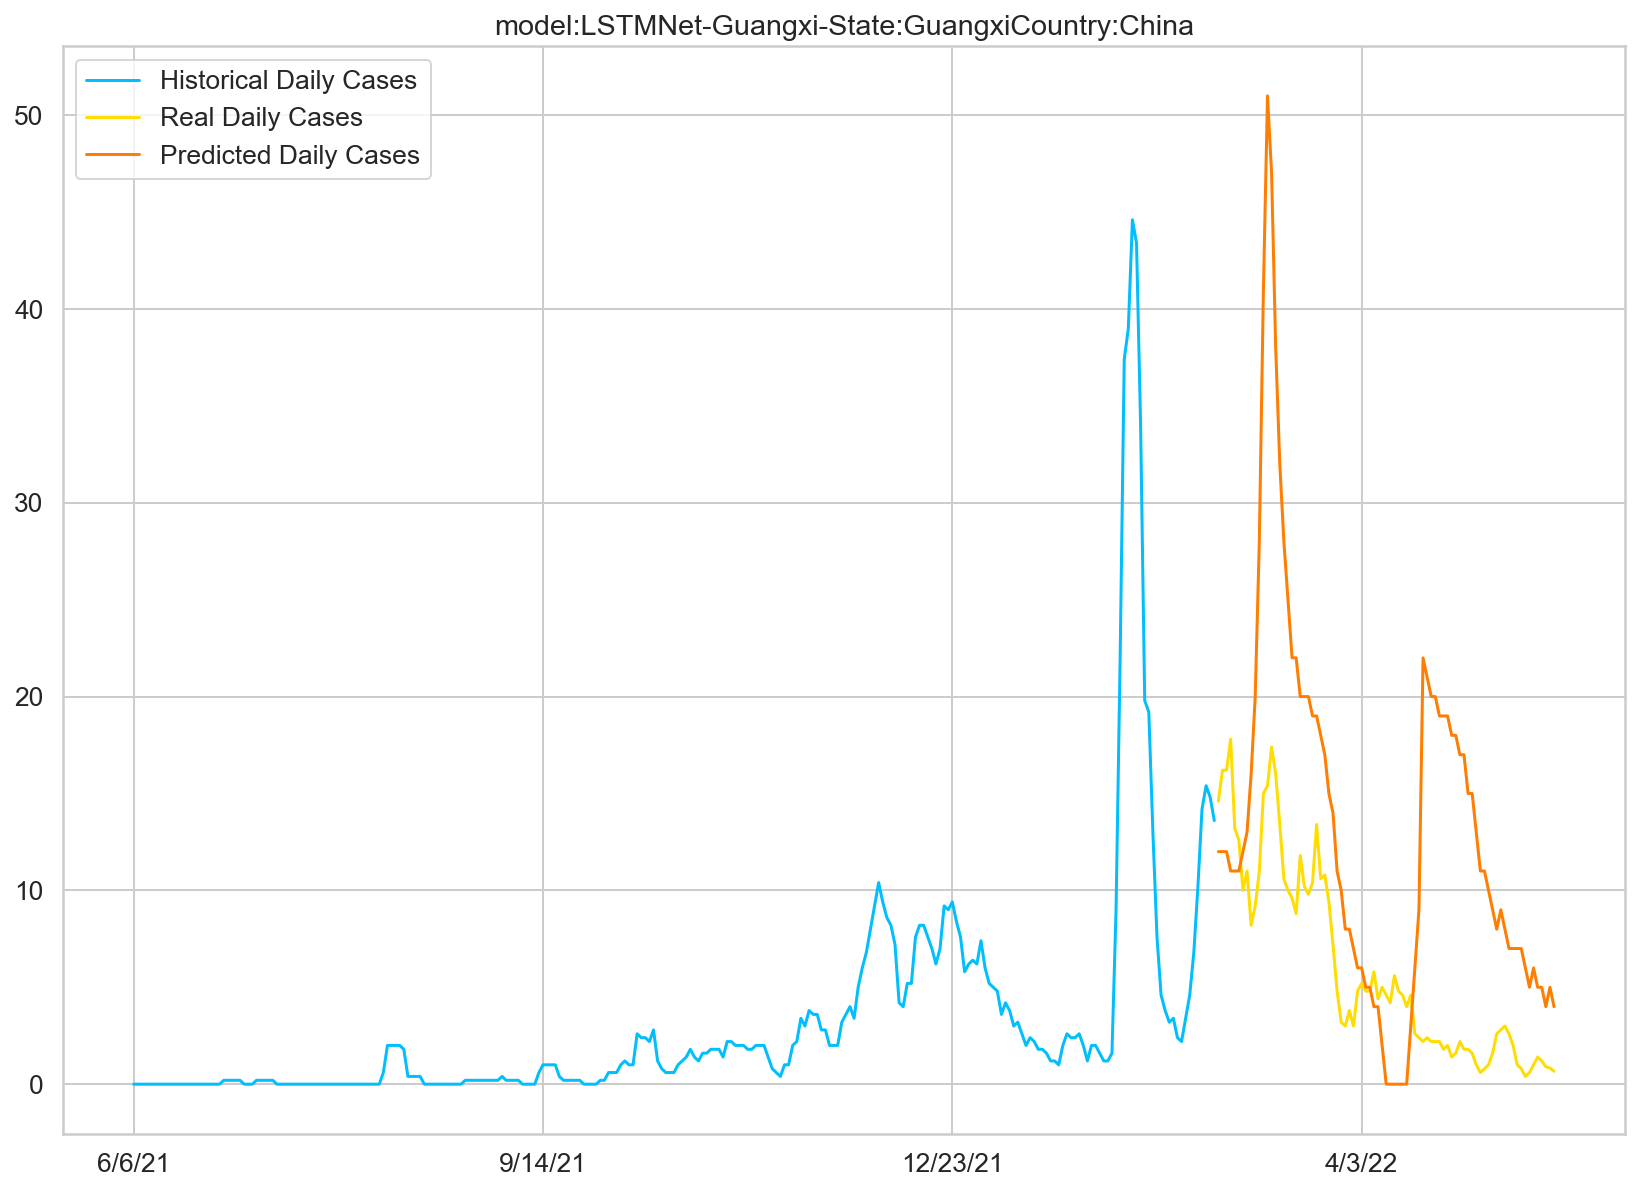

选择累计新增
266
84


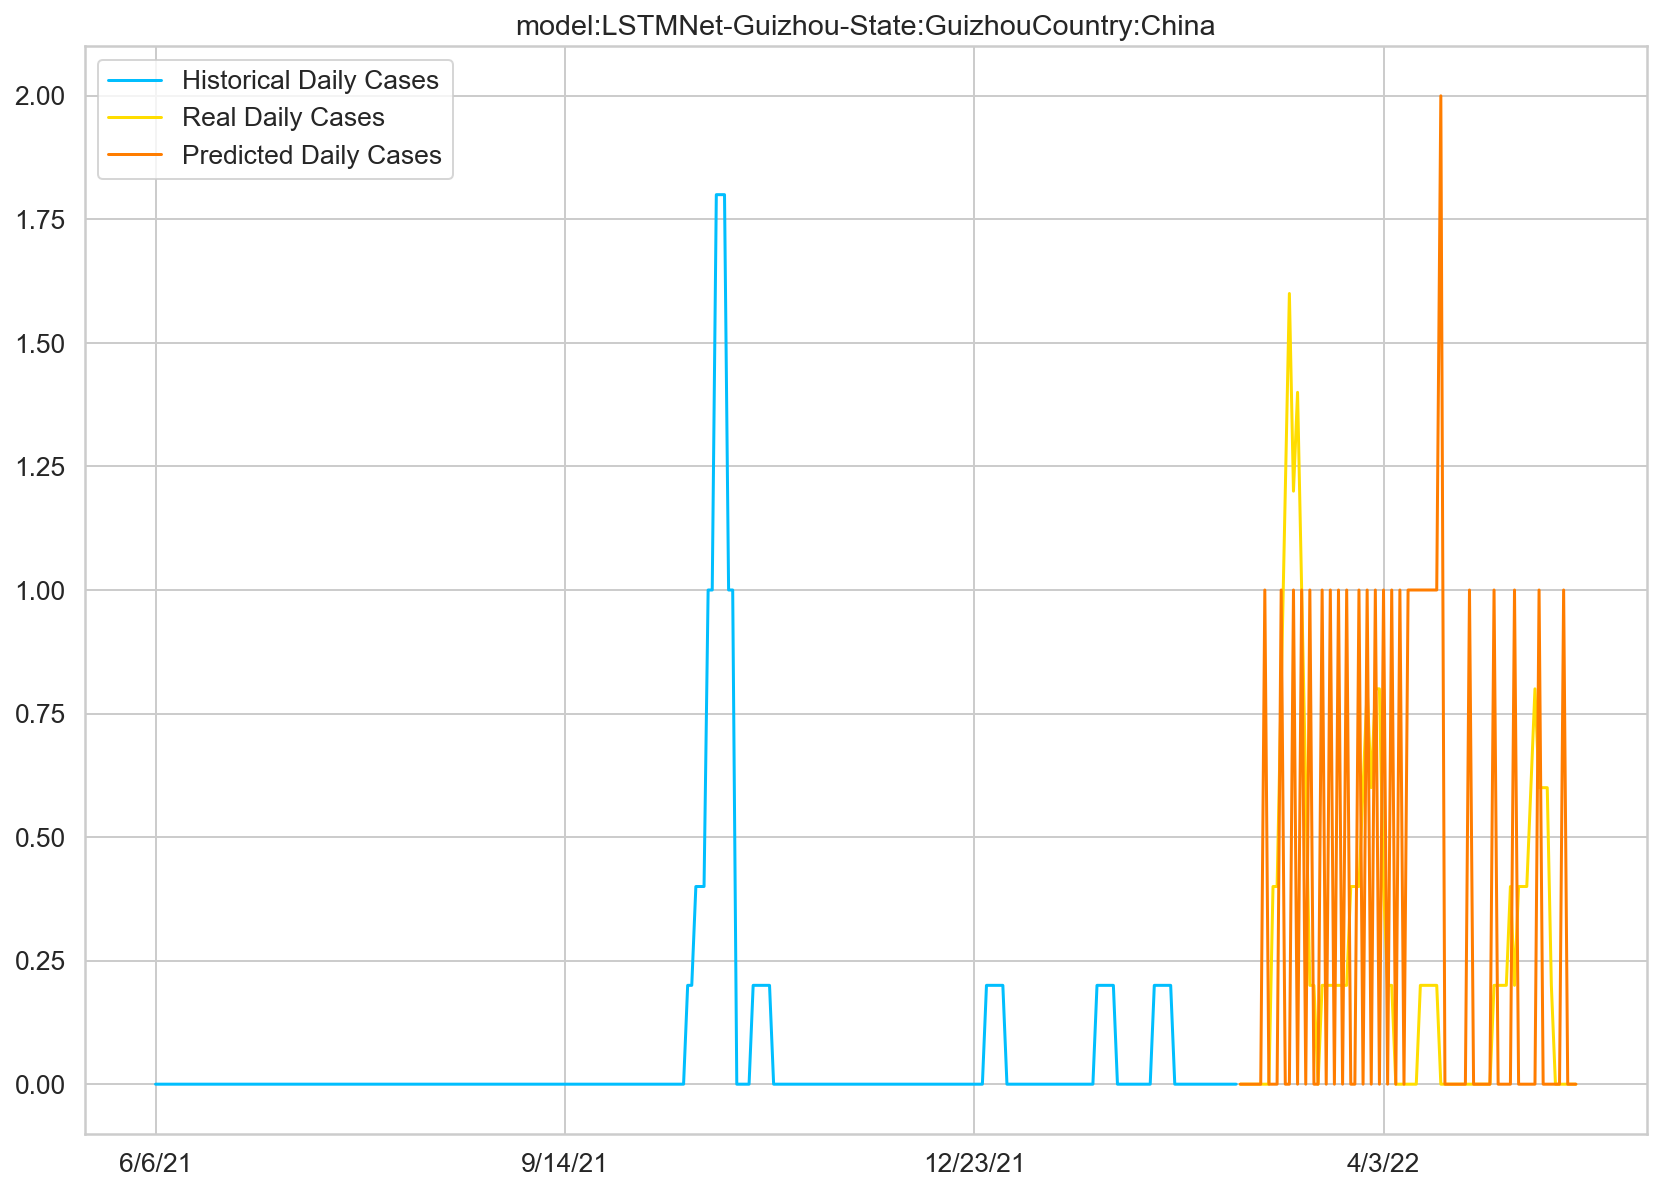

选择累计新增
266
84


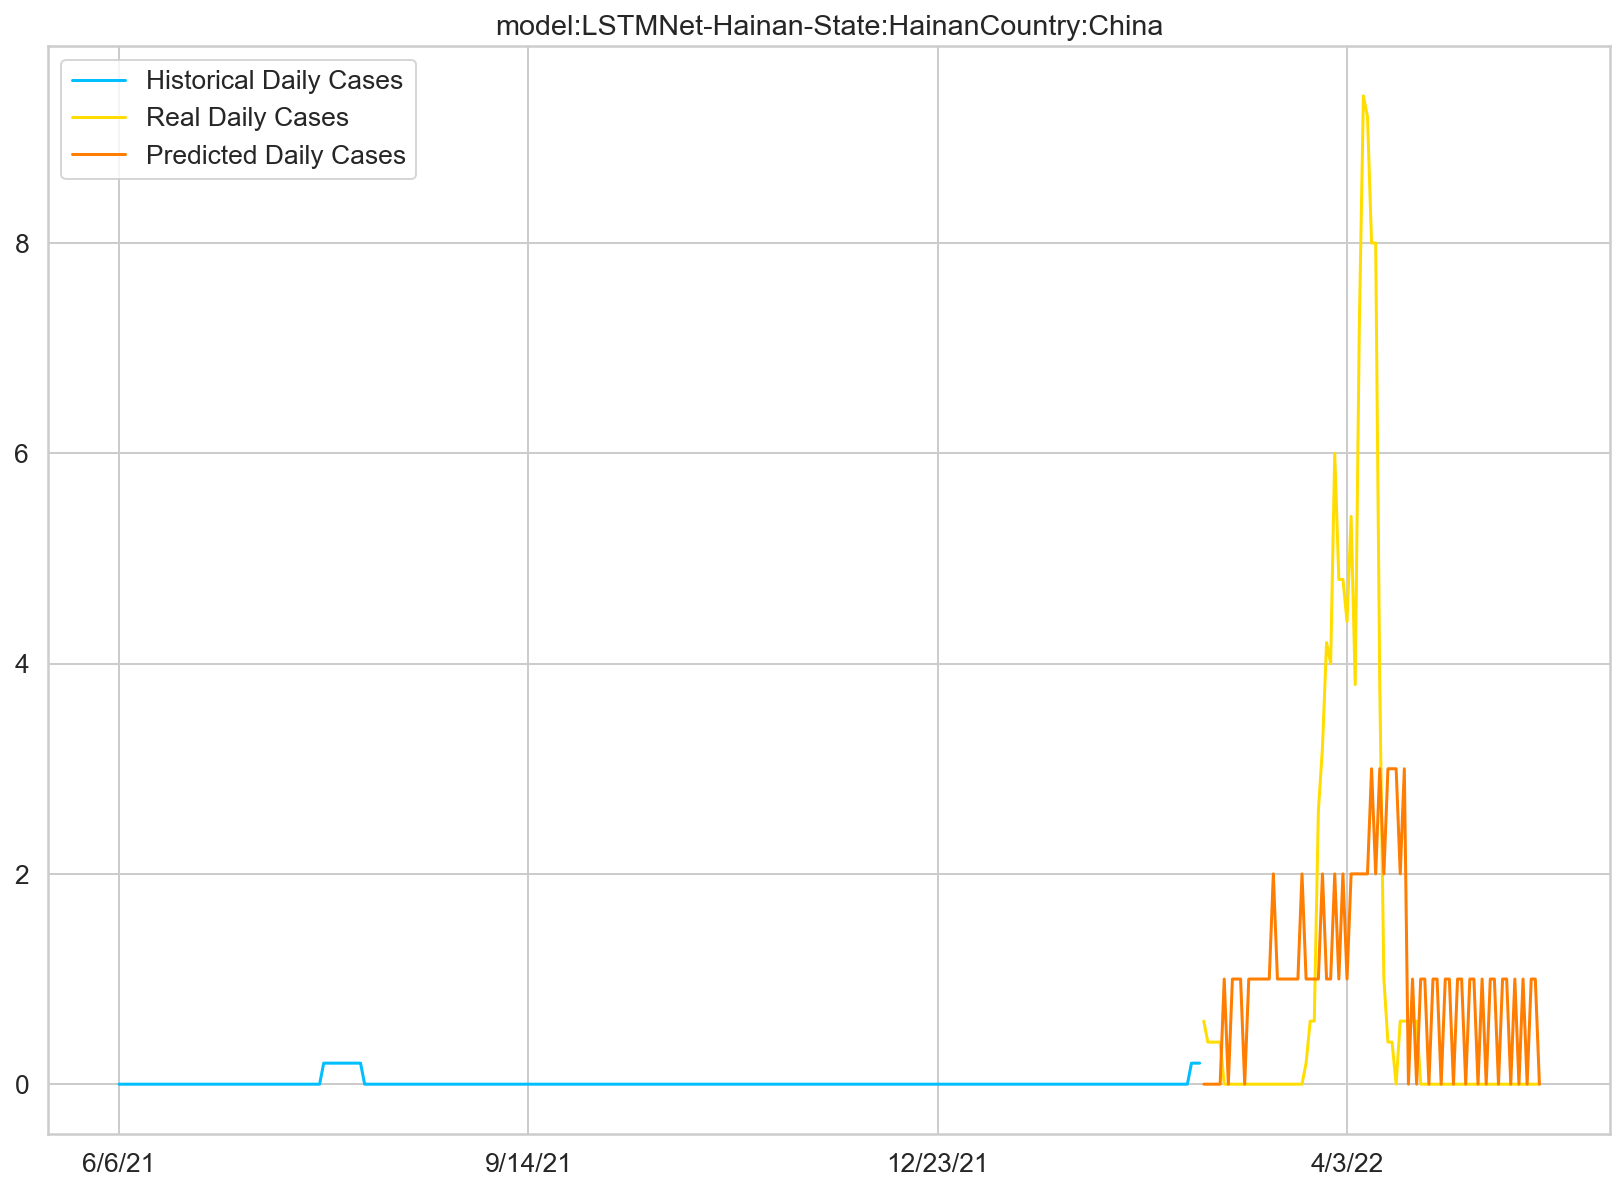

选择累计新增
266
84


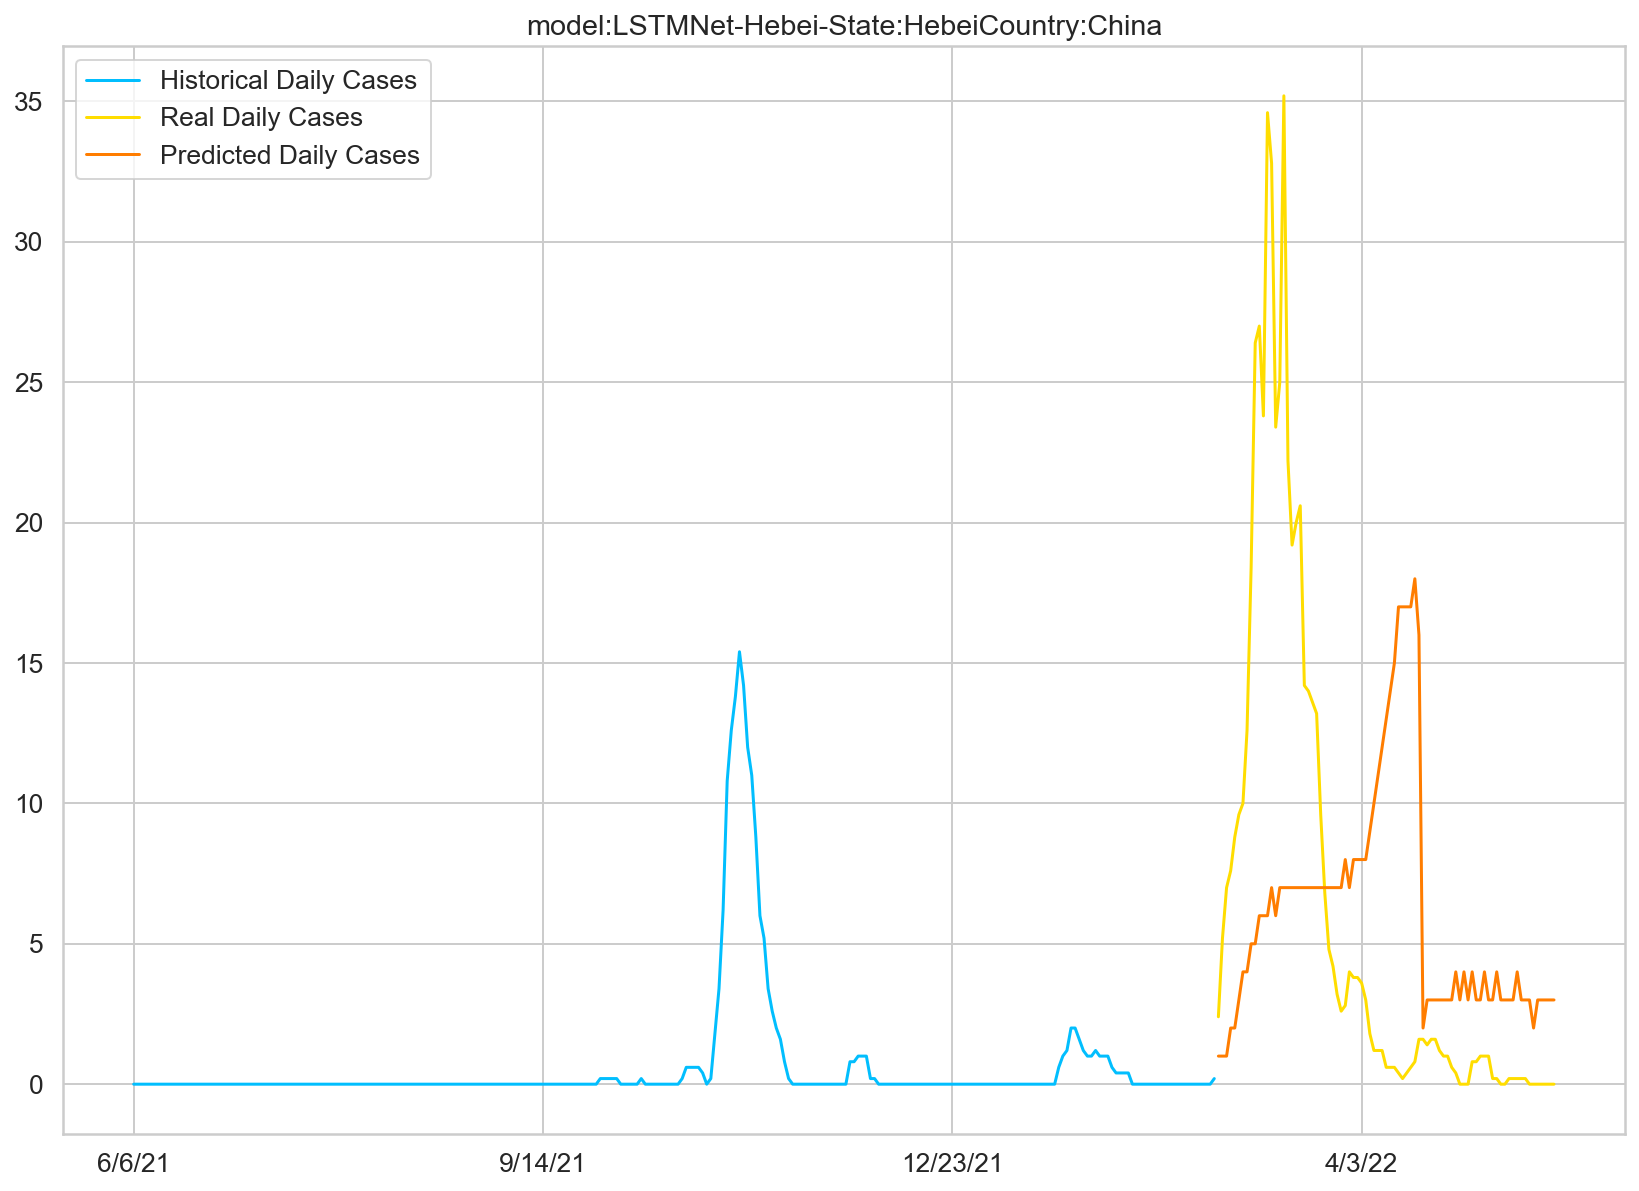

选择累计新增
266
84


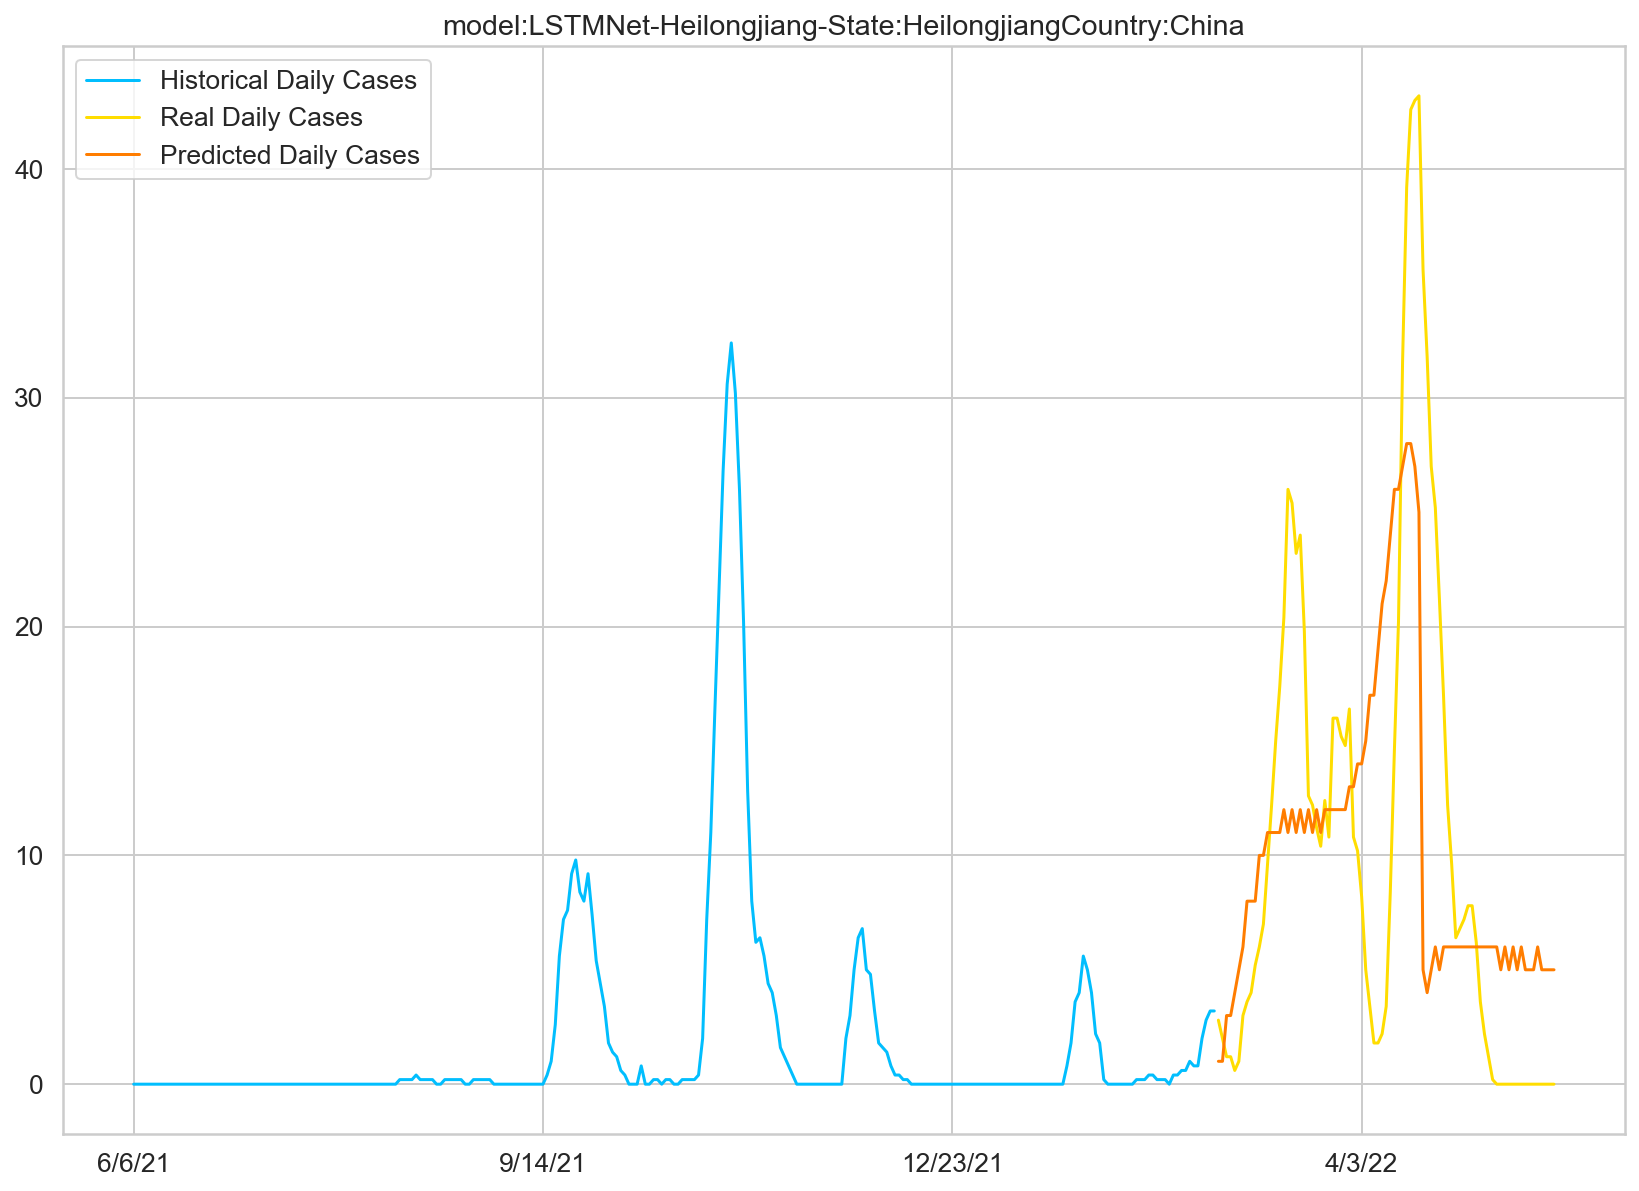

选择累计新增
266
84


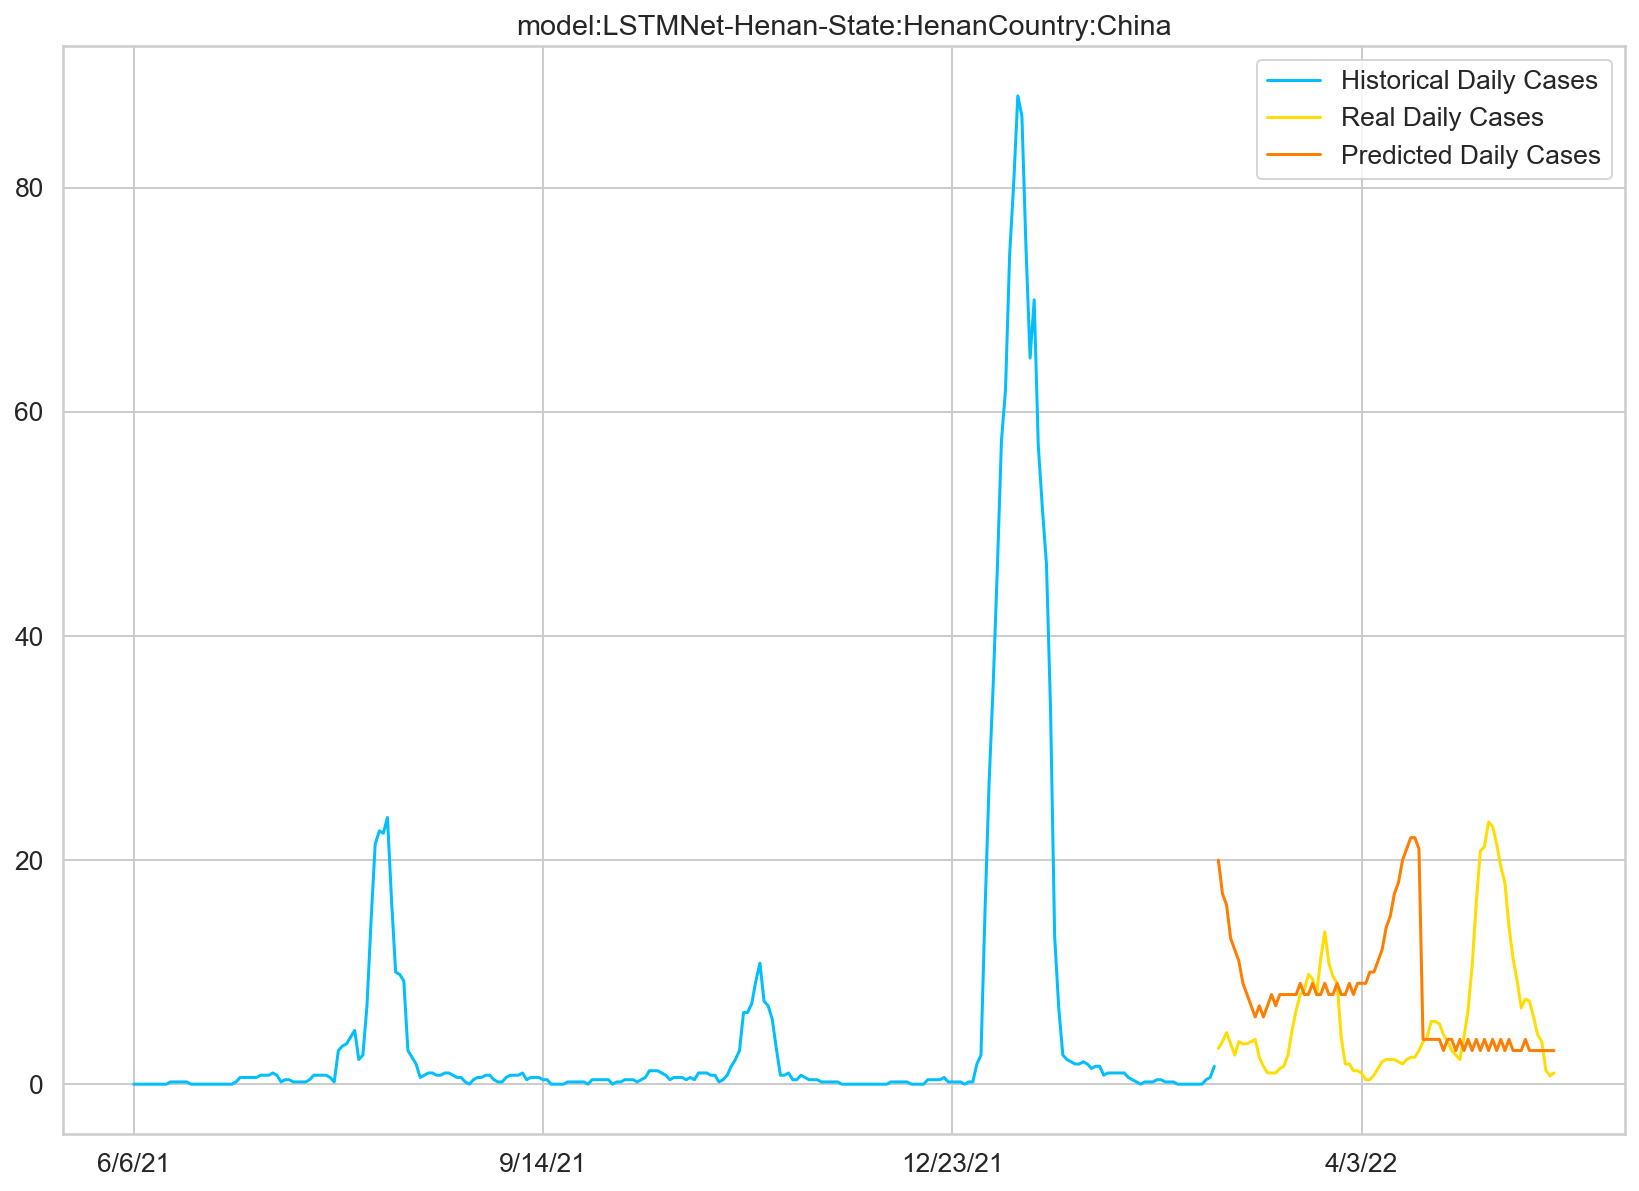

选择累计新增
266
84


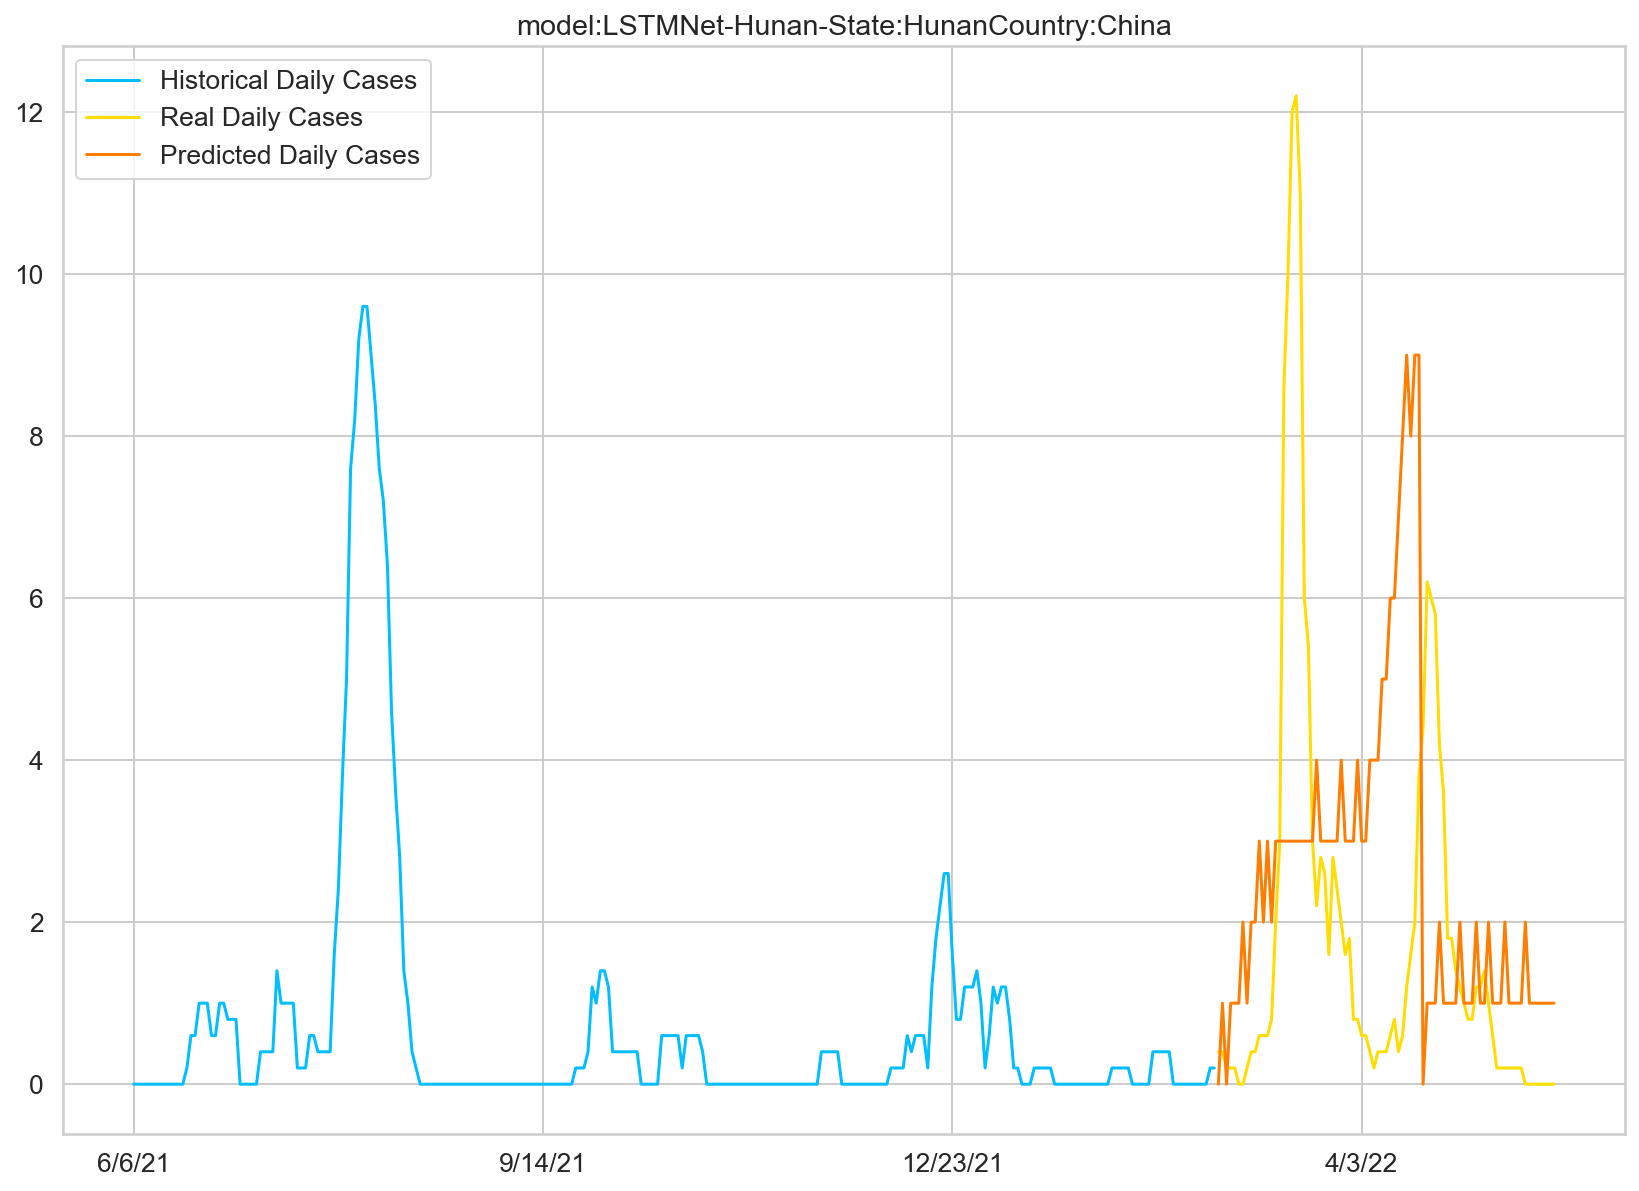

选择累计新增
266
84


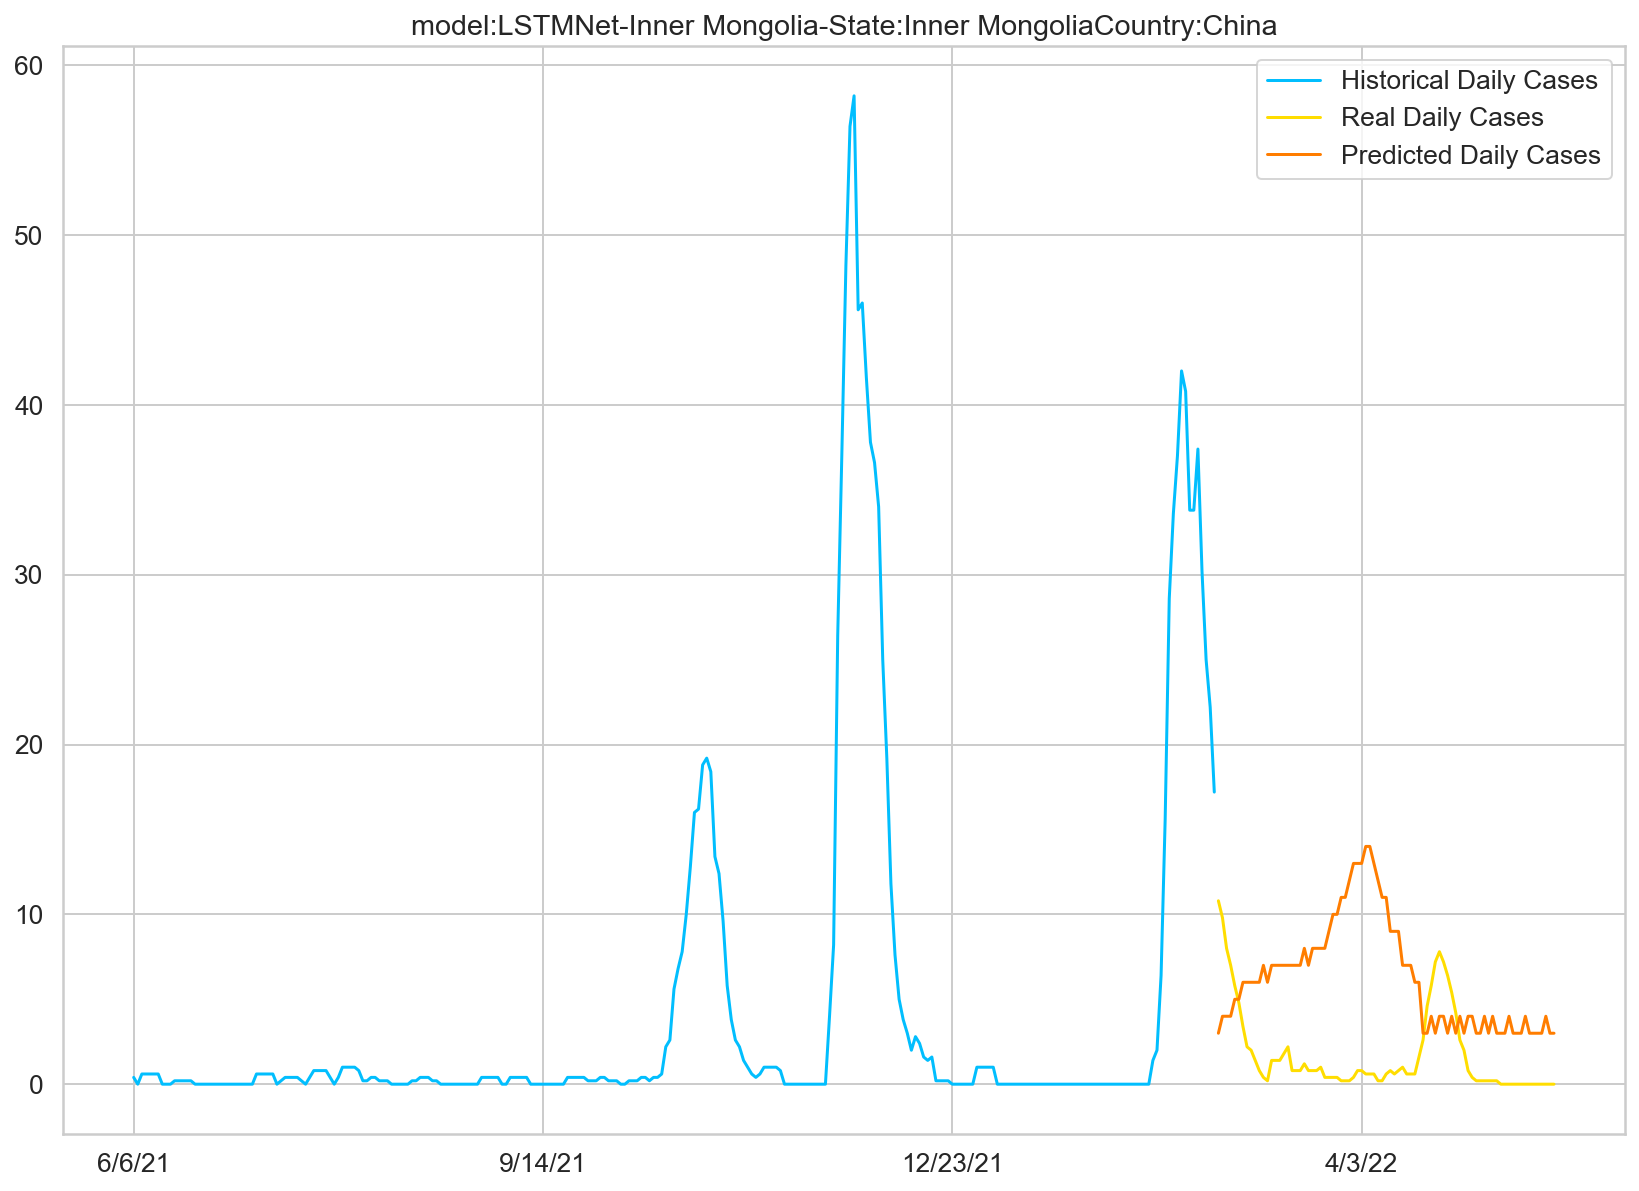

选择累计新增
266
84


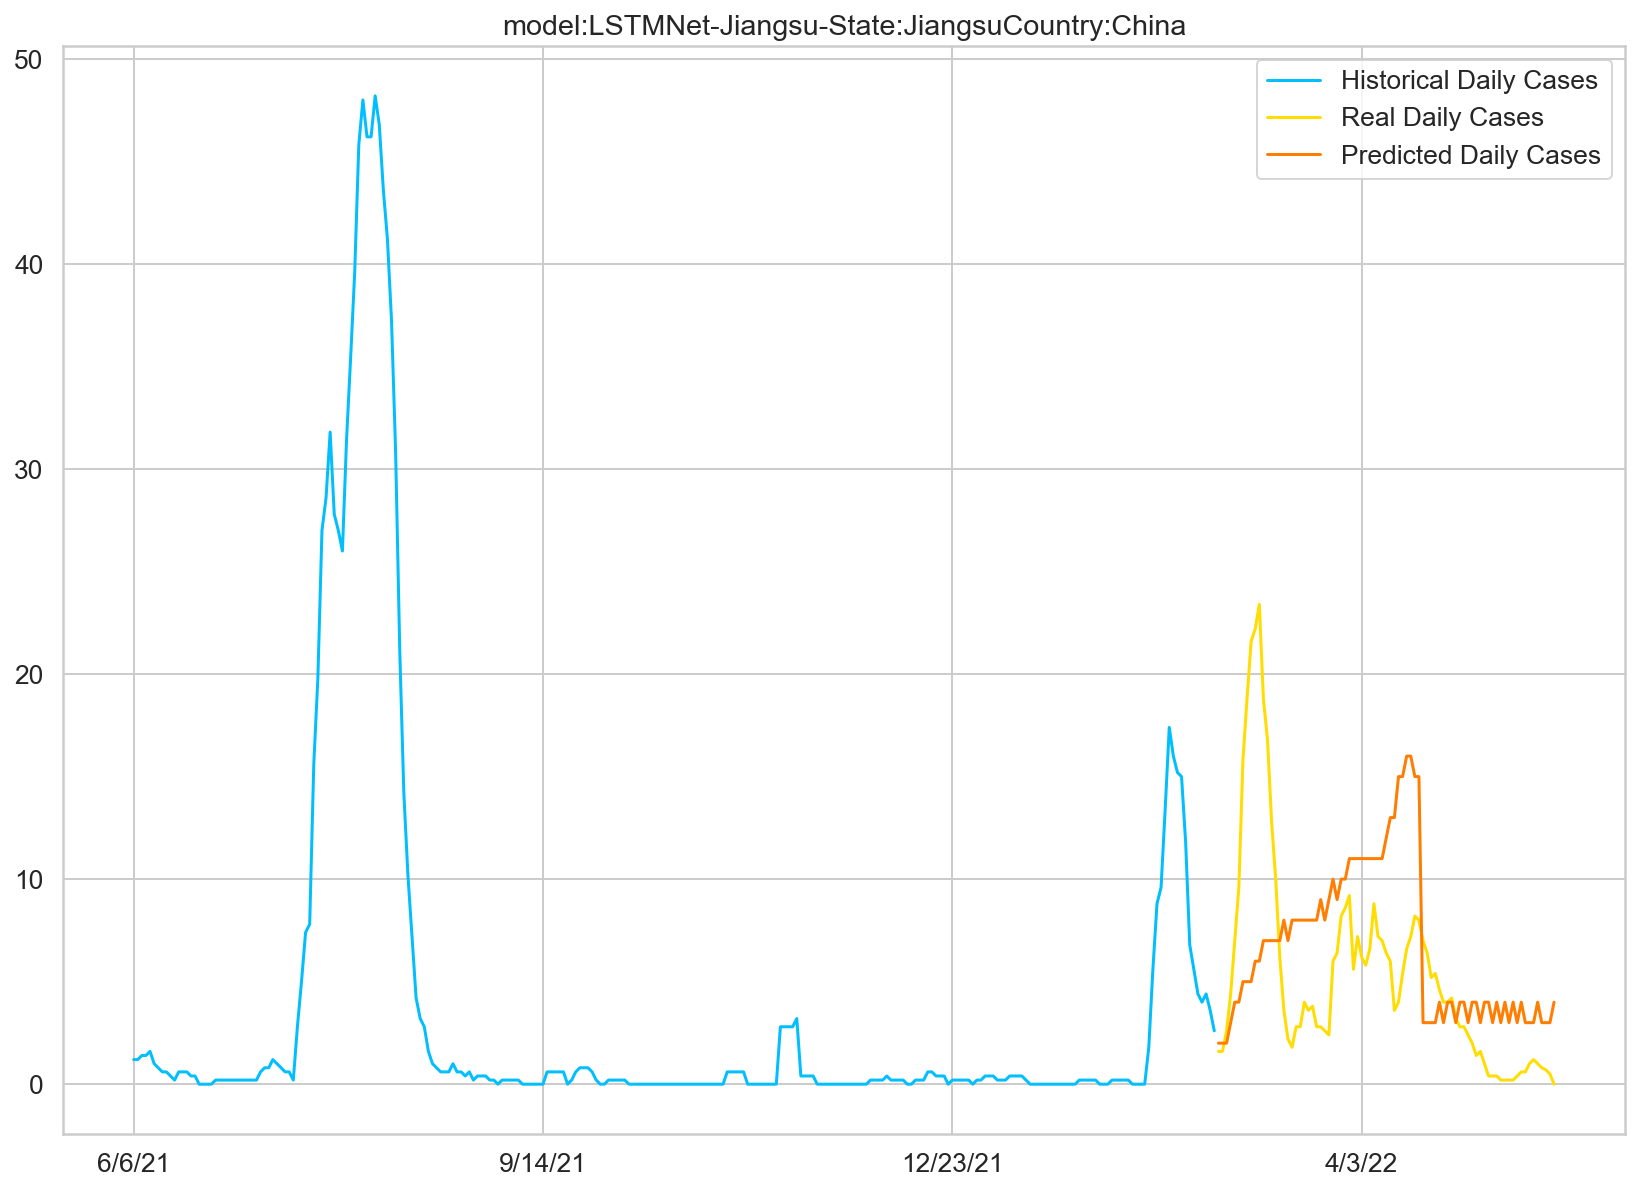

选择累计新增
266
84


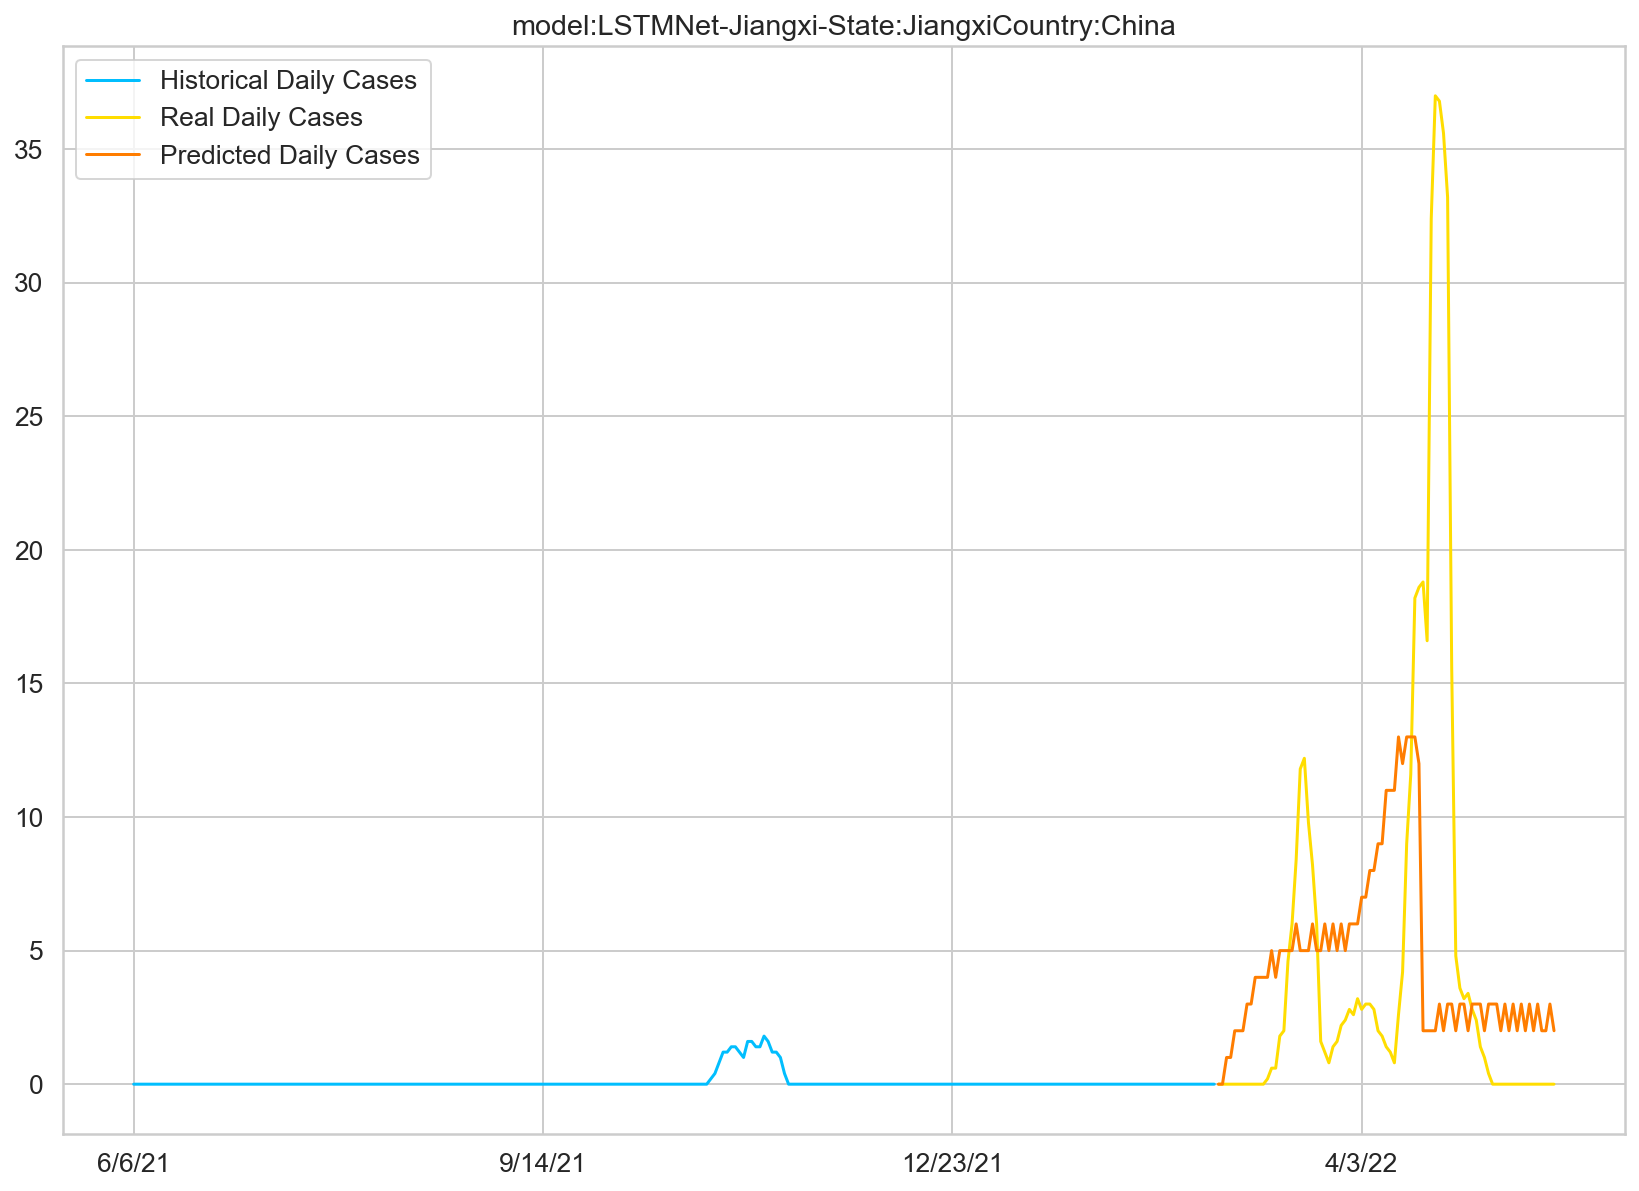

选择累计新增
266
84


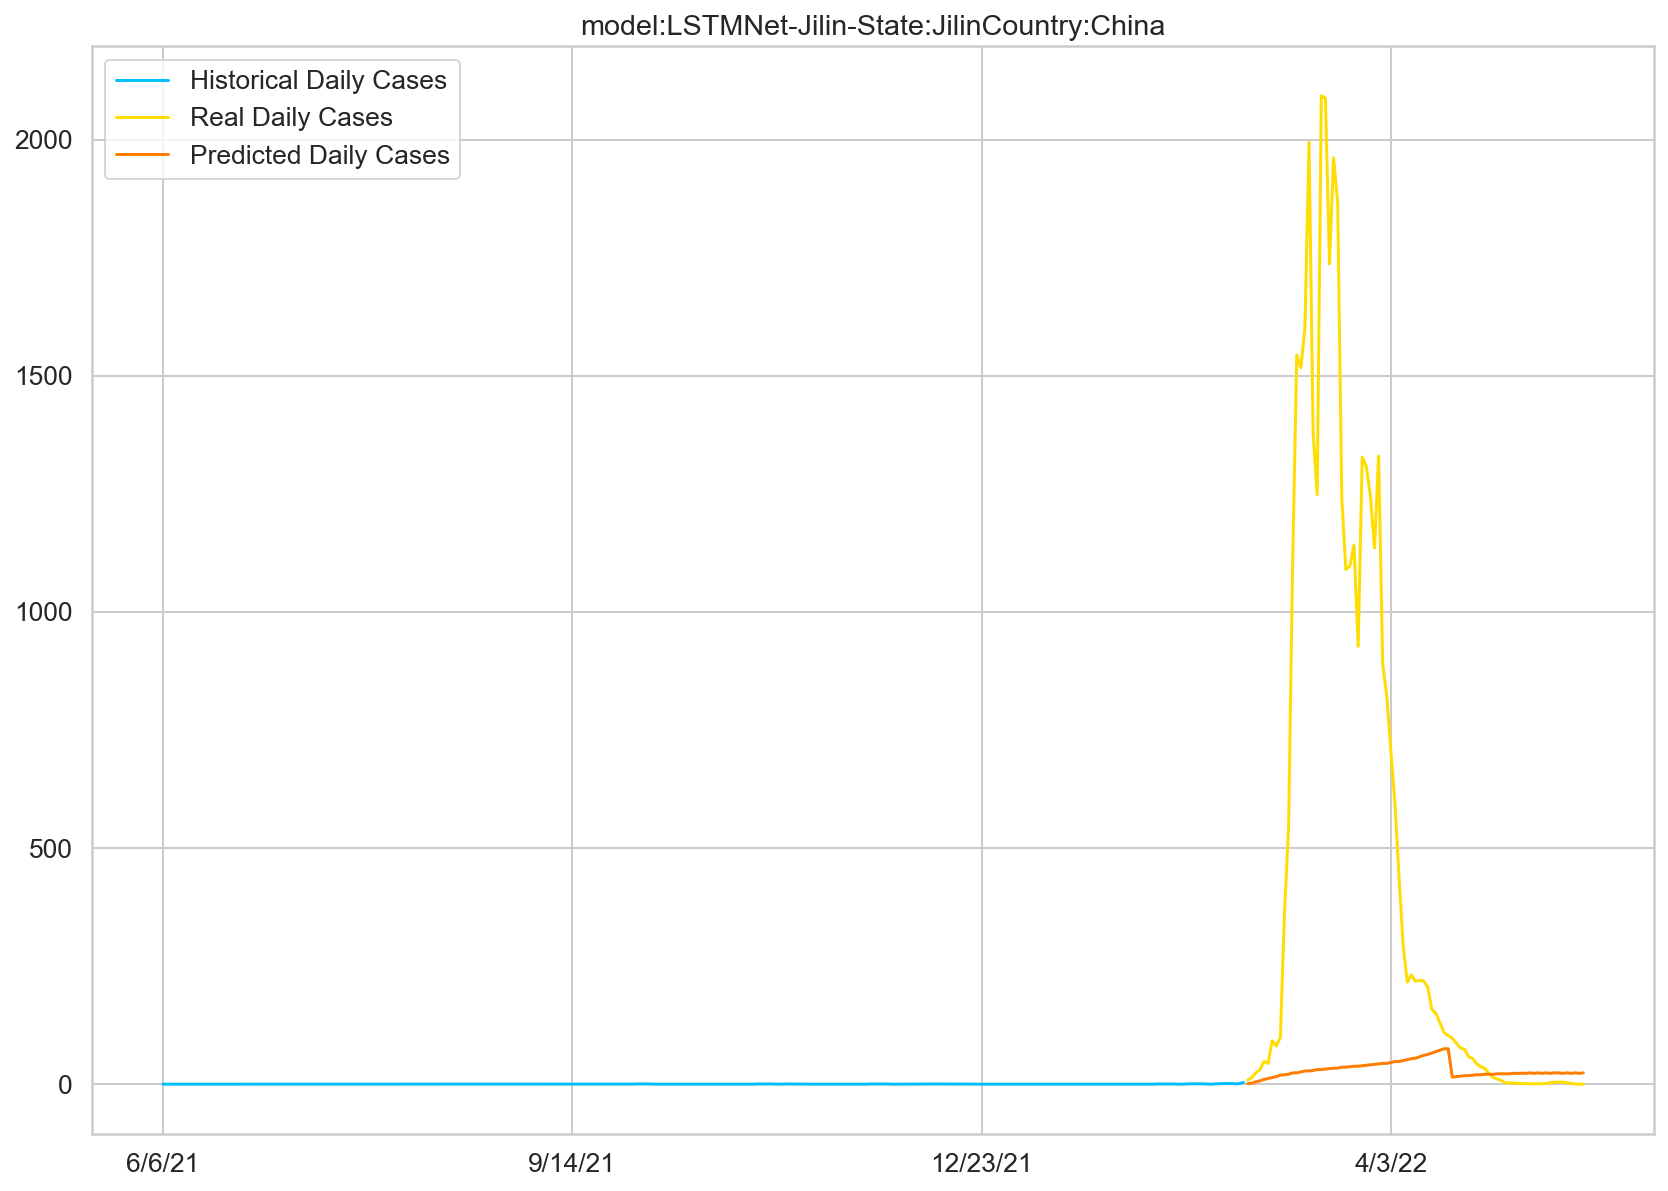

选择累计新增
266
84


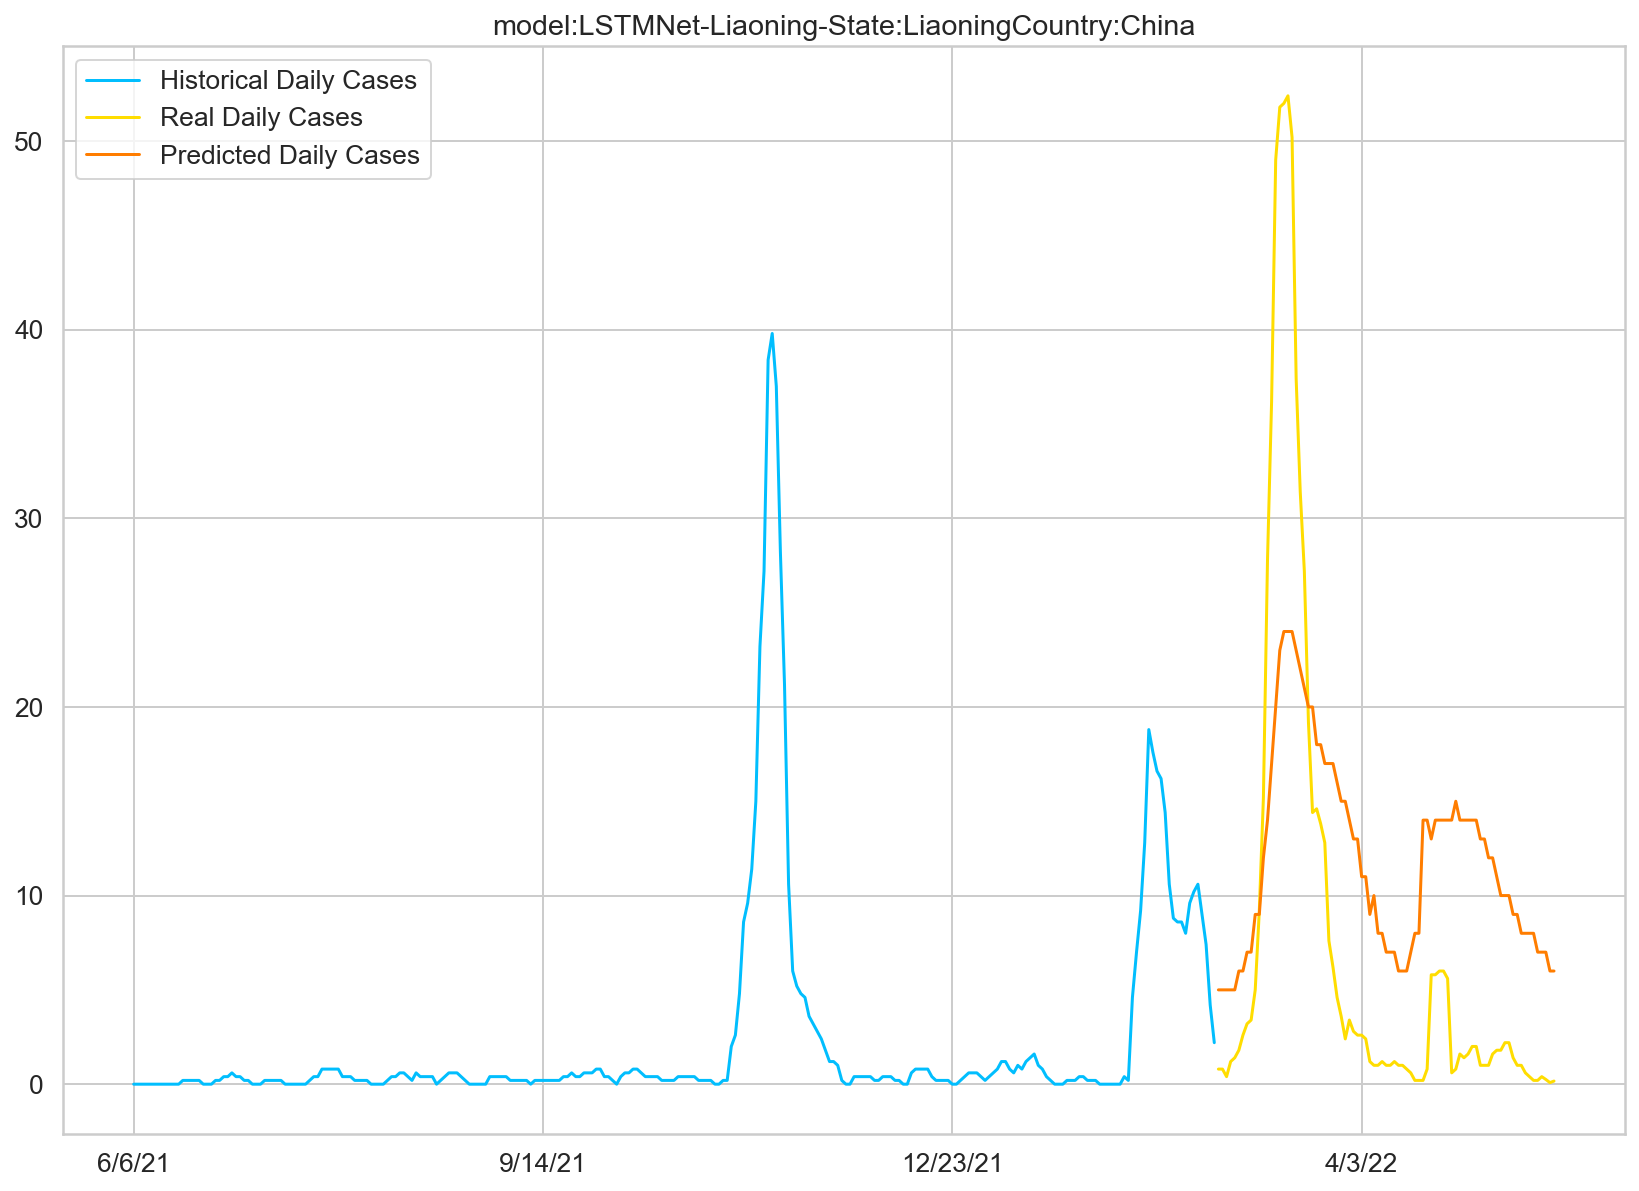

选择累计新增
266
84


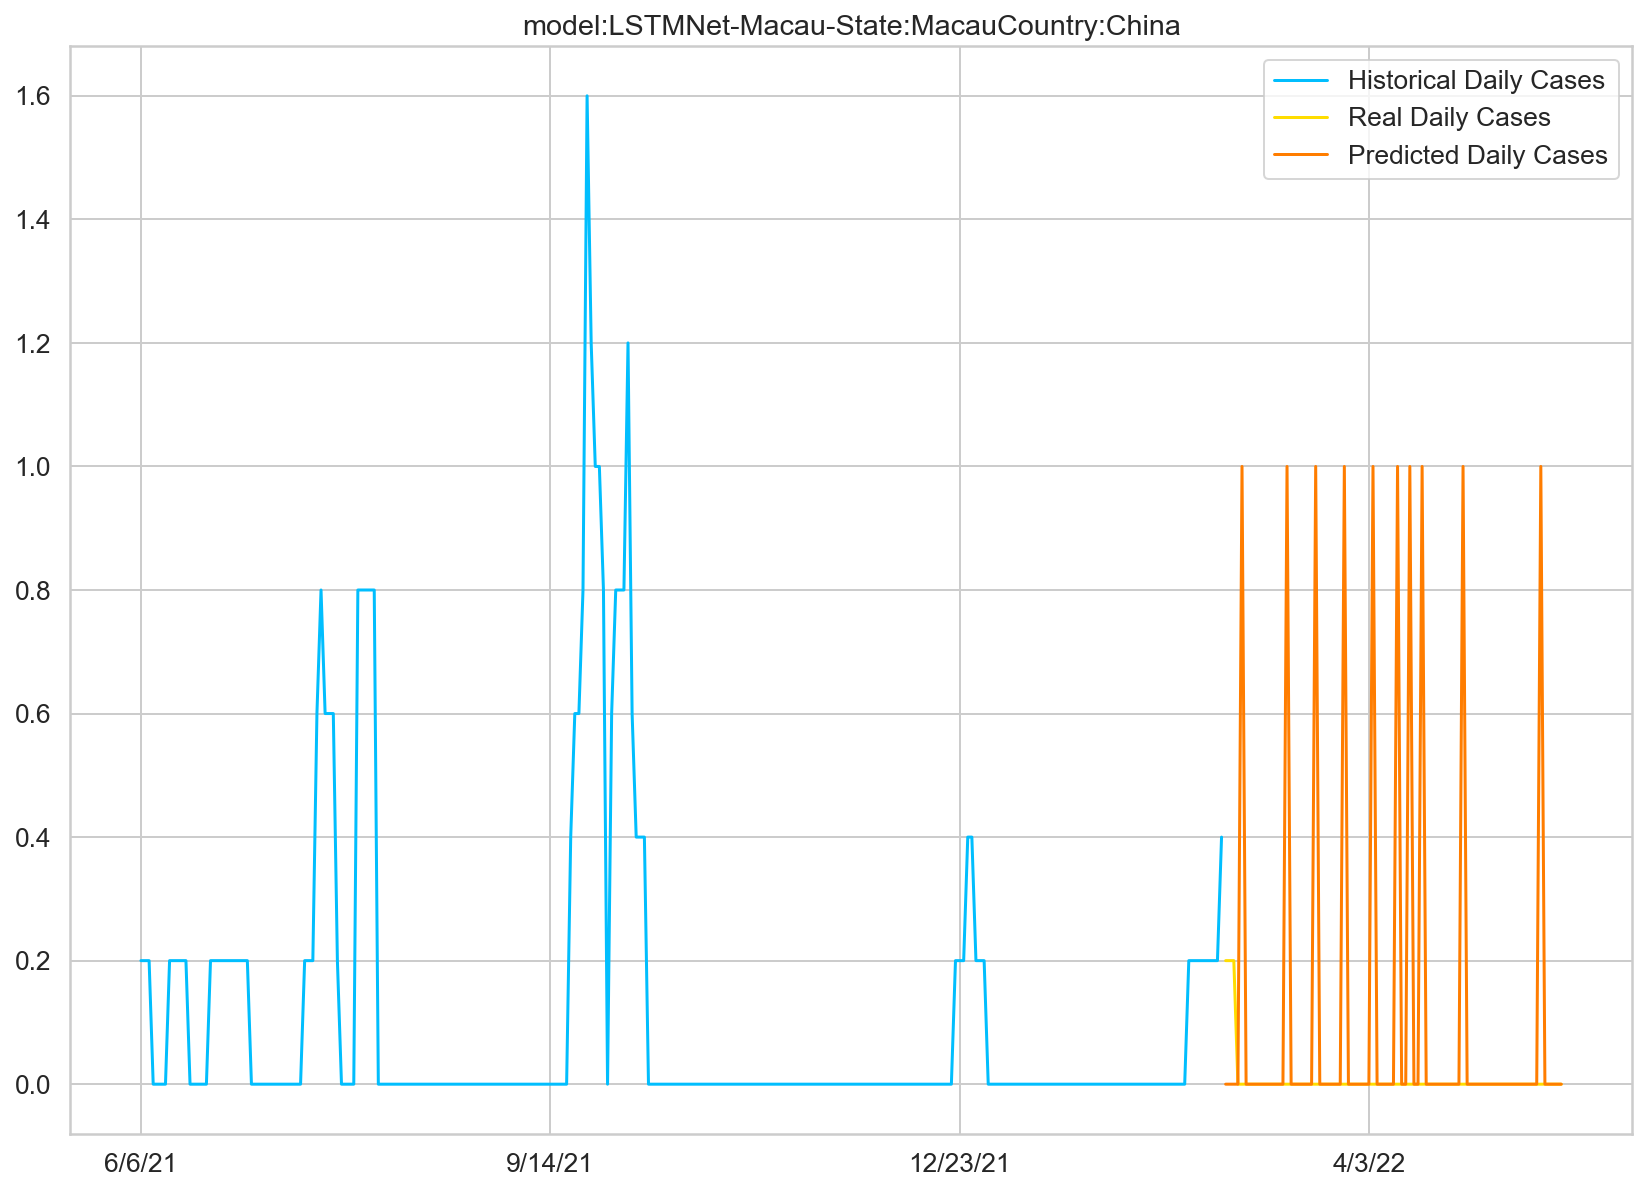

选择累计新增
266
84


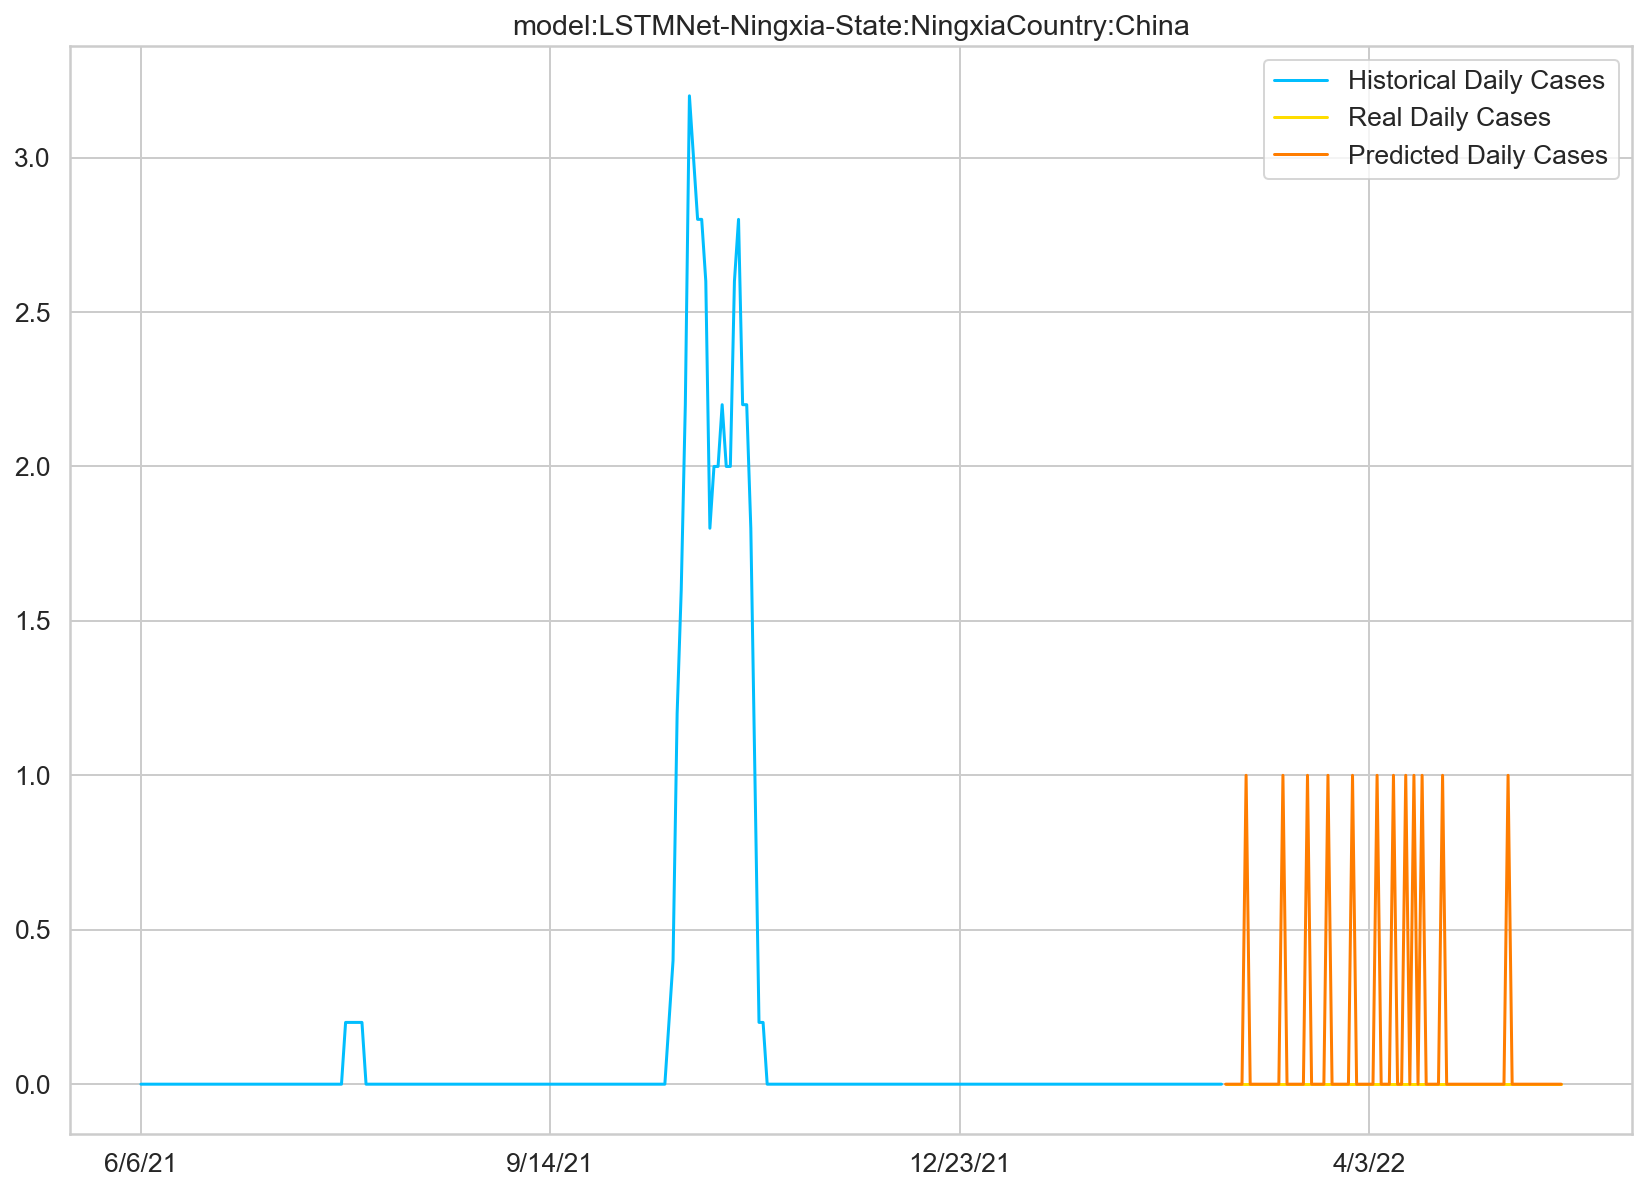

选择累计新增
266
84


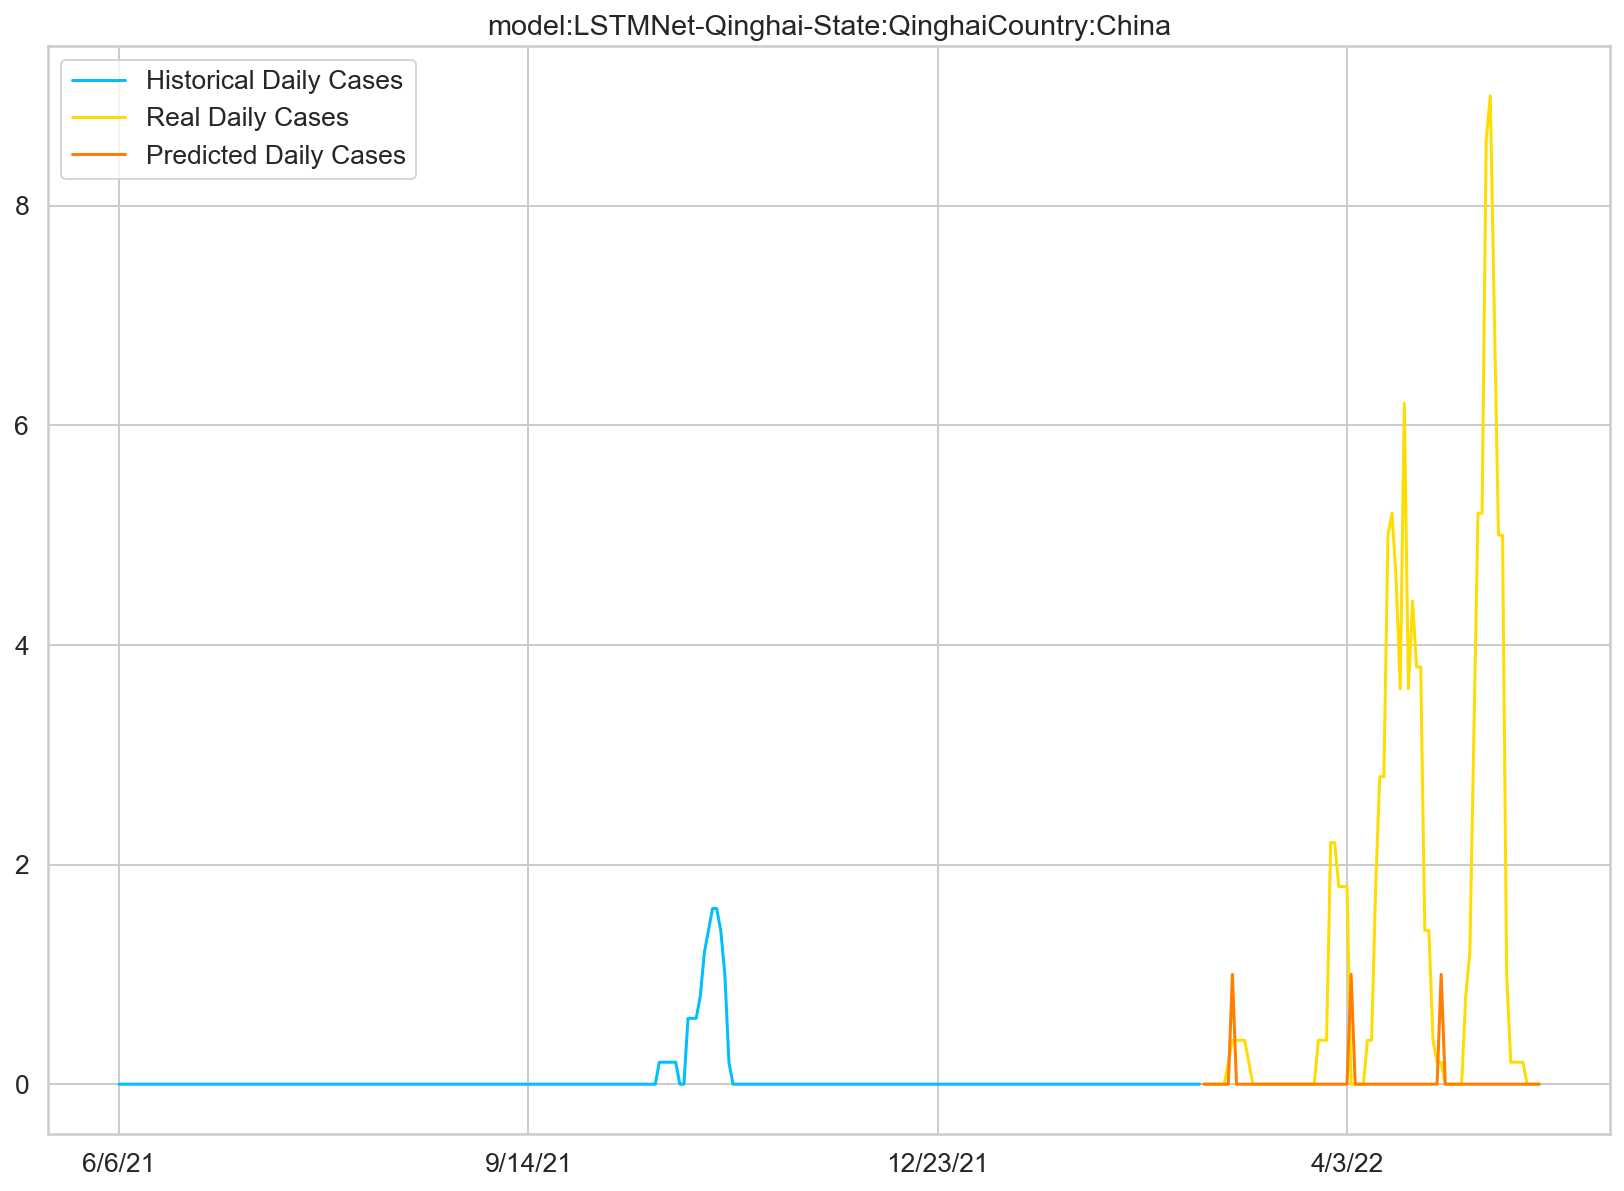

选择累计新增
266
84


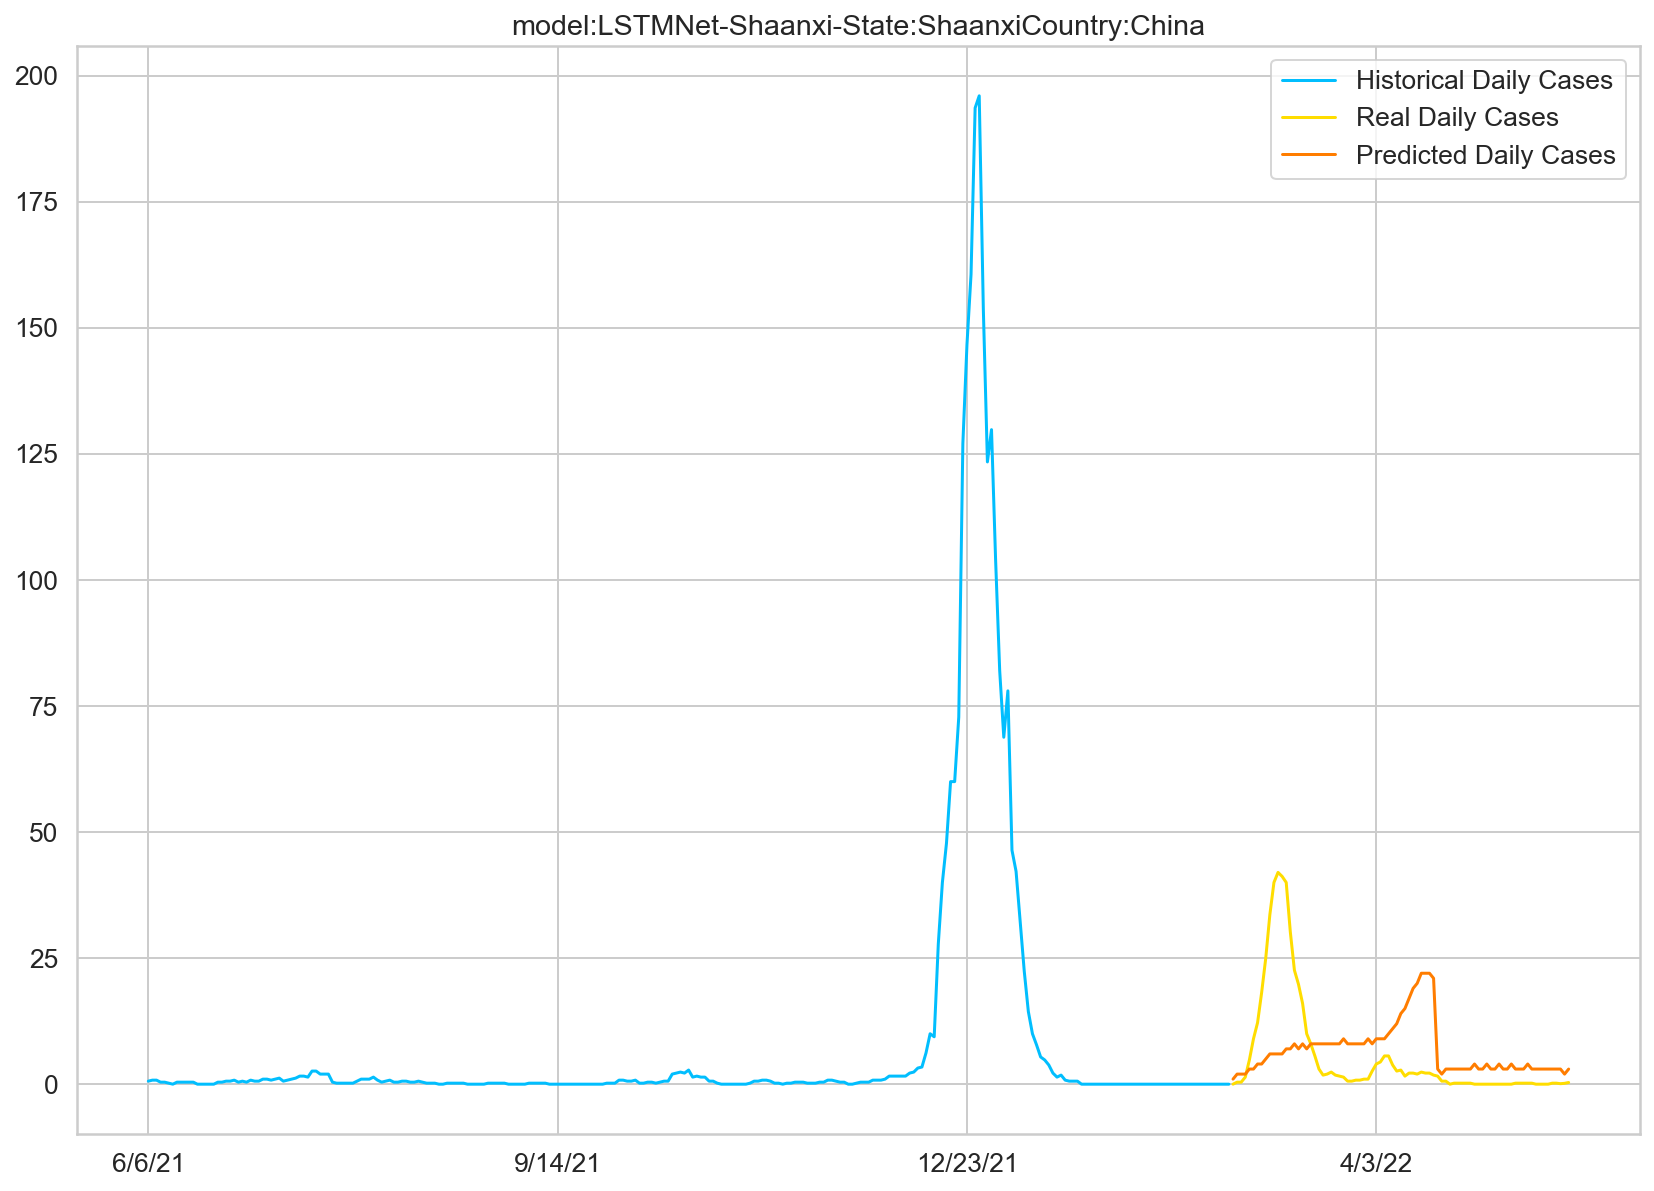

选择累计新增
266
84


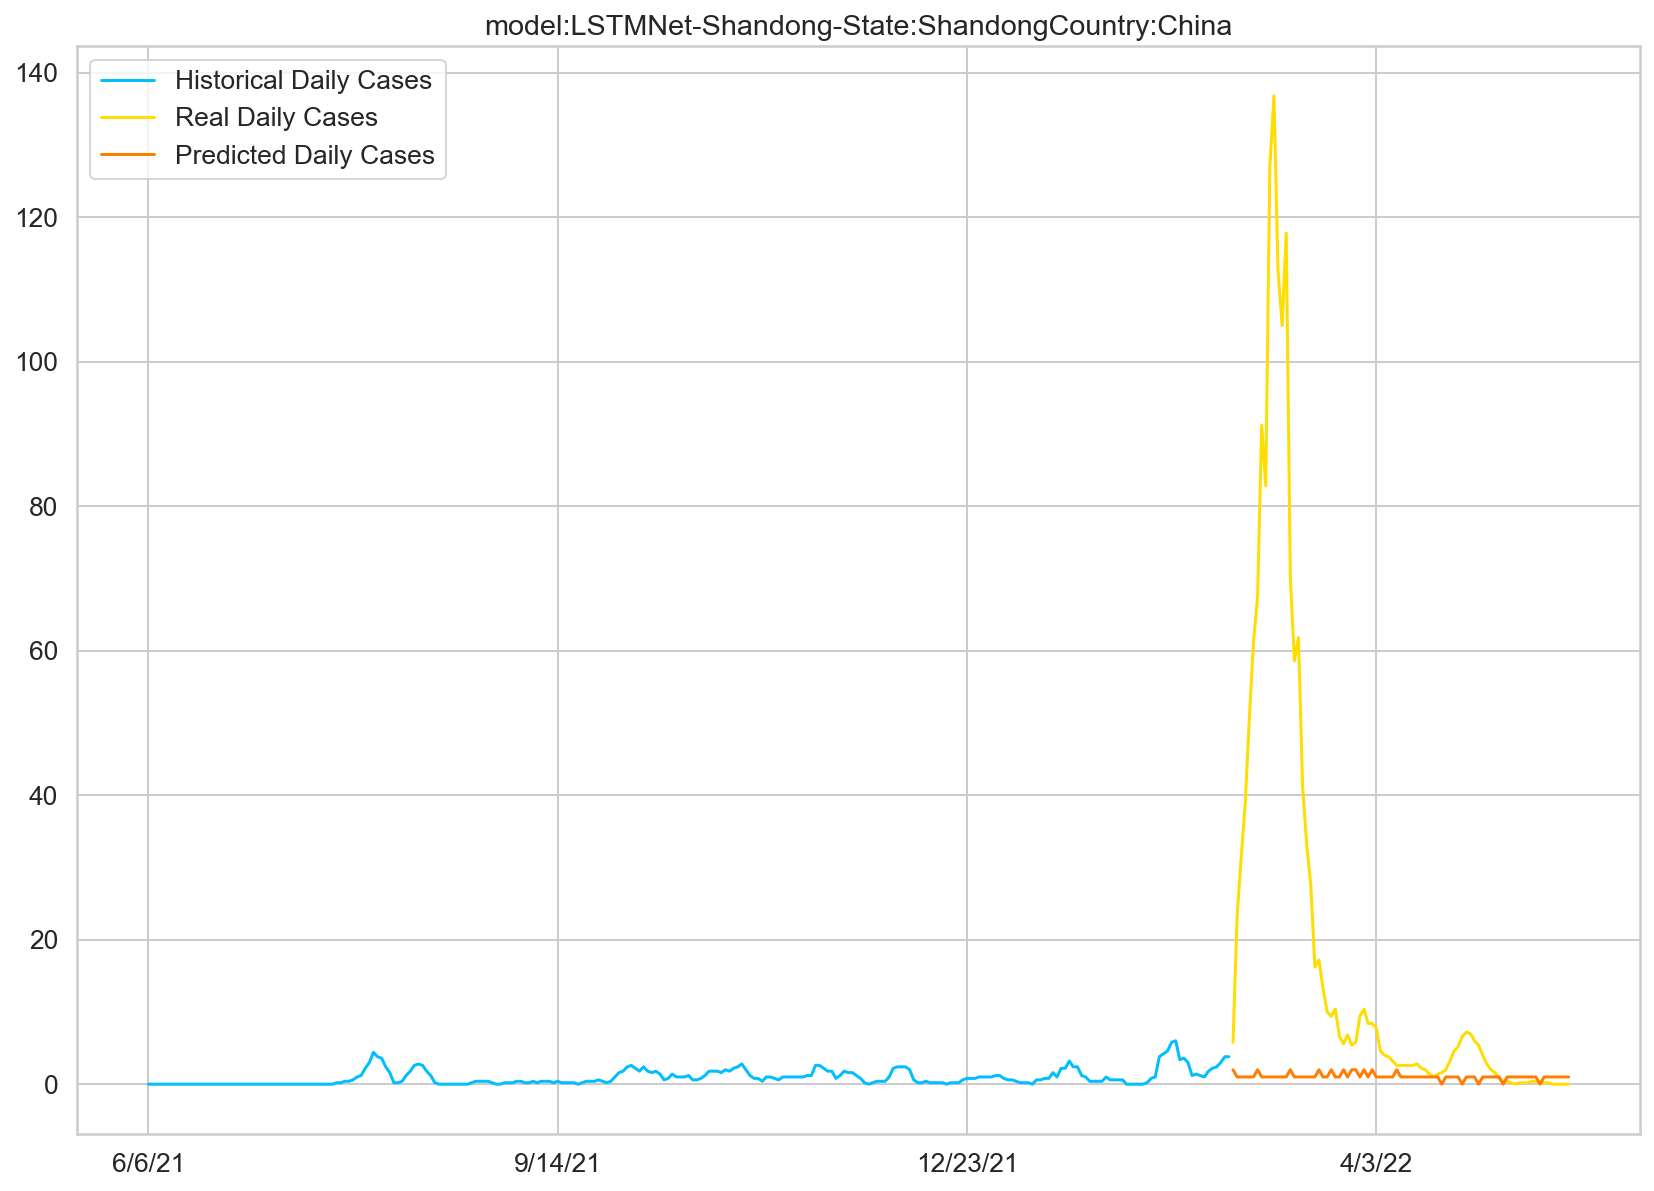

选择累计新增
266
84


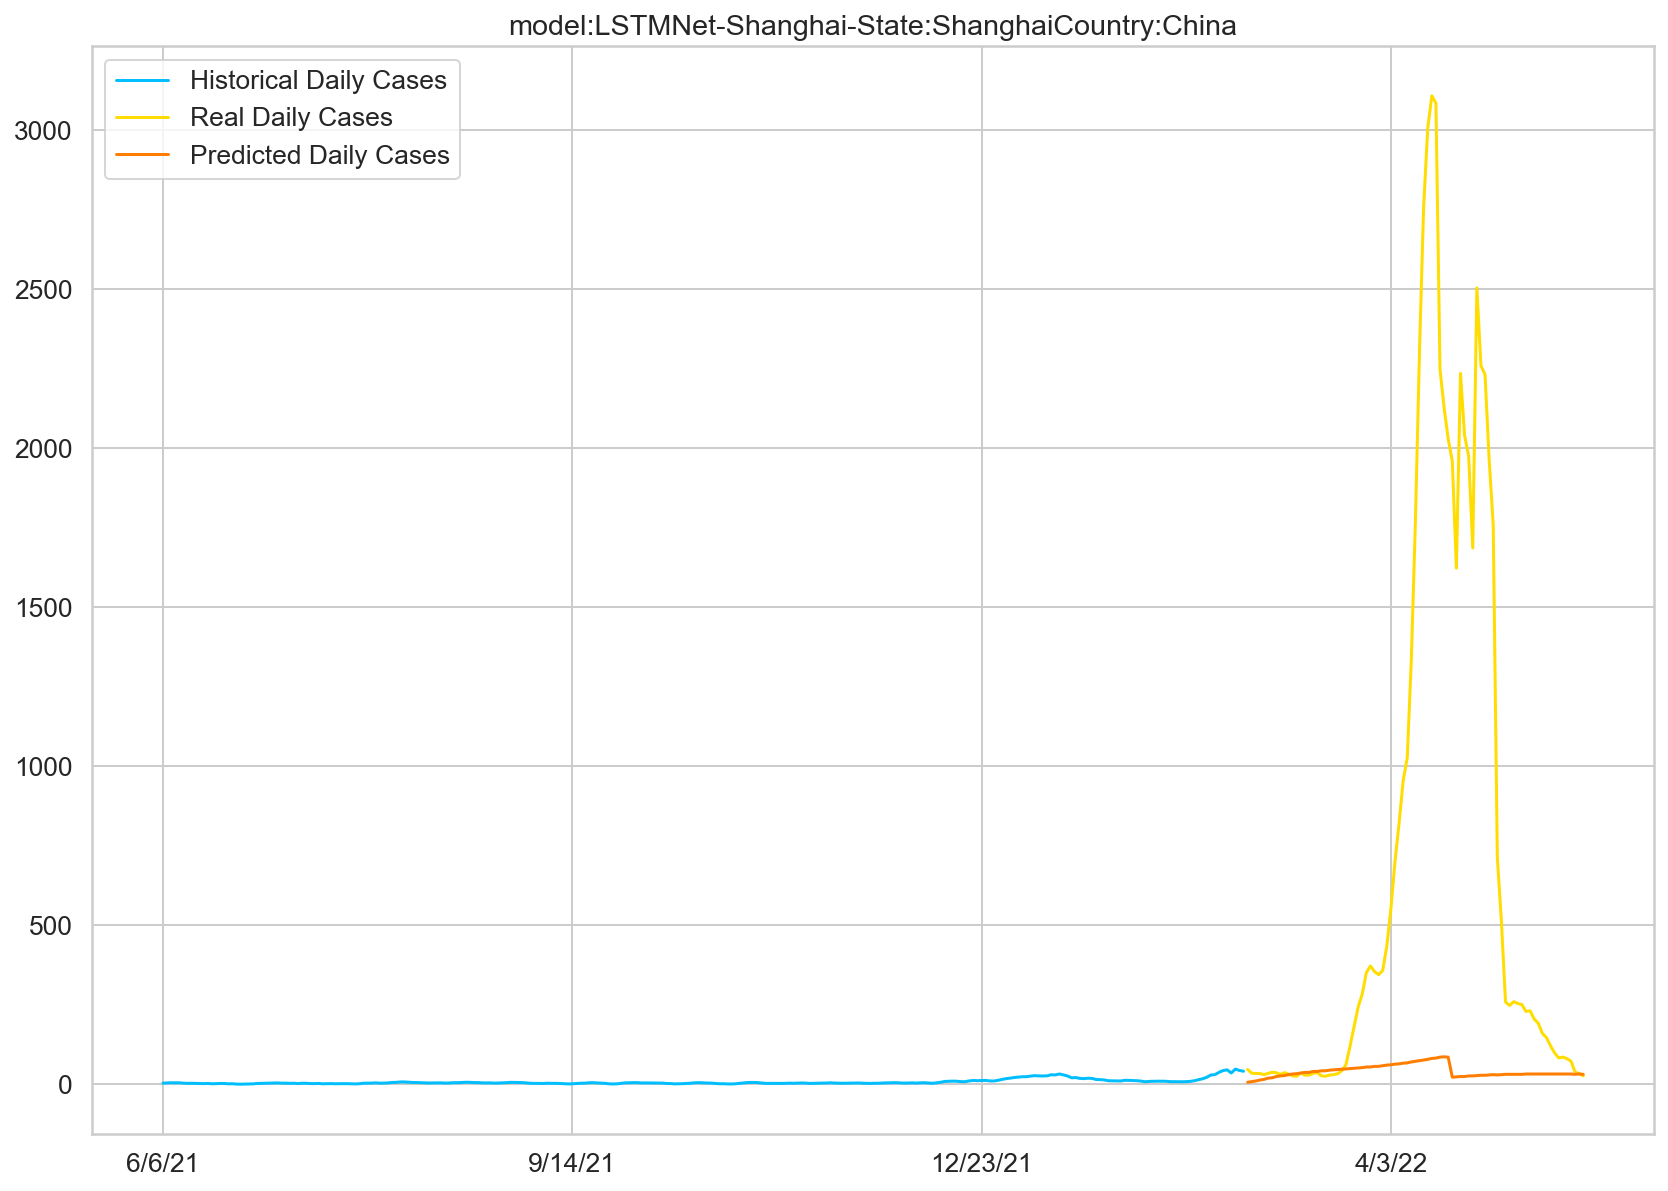

选择累计新增
266
84


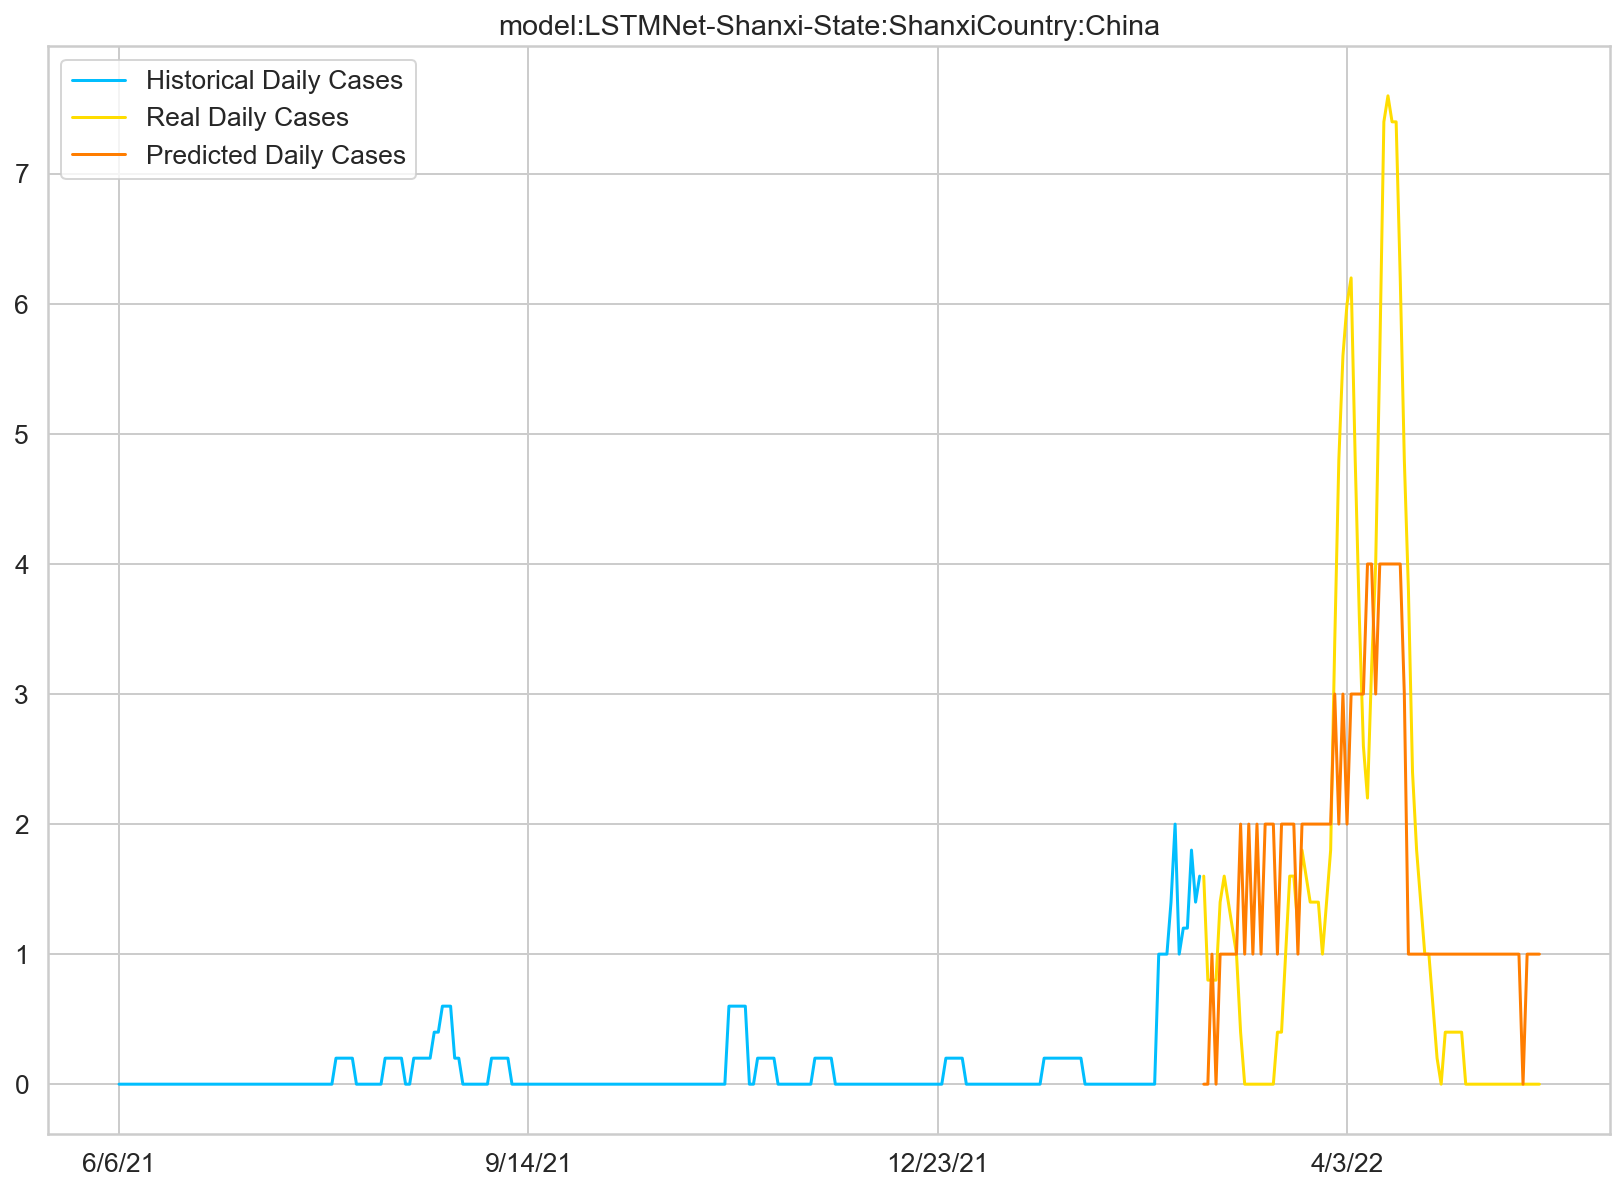

选择累计新增
266
84


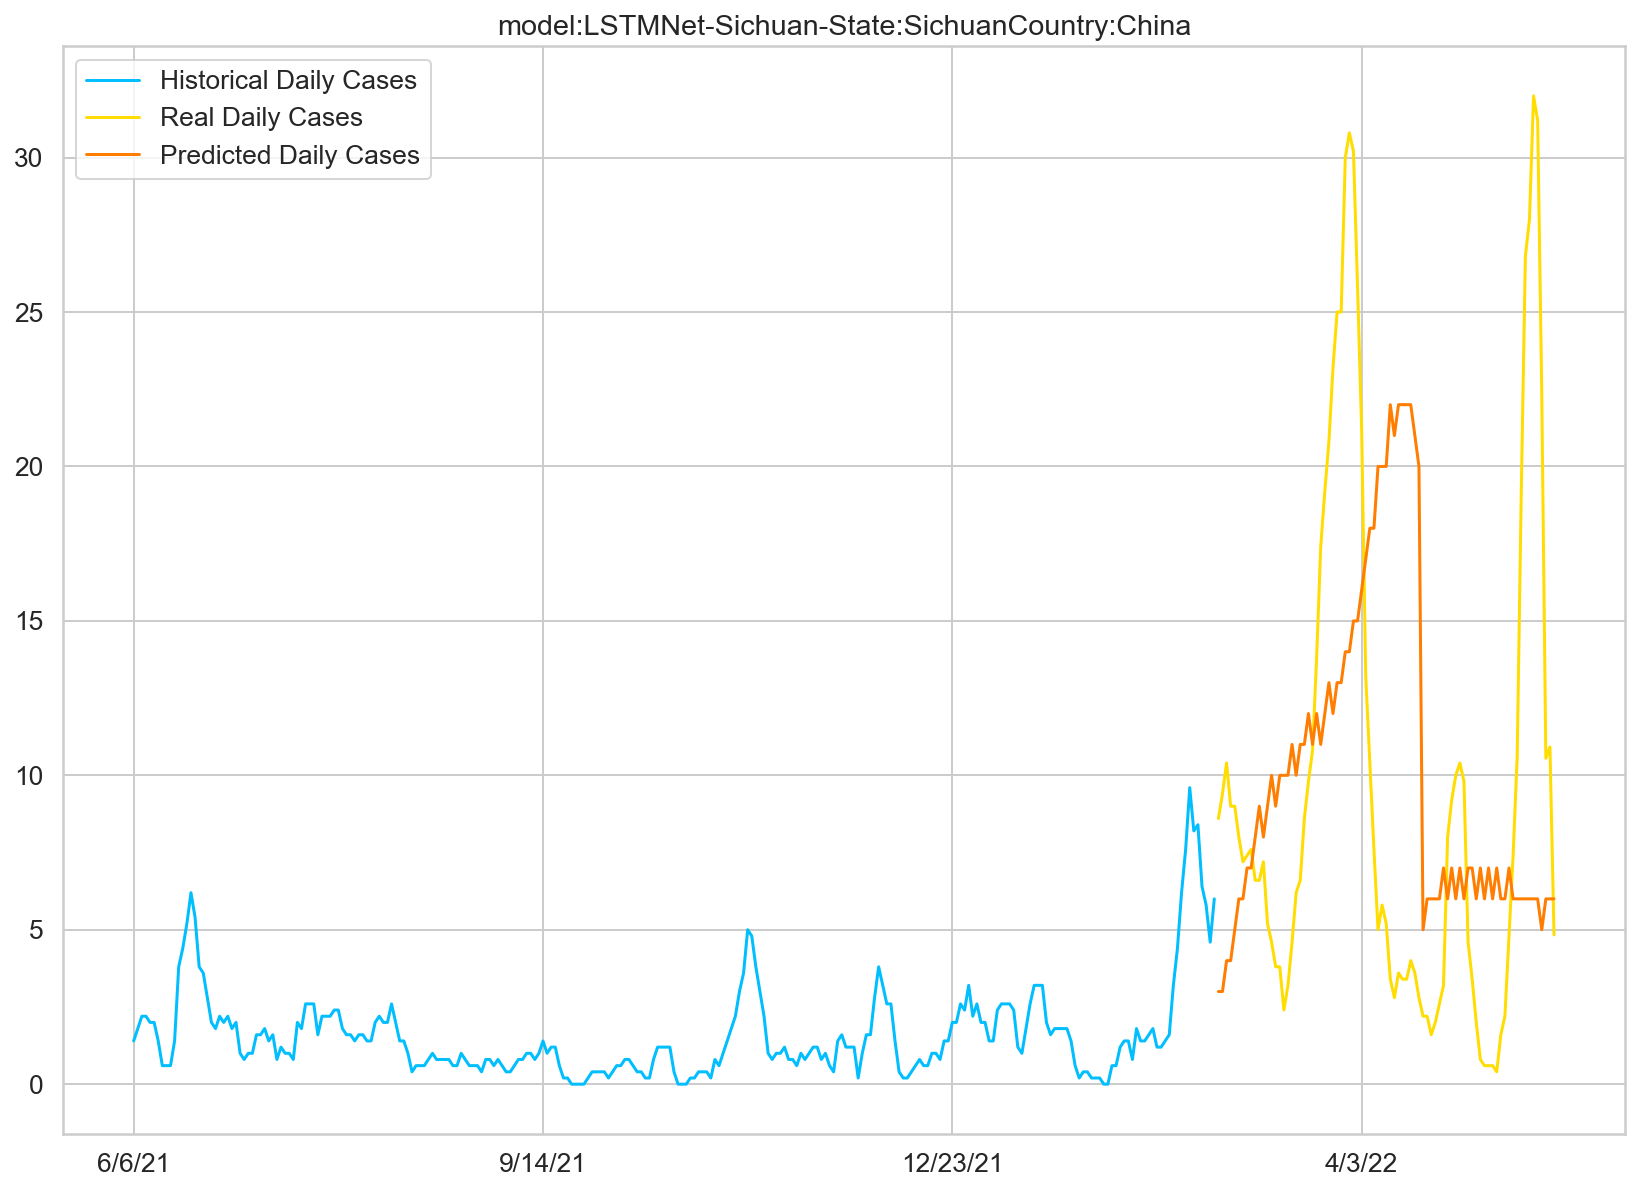

选择累计新增
266
84


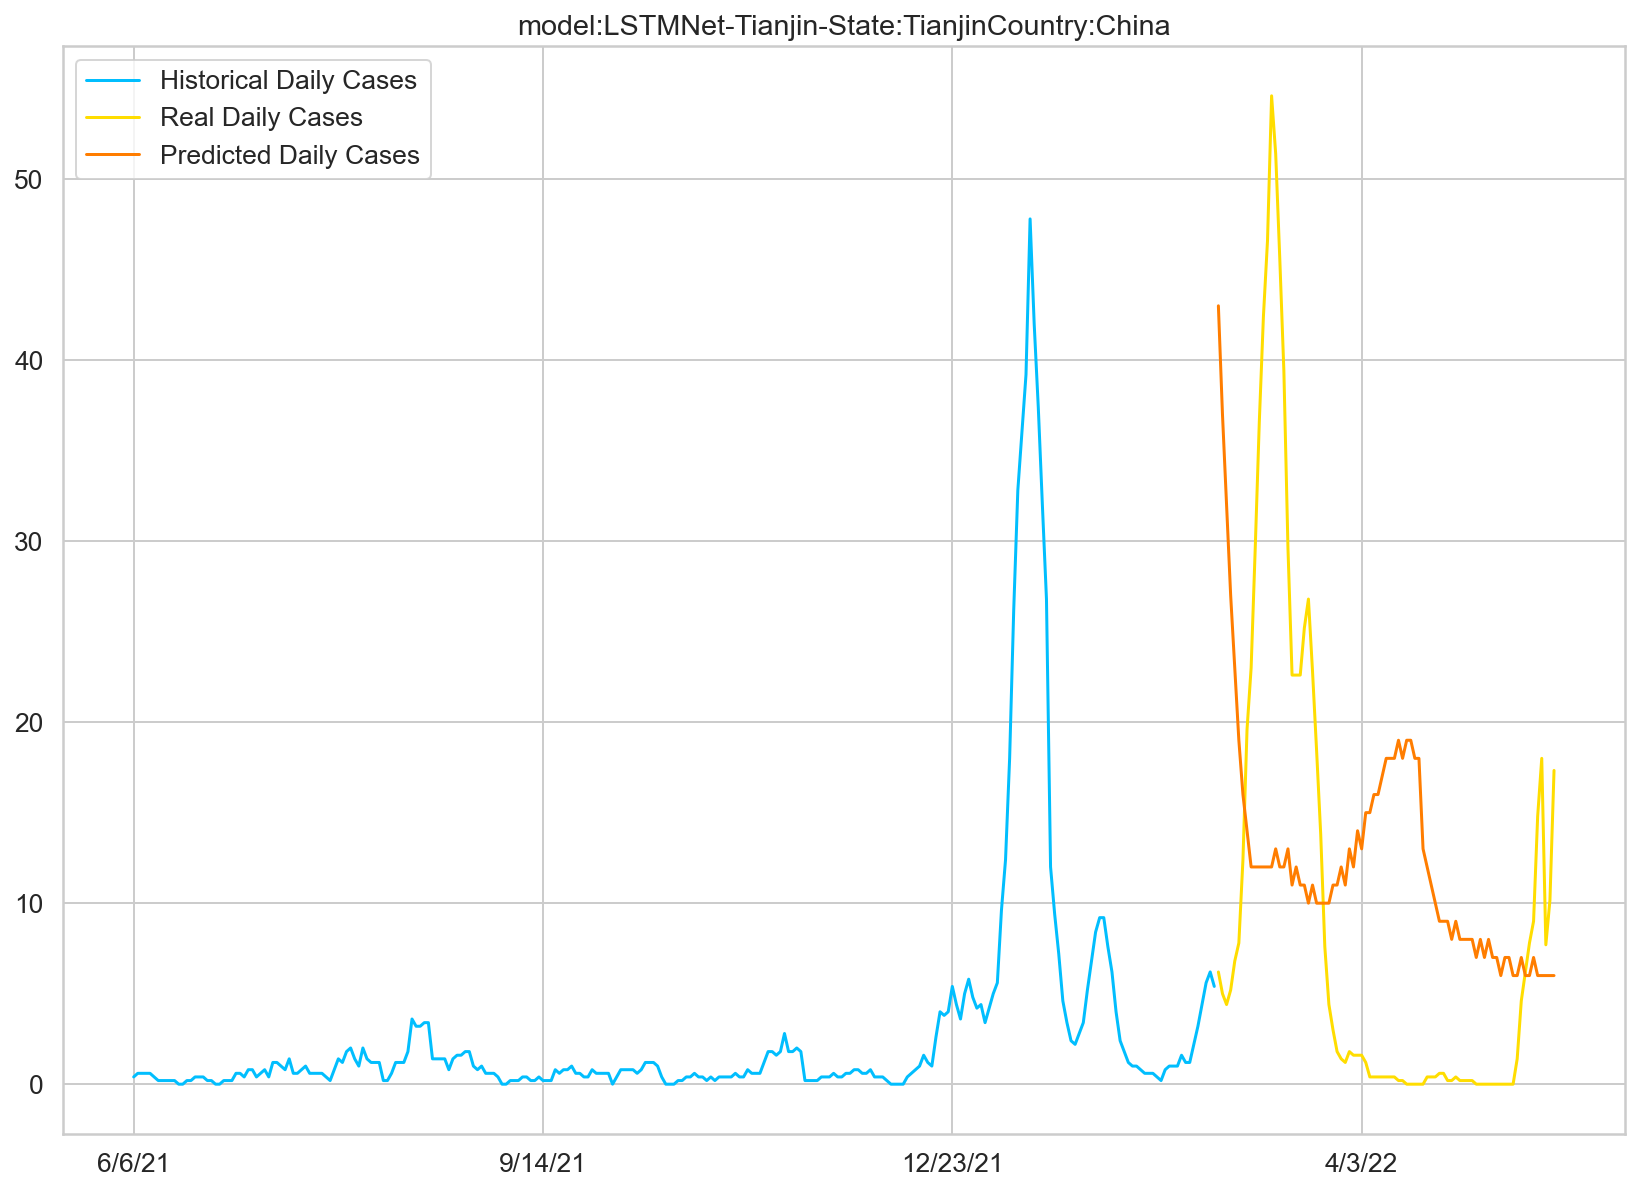

选择累计新增
266
84


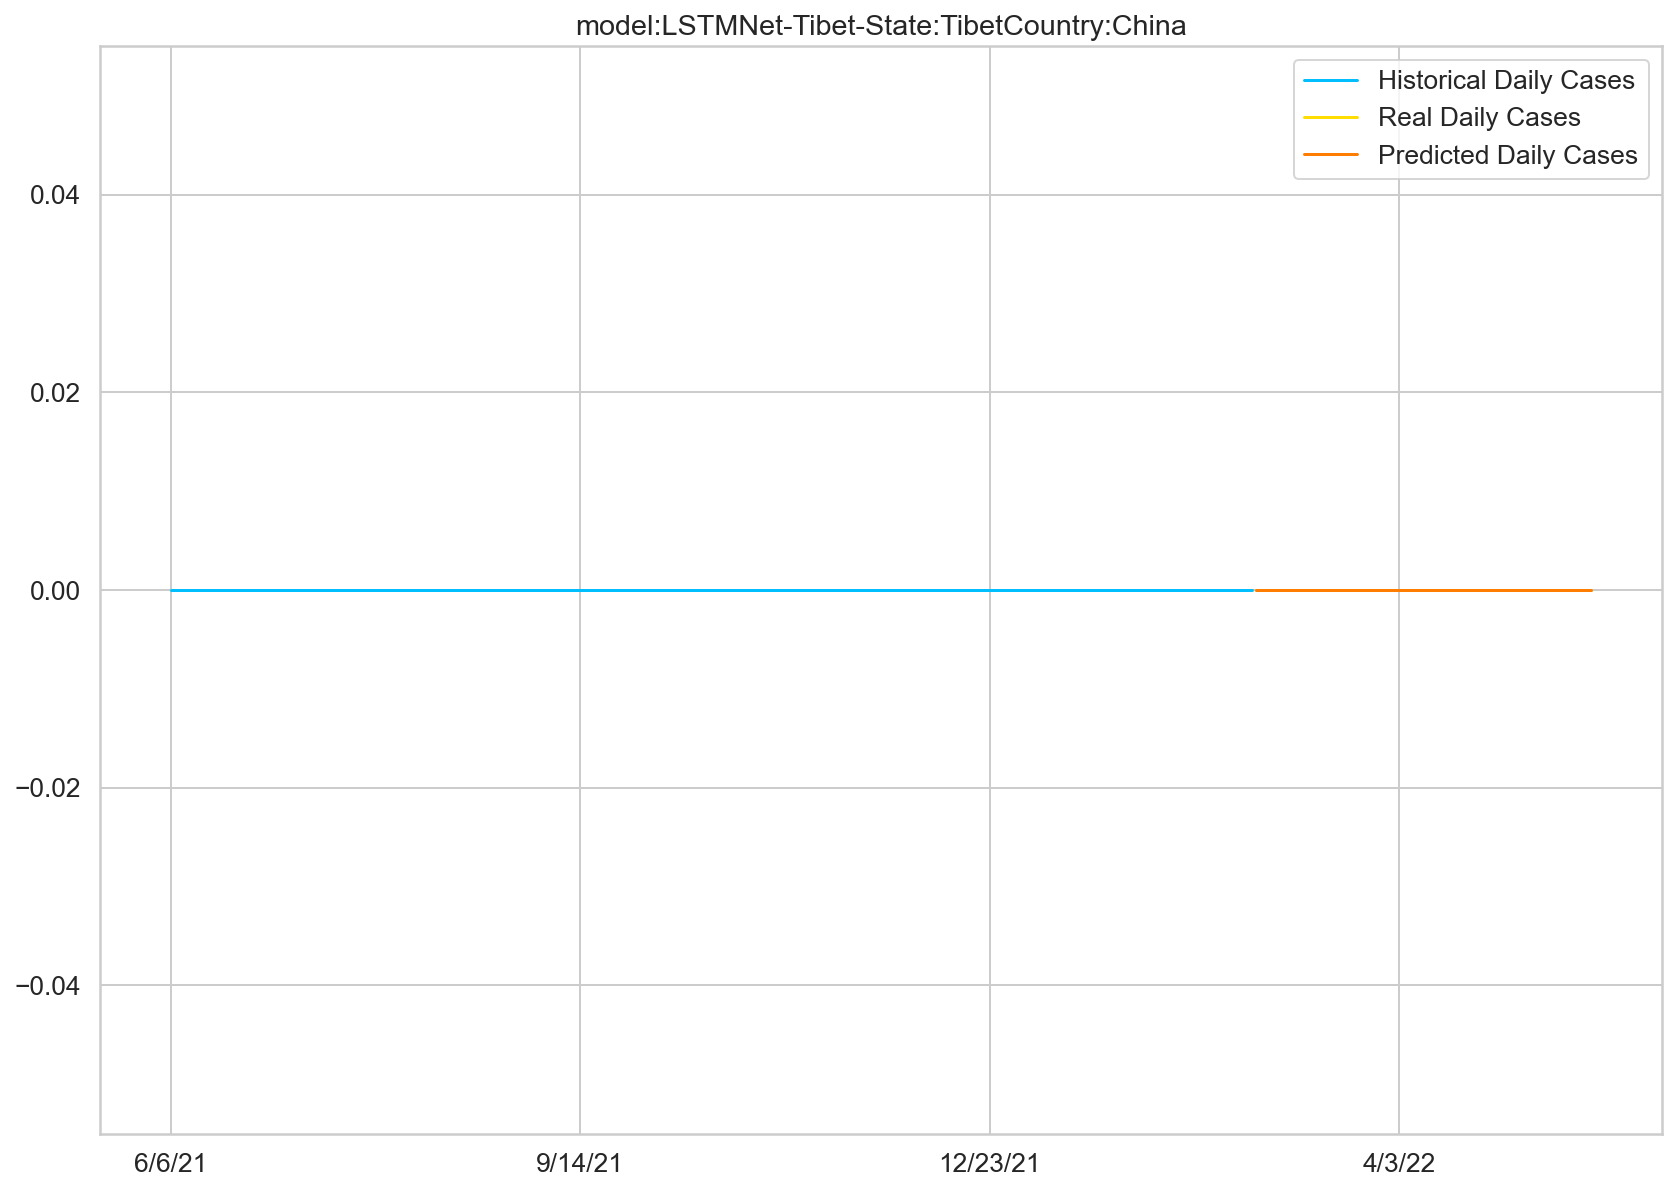

选择累计新增
266
84


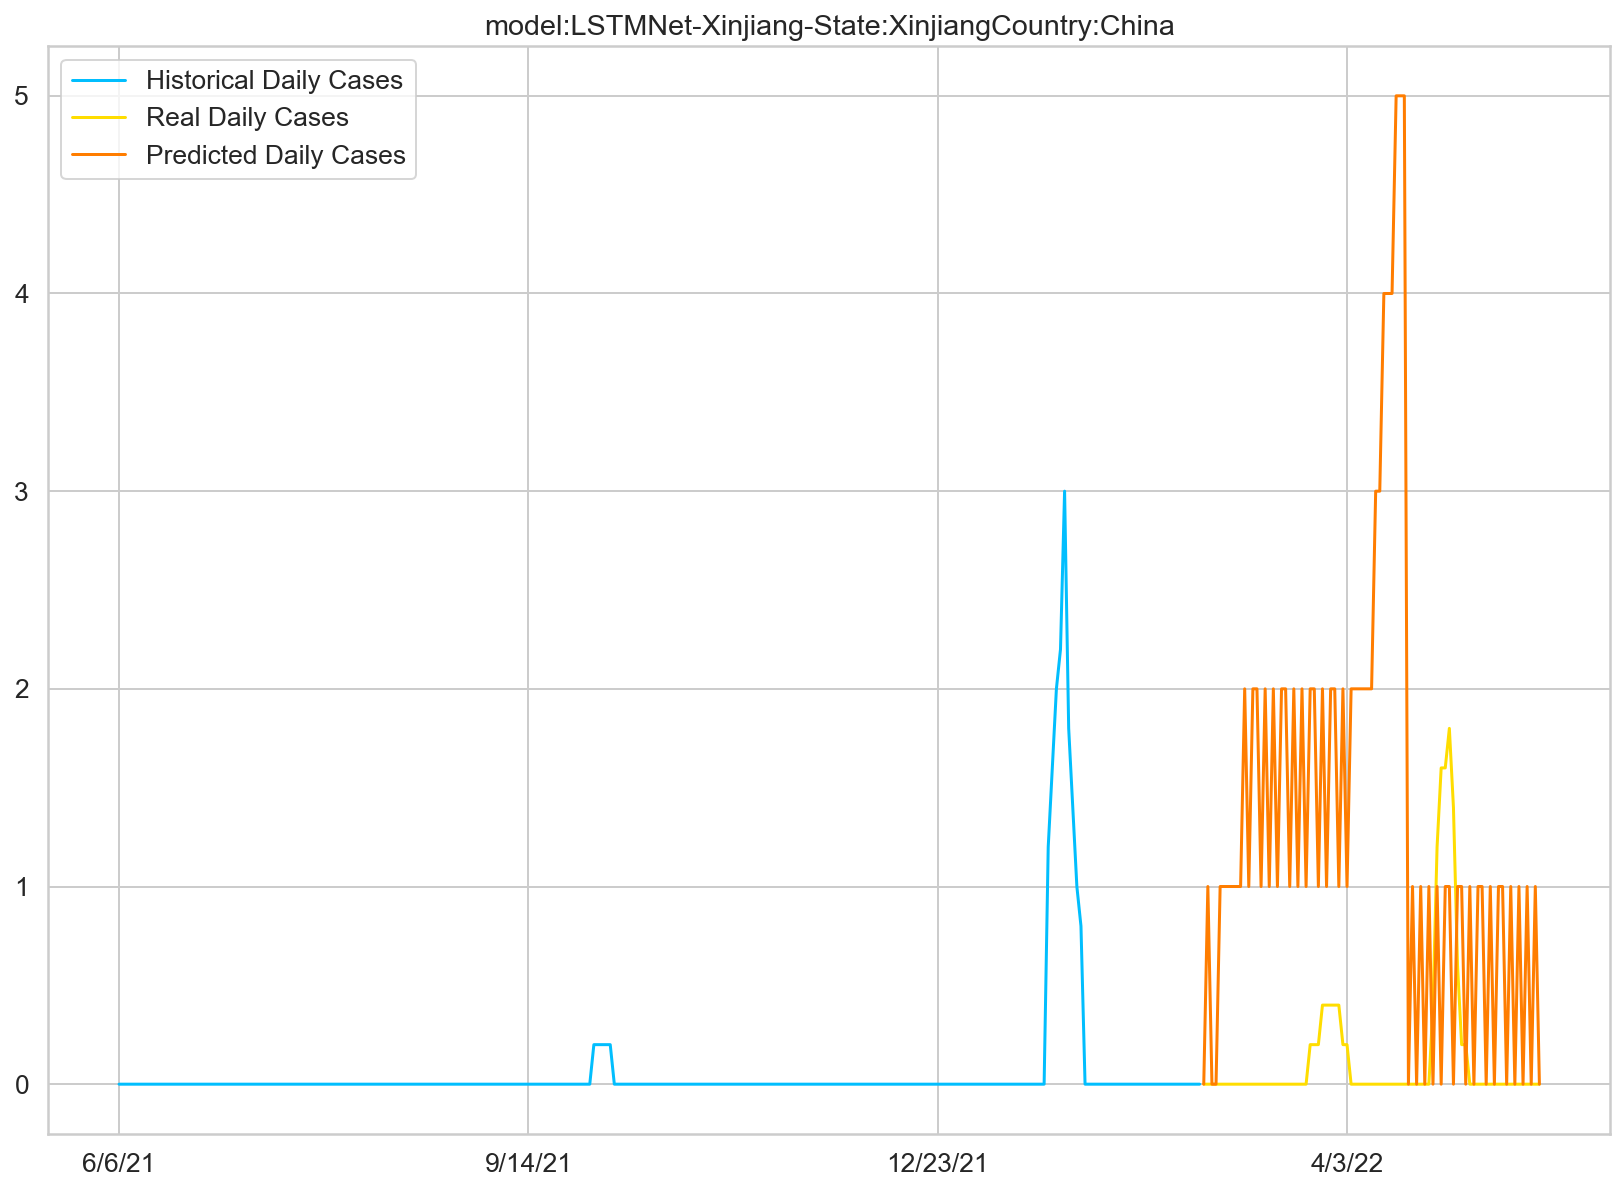

选择累计新增
266
84


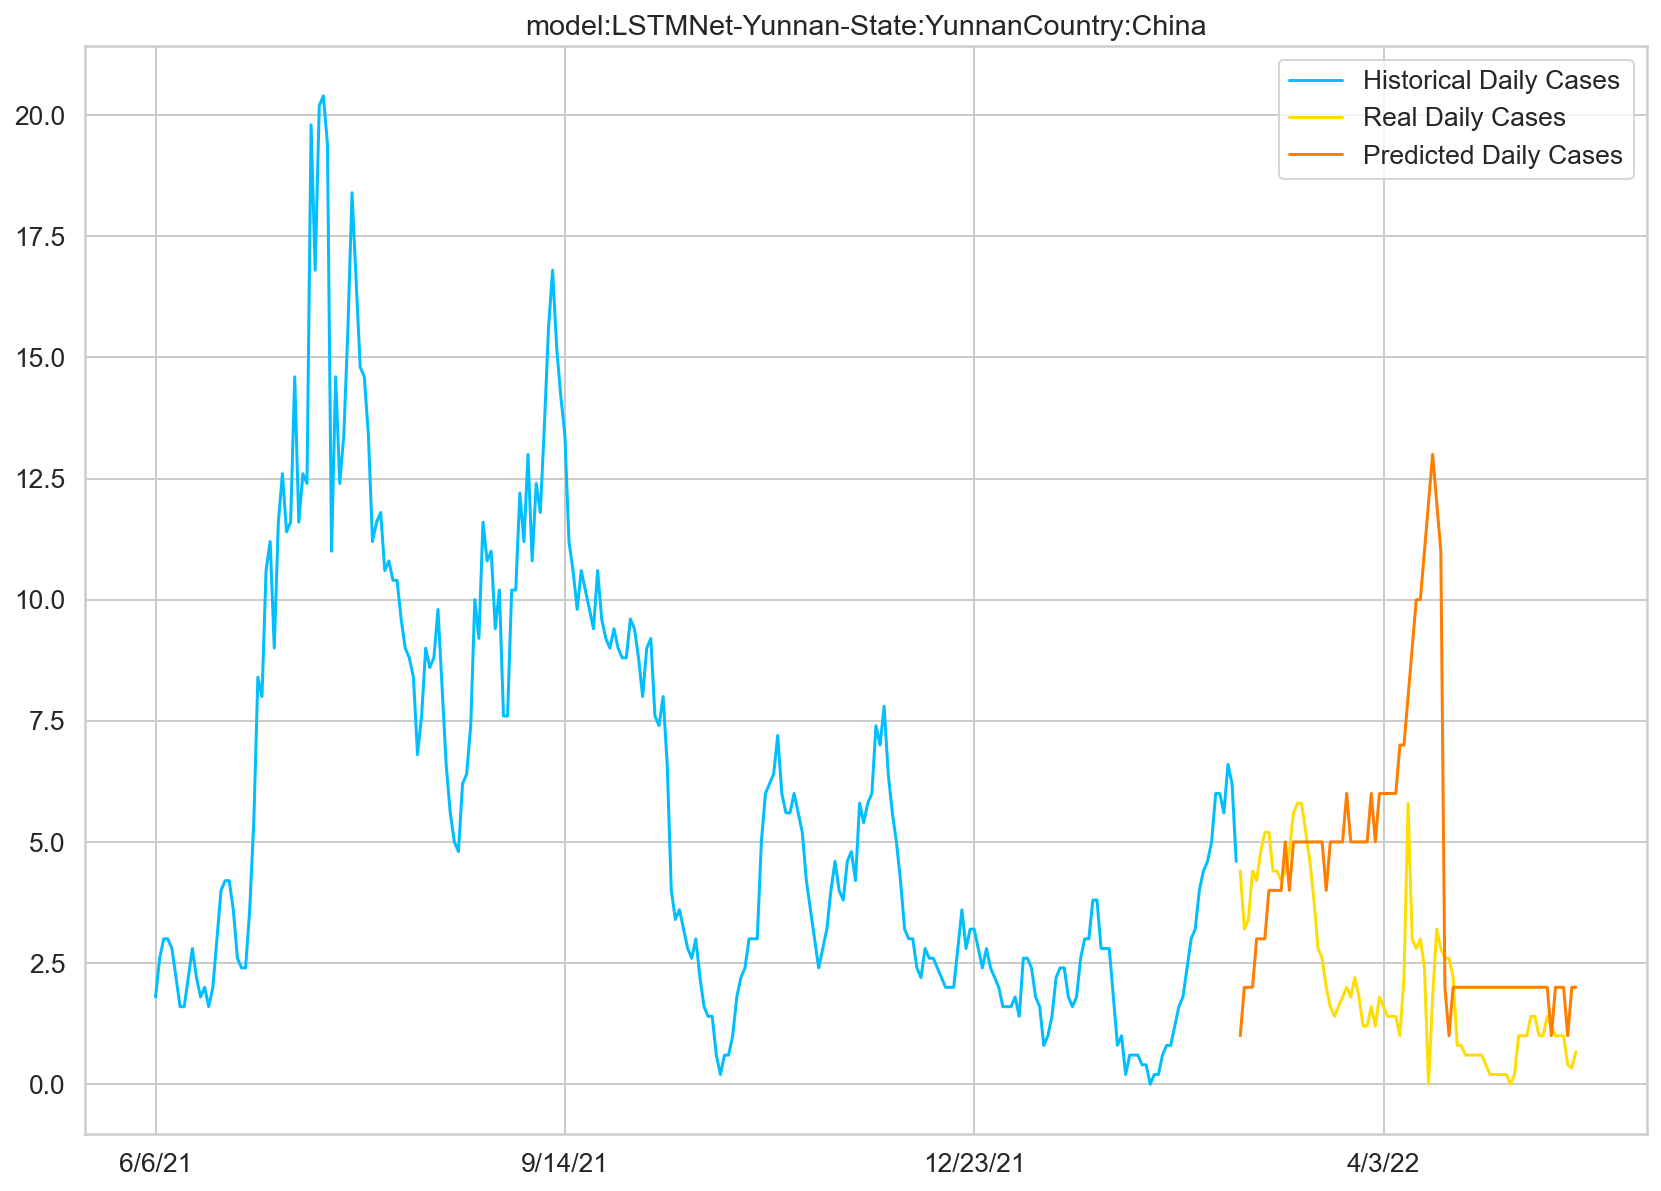

选择累计新增
266
84


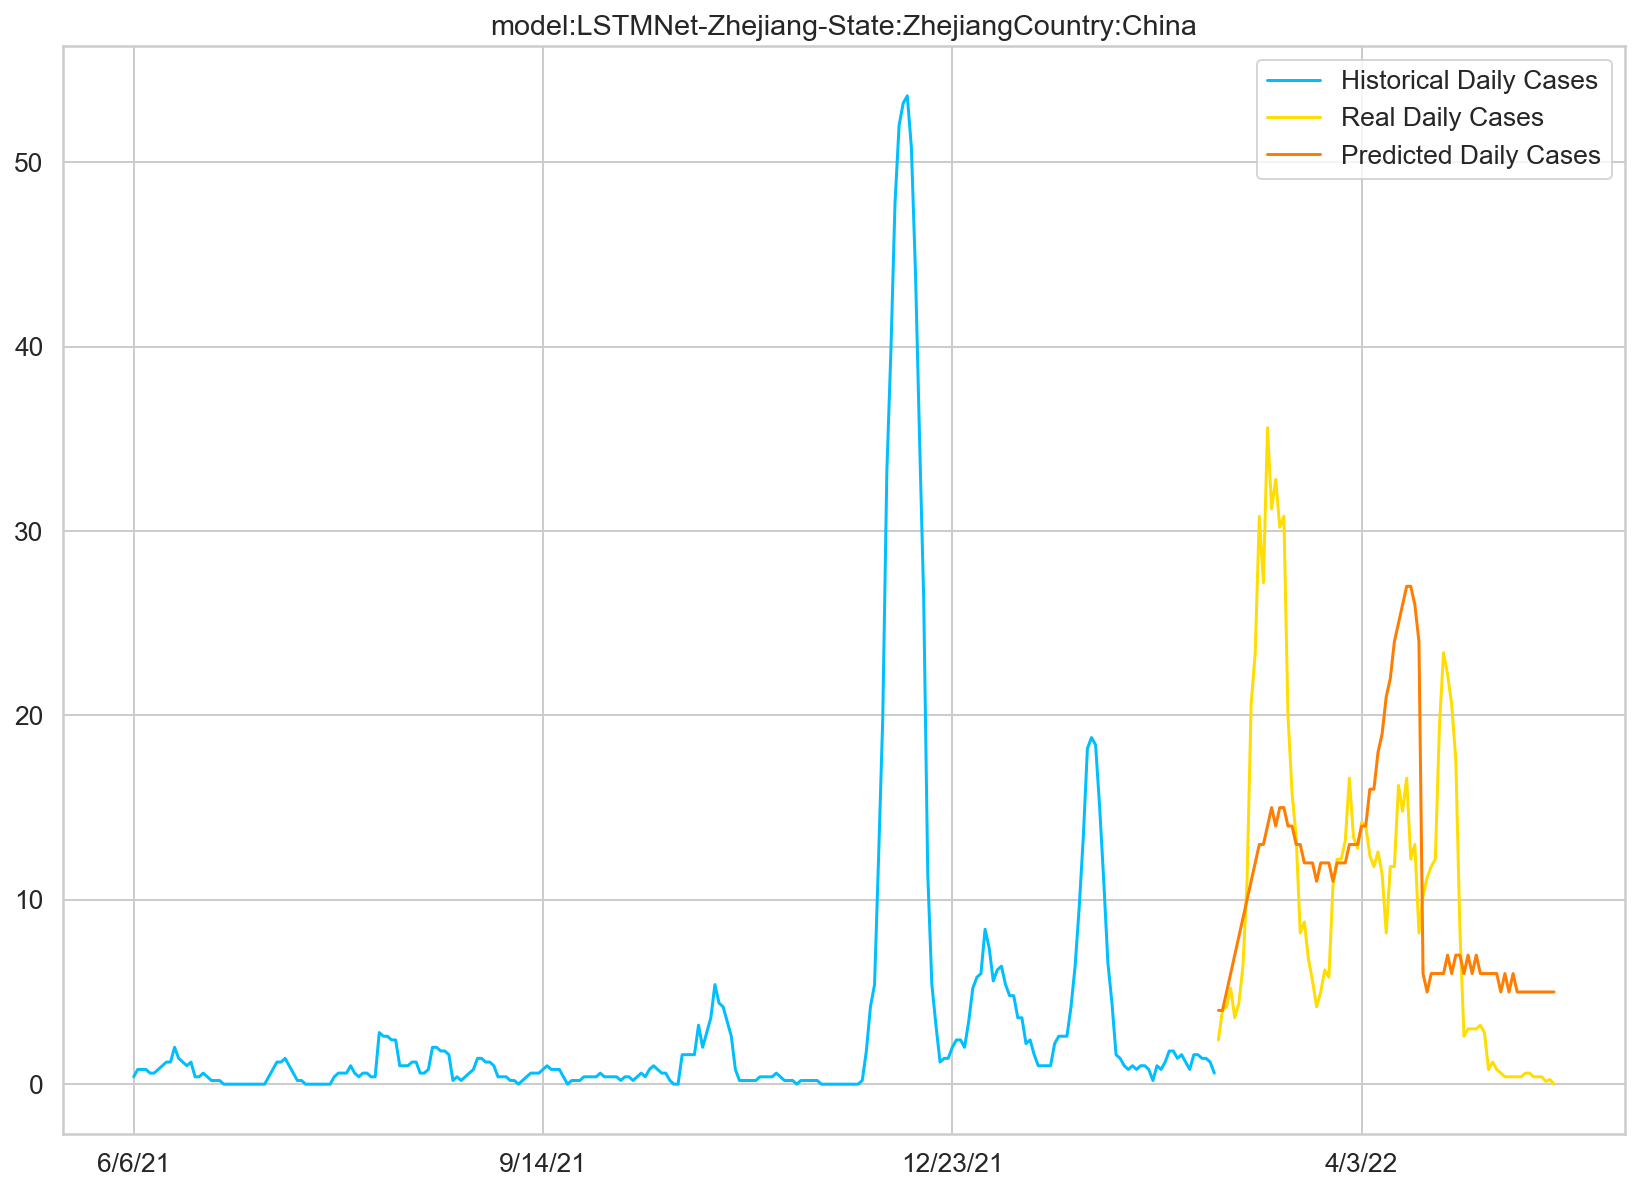

In [54]:
def data_testing_2(data, index, model):
    pre_ratio = 0.1

    seq_length = 50

    model_select = 0
    # model_select = 1

    num_epochs = 100

    data_select = 1 # 进行数据集的选择

    lr_ratio = 1e-3

    fig, ax = plt.subplots(1, 1)
    y1 = data.loc[index].diff()

    model_name = "LSTMNet-{}".format(state.loc[index])

    # 清洗了上海数据中的wrong case
    if index == 84:
        y1.loc['4/20/22'] = (y1.loc['4/19/22'] + y1.loc['4/21/22']) // 2

    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    plt.plot(y1)
    confirmed_avg = moving_average(y1, 5)
    plt.plot(confirmed_avg, color='red', linestyle='dashed')
    plt.title("{}, {} - Daily Confirmed".format(state.loc[index], country.loc[index]))

    #     plt.show()
    plt.savefig("../daily/{}, {} - Daily Confirmed.png".format(state.loc[index], country.loc[index]))
    plt.close('all')  # 关闭所有 figure windows

    chose_data = data.iloc[index][1:]
    chose_data = moving_average(chose_data, 5)
    print("选择累计新增")

    test_data_size = int(data.shape[1] * pre_ratio)

    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(chose_data, axis=1))

    chose_data = scaler.transform(np.expand_dims(chose_data, axis=1))

    # 数据选择 + 预处理
    if model_select == 2:
        train_data = chose_data[:-test_data_size]
        test_data = chose_data[-test_data_size:]
        X_train = np.arange(len(train_data))
        y_train = train_data

        X_test = np.arange(len(train_data), len(train_data) + len(test_data))
        y_test = test_data

    else:
        train_data = chose_data[:-test_data_size]
        test_data = chose_data[-test_data_size - seq_length:]
        X_train, y_train = create_sequences(train_data, seq_length)
        X_test, y_test = create_sequences(test_data, seq_length)

    # 转换为tenseor
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 自动使用CPU或者GPU

    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)

    X_test = torch.from_numpy(X_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

#     对于每一个地方训练一下
    model = model.to(device)
    # model, train_hist, test_hist, lr_list = train_model(
    #   model,
    #   X_train,
    #   y_train,
    #   X_test,
    #   y_test,
    #   num_epochs=600
    # )

    #     测试结果
    with torch.no_grad():
        if model_select == 2:
            test_seq = X_test
            test_seq = test_seq.to(device)
            y_test_pred = model(test_seq)
            preds = y_test_pred.squeeze(1).cpu().numpy()
        else:
            test_seq = X_test[:1]
            preds = []
            for _ in range(len(X_test)):
                test_seq = test_seq.to(device)
                y_test_pred = model(test_seq)
                pred = torch.flatten(y_test_pred).item()
                preds.append(pred)
                new_seq = test_seq.cpu().numpy().flatten()
                new_seq = np.append(new_seq, [pred])
                new_seq = new_seq[1:]
                test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

    if model_select == 2 and data_select != 2:
        train_data = y_train.cpu()
        true_cases = scaler.inverse_transform(
            np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
        ).flatten()

        predicted_cases = scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
        ).flatten()
        predicted_cases = np.int32(predicted_cases)

        fig, ax = plt.subplots(1, 1)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

        plt.plot(
            data.iloc[index].index[:len(train_data)],
            (scaler.inverse_transform(train_data).flatten()),  # 648
            label='Historical Daily Cases'
        )

        print(data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)].shape)
        plt.plot(
            data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],  # 721
            (true_cases),  # 102
            label='Real Daily Cases'
        )

        # plt.plot(
        #   data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],
        #   (predicted_cases),
        #   label='Predicted Daily Cases'
        # )
        plt.plot(
            data.iloc[index].index[:len(chose_data)],
            (predicted_cases),
            label='Predicted Daily Cases'
        )
        plt.title("model:{}  Country: {}".format(model_name, country[index]))
        plt.legend()

    elif data_select == 0 or data_select == 1:
        true_cases = scaler.inverse_transform(
            np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
        ).flatten()

        predicted_cases = scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
        ).flatten()
        predicted_cases = np.int32(predicted_cases)

        fig, ax = plt.subplots(1, 1)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

        plt.plot(
            data.iloc[index].index[501:len(train_data)],
            (np.maximum(np.diff(scaler.inverse_transform(train_data).flatten()), 0))[500:],
            label='Historical Daily Cases'
        )
        print(len(train_data) - 500)
        print(len(true_cases))

        plt.plot(
            data.iloc[index].index[len(train_data) + 1:len(train_data) + len(true_cases)],
            (np.maximum(np.diff(true_cases), 0)),
            label='Real Daily Cases'
        )

        plt.plot(
            data.iloc[index].index[len(train_data) + 1:len(train_data) + len(true_cases)],
            (np.maximum(np.diff(predicted_cases), 0)),
            label='Predicted Daily Cases'
        )
        plt.title("model:{}-State:{}Country:{}".format(model_name, state[index], country[index]))
        plt.legend()
        plt.savefig("../pre2/{}_v2.png".format(state[index]))

#         print(np.sum(((true_cases - predicted_cases) / true_cases) ** 2))

        plt.show()
#         plt.savefig("..\\pre\\model:{}  State: {}  Country: {}.png".format(model_name, state[index], country[index])
        plt.close('all')
model_2 = torch.load('../../model/LSTMNet2.pth')
# import time
indexs = list(range(59, 71)) + list(range(73, 89)) + list(range(90, 93))
model_list = []
start = time.time()
for i, index in enumerate(indexs):

    # area_model = LSTMNet()
    # model_list.append(LSTMNet())
    # data_testing(data, index, model_list[i])

    data_testing_2(data, index, model_2)

    # print((time.time() - start) / 60)
    # start = time.time()